# MAIN PLAN

brainstorming for things to try:
 - 1 solid analysis for presentation
 - https://github.com/ohsono/stats414/tree/main

FINAL DATASETS TO SYNTHESIZE ON:


(1) feature engineering (Nils / Rohan)
- cut down to top 6 task ids
- interest categories
- removing unimportant features & analyzing for model results
    - TODO: remove more unimportant features.....
- data pruning (don't see the 1/3 clickthrough rate stated in lecture)
  - finding better user removal threshold
  - Removing uninformative features

(2) generate 2 different synthetic datasets (Lucy / Setara)
- ChatGPT (more recent version)
  - prompt engineering (casual vs formatted requests, etc)
- realtabformer and multi table generation (uses chat 2)**
  - https://github.com/worldbank/REaLTabFormer
- CTGAN
  - https://github.com/sdv-dev/CTGAN

post Wednesday

(3) framework for evaluating quality of synthetic data
- statistical distributions comparison
- lasso on real vs. synthetic data
- we need to do fidelity and utilization based off the slides

(4) test synthetic + real vs. real classifiers and compare different metrics - try 2 classifiers ?
- logistic regression, xgboost, stacked etc.
- how should we weight real/synthetic data? real : synthetic - golden ratio (more real to avoid model collapse)
- how much synthetic data should we generate?


framework based off what guest lecturer said:
- prune based off the task id and user id and this should be 6 subgroups
- afterwards can do preprocessing, then running xgboost, random forest, etc to find unimportant features and remove those (for this I fear we have to do it on the full pruned dataset and each subset for the synthetic data)
- create synthetic data and do this on each of the subgroups for computational purposes
- do evaluation to see which synthesizer is better
- then choose one and run logistic regression/xg boost
- then can compare metrics and to midterm metrics


TODO post presentation
- try chatgpt-5
https://chatgpt.com/share/692b6f6d-30bc-8013-b52f-614cac3d1ca1
- more privacy eval (realtabformer has CDR function)

## (1) Load Data

In [ ]:
!pip install -q joblib
!pip install -q realtabformer
!pip install -q ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 102.7 MB/s eta 0:00:00


In [ ]:
import sys
import shutil
import numpy as np
import kagglehub
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import os
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from realtabformer.realtabformer import REaLTabFormer
from ctgan import CTGAN

#### ***Run once then rely on cached data afterwards!***

Dataset link: https://www.kaggle.com/datasets/xiaojiu1414/digix-global-ai-challenge?resource=download

In [ ]:

# Download latest version
path = kagglehub.dataset_download("xiaojiu1414/digix-global-ai-challenge")

print("Path to dataset files:", path)

100%|██████████| 879M/879M [00:40<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/xiaojiu1414/digix-global-ai-challenge/versions/1


In [ ]:
# List test files
os.listdir(os.path.join(path, "test"))

['test_data_ads.csv', 'test_data_feeds.csv']

In [ ]:
# List training files
os.listdir(os.path.join(path, "train"))

['train_data_ads.csv', 'train_data_feeds.csv']

In [ ]:
train_feeds = pd.read_csv(os.path.join(path, "train", "train_data_feeds.csv"))
train_ads = pd.read_csv(os.path.join(path, "train", "train_data_ads.csv"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
joblib.dump(train_feeds, '/content/drive/MyDrive/train_feeds.joblib')
joblib.dump(train_ads, '/content/drive/MyDrive/train_ads.joblib')

['/content/drive/MyDrive/train_ads.joblib']

#### ***Uncaching Data***

Using joblib to decrease compile time. It's fast and robust with large data and uses disk-caching to avoid reloading data. Storing a copy in your drive then copying it over to /content/ during session for speed.

*Note: Caching the dataset thru joblib means any changes made after this instance will not be reflected in subsequent reboots of session*

Resources: https://joblib.readthedocs.io/en/stable/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/train_feeds.joblib /content/
!cp /content/drive/MyDrive/train_ads.joblib /content/

In [ ]:
train_feeds = joblib.load('/content/train_feeds.joblib')
train_ads = joblib.load('/content/train_ads.joblib')

### (1.1) Data Descriptions

**Ads Data Description** - A.K.A. "Source Domain"

| Variable              | Chinese Description | English Translation                                               |
| --------------------- | ------------------- | ----------------------------------------------------------------- |
|**label** | | User ID
|**user_id** | | User ID
|**age** | | Age
|**gender** | | Gender
| **residence** ||Permanent residence (province)
| **city**          |           | Permanent residence (city ID).
| **city_rank**         |        | Permanent residence (city level).
| **series_dev**        | 设备系列                | Device series                                                     |
| **series_group**      | 设备系列分组              | Device series group                                               |
| **emui_dev**          | emui 版本号            | EMUI version number                                               |
| **device_name**       | 用户使用的手机机型           | Phone model used by the user                                      |
| **device_size**       | 用户使用手机的尺寸           | Size of the user’s phone                                          |
| **net_type**          | 行为发生的网络状态           | Network status when the behavior occurred                         |
| **task_id**           | 广告任务唯一标识            | Unique identifier of the ad task                                  |
| **adv_id**            | 广告任务对应的素材 id        | Material ID corresponding to the ad task                          |
| **creat_type_cd**     | 素材的创意类型 id          | Creative type ID of the material                                  |
| **adv_prim_id**       | 广告任务对应的广告主 id       | Advertiser ID corresponding to the ad task                        |
| **inter_type_cd**     | 广告任务对应的素材的交互类型      | Interaction type of the material in the ad task                   |
| **slot_id**           | 广告位 id              | Ad placement ID                                                   |
| **site_id**           | 媒体 id               | Media ID                                                          |
| **spread_app_id**     | 投放广告任务对应的应用 id      | Application ID associated with the ad task                        |
| **hispace_app_tags**  | 广告任务对应的应用的标签        | Tags of the application associated with the ad task               |
| **app_second_class**  | 广告任务对应的应用的二级分类      | Secondary category of the application associated with the ad task |
| **app_score**         | app 得分              | App score                                                         |
| **ad_click_list_001** | 用户点击广告任务 id 列表      | List of ad task IDs clicked by the user                           |
| **ad_click_list_002** | 用户点击广告对应广告主 id 列表   | List of advertiser IDs for ads clicked by the user                |
| **ad_click_list_003** | 用户点击广告推荐应用列表        | List of recommended apps from ads clicked by the user             |
| **ad_close_list_001** | 用户关闭广告任务列表          | List of ad task IDs closed by the user                            |
| **ad_close_list_002** | 用户关闭广告对应广告主列表       | List of advertiser IDs for ads closed by the user                 |
| **ad_close_list_003** | 用户关闭广告推荐应用列表        | List of recommended apps from ads closed by the user              |
| **pt_d**              | 时间戳                 |
| **u_newsCatInterestsST** | 用户短时兴趣分类偏好          | User’s short-term interest category preferences Timestamp                                                         |
| **u_feedLifeCycle**      |                     | User engagement on news feeds                                 |
| **u_refreshTimes**       |                     | Average number of valid news feed updates per day
| **log_id**            | 样本 id               | Sample ID                                                         |


**Feeds Data Description** - A.K.A "Target Domain"

| Variable                 | Chinese Description | English Translation                                           |
| ------------------------ | ------------------- | ------------------------------------------------------------- |
| **u_userId**             |                     | User ID                                                       |
| **u_phonePrice**         |                     | Price of a user's device                                      |
| **u_browserLifeCycle**   |                     | User engagement on browser                                    |
| **u_browserMode**        |                     | Browser service type                                          |
| **u_feedLifeCycle**      |                     | User engagement on news feeds                                 |
| **u_refreshTimes**       |                     | Average number of valid news feed updates per day             |
| **u_newsCatInterests**   |                     | Liked news feed categories based on the user's click behavior |
| **u_newsCatDislike**     | 信息流图文负反馈分类偏好        | Negative feedback category preferences in news feed content   |
| **u_newsCatInterestsST** | 用户短时兴趣分类偏好          | User’s short-term interest category preferences               |
| **u_click_ca2_news**     | 用户图文类别点击序列          | Click sequence of article categories by the user              |
| **i_docId**              | 文章 docid            | Article doc ID                                                |
| **i_s_sourceId**         | 文章来源的 sourceid      | Source ID of the article                                      |
| **i_regionEntity**       | 文章地域词 id            | Regional entity ID of the article                             |
| **i_cat**                | 文章类别 id             | Article category ID                                           |
| **i_entities**           | 文章实体词 id            | Entity word IDs in the article                                |
| **i_dislikeTimes**       | 文章负反馈量              | Number of negative feedbacks on the article                   |
| **i_upTimes**            | 文章点赞量               | Number of likes on the article                                |
| **I_dtype**              | 文章展现形式              | Display type of the article                                   |
| **e_ch**                 | 频道                  | Channel                                                       |
| **e_m**                  | 事件来源设备机型            | Device model where the event originated                       |
| **e_po**                 | 第几位                 | Position (ranking)                                            |
| **e_pl**                 | 拜访地                 | Location visited                                              |
| **e_rn**                 | 第几刷                 | Feed refresh count (Nth refresh)                              |
| **e_section**            | 信息流场景类型             | Type of news feed scene                                       |
| **e_et**                 | 时间戳                 | Timestamp                                                     |
| **label**                | 是否点击， -1：否， 1：是     | Whether the user clicked (−1: No, 1: Yes)                     |
| **cilLabel**             | 是否点赞，-1：否， 1：是      | Whether the user liked (−1: No, 1: Yes)                       |
| **pro**                  | 文章浏览进度              | Article reading progress                                      |


## (2) Data Pruning

In [ ]:
train_ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675517 entries, 0 to 7675516
Data columns (total 35 columns):
 #   Column                Dtype         
---  ------                -----         
 0   log_id                int64         
 1   label                 int64         
 2   user_id               int64         
 3   age                   int64         
 4   gender                int64         
 5   residence             int64         
 6   city                  int64         
 7   city_rank             int64         
 8   series_dev            int64         
 9   series_group          int64         
 10  emui_dev              int64         
 11  device_name           int64         
 12  device_size           int64         
 13  net_type              int64         
 14  task_id               int64         
 15  adv_id                int64         
 16  creat_type_cd         int64         
 17  adv_prim_id           int64         
 18  inter_type_cd         int64         
 19  

In [ ]:
# initially the distribution is
train_ads['label'].value_counts() / train_ads.shape[0]

label
0    0.984478
1    0.015522
Name: count, dtype: float64

In [ ]:
# Convert pt_d to datetime for completeness
train_ads["pt_d"] = pd.to_datetime(train_ads["pt_d"], format="%Y%m%d%H%M")
train_ads = train_ads.sort_values("pt_d").reset_index(drop=True)

# STEP 2: Find the top 6 task_id subgroups (D1–D6)
print("STEP 2: Building D1–D6 (top 6 task_ids, then user-level pruning)")

task_id_counts = train_ads["task_id"].value_counts()
top_6_task_ids = task_id_counts.head(6).index.tolist()

print("\nTop 6 task_ids by frequency:")
for i, t in enumerate(top_6_task_ids, 1):
    print(f"  D{i}: task_id={t}  ({task_id_counts[t]:,} rows)")

D_sets = {}          # pruned D1–D6 stored here
D_stats = []         # for a little summary table

for i, t_id in enumerate(top_6_task_ids, 1):
    print(f"\n==================== D{i}: task_id = {t_id} ====================")

    # ---- 2a. subset for this task_id (original subgroup) ----
    df_t = train_ads[train_ads["task_id"] == t_id].copy()
    ctr_before = df_t["label"].mean()

    print(f"Rows before pruning: {len(df_t):,}")
    print(f"CTR before pruning:  {ctr_before:.4f} ({100*ctr_before:.2f}%)")

    # ---- 2b. keep only users who have EVER clicked in THIS subgroup ----
    users_clicked = (
        df_t.groupby("user_id")["label"].any()
        .pipe(lambda s: s[s])           # keep True
        .index
    )

    df_pruned = df_t[df_t["user_id"].isin(users_clicked)].copy()
    ctr_after = df_pruned["label"].mean()

    print(f"Rows after pruning:  {len(df_pruned):,}")
    print(f"CTR after pruning:   {ctr_after:.4f} ({100*ctr_after:.2f}%)")

    # store
    D_sets[f"D{i}"] = df_pruned
    D_stats.append({
        "Dataset": f"D{i}",
        "task_id": t_id,
        "rows_before": len(df_t),
        "rows_after": len(df_pruned),
        "ctr_before": ctr_before,
        "ctr_after": ctr_after,
    })

# Optional: see a small summary like the slide’s table
D_stats_df = pd.DataFrame(D_stats)
print("\nSummary of D1–D6:")
print(D_stats_df[["Dataset","task_id","rows_before","rows_after",
                  "ctr_before","ctr_after"]])

# STEP 3: Combine D1–D6 if you want ONE pruned dataset for modeling
print("STEP 3: Combine pruned D1–D6 into one dataset (for modeling)")

ads_pruned_all = pd.concat(D_sets.values(), ignore_index=True)

combined_ctr = ads_pruned_all["label"].mean()
print(f"Rows in combined pruned dataset: {len(ads_pruned_all):,}")
print(f"Users in combined pruned dataset: {ads_pruned_all['user_id'].nunique():,}")
print(f"CTR in combined pruned dataset:  {combined_ctr:.4f} ({100*combined_ctr:.2f}%)")

# From here on, use ads_pruned_all for feature engineering:
pruned_train_ads = ads_pruned_all.copy()

STEP 2: Building D1–D6 (top 6 task_ids, then user-level pruning)

Top 6 task_ids by frequency:
  D1: task_id=22100  (154,812 rows)
  D2: task_id=14584  (126,367 rows)
  D3: task_id=34382  (122,094 rows)
  D4: task_id=34975  (92,381 rows)
  D5: task_id=31941  (77,470 rows)
  D6: task_id=31996  (69,691 rows)

==================== D1: task_id = 22100 ====================
Rows before pruning: 154,812
CTR before pruning:  0.0018 (0.18%)
Rows after pruning:  4,628
CTR after pruning:   0.0607 (6.07%)

==================== D2: task_id = 14584 ====================
Rows before pruning: 126,367
CTR before pruning:  0.0148 (1.48%)
Rows after pruning:  29,359
CTR after pruning:   0.0637 (6.37%)

==================== D3: task_id = 34382 ====================
Rows before pruning: 122,094
CTR before pruning:  0.0016 (0.16%)
Rows after pruning:  2,724
CTR after pruning:   0.0712 (7.12%)

==================== D4: task_id = 34975 ====================
Rows before pruning: 92,381
CTR before pruning:  0.0019

### eda with click-rate

In [ ]:
# Calculate number of online instances per user
instances_per_user = pruned_train_ads.groupby(['user_id']).size()

# Calculate the sum of 'label' (clicks) for each user
clicks_per_user = pruned_train_ads.groupby(['user_id'])['label'].sum()

# Average click rate for each user
average_click_rate = clicks_per_user / instances_per_user

In [ ]:
results = []
thresholds = np.linspace(0.01, 0.1, num = 10)

for thresh in thresholds:
  higher_click_rate_users = average_click_rate[average_click_rate > thresh] # Corrected filter
  higher_click_rate_users_indices = higher_click_rate_users.index

  higher_pruned_train_ads = pruned_train_ads[pruned_train_ads['user_id'].isin(higher_click_rate_users_indices)]

  label_counts = higher_pruned_train_ads['label'].value_counts(normalize=True)

  no_click_proportion = label_counts.get(0, 0) # Get proportion of 0, default to 0 if not present
  click_proportion = label_counts.get(1, 0)   # Get proportion of 1, default to 0 if not present
  num_users_left = len(higher_click_rate_users_indices)

  results.append({
      'threshold': thresh,
      'no-click (0)': no_click_proportion,
      'click (1)': click_proportion,
      'num users left': num_users_left
  })

threshold_df = pd.DataFrame(results)
display(threshold_df)

threshold  no-click (0)  click (1)  num users left
0       0.01      0.900960   0.099040            4093
1       0.02      0.879922   0.120078            3950
2       0.03      0.855660   0.144340            3757
3       0.04      0.825749   0.174251            3539
4       0.05      0.794105   0.205895            3342
5       0.06      0.766017   0.233983            3190
6       0.07      0.734753   0.265247            3044
7       0.08      0.705078   0.294922            2926
8       0.09      0.686050   0.313950            2855
9       0.10      0.647123   0.352877            2705

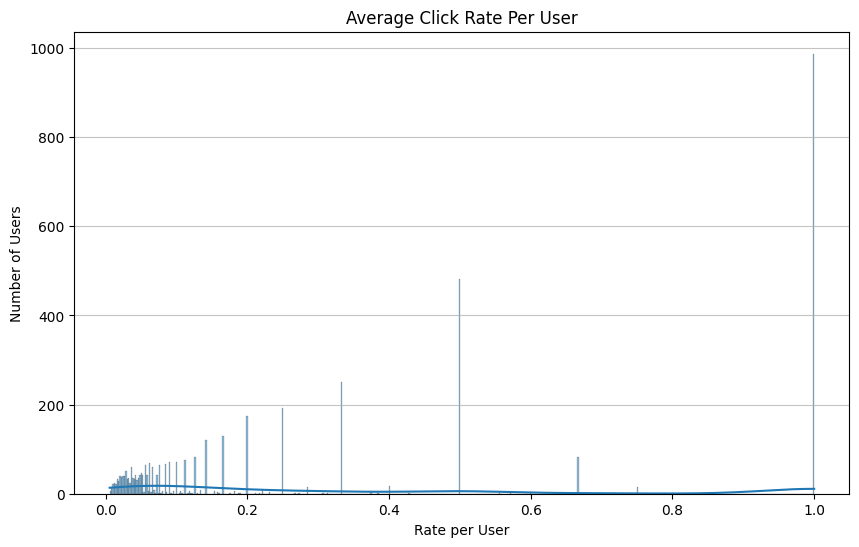

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of clicks per user
plt.figure(figsize=(10, 6))
sns.histplot(average_click_rate, bins=500, kde=True)
plt.title('Average Click Rate Per User')
plt.xlabel('Rate per User')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Questions on Additional Pruning Methodology**


*   How representative are instance users (1-3/5/10) of ad clickthrough rate predciton?
*   Should we exclude users past a certain individual click rate (.03/.05/.1) as only a click over many instances may be indicative of an accidental click? .03 Threshold elminiates ~50% of users.
*   Should we exclude the roughly 80 users whose only appearance one the web page led to a ad click?



In [ ]:
pruned_train_ads.head()

log_id  label  user_id  age  gender  residence  city  city_rank  \
0  1131711      0   247105    3       2         11   169          2   
1  1131737      0   247105    3       2         11   169          2   
2  1131714      0   247105    3       2         11   169          2   
3  1140732      0   208905    8       2         42   410          2   
4  1140771      0   208905    8       2         42   410          2   

   series_dev  series_group  ...             ad_click_list_v001  \
0          16             5  ...  12092^21493^26644^14606^34975   
1          16             5  ...  12092^21493^26644^14606^34975   
2          16             5  ...  12092^21493^26644^14606^34975   
3          21             4  ...  28403^20581^18365^13230^18473   
4          21             4  ...  28403^20581^18365^13230^18473   

         ad_click_list_v002   ad_click_list_v003       ad_close_list_v001  \
0  1189^1036^1097^1964^1562  152^312^309^246^301  35034^17713^24125^15169   
1  1189^1036^1097^1964^1562  152^312^309^246^301  35034^17713^24125^15169   
2  1189^1036^1097^1964^1562  152^312^309^246^301  35034^17713^24125^15169   
3  1577^1199^1636^1516^1408  350^190^103^162^306                    24107   
4  1577^1199^1636^1516^1408  350^190^103^162^306                    24107   

    ad_close_list_v002  ad_close_list_v003                pt_d  \
0  1542^1964^1097^1795                 152 2022-06-03 01:01:00   
1  1542^1964^1097^1795                 152 2022-06-03 01:01:00   
2  1542^1964^1097^1795                 152 2022-06-03 01:01:00   
3                 1218                 173 2022-06-03 01:02:00   
4                 1218                 173 2022-06-03 01:02:00   

   u_newsCatInterestsST  u_refreshTimes  u_feedLifeCycle  
0      98^65^108^50^140               9               17  
1      98^65^108^50^140               9               17  
2      98^65^108^50^140               9               17  
3      98^78^98^205^105               8               11  
4      98^78^98^205^105               8               11  

[5 rows x 35 columns]

In [ ]:
pruned_train_ads.shape

(54823, 35)

In [ ]:
pruned_train_ads['label'].value_counts() / pruned_train_ads.shape[0]

label
0    0.905332
1    0.094668
Name: count, dtype: float64

## (3) Data Processing

#### **type casting to decrease memory requirements**


In [ ]:
# source: https://medium.com/pythoneers/optimising-data-storage-in-python-through-efficient-datatype-casting-3df6c4b4fc27
# modifies dataframe in place
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # float32: default in pytorch
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage before optimization is: {:.2f} MB'.format(start_mem))
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

steps:
- drop irrelevant variables
- parse timestamp pt_d into new features (did in pruning)
- create new features: length of cat news interests and ads clicked/closed, remove the concatenated features
- turn features into categorical i.e. gender, age

#### **functions for data processing**

**Is add_list_count_features inducing a lot of information loss by removing ad content types, etc. that could be indicative of higher likelihood to click ads? E.g. People who enjoy online shopping --> more likely to click ads?

Right now, all that the list count features are measuring is whether more or less interests lead to greater/fewer clicks/closes**

In [ ]:
# purpose: take the lists with ^, remove those features, and instead create new features for the lengths of those lists
def add_list_count_features(df, list_features):
    """
    Converts caret-separated list columns into count features,
    aggregates click/close means, drops original list columns,
    and returns the updated dataframe.
    """

    # ---- Helper function ----
    def count_caret_entries(series):
        return series.fillna("").apply(
            lambda x: len([t for t in str(x).split("^") if t])
        )

    # ---- Step 1: Create *_count columns ----
    for col in list_features:
        df[f"{col}_count"] = count_caret_entries(df[col])

    # ---- Step 2: Drop original list-like columns ----
    df = df.drop(columns=list_features)

    # ---- Step 3: Aggregate click/close features ----
    click_cols = [
        "ad_click_list_v001_count",
        "ad_click_list_v002_count",
        "ad_click_list_v003_count"
    ]
    close_cols = [
        "ad_close_list_v001_count",
        "ad_close_list_v002_count",
        "ad_close_list_v003_count"
    ]

    df["click_count_mean"] = df[click_cols].mean(axis=1)
    df["close_count_mean"] = df[close_cols].mean(axis=1)

    # Drop individual count columns (keep only means)
    df = df.drop(columns=click_cols + close_cols)

    return df

#### **doing the processing**

In [ ]:
pruned_train_ads.shape

(54823, 35)

In [ ]:
# Target column
target = 'label'

# Categorical features (integer codes)
categorical_features = [
    'gender','age','residence','city','city_rank','series_dev','series_group',
    'emui_dev','device_name','device_size','net_type',
    'creat_type_cd','adv_prim_id','inter_type_cd','slot_id',
    'spread_app_id','hispace_app_tags','app_second_class','u_feedLifeCycle'
]

# List-like string features: we convert to simple counts
list_features = [
    'ad_click_list_v001','ad_click_list_v002','ad_click_list_v003',
    'ad_close_list_v001','ad_close_list_v002','ad_close_list_v003',
    'u_newsCatInterestsST'
]

#calling function
train_ads_new = add_list_count_features(pruned_train_ads, list_features)

#removing irrelevant variables, aka ids and pt_d which is now irrelevant
drop_cols = ['log_id','adv_id','task_id','site_id', 'user_id']
train_ads_new = train_ads_new.drop(columns=drop_cols)

In [ ]:
# Store a list of continuous numeric features
numeric_features = ['app_score','u_refreshTimes','click_count_mean','close_count_mean','u_newsCatInterestsST_count']

In [ ]:
# standardizing #going to move this later since we only need it for logistic regression
#scaler = StandardScaler()
#train_ads_new[num_cols] = scaler.fit_transform(train_ads_new[num_cols])

In [ ]:
reduce_mem_usage(train_ads_new)

Memory usage before optimization is: 10.46 MB
Memory usage after optimization is: 2.04 MB
Decreased by 80.5%


label  age  gender  residence  city  city_rank  series_dev  \
0          0    3       2         11   169          2          16   
1          0    3       2         11   169          2          16   
2          0    3       2         11   169          2          16   
3          0    8       2         42   410          2          21   
4          0    8       2         42   410          2          21   
...      ...  ...     ...        ...   ...        ...         ...   
54818      0    8       2         17   343          5          16   
54819      1    5       2         32   179          5          30   
54820      0    6       4         33   319          3          27   
54821      0    6       4         33   319          3          27   
54822      0    6       4         33   319          3          27   

       series_group  emui_dev  device_name  ...  slot_id  spread_app_id  \
0                 5        28          240  ...       16            344   
1                 5        28          240  ...       16            344   
2                 5        28          240  ...       16            344   
3                 4        12          310  ...       16            344   
4                 4        12          310  ...       16            344   
...             ...       ...          ...  ...      ...            ...   
54818             5        21          127  ...       16            174   
54819             3        13          194  ...       23            174   
54820             2        11          140  ...       16            174   
54821             2        11          140  ...       16            174   
54822             2        11          140  ...       16            174   

       hispace_app_tags  app_second_class  app_score  u_refreshTimes  \
0                    20                13       10.0               9   
1                    20                13       10.0               9   
2                    20                13       10.0               9   
3                    20                13       10.0               8   
4                    20                13       10.0               8   
...                 ...               ...        ...             ...   
54818                16                18       10.0               7   
54819                16                18       10.0               0   
54820                16                18       10.0               9   
54821                16                18       10.0               9   
54822                16                18       10.0               9   

       u_feedLifeCycle  u_newsCatInterestsST_count  click_count_mean  \
0                   17                           5               5.0   
1                   17                           5               5.0   
2                   17                           5               5.0   
3                   11                           5               5.0   
4                   11                           5               5.0   
...                ...                         ...               ...   
54818               17                           5               5.0   
54819               17                           1               2.0   
54820               17                           5               5.0   
54821               17                           5               5.0   
54822               17                           5               5.0   

       close_count_mean  
0                   3.0  
1                   3.0  
2                   3.0  
3                   1.0  
4                   1.0  
...                 ...  
54818               1.0  
54819               1.0  
54820               1.0  
54821               1.0  
54822               1.0  

[54823 rows x 25 columns]

### (3.1) Recaching for Trimmed/Pruned Dataset

**Again, Run Once Then Retrieve From Cache**

In [ ]:
joblib.dump(train_ads_new, '/content/drive/MyDrive/train_ads_new.joblib')

['/content/drive/MyDrive/train_ads_new.joblib']

**Uncaching Trimmed/Pruned Dataset**

In [ ]:
!cp /content/drive/MyDrive/train_ads_new.joblib /content/

In [ ]:
train_ads_new = joblib.load('/content/train_ads_new.joblib')

### (3.2) Uninformative Features Testing

**XGBClassifier**

In [ ]:
# For feature importance, no need for train/test split
X = train_ads_new[numeric_features + categorical_features]
y = train_ads_new[target]

# Training XGB Classifier
model = xgb.XGBClassifier(objective='binary:logistic',
                          eval_metric='logloss',
                          enable_categorical=True,
                          random_state=42)

model.fit(X, y)

# Sorting Feature Importance
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

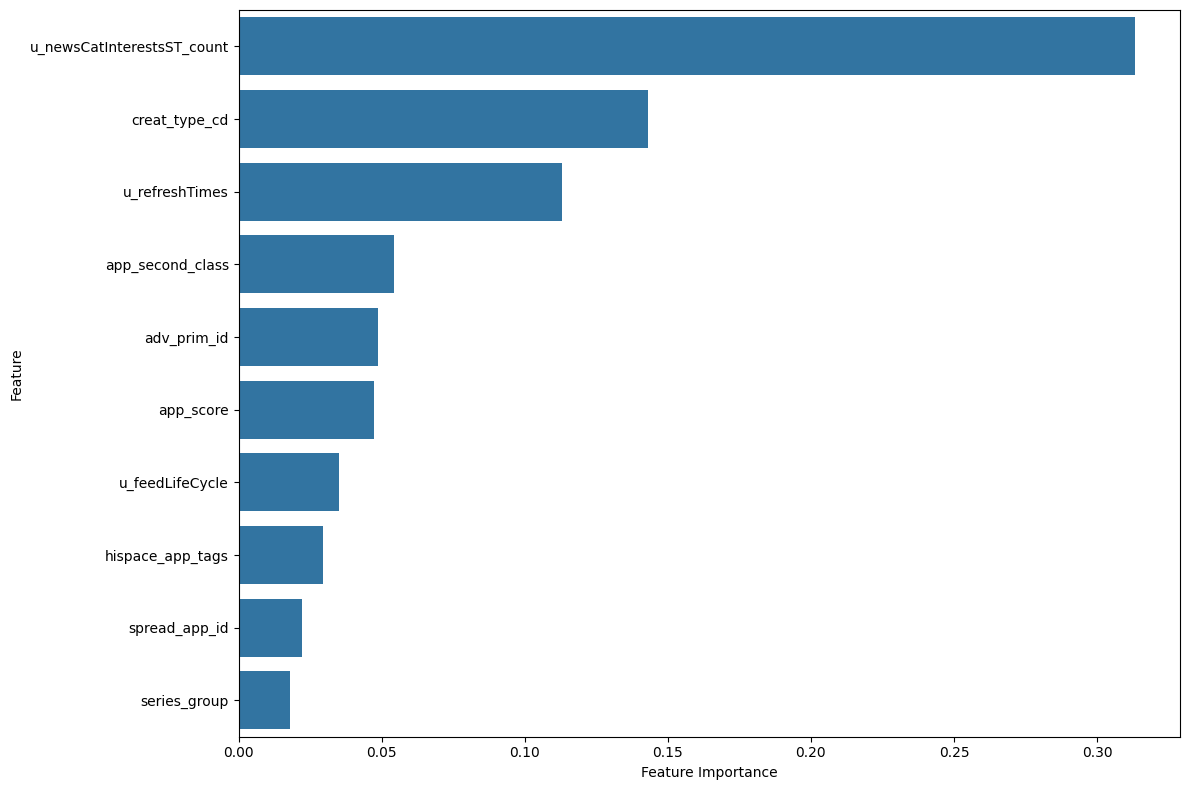

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10)) # Display top 20 featuresplt.title('Top 10 XGBoost Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


 Bottom 19 least important features:
         feature  importance
       app_score    0.047495
 u_feedLifeCycle    0.035208
hispace_app_tags    0.029457
   spread_app_id    0.022308
    series_group    0.018110
        emui_dev    0.015797
          gender    0.015607
             age    0.014960
       residence    0.014898
     device_name    0.013921
         slot_id    0.013603
click_count_mean    0.013531
     device_size    0.013283
            city    0.012883
       city_rank    0.012736
        net_type    0.012056
      series_dev    0.011870
close_count_mean    0.009809
   inter_type_cd    0.000000


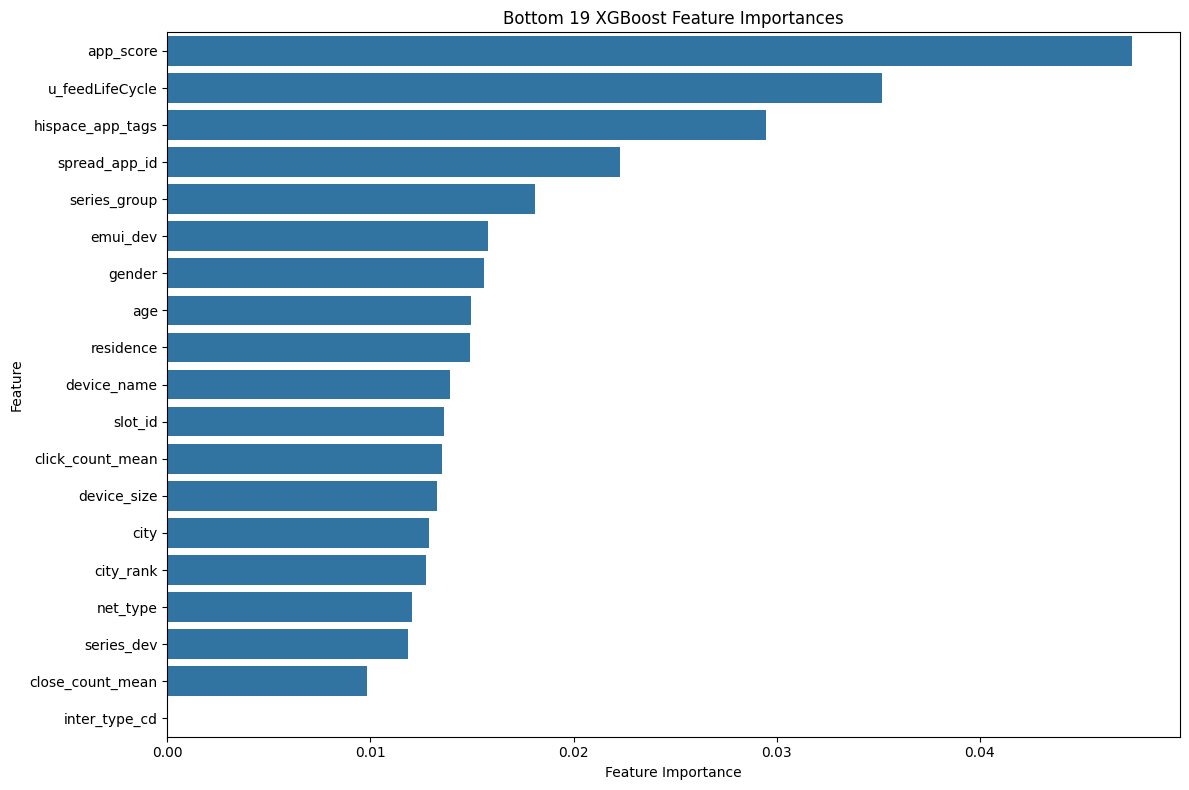

In [ ]:
# Plotting Feature Impotance

# Get bottom 19 least important features
bottom_features = feature_importances.tail(19)

# Print them clearly
print("\n Bottom 19 least important features:")
print(bottom_features.to_string(index=False))

# Plot them
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=bottom_features)
plt.title('Bottom 19 XGBoost Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


remove anything that is 0 so inter_type_cd

## (3.3) Removing Unimportant Feature

In [ ]:
train_ads_new = train_ads_new.drop(columns="inter_type_cd")

## (3.4) Applying this preprocessing to all of the subsets for synthetic data generation

In [ ]:
def preprocess_ads_subset(df):
    """
    Apply the same preprocessing you used for the combined dataset
    to a single D_i subset.
    """
    df_proc = df.copy()

    # convert list-like features to counts + add click/close means
    df_proc = add_list_count_features(df_proc, list_features)

    # drop IDs and datetime (after you’ve already used pt_d)
    df_proc = df_proc.drop(columns=drop_cols, errors='ignore')

    # if you want to drop inter_type_cd as well:
    df_proc = df_proc.drop(columns=['inter_type_cd'], errors='ignore')

    # optional: memory optimization
    df_proc = reduce_mem_usage(df_proc, verbose=False)

    return df_proc

In [ ]:
# D_sets["D1"], ..., D_sets["D6"] exist from pruning loop

D_processed = {}

for name, df_sub in D_sets.items():
    print(f"Preprocessing {name} ...")
    D_processed[name] = preprocess_ads_subset(df_sub)
    print(f"  {name} shape after preprocessing: {D_processed[name].shape}")


Preprocessing D1 ...
Memory usage before optimization is: 0.88 MB
Memory usage after optimization is: 0.20 MB
Decreased by 77.0%
  D1 shape after preprocessing: (4628, 24)
Preprocessing D2 ...
Memory usage before optimization is: 5.60 MB
Memory usage after optimization is: 1.29 MB
Decreased by 77.0%
  D2 shape after preprocessing: (29359, 24)
Preprocessing D3 ...
Memory usage before optimization is: 0.52 MB
Memory usage after optimization is: 0.12 MB
Decreased by 77.5%
  D3 shape after preprocessing: (2724, 24)
Preprocessing D4 ...
Memory usage before optimization is: 0.74 MB
Memory usage after optimization is: 0.17 MB
Decreased by 77.0%
  D4 shape after preprocessing: (3880, 24)
Preprocessing D5 ...
Memory usage before optimization is: 2.42 MB
Memory usage after optimization is: 0.56 MB
Decreased by 77.0%
  D5 shape after preprocessing: (12677, 24)
Preprocessing D6 ...
Memory usage before optimization is: 0.30 MB
Memory usage after optimization is: 0.07 MB
Decreased by 77.0%
  D6 shap

In [ ]:
D_processed["D1"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4628 entries, 2978 to 7671993
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   label                       4628 non-null   int8   
 1   age                         4628 non-null   int8   
 2   gender                      4628 non-null   int8   
 3   residence                   4628 non-null   int8   
 4   city                        4628 non-null   int16  
 5   city_rank                   4628 non-null   int8   
 6   series_dev                  4628 non-null   int8   
 7   series_group                4628 non-null   int8   
 8   emui_dev                    4628 non-null   int8   
 9   device_name                 4628 non-null   int16  
 10  device_size                 4628 non-null   int16  
 11  net_type                    4628 non-null   int8   
 12  creat_type_cd               4628 non-null   int8   
 13  adv_prim_id                 4628

## ⭐ (3.5) START HERE AFTER RUNNING ALL IMPORTS: LOAD FROM GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/414-FINAL-FILES/train_ads_new.joblib /content/
!cp /content/drive/MyDrive/414-FINAL-FILES/D_processed.joblib /content/

In [ ]:
train_ads_new = joblib.load('/content/train_ads_new.joblib')
D_processed = joblib.load('/content/D_processed.joblib')

## (4) Data Generation

From the github - The model implements an optimal stopping criterion based on the synthetic data distribution when training a non-relational tabular model. The model will stop training when the synthetic data distribution is close to the real data distribution.

Make sure to set the epochs parameter to a large number to allow the model to fit the data better. The model will stop training when the optimal stopping criterion is met.

### 4.1 Editing bug in realtabformer package

In [ ]:
!pip install -U git+https://github.com/worldbank/REaLTabFormer.git

  Cloning https://github.com/worldbank/REaLTabFormer.git to /tmp/pip-req-build-cbi7bu0p
  Running command git clone --filter=blob:none --quiet https://github.com/worldbank/REaLTabFormer.git /tmp/pip-req-build-cbi7bu0p
  Resolved https://github.com/worldbank/REaLTabFormer.git to commit 3be37a85815a0a92afe8b1a175a6b63217d7039f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!git clone https://github.com/worldbank/REaLTabFormer.git

Cloning into 'REaLTabFormer'...
remote: Enumerating objects: 1197, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 1197 (delta 167), reused 188 (delta 123), pack-reused 942 (from 1)
Receiving objects: 100% (1197/1197), 14.48 MiB | 16.32 MiB/s, done.
Resolving deltas: 100% (584/584), done.


### Steps to fix it since I think you need to need to edit it every time the session restarts

1. run all chunks above
2. go to files -> content -> REaLTabFormer -> src -> realtabformer -> open realtabformber.py, line 791
3. scroll to find this code block


 ```python
if _delta_mean_sensitivity_value < best_mean_sensitivity_value:
                best_mean_sensitivity_value = _delta_mean_sensitivity_value
                trainer.save_model(mean_closest_bdm_path.as_posix())
                trainer.state.save_to_json(
                    (mean_closest_bdm_path / "trainer_state.json").as_posix()
                )
  ```            

4. then you want to add this code underneath it

>
                if not any(os.listdir(not_bdm_path.as_posix())):
                  trainer.save_model(not_bdm_path.as_posix())
                  trainer.state.save_to_json(
                    (not_bdm_path / "trainer_state.json").as_posix()
                  )
 5. do command/control s to save it
 6. now can run the other code blocks

In [ ]:
sys.path.insert(0, "/content/REaLTabFormer/src")
os.environ["WANDB_DISABLED"] = "true"

DRIVE_MODELS_DIR = "/content/drive/MyDrive/414-FINAL-FILES/realtabformer"
os.makedirs(DRIVE_MODELS_DIR, exist_ok=True)

First, replace `/path/to/your/local/REaLTabFormer/src` with the actual path to the `src` directory of your cloned `REaLTabFormer` repository on your local system.

In [ ]:
import sys
import os

# Replace '/path/to/your/local/REaLTabFormer/src' with the actual path on your local machine
sys.path.insert(0, "/content/REaLTabFormer/src")

os.environ["WANDB_DISABLED"] = "true"

# Adjust these paths as needed for your local setup if you're saving models/synthetic data
LOCAL_MODELS_DIR = "./realtabformer_models"
LOCAL_SYNTH_DIR = "./realtabformer_synthetic"

os.makedirs(LOCAL_MODELS_DIR, exist_ok=True)
os.makedirs(LOCAL_SYNTH_DIR, exist_ok=True)

print(f"Python sys.path updated: {sys.path[0]}")

Python sys.path updated: /content/REaLTabFormer/src


#### REaLTabFormer

In [ ]:
def train_and_save_rtf(df, dataset_name, drive_models_dir=DRIVE_MODELS_DIR):
    """
    df           : preprocessed dataframe (one of your D1–D6 subsets)
    dataset_name : e.g. 'D1', 'D2', etc.

    Notes about running realtabformer - it uses parallel computation and may copy the
    whole dataset multiple times, so had to reduce dataset size to avoid RAM.
    crashing.
    Ran with A100 GPU, takes a while...
    https://github.com/worldbank/REaLTabFormer
    The REaLTabFormer model for a non-relational tabular data uses GPT-2, and can
    be used out-of-the-box to model any tabular data with independent observations.
    """
    print(f"\n=== Training REaLTabFormer for {dataset_name} (rows={len(df):,}) ===")

    # 1. Instantiate model (tabular GPT-2)
    rtf_model = REaLTabFormer(
        model_type="tabular",
        gradient_accumulation_steps=4,
        logging_steps=100,
        epochs=75,  # ADDED: Max epochs limit (model may stop earlier)
        batch_size=128,
    )

    print(f'Full dataset size: {len(df)}, fraction of dataset for realtabformer training: {len(df) * 0.1}')
    # 2. Fit on this subset
    rtf_model.fit(
        df,
        num_bootstrap=3,   # REDUCED from 10 to 5 (cuts training time roughly in half)
        frac=0.1,           # fraction per bootstrap
        full_sensitivity=False,
        n_critic_stop=1,
        n_critic=1,
    )

    print("Finished training.")

    # 3. Save model locally
    local_model_dir = f"/content/rtf_{dataset_name}"
    rtf_model.save(local_model_dir)
    print(f"Saved local model to: {local_model_dir}")

    # 4. Zip and copy to Google Drive
    zip_base = f"/content/rtf_{dataset_name}"      # base name for archive
    zip_path = shutil.make_archive(zip_base, "zip", root_dir=local_model_dir)  # FIXED: added root_dir parameter
    drive_zip_path = os.path.join(drive_models_dir,
                                  os.path.basename(zip_path))
    shutil.move(zip_path, drive_zip_path)

    print(f"Zipped model and saved to Drive: {drive_zip_path}")
    return local_model_dir, drive_zip_path

# 5. Train one model per subset (D1–D6)
model_dirs = {}
for name, df_sub in D_processed.items():   # name = 'D1','D2',...
    if name == 'D4' or name == 'D5' or name == 'D6':
      local_dir, drive_zip = train_and_save_rtf(df_sub, name)
      model_dirs[name] = {"local_dir": local_dir, "drive_zip": drive_zip}

print("\n Finished training and saving REaLTabFormer models for all subsets.")


=== Training REaLTabFormer for D4 (rows=3,880) ===
Full dataset size: 3880, fraction of dataset for realtabformer training: 388.0
Computing the sensitivity threshold...
Using parallel computation!!!


ate (0.9010309278350516) in                     the data. This will not give a reliable early stopping condition. Consider                         using qt_max="compute" argument.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/realtabformer/realtabformer.py:597: UserWarning: qt_interval adjusted from 100 to 19...
  warnings.warn(


Bootstrap round:   0%|          | 0/3 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    3.000000
mean     0.583267
std      0.024395
min      0.562615
25%      0.569809
50%      0.577003
75%      0.593593
max      0.610183
dtype: float64
Sensitivity threshold: 0.6068649492503174 qt_max: 0.05


Map:   0%|          | 0/3880 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 1,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: -0.025000000000000005,                             val_sensitivities: [np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 2,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: -0.025000000000000005,                             val_sensitivities: [np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 3,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: -0.02428355903160553,                             val_sensitivities: [np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.023918334234721474), np.float64(-0.02391716296697347), np.float64(-0.023922413793103448), np.float64(-0.023921251348435812), np.float64(-0.0239247311827957), np.float64(-0.023926462694578637), np.float64(-0.023926462694578637), np.float64(-0.023928762720942687), np.float64(-0.023933901918976548), np.float64(-0.023933901918976548)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 4,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: -0.017752439661333424,                             val_sensitivities: [np.float64(-0.018231810490693744), np.float64(-0.017630385487528346), np.float64(-0.018204983012457533), np.float64(-0.017036405005688284), np.float64(-0.017), np.float64(-0.021078431372549025), np.float64(-0.021082820369334083), np.float64(-0.02110461880912632), np.float64(-0.021078431372549025), np.float64(-0.021111111111111112), np.float64(-0.013757396449704144), np.float64(-0.014922940130409009), np.float64(-0.015093240093240095), np.float64(-0.014994114184814597), np.float64(-0.013959907030796052)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 5,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.00834331144279619,                             val_sensitivities: [np.float64(0.006430404105195638), np.float64(0.010647279549718572), np.float64(0.006450577663671373), np.float64(0.005605871330418485), np.float64(0.006170483460559796), np.float64(0.006756318859364875), np.float64(0.007279314888010542), np.float64(0.007321899736147754), np.float64(0.008641160949868075), np.float64(0.008641160949868075), np.float64(0.012037037037037034), np.float64(0.010122597746852216), np.float64(0.007488628979857047), np.float64(0.011673215455140799), np.float64(0.009883720930232556)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 6,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.027746820786997924,                             val_sensitivities: [np.float64(0.038380281690140836), np.float64(0.04199232379623169), np.float64(0.03298138869005011), np.float64(0.03944906444906445), np.float64(0.0343990216631726), np.float64(0.019982698961937717), np.float64(0.0190251572327044), np.float64(0.018933054393305435), np.float64(0.02321802935010482), np.float64(0.019148563419761743), np.float64(0.0298494983277592), np.float64(0.020178691840863114), np.float64(0.0298216644649934), np.float64(0.024933422103861513), np.float64(0.02390945142101784)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 7,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.06372050639505199,                             val_sensitivities: [np.float64(0.05700290275761973), np.float64(0.06552333804809052), np.float64(0.060569253081943414), np.float64(0.057094833687190386), np.float64(0.06291994281629734), np.float64(0.05968595624558926), np.float64(0.05921052631578947), np.float64(0.05290368271954675), np.float64(0.05856741573033708), np.float64(0.04912687099073415), np.float64(0.07921286031042128), np.float64(0.0620535714285714), np.float64(0.07801692420897721), np.float64(0.07087020648967551), np.float64(0.08304931109499639)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 8,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.09049576664806386,                             val_sensitivities: [np.float64(0.1031645569620253), np.float64(0.11032110091743119), np.float64(0.11366877971473849), np.float64(0.09980739599383666), np.float64(0.10643735588009222), np.float64(0.0768651362984218), np.float64(0.07245454545454544), np.float64(0.0733248361252731), np.float64(0.07804789550072566), np.float64(0.07140287769784173), np.float64(0.09153313911143479), np.float64(0.09032951289398282), np.float64(0.08922413793103448), np.float64(0.08875089992800576), np.float64(0.09210432931156849)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 9,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.11021047417719049,                             val_sensitivities: [np.float64(0.10179245283018866), np.float64(0.0930400890868597), np.float64(0.09790076335877862), np.float64(0.0950889547813195), np.float64(0.10343355605048254), np.float64(0.11017786561264821), np.float64(0.11317330210772833), np.float64(0.10574484944532488), np.float64(0.10749211356466876), np.float64(0.1107142857142857), np.float64(0.13460665658093796), np.float64(0.10894919168591223), np.float64(0.11796636085626909), np.float64(0.12697568389057748), np.float64(0.12610098709187548)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 10,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.14373717209375805,                             val_sensitivities: [np.float64(0.1582247557003257), np.float64(0.154080824088748), np.float64(0.1479200652528548), np.float64(0.14596774193548387), np.float64(0.14755216693418938), np.float64(0.13733254531126873), np.float64(0.1328947368421052), np.float64(0.14086151368760064), np.float64(0.14936305732484073), np.float64(0.15334394904458598), np.float64(0.1501767478397486), np.float64(0.1311014263074485), np.float64(0.13598334655035688), np.float64(0.1320639305445935), np.float64(0.13919077404222047)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 11,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.15258319236274437,                             val_sensitivities: [np.float64(0.1562080536912751), np.float64(0.16629720853858784), np.float64(0.1616554054054054), np.float64(0.1586902800658978), np.float64(0.16485270049099837), np.float64(0.13503249390739233), np.float64(0.13705211726384364), np.float64(0.13302469135802464), np.float64(0.1426067687348912), np.float64(0.1484939759036145), np.float64(0.16691919191919188), np.float64(0.1463836477987421), np.float64(0.16544006069802733), np.float64(0.15183881064162752), np.float64(0.15425247902364608)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 12,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.16545035660843388,                             val_sensitivities: [np.float64(0.1584504293520687), np.float64(0.15201149425287358), np.float64(0.1628409976617303), np.float64(0.16500757002271008), np.float64(0.15403596021423108), np.float64(0.15949612403100774), np.float64(0.162207488299532), np.float64(0.15761562998405104), np.float64(0.177639751552795), np.float64(0.1717213114754098), np.float64(0.1776143790849673), np.float64(0.16633278822567457), np.float64(0.17403303787268332), np.float64(0.1685483870967742), np.float64(0.1742)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 13,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.16485148605829245,                             val_sensitivities: [np.float64(0.16142611683848795), np.float64(0.16084825234441605), np.float64(0.1646551724137931), np.float64(0.1694908180300501), np.float64(0.1604360711261643), np.float64(0.16224448078495501), np.float64(0.1582374691865242), np.float64(0.150787728026534), np.float64(0.17237919737919735), np.float64(0.16342975206611565), np.float64(0.18509771986970686), np.float64(0.15681818181818183), np.float64(0.16327415359207267), np.float64(0.16331168831168832), np.float64(0.1803354890864996)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 14,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.17952176753633445,                             val_sensitivities: [np.float64(0.17331223628691986), np.float64(0.1834690553745928), np.float64(0.17941051738761662), np.float64(0.178125), np.float64(0.18014950166112959), np.float64(0.1728740801308258), np.float64(0.17827868852459014), np.float64(0.16124161073825505), np.float64(0.1846247960848287), np.float64(0.18326580226904374), np.float64(0.1884646962233169), np.float64(0.17831950207468877), np.float64(0.1865702479338843), np.float64(0.18565573770491803), np.float64(0.17906504065040652)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 15,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.1995034595216507,                             val_sensitivities: [np.float64(0.19712692967409948), np.float64(0.18684320266889073), np.float64(0.17448630136986298), np.float64(0.18868948247078465), np.float64(0.18552631578947365), np.float64(0.20227272727272724), np.float64(0.1989185750636132), np.float64(0.1913090128755365), np.float64(0.1901462994836489), np.float64(0.20269753610875105), np.float64(0.23230519480519482), np.float64(0.20500000000000002), np.float64(0.22273662551440326), np.float64(0.20564250411861615), np.float64(0.20885118560915777)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 16,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2132620613350448,                             val_sensitivities: [np.float64(0.20911371237458196), np.float64(0.20149223221586263), np.float64(0.1981614539306847), np.float64(0.21255102040816326), np.float64(0.20053897180762853), np.float64(0.20603154305200339), np.float64(0.20867697594501716), np.float64(0.1966538789428815), np.float64(0.21378069432684163), np.float64(0.22097116200169636), np.float64(0.23672208013640245), np.float64(0.19963139635732868), np.float64(0.24071668063704948), np.float64(0.2225), np.float64(0.23138911788953012)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 17,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.21684496805429124,                             val_sensitivities: [np.float64(0.1943658954584404), np.float64(0.19712837837837835), np.float64(0.1972222222222222), np.float64(0.18717244294167368), np.float64(0.1945121951219512), np.float64(0.22643325143325144), np.float64(0.22883304940374782), np.float64(0.2243765586034913), np.float64(0.23815789473684207), np.float64(0.22773799494524005), np.float64(0.2483224222585924), np.float64(0.21173125526537487), np.float64(0.22772879932829557), np.float64(0.21414823914823913), np.float64(0.23480392156862742)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 18,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.19850883888913723,                             val_sensitivities: [np.float64(0.20557216054654143), np.float64(0.19815436241610743), np.float64(0.19808354866494401), np.float64(0.22520508613617718), np.float64(0.20238799661876583), np.float64(0.20330665543386686), np.float64(0.20799319727891158), np.float64(0.19409633418584826), np.float64(0.20077854671280276), np.float64(0.1986394557823129), np.float64(0.2023476112026359), np.float64(0.16785120532003325), np.float64(0.20212680577849118), np.float64(0.18721864951768485), np.float64(0.18387096774193545)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 19,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.22165875278506897,                             val_sensitivities: [np.float64(0.2103433835845896), np.float64(0.22396949711459194), np.float64(0.2053754266211604), np.float64(0.20678807947019862), np.float64(0.17770270270270272), np.float64(0.2301111111111111), np.float64(0.22863636363636367), np.float64(0.23254884547069277), np.float64(0.24237967914438505), np.float64(0.2592287694974003), np.float64(0.22458402662229615), np.float64(0.19966216216216215), np.float64(0.23965798045602607), np.float64(0.20855263157894738), np.float64(0.23534063260340632)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 20,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2348671407455546,                             val_sensitivities: [np.float64(0.20010822510822512), np.float64(0.211457437661221), np.float64(0.20688405797101447), np.float64(0.21142439431913113), np.float64(0.1928387650085763), np.float64(0.20917172593235037), np.float64(0.2210595446584939), np.float64(0.2074561403508772), np.float64(0.22326388888888887), np.float64(0.22949871465295632), np.float64(0.28739242685025823), np.float64(0.26785714285714285), np.float64(0.29905063291139244), np.float64(0.2777210884353741), np.float64(0.27782292557741656)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 21,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.22249939435863633,                             val_sensitivities: [np.float64(0.23035714285714284), np.float64(0.2414359861591695), np.float64(0.22660697887970616), np.float64(0.24224137931034478), np.float64(0.2361353711790393), np.float64(0.18788743882544856), np.float64(0.1866968698517298), np.float64(0.19423390383048086), np.float64(0.19550447518307568), np.float64(0.18451585976627713), np.float64(0.25679551122194505), np.float64(0.22244027303754269), np.float64(0.2610676009892827), np.float64(0.22771966527196652), np.float64(0.24385245901639344)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 22,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.22785642244348414,                             val_sensitivities: [np.float64(0.22000434404865335), np.float64(0.22329351535836175), np.float64(0.21384514435695537), np.float64(0.2268703241895262), np.float64(0.20160944206008585), np.float64(0.22761324041811842), np.float64(0.23024475524475524), np.float64(0.21845549738219897), np.float64(0.24452789699570818), np.float64(0.24615716753022449), np.float64(0.24416666666666664), np.float64(0.2059027777777778), np.float64(0.2484051367025683), np.float64(0.23016102394715113), np.float64(0.23658940397350994)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 23,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.24838690616097395,                             val_sensitivities: [np.float64(0.23260286225402502), np.float64(0.24677700348432052), np.float64(0.25322222222222224), np.float64(0.26548843187660665), np.float64(0.25110008628127695), np.float64(0.23656583629893235), np.float64(0.24160682226211855), np.float64(0.236414503133393), np.float64(0.24764653641207812), np.float64(0.26209394205443365), np.float64(0.2570069204152249), np.float64(0.23176855895196502), np.float64(0.2620528109028961), np.float64(0.23678451178451176), np.float64(0.26467254408060453)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 24,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2385691546905859,                             val_sensitivities: [np.float64(0.23022252497729334), np.float64(0.22454627949183303), np.float64(0.2302607502287283), np.float64(0.23537069726390117), np.float64(0.23560070671378092), np.float64(0.21418799646954986), np.float64(0.22654457193292146), np.float64(0.22588028169014085), np.float64(0.22477856510186003), np.float64(0.25124784853700516), np.float64(0.27621527777777777), np.float64(0.24004941599281224), np.float64(0.26319444444444445), np.float64(0.24930555555555556), np.float64(0.2511324041811846)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 25,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2529661221298294,                             val_sensitivities: [np.float64(0.2470139494333042), np.float64(0.2480404823428079), np.float64(0.25793545534924844), np.float64(0.26034923339011923), np.float64(0.25124784853700516), np.float64(0.23514109347442683), np.float64(0.24375), np.float64(0.23648409893992933), np.float64(0.23933691756272404), np.float64(0.2592012356575464), np.float64(0.28375975715524715), np.float64(0.25287610619469025), np.float64(0.2681034482758621), np.float64(0.2571824381926684), np.float64(0.25406976744186044)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 26,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2466328578542498,                             val_sensitivities: [np.float64(0.23442156003505696), np.float64(0.2312988705473501), np.float64(0.23991862567811933), np.float64(0.2542262405382674), np.float64(0.24913793103448278), np.float64(0.23751097453906933), np.float64(0.25098253275109167), np.float64(0.23464912280701747), np.float64(0.24973498233215552), np.float64(0.26096491228070173), np.float64(0.2667726887192536), np.float64(0.23507005253940455), np.float64(0.253969957081545), np.float64(0.24155348047538203), np.float64(0.2592809364548495)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 27,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.24181435893473946,                             val_sensitivities: [np.float64(0.21486194995685934), np.float64(0.23073491928632112), np.float64(0.22261077324066028), np.float64(0.22605307497893848), np.float64(0.2163793103448276), np.float64(0.24410016977928692), np.float64(0.25065217391304345), np.float64(0.2460120068610635), np.float64(0.2588654012079379), np.float64(0.25154109589041096), np.float64(0.26475853455453785), np.float64(0.2361301369863014), np.float64(0.2712655601659751), np.float64(0.24991694352159466), np.float64(0.24333333333333332)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 28,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.23723669129343267,                             val_sensitivities: [np.float64(0.22478317432784042), np.float64(0.2518313458262351), np.float64(0.24594017094017093), np.float64(0.25043424317617863), np.float64(0.24183501683501682), np.float64(0.21915584415584413), np.float64(0.2160480349344978), np.float64(0.2241258741258741), np.float64(0.24491150442477871), np.float64(0.2324692442882249), np.float64(0.2450156985871271), np.float64(0.22840817963111465), np.float64(0.25634796238244517), np.float64(0.2339703588143526), np.float64(0.24327371695178843)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 29,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.24759362764871234,                             val_sensitivities: [np.float64(0.254027902790279), np.float64(0.26922222222222225), np.float64(0.24423076923076917), np.float64(0.28055555555555556), np.float64(0.2523851590106007), np.float64(0.24838129496402883), np.float64(0.24499999999999997), np.float64(0.2522277227722773), np.float64(0.2603260869565217), np.float64(0.27571174377224195), np.float64(0.2316069906223359), np.float64(0.1989858906525573), np.float64(0.24787716405605925), np.float64(0.22059932942162616), np.float64(0.23276658270361042)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 30,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2510680078671168,                             val_sensitivities: [np.float64(0.23335591689250224), np.float64(0.2628390201224847), np.float64(0.24952745274527452), np.float64(0.2567147856517935), np.float64(0.25320844099913864), np.float64(0.2299697493517718), np.float64(0.2335152838427947), np.float64(0.23275862068965514), np.float64(0.22653374233128834), np.float64(0.24396551724137924), np.float64(0.2868374558303886), np.float64(0.2665194346289753), np.float64(0.2808925476603119), np.float64(0.24132302405498277), np.float64(0.26805912596401027)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 31,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.24894364124339408,                             val_sensitivities: [np.float64(0.2273850823937554), np.float64(0.2288994800693241), np.float64(0.223), np.float64(0.241499582289056), np.float64(0.22435064935064936), np.float64(0.24155202063628545), np.float64(0.23788209606986904), np.float64(0.2280864197530864), np.float64(0.2529220779220779), np.float64(0.2607142857142857), np.float64(0.2900087260034903), np.float64(0.25793545534924844), np.float64(0.2792350907519447), np.float64(0.2575342465753425), np.float64(0.2831494057724958)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 32,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2594100330030861,                             val_sensitivities: [np.float64(0.24991103202846973), np.float64(0.2748236331569664), np.float64(0.2673076923076923), np.float64(0.27045454545454545), np.float64(0.2668149466192171), np.float64(0.2297008547008547), np.float64(0.23366441251056638), np.float64(0.23855932203389835), np.float64(0.24494906621392187), np.float64(0.24229291204099057), np.float64(0.27900696864111496), np.float64(0.2600759606791778), np.float64(0.28841991341991347), np.float64(0.2618217054263566), np.float64(0.28334752981260647)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 33,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2441765044841027,                             val_sensitivities: [np.float64(0.23241710296684115), np.float64(0.24093959731543624), np.float64(0.23801853486319505), np.float64(0.24028854435831176), np.float64(0.23530927835051543), np.float64(0.25341409691629957), np.float64(0.23555705300988314), np.float64(0.2486842105263158), np.float64(0.2573741007194245), np.float64(0.2823593073593073), np.float64(0.2647959183673469), np.float64(0.2271222410865874), np.float64(0.24423076923076917), np.float64(0.23569410815173528), np.float64(0.2264427040395713)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 34,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26565878040638696,                             val_sensitivities: [np.float64(0.2552547770700637), np.float64(0.2668492550394391), np.float64(0.2609778597785978), np.float64(0.27106986899563323), np.float64(0.2614768683274022), np.float64(0.233436944937833), np.float64(0.24683600713012477), np.float64(0.23764418811002658), np.float64(0.2493362831858407), np.float64(0.2633275261324042), np.float64(0.3007443082311734), np.float64(0.2685862691960253), np.float64(0.3011802575107296), np.float64(0.2722270363951473), np.float64(0.2959342560553633)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 35,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.23921177167459337,                             val_sensitivities: [np.float64(0.2164995640802092), np.float64(0.24522375215146294), np.float64(0.23136523266022824), np.float64(0.252360066833751), np.float64(0.222594050743657), np.float64(0.24682718271827184), np.float64(0.24862736273627362), np.float64(0.2485346358792184), np.float64(0.2503363228699551), np.float64(0.2720822281167109), np.float64(0.24506688963210696), np.float64(0.2049651567944251), np.float64(0.2533251231527094), np.float64(0.22830033003300326), np.float64(0.22206867671691793)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 36,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.27723303807598554,                             val_sensitivities: [np.float64(0.2736301369863014), np.float64(0.2892100617828773), np.float64(0.27490800367985274), np.float64(0.2984524847428073), np.float64(0.27375886524822696), np.float64(0.2637259395050413), np.float64(0.27311996418979406), np.float64(0.2708904109589041), np.float64(0.26943938012762075), np.float64(0.29951499118165775), np.float64(0.29177018633540375), np.float64(0.25979853479853476), np.float64(0.28242049469964664), np.float64(0.2643356643356643), np.float64(0.27352045256744995)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 37,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.24968180902266732,                             val_sensitivities: [np.float64(0.2442998204667863), np.float64(0.2619565217391304), np.float64(0.2553904170363797), np.float64(0.2612010221465077), np.float64(0.245979020979021), np.float64(0.21829004329004328), np.float64(0.22736864771748488), np.float64(0.21755691768826618), np.float64(0.24662629757785468), np.float64(0.25900342172797264), np.float64(0.2673076923076923), np.float64(0.246244635193133), np.float64(0.2838480801335559), np.float64(0.250890637945319), np.float64(0.259263959390863)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 38,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.244087748875847,                             val_sensitivities: [np.float64(0.211999147485081), np.float64(0.23694398682042836), np.float64(0.2292517006802721), np.float64(0.24847611202635914), np.float64(0.23684538653366588), np.float64(0.24218885987815492), np.float64(0.24740773286467488), np.float64(0.2389245929734362), np.float64(0.25738341968911915), np.float64(0.2539473684210526), np.float64(0.26592451229855807), np.float64(0.23331873905429068), np.float64(0.2665254237288136), np.float64(0.23744725738396624), np.float64(0.25473199329983254)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 39,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2618416572251455,                             val_sensitivities: [np.float64(0.24673913043478257), np.float64(0.2497546833184656), np.float64(0.2531335773101555), np.float64(0.270873573309921), np.float64(0.24596204766107677), np.float64(0.2462623097582811), np.float64(0.2480496453900709), np.float64(0.2432926829268293), np.float64(0.2474820143884892), np.float64(0.26160714285714287), np.float64(0.29683908045977014), np.float64(0.2676829268292683), np.float64(0.28958699472759225), np.float64(0.27980349344978156), np.float64(0.28055555555555556)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 40,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2543490369971895,                             val_sensitivities: [np.float64(0.2343886462882096), np.float64(0.22826370757180153), np.float64(0.2283215234720992), np.float64(0.24811280746395242), np.float64(0.24475945017182124), np.float64(0.22671821305841924), np.float64(0.2440941385435169), np.float64(0.24842419080068143), np.float64(0.23960481099656353), np.float64(0.25095155709342565), np.float64(0.29655172413793107), np.float64(0.25828865058087574), np.float64(0.3086192109777015), np.float64(0.27255671902268763), np.float64(0.28558020477815704)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 41,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.262945541195915,                             val_sensitivities: [np.float64(0.2545311091073039), np.float64(0.26823968393327474), np.float64(0.26514598540145984), np.float64(0.2731691368788142), np.float64(0.27057522123893807), np.float64(0.24860139860139863), np.float64(0.2515388046387155), np.float64(0.2624564459930314), np.float64(0.25272768259693423), np.float64(0.27394179894179893), np.float64(0.2719543147208122), np.float64(0.24433101650738487), np.float64(0.2805091819699499), np.float64(0.25855704697986576), np.float64(0.26790429042904296)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 42,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.25957502946201444,                             val_sensitivities: [np.float64(0.22949871465295632), np.float64(0.2387729549248748), np.float64(0.2369246861924686), np.float64(0.23410596026490071), np.float64(0.22228487886382622), np.float64(0.2668149466192171), np.float64(0.27055757026291927), np.float64(0.26874433363553935), np.float64(0.27418404351767905), np.float64(0.27517761989342804), np.float64(0.28674438687392056), np.float64(0.2661169744942832), np.float64(0.2817694944301628), np.float64(0.2615853658536585), np.float64(0.28034351145038167)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 43,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.25104201825970374,                             val_sensitivities: [np.float64(0.24819587628865977), np.float64(0.25998727735368954), np.float64(0.2419642857142857), np.float64(0.2647822445561139), np.float64(0.23725279449699052), np.float64(0.24155052264808355), np.float64(0.22985008818342154), np.float64(0.23342696629213483), np.float64(0.24947552447552446), np.float64(0.24679487179487178), np.float64(0.2832901554404145), np.float64(0.2374113475177305), np.float64(0.2786471586089907), np.float64(0.24935897435897433), np.float64(0.2636421861656703)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 44,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2722096482358772,                             val_sensitivities: [np.float64(0.29860984503190524), np.float64(0.2965898825654923), np.float64(0.28434579439252333), np.float64(0.30358414959928764), np.float64(0.27786738351254475), np.float64(0.26746935201401056), np.float64(0.26523508137432183), np.float64(0.258273381294964), np.float64(0.27713903743315504), np.float64(0.27499999999999997), np.float64(0.26342832469775473), np.float64(0.24213532513181021), np.float64(0.27764279624893434), np.float64(0.24926160337552739), np.float64(0.2465627668659266)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 45,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26124919009055037,                             val_sensitivities: [np.float64(0.24010369702434625), np.float64(0.27025483304042175), np.float64(0.25967815049864007), np.float64(0.2826923076923077), np.float64(0.26942508710801394), np.float64(0.2539855072463768), np.float64(0.26662916291629163), np.float64(0.25073858549686656), np.float64(0.2488738738738738), np.float64(0.26644385026737966), np.float64(0.27270992366412217), np.float64(0.24899650959860384), np.float64(0.2703586497890295), np.float64(0.2564070351758793), np.float64(0.2614406779661017)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 46,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2532495553307785,                             val_sensitivities: [np.float64(0.2575688073394495), np.float64(0.27535650623885916), np.float64(0.2662087912087912), np.float64(0.27177980852915584), np.float64(0.2467488789237668), np.float64(0.250089605734767), np.float64(0.264588801399825), np.float64(0.25475133214920076), np.float64(0.2658117752007136), np.float64(0.28262489044697636), np.float64(0.24079163248564397), np.float64(0.20793515358361775), np.float64(0.2512613730355666), np.float64(0.2313681183237469), np.float64(0.231857855361596)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 47,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.25606067771374014,                             val_sensitivities: [np.float64(0.24543478260869564), np.float64(0.25864565587734245), np.float64(0.24828111401218453), np.float64(0.25630217028380625), np.float64(0.2429465776293823), np.float64(0.24982269503546095), np.float64(0.2487881508078995), np.float64(0.2525800711743772), np.float64(0.251978417266187), np.float64(0.26375110717449063), np.float64(0.2754329004329005), np.float64(0.2553163444639719), np.float64(0.27439077458659694), np.float64(0.2533505154639175), np.float64(0.26388888888888884)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 48,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26191360602886105,                             val_sensitivities: [np.float64(0.2463523131672598), np.float64(0.25277777777777777), np.float64(0.2552148612354521), np.float64(0.2571397756686798), np.float64(0.24224890829694326), np.float64(0.2698602344454464), np.float64(0.2841743119266054), np.float64(0.28117726051924796), np.float64(0.2966168717047452), np.float64(0.2872130394857668), np.float64(0.26281331028522037), np.float64(0.22209042076991944), np.float64(0.26831046312178386), np.float64(0.23429127052722554), np.float64(0.2684232715008432)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 49,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2658162803146406,                             val_sensitivities: [np.float64(0.283890925756187), np.float64(0.3011840929401251), np.float64(0.2785204567078972), np.float64(0.2977792436235708), np.float64(0.2620285188592456), np.float64(0.24668141592920353), np.float64(0.2351994560290118), np.float64(0.23242574257425744), np.float64(0.24780858676207518), np.float64(0.25228085867620753), np.float64(0.28050774526678146), np.float64(0.25219298245614025), np.float64(0.2872866894197952), np.float64(0.2677852348993288), np.float64(0.261672254819782)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 50,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2652126843354525,                             val_sensitivities: [np.float64(0.24831486611265008), np.float64(0.2712625341841386), np.float64(0.26873246024321795), np.float64(0.27553667262969594), np.float64(0.25887096774193546), np.float64(0.23853790613718415), np.float64(0.25343494085532303), np.float64(0.24912082957619472), np.float64(0.26110354223433235), np.float64(0.280726872246696), np.float64(0.29956140350877186), np.float64(0.2496350364963503), np.float64(0.2868942731277533), np.float64(0.2625874125874126), np.float64(0.27387054735013033)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 51,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.277019163593211,                             val_sensitivities: [np.float64(0.25352650494159934), np.float64(0.2779513888888889), np.float64(0.26726618705035976), np.float64(0.27818690783807065), np.float64(0.2565275310834813), np.float64(0.26651624548736463), np.float64(0.2617715078630897), np.float64(0.2740990990990991), np.float64(0.29492850759606787), np.float64(0.29168153434433536), np.float64(0.28489583333333335), np.float64(0.27437444146559425), np.float64(0.3013525305410122), np.float64(0.2853448275862069), np.float64(0.286864406779661)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 52,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.27158912919884115,                             val_sensitivities: [np.float64(0.2671245421245421), np.float64(0.2828970718722271), np.float64(0.25663653663177916), np.float64(0.287062937062937), np.float64(0.272929792979298), np.float64(0.24748908296943228), np.float64(0.2608391608391608), np.float64(0.2579181494661922), np.float64(0.2647777777777777), np.float64(0.2645652173913044), np.float64(0.3012222222222223), np.float64(0.26655313351498633), np.float64(0.3015666372462488), np.float64(0.2619641294838145), np.float64(0.28029054640069384)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 53,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26363375942827766,                             val_sensitivities: [np.float64(0.24220285969615726), np.float64(0.25496500437445324), np.float64(0.2492653606411398), np.float64(0.2677461139896373), np.float64(0.25229636048526854), np.float64(0.23880368098159507), np.float64(0.23820501342882724), np.float64(0.24515057573073512), np.float64(0.2557017543859649), np.float64(0.27139175257731957), np.float64(0.30177502138579976), np.float64(0.26351291184327696), np.float64(0.30608108108108106), np.float64(0.2699389179755672), np.float64(0.29746998284734133)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 54,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2596399935750259,                             val_sensitivities: [np.float64(0.27354809437386574), np.float64(0.28186886708296166), np.float64(0.27600640439158286), np.float64(0.2781914893617021), np.float64(0.26361429832303623), np.float64(0.24072187776793622), np.float64(0.24065295169946332), np.float64(0.23508968609865466), np.float64(0.25630511463844796), np.float64(0.2594752818733738), np.float64(0.2809440559440559), np.float64(0.22522747952684258), np.float64(0.2830939947780678), np.float64(0.24230937773882558), np.float64(0.25755093002657214)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 55,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2607404229695992,                             val_sensitivities: [np.float64(0.2488738738738738), np.float64(0.27491281604184825), np.float64(0.25768876611418046), np.float64(0.28077088716623594), np.float64(0.2511394101876676), np.float64(0.26589301503094603), np.float64(0.2671550946798918), np.float64(0.2567531305903399), np.float64(0.2837071240105541), np.float64(0.28617021276595744), np.float64(0.25225321888412017), np.float64(0.24788578901482128), np.float64(0.2565699658703072), np.float64(0.24741962774957701), np.float64(0.23391341256366724)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 56,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.29176594328247607,                             val_sensitivities: [np.float64(0.29758064516129035), np.float64(0.3152903811252269), np.float64(0.2938679245283019), np.float64(0.31247779751332144), np.float64(0.29636445242369835), np.float64(0.2785551504102097), np.float64(0.26754829806807723), np.float64(0.2743688007213706), np.float64(0.2803016453382084), np.float64(0.29866273798730736), np.float64(0.3065743183817062), np.float64(0.28173758865248233), np.float64(0.3066151202749141), np.float64(0.27646425495262705), np.float64(0.29008003369839924)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 57,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2736491326539489,                             val_sensitivities: [np.float64(0.2612351868732908), np.float64(0.2794642857142857), np.float64(0.2760948905109489), np.float64(0.2721781305114639), np.float64(0.2707619477006312), np.float64(0.2555555555555555), np.float64(0.27380843263061416), np.float64(0.2754566210045662), np.float64(0.28566176470588234), np.float64(0.29807692307692313), np.float64(0.288458262350937), np.float64(0.24780779450841445), np.float64(0.2779787234042553), np.float64(0.2586079791847354), np.float64(0.28359049207673054)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 58,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26665013650327546,                             val_sensitivities: [np.float64(0.2731818181818182), np.float64(0.28035714285714286), np.float64(0.2722459639126306), np.float64(0.2878295254833041), np.float64(0.2673497267759563), np.float64(0.26132846087704203), np.float64(0.2530797101449276), np.float64(0.2568733738074588), np.float64(0.2594600526777875), np.float64(0.2766421780466724), np.float64(0.268594306049822), np.float64(0.2406960873521383), np.float64(0.28636166522116224), np.float64(0.24496527777777774), np.float64(0.2707867583834909)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 59,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2788753215569875,                             val_sensitivities: [np.float64(0.26874433363553935), np.float64(0.29443212067435676), np.float64(0.2846774193548387), np.float64(0.2976643598615917), np.float64(0.27332303618711384), np.float64(0.2743688007213706), np.float64(0.26190036900369007), np.float64(0.24847310847766635), np.float64(0.27985611510791364), np.float64(0.27671635049683835), np.float64(0.28607205623901577), np.float64(0.26885171790235085), np.float64(0.2959219858156028), np.float64(0.27184763572679516), np.float64(0.3002804141501294)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 60,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2627132346810323,                             val_sensitivities: [np.float64(0.2551801801801801), np.float64(0.26963500439753735), np.float64(0.27607526881720434), np.float64(0.27378048780487807), np.float64(0.25842245989304813), np.float64(0.23684092940125115), np.float64(0.24488382484361032), np.float64(0.23698934280639428), np.float64(0.24912082957619472), np.float64(0.2623563218390805), np.float64(0.29394273127753295), np.float64(0.2475615314494075), np.float64(0.28733595800524936), np.float64(0.2594600526777875), np.float64(0.2891135972461274)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 61,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2599803065522103,                             val_sensitivities: [np.float64(0.24527027027027024), np.float64(0.2664137033824805), np.float64(0.2679936305732484), np.float64(0.259330985915493), np.float64(0.25545574057843995), np.float64(0.24981617647058826), np.float64(0.25102230483271376), np.float64(0.25111262488646685), np.float64(0.2698134667879891), np.float64(0.27335766423357666), np.float64(0.28464467005076144), np.float64(0.24154898499558697), np.float64(0.28015638207945903), np.float64(0.2476502963590178), np.float64(0.2561176968670619)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 62,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2650610136252627,                             val_sensitivities: [np.float64(0.2768867924528302), np.float64(0.263), np.float64(0.2660244786944696), np.float64(0.2668149466192171), np.float64(0.25468337730870716), np.float64(0.22522583559168924), np.float64(0.24649321266968324), np.float64(0.24957927369353405), np.float64(0.2542792792792793), np.float64(0.270272078501338), np.float64(0.30376712328767114), np.float64(0.2663732394366197), np.float64(0.27568728522336766), np.float64(0.2620608397600685), np.float64(0.2947674418604651)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 63,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.27435630100472796,                             val_sensitivities: [np.float64(0.2762704174228675), np.float64(0.2741071428571428), np.float64(0.2803016453382084), np.float64(0.2882635253054101), np.float64(0.2729482604817127), np.float64(0.26353046594982077), np.float64(0.2490740740740741), np.float64(0.2561671087533156), np.float64(0.27393238434163697), np.float64(0.275997280145059), np.float64(0.29927843803056026), np.float64(0.2564748201438849), np.float64(0.3032700421940928), np.float64(0.26946308724832213), np.float64(0.2762658227848101)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 64,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26196969635022765,                             val_sensitivities: [np.float64(0.2537456445993031), np.float64(0.2636247877758913), np.float64(0.2646613190730837), np.float64(0.2634615384615384), np.float64(0.25023727351164793), np.float64(0.24805605786618445), np.float64(0.24671903881700552), np.float64(0.26058639212175466), np.float64(0.2621287128712871), np.float64(0.2795013239187996), np.float64(0.2766421780466724), np.float64(0.2499778956675508), np.float64(0.2871289228159457), np.float64(0.2517780634104541), np.float64(0.2712962962962962)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 65,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.27230535330595074,                             val_sensitivities: [np.float64(0.261241920590951), np.float64(0.2833182640144665), np.float64(0.28429791271347254), np.float64(0.30124113475177305), np.float64(0.26965930018416207), np.float64(0.2618852459016393), np.float64(0.28212979890310785), np.float64(0.2703509571558797), np.float64(0.2747250229147571), np.float64(0.2876126126126126), np.float64(0.2828902229845626), np.float64(0.2386363636363636), np.float64(0.2742125984251968), np.float64(0.24499140154772137), np.float64(0.2673875432525951)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 66,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26209992326276266,                             val_sensitivities: [np.float64(0.24172694394213384), np.float64(0.2478888888888889), np.float64(0.2429558011049723), np.float64(0.2621972318339101), np.float64(0.2402519893899204), np.float64(0.27045454545454545), np.float64(0.27736794171220397), np.float64(0.26135547576301615), np.float64(0.25821033210332106), np.float64(0.2919642857142857), np.float64(0.2810869565217391), np.float64(0.2521836007130125), np.float64(0.2810869565217391), np.float64(0.2552101576182137), np.float64(0.26755774165953805)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 67,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.28437634757725605,                             val_sensitivities: [np.float64(0.2822727272727272), np.float64(0.28948763250883386), np.float64(0.28011627906976744), np.float64(0.30311140121845076), np.float64(0.27988888888888885), np.float64(0.27454751131221716), np.float64(0.27946672743846857), np.float64(0.28092396109637485), np.float64(0.28994661921708187), np.float64(0.28931159420289854), np.float64(0.2825555555555555), np.float64(0.2652930402930403), np.float64(0.30195652173913046), np.float64(0.2745670995670995), np.float64(0.29219965427830596)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 68,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2617745209364839,                             val_sensitivities: [np.float64(0.2552547770700637), np.float64(0.27535650623885916), np.float64(0.27372495446265943), np.float64(0.2894375553587245), np.float64(0.26398678414096916), np.float64(0.2502457551385165), np.float64(0.2681654676258993), np.float64(0.25868794326241135), np.float64(0.2570284697508896), np.float64(0.2714285714285714), np.float64(0.25733305156382075), np.float64(0.243041237113402), np.float64(0.2691176470588235), np.float64(0.24540395713107996), np.float64(0.2484051367025683)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 69,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26037683575988024,                             val_sensitivities: [np.float64(0.2406960873521383), np.float64(0.2553163444639719), np.float64(0.25038883806038426), np.float64(0.27499999999999997), np.float64(0.24372246696035238), np.float64(0.2679475587703436), np.float64(0.26807116104868917), np.float64(0.2626712328767123), np.float64(0.27573126142595983), np.float64(0.28681818181818186), np.float64(0.2676186291739895), np.float64(0.22792529252925292), np.float64(0.2781088082901555), np.float64(0.2472602739726027), np.float64(0.2583763996554694)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 70,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.2651191585824929,                             val_sensitivities: [np.float64(0.26815068493150684), np.float64(0.2955699020480855), np.float64(0.2894712430426716), np.float64(0.30217678100263856), np.float64(0.2861510791366907), np.float64(0.23802083333333335), np.float64(0.23487708516242317), np.float64(0.23041125541125543), np.float64(0.2535467128027682), np.float64(0.25297202797202795), np.float64(0.28029857022708154), np.float64(0.2406794425087108), np.float64(0.2772861981371719), np.float64(0.24223404255319145), np.float64(0.2849415204678363)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 71,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26652685563503437,                             val_sensitivities: [np.float64(0.25712039532794245), np.float64(0.2785870516185477), np.float64(0.2691176470588235), np.float64(0.2776086956521739), np.float64(0.26210247349823323), np.float64(0.24666064981949448), np.float64(0.2492960944595822), np.float64(0.2521836007130125), np.float64(0.2665555555555555), np.float64(0.25510948905109493), np.float64(0.2783509700176367), np.float64(0.2617319679430098), np.float64(0.28122837370242215), np.float64(0.27076271186440676), np.float64(0.2914871582435791)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 72,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.27796658934085355,                             val_sensitivities: [np.float64(0.26555912007332727), np.float64(0.2651785714285715), np.float64(0.27695712954333634), np.float64(0.29712389380530974), np.float64(0.2646174863387978), np.float64(0.2593951985226224), np.float64(0.25885899814471247), np.float64(0.2632882882882883), np.float64(0.2826233183856502), np.float64(0.2874432334241599), np.float64(0.2945422535211268), np.float64(0.28179785330948126), np.float64(0.30571553228621295), np.float64(0.27551813471502595), np.float64(0.29087982832618026)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 73,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.276161535806538,                             val_sensitivities: [np.float64(0.25442497753818505), np.float64(0.2782427695004382), np.float64(0.2643772893772894), np.float64(0.2768056749785039), np.float64(0.26776895943562606), np.float64(0.2636877828054298), np.float64(0.2724452554744525), np.float64(0.27722222222222226), np.float64(0.28973010064043914), np.float64(0.2925313059033989), np.float64(0.2958828522920203), np.float64(0.2647278314310799), np.float64(0.2894329896907216), np.float64(0.27869127516778525), np.float64(0.2764517506404782)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 74,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.26968267114773264,                             val_sensitivities: [np.float64(0.2620285188592456), np.float64(0.2740063233965672), np.float64(0.28981481481481486), np.float64(0.2962709620476611), np.float64(0.2753597122302158), np.float64(0.2788773669972948), np.float64(0.2856884057971014), np.float64(0.2714285714285714), np.float64(0.27680180180180186), np.float64(0.30182060390763765), np.float64(0.2563816343723672), np.float64(0.22391209747606614), np.float64(0.2595046570702795), np.float64(0.24042688081149619), np.float64(0.2529177162048699)]


  0%|          | 0/1164 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1280 samples generated. Sampling efficiency is: 100.0000%
Critic round: 75,                     sensitivity_threshold: 0.6068649492503174,                         val_sensitivity: 0.25822378260488676,                             val_sensitivities: [np.float64(0.2423702726473175), np.float64(0.2626830318690784), np.float64(0.2472419928825623), np.float64(0.25948275862068965), np.float64(0.26022336769759447), np.float64(0.2510511882998172), np.float64(0.264134438305709), np.float64(0.24019337016574585), np.float64(0.2706841138659321), np.float64(0.2755464480874317), np.float64(0.2695736434108527), np.float64(0.24724669603524227), np.float64(0.27342061512884447), np.float64(0.24926160337552739), np.float64(0.26024319868095636)]
Finished training.
Copying artefacts from: best-disc-model
Copying artefacts from: mean-best-disc-model
Copying artefacts from: not-best-disc-model
Copying artefacts from: last-epoch-model
Saved local model to: /content/rtf_

ate (0.5649601640766743) in                     the data. This will not give a reliable early stopping condition. Consider                         using qt_max="compute" argument.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/realtabformer/realtabformer.py:597: UserWarning: qt_interval adjusted from 100 to 63...
  warnings.warn(


Bootstrap round:   0%|          | 0/3 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    3.000000
mean     0.236486
std      0.014921
min      0.223874
25%      0.228250
50%      0.232627
75%      0.242792
max      0.252957
dtype: float64
Sensitivity threshold: 0.25092409405540733 qt_max: 0.05


Map:   0%|          | 0/12677 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 1,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: -0.025000000000000005,                             val_sensitivities: [np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 2,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: -0.024947317397693722,                             val_sensitivities: [np.float64(-0.024841997155948807), np.float64(-0.024841997155948807), np.float64(-0.02484189723320158), np.float64(-0.02484197218710493), np.float64(-0.02484189723320158), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 3,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: -0.024620534030971822,                             val_sensitivities: [np.float64(-0.024683193410422934), np.float64(-0.024683394016146904), np.float64(-0.024683093012200917), np.float64(-0.024683042789223456), np.float64(-0.024683143219264892), np.float64(-0.02484159670521147), np.float64(-0.024841546506100456), np.float64(-0.02484157160963245), np.float64(-0.024841722063944287), np.float64(-0.02484157160963245), np.float64(-0.02389502762430939), np.float64(-0.02452621604548326), np.float64(-0.02452621604548326), np.float64(-0.02436818827989259), np.float64(-0.02436848752762867)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 4,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: -0.021331563367721258,                             val_sensitivities: [np.float64(-0.021979812430456207), np.float64(-0.021977890885955146), np.float64(-0.021818832511531733), np.float64(-0.02244979279566465), np.float64(-0.021342239185750636), np.float64(-0.021034892942109435), np.float64(-0.021825396825396824), np.float64(-0.02198125198601843), np.float64(-0.022458703939008895), np.float64(-0.021508490715759405), np.float64(-0.021971146182050056), np.float64(-0.02054990464081373), np.float64(-0.018790797643687313), np.float64(-0.021489548428275093), np.float64(-0.018794749403341287)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 5,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: -0.016626649320733787,                             val_sensitivities: [np.float64(-0.015119857466796243), np.float64(-0.015724165988608624), np.float64(-0.017850178745531364), np.float64(-0.019446259392355437), np.float64(-0.017195121951219514), np.float64(-0.015903183885640028), np.float64(-0.01832573661077649), np.float64(-0.01720399545233068), np.float64(-0.017026037428803903), np.float64(-0.015248659190638714), np.float64(-0.01757345818534065), np.float64(-0.016308546595847417), np.float64(-0.016610196837689575), np.float64(-0.014833790543811521), np.float64(-0.015030551535616658)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 6,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: -0.01207678239978687,                             val_sensitivities: [np.float64(-0.01142681929681112), np.float64(-0.01071897570584373), np.float64(-0.01240389334205791), np.float64(-0.011019736842105263), np.float64(-0.00910878112712975), np.float64(-0.013598810310641111), np.float64(-0.010207100591715975), np.float64(-0.012672583826429981), np.float64(-0.013024934383202099), np.float64(-0.010855263157894736), np.float64(-0.012788993813090198), np.float64(-0.013427057864710676), np.float64(-0.014523653625798005), np.float64(-0.012610042386697098), np.float64(-0.012765089722675364)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 7,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: -0.00026483216639727226,                             val_sensitivities: [np.float64(-0.004097544790975448), np.float64(-0.0011626937822970483), np.float64(-0.0029362972793629733), np.float64(-0.0014411027568922315), np.float64(-0.00022447622214832037), np.float64(-0.002057356608478804), np.float64(-0.001486173207484681), np.float64(-0.004131886477462437), np.float64(-0.006543066178915863), np.float64(-0.0013333333333333342), np.float64(0.0011000501924042171), np.float64(0.002085771610098647), np.float64(0.006119290614020412), np.float64(0.006510503501167055), np.float64(0.005625832223701728)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 8,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.011475107707582931,                             val_sensitivities: [np.float64(0.009136546184738956), np.float64(0.01148285137861466), np.float64(0.00942513368983957), np.float64(0.010016835016835014), np.float64(0.008921074727120067), np.float64(0.01003130817397191), np.float64(0.015288735940909858), np.float64(0.006818181818181814), np.float64(0.008787191124558745), np.float64(0.009558327714093054), np.float64(0.014491525423728814), np.float64(0.011552193131587899), np.float64(0.0124468085106383), np.float64(0.015816326530612244), np.float64(0.01835357624831309)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 9,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.02273168044579432,                             val_sensitivities: [np.float64(0.018396868618107555), np.float64(0.022716428084526247), np.float64(0.02227211114876313), np.float64(0.015150995195607414), np.float64(0.019897959183673465), np.float64(0.02287868461407395), np.float64(0.020020463847203275), np.float64(0.020710387173801813), np.float64(0.017484217710288345), np.float64(0.02047785946315609), np.float64(0.024914821124361157), np.float64(0.029924563485336494), np.float64(0.029508405501782985), np.float64(0.02663920502802786), np.float64(0.029982236508205043)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 10,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.039690202643867356,                             val_sensitivities: [np.float64(0.03440252115351409), np.float64(0.04155231560891938), np.float64(0.04049247606019151), np.float64(0.03298611111111112), np.float64(0.04052020636285469), np.float64(0.04216547764050809), np.float64(0.0435121107266436), np.float64(0.03631336004180457), np.float64(0.03528492008339124), np.float64(0.03960038307504788), np.float64(0.03909813407049067), np.float64(0.04138932223955625), np.float64(0.04166666666666666), np.float64(0.04430006930006929), np.float64(0.04206896551724138)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 11,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.05021694135120022,                             val_sensitivities: [np.float64(0.04625435540069687), np.float64(0.05405759162303665), np.float64(0.04795466388744137), np.float64(0.04834150183791354), np.float64(0.04937150837988826), np.float64(0.05136110627935293), np.float64(0.05247090498523535), np.float64(0.04722609909281229), np.float64(0.042574646411733884), np.float64(0.05129189944134078), np.float64(0.050799721835883174), np.float64(0.0516150095768762), np.float64(0.051090750436300174), np.float64(0.054624478442280945), np.float64(0.05421988263721091)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 12,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.06586342609266846,                             val_sensitivities: [np.float64(0.05911712511091393), np.float64(0.07192253272019809), np.float64(0.06566901408450704), np.float64(0.0705334987593052), np.float64(0.06349557522123894), np.float64(0.07097468799437512), np.float64(0.07411010294887453), np.float64(0.06179577464788732), np.float64(0.058421516754850085), np.float64(0.06752731758900246), np.float64(0.06191850297306751), np.float64(0.06067415730337079), np.float64(0.06761204481792718), np.float64(0.06762166405023547), np.float64(0.06655787641427327)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 13,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.0710308766894948,                             val_sensitivities: [np.float64(0.06550811573747355), np.float64(0.07752784161216193), np.float64(0.074018576936558), np.float64(0.07315733522324591), np.float64(0.06329276958607212), np.float64(0.06898695115499913), np.float64(0.06630971267407017), np.float64(0.06467821346931597), np.float64(0.06247338537970191), np.float64(0.06924638192728556), np.float64(0.07634418111071807), np.float64(0.06748759744861801), np.float64(0.07737336167198015), np.float64(0.07745974163864804), np.float64(0.0815989847715736)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 14,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.08522458254459761,                             val_sensitivities: [np.float64(0.08279289627142607), np.float64(0.08545681655960029), np.float64(0.0895320197044335), np.float64(0.08498217468805704), np.float64(0.08607155571377714), np.float64(0.0864655325181641), np.float64(0.0870353982300885), np.float64(0.08561789772727273), np.float64(0.08434429158477756), np.float64(0.08782871357498223), np.float64(0.08819432276152095), np.float64(0.07607792896271426), np.float64(0.08306023029229406), np.float64(0.08875985977212972), np.float64(0.08214909980772592)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 15,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.0877828407847383,                             val_sensitivities: [np.float64(0.08292131844763423), np.float64(0.09119217081850535), np.float64(0.08299787196311403), np.float64(0.0874777183600713), np.float64(0.08815417256011315), np.float64(0.08271418414504089), np.float64(0.09199507389162562), np.float64(0.08763589378007486), np.float64(0.08401653921394273), np.float64(0.0898240312833274), np.float64(0.09175485008818343), np.float64(0.08376132930513594), np.float64(0.08870106761565835), np.float64(0.09446118397731301), np.float64(0.08913520632133451)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 16,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.10002407880843786,                             val_sensitivities: [np.float64(0.08829872919276895), np.float64(0.10185898584483068), np.float64(0.09986678507992895), np.float64(0.09484951630240059), np.float64(0.09522250134577427), np.float64(0.10377155172413792), np.float64(0.10902061855670102), np.float64(0.09874281609195402), np.float64(0.09559669302659958), np.float64(0.10209572742022716), np.float64(0.09909147314305974), np.float64(0.0976347732952517), np.float64(0.10652289669861556), np.float64(0.10619688385269122), np.float64(0.1015912305516266)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 17,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.10798067339486736,                             val_sensitivities: [np.float64(0.10163677130044843), np.float64(0.11109467455621302), np.float64(0.10315464471093609), np.float64(0.10948711014963043), np.float64(0.11091536668459745), np.float64(0.10741106719367591), np.float64(0.11426533523537805), np.float64(0.10865539452495976), np.float64(0.09641439653617176), np.float64(0.10756484149855906), np.float64(0.11079808034127267), np.float64(0.10274700732535288), np.float64(0.11136363636363635), np.float64(0.11674206138016677), np.float64(0.10745971312201168)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 18,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.10998476483348243,                             val_sensitivities: [np.float64(0.10492545260915868), np.float64(0.11361031518624642), np.float64(0.10701496525921965), np.float64(0.11233905579399141), np.float64(0.10828556073092081), np.float64(0.11105934503347205), np.float64(0.10839285714285715), np.float64(0.10400887842000363), np.float64(0.11364786695589299), np.float64(0.11115023474178402), np.float64(0.10650340868317187), np.float64(0.10953959154424939), np.float64(0.11555793991416309), np.float64(0.11522536218923271), np.float64(0.10851063829787236)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 19,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.13202063362270186,                             val_sensitivities: [np.float64(0.12170059989092893), np.float64(0.13275059339054224), np.float64(0.13029071867100037), np.float64(0.13127279358132748), np.float64(0.12887420237010028), np.float64(0.13219246938402487), np.float64(0.1360030892240596), np.float64(0.13448905109489048), np.float64(0.13124430264357337), np.float64(0.1465890559884037), np.float64(0.12847334410339253), np.float64(0.13459161740999465), np.float64(0.12693071093468059), np.float64(0.13960240531322926), np.float64(0.1253045503403798)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 20,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.12816962635754978,                             val_sensitivities: [np.float64(0.11917012074247611), np.float64(0.1375384198155849), np.float64(0.12843251478759635), np.float64(0.12001181173905143), np.float64(0.12103289354780408), np.float64(0.12153142546640103), np.float64(0.1262513601741023), np.float64(0.12725666122892876), np.float64(0.12530897855325338), np.float64(0.1344570135746606), np.float64(0.1306789681117879), np.float64(0.13463532356095817), np.float64(0.1324123989218329), np.float64(0.13608824055843924), np.float64(0.12773826458036983)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 21,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.12432013921710632,                             val_sensitivities: [np.float64(0.11214593044101827), np.float64(0.12313473379210432), np.float64(0.1088979996395747), np.float64(0.11272563176895306), np.float64(0.11354223186833061), np.float64(0.1298575602629657), np.float64(0.1379602624863288), np.float64(0.13405770635500366), np.float64(0.13012212905577836), np.float64(0.13602470265324798), np.float64(0.1280758226037196), np.float64(0.11940043212099387), np.float64(0.12513452914798204), np.float64(0.13288536845852614), np.float64(0.12083704760206812)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 22,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1360172849818645,                             val_sensitivities: [np.float64(0.12266792724653341), np.float64(0.13965065896371187), np.float64(0.13291360458863594), np.float64(0.12892993283717555), np.float64(0.1270245842371656), np.float64(0.13474614687216682), np.float64(0.1407070888808924), np.float64(0.12452415812591508), np.float64(0.12580527086383603), np.float64(0.1375113739763421), np.float64(0.1456921413121846), np.float64(0.1449334652041), np.float64(0.1465210355987055), np.float64(0.14932188065099458), np.float64(0.13931000536960803)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 23,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1305594379980045,                             val_sensitivities: [np.float64(0.1293803418803419), np.float64(0.1345687331536388), np.float64(0.13782394995531724), np.float64(0.1261921965317919), np.float64(0.12760680666183924), np.float64(0.12066284779050737), np.float64(0.12738776605258448), np.float64(0.11958921462178793), np.float64(0.12265949756009396), np.float64(0.13310276679841898), np.float64(0.13642369225238185), np.float64(0.1344176851186197), np.float64(0.13651634926338482), np.float64(0.13859075434509946), np.float64(0.13346896798426042)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 24,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1382161359346149,                             val_sensitivities: [np.float64(0.1352668108887687), np.float64(0.13979332849891227), np.float64(0.1341521465780492), np.float64(0.13255278830536002), np.float64(0.13047511312217194), np.float64(0.1349274705349048), np.float64(0.14331150188408398), np.float64(0.1346286858390972), np.float64(0.12795186194368754), np.float64(0.1383321207711895), np.float64(0.14530095512704996), np.float64(0.1403072321914084), np.float64(0.14223857684666785), np.float64(0.15419596178114298), np.float64(0.13980748470672905)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 25,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.14990869528678752,                             val_sensitivities: [np.float64(0.15089399165002723), np.float64(0.15898544131028206), np.float64(0.14890517553384003), np.float64(0.15530386234669596), np.float64(0.146883580450302), np.float64(0.14420289855072466), np.float64(0.14892086330935253), np.float64(0.13980547550432276), np.float64(0.14589404569167114), np.float64(0.14443942133815554), np.float64(0.15456490727532096), np.float64(0.14371609403254973), np.float64(0.148529940658155), np.float64(0.15982733941671143), np.float64(0.15775739223370147)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 26,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.14935429578236734,                             val_sensitivities: [np.float64(0.1517704350992172), np.float64(0.15502556143874385), np.float64(0.14698032428493354), np.float64(0.14866587199706585), np.float64(0.15460370841665153), np.float64(0.14851764277919244), np.float64(0.15470858067997842), np.float64(0.14326835902085222), np.float64(0.14045056548704857), np.float64(0.14860479912743138), np.float64(0.14984662576687116), np.float64(0.15028008673653778), np.float64(0.14169689824052234), np.float64(0.15650560984437203), np.float64(0.14938936781609194)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 27,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.15021585627149783,                             val_sensitivities: [np.float64(0.14460029336266964), np.float64(0.15906492069347103), np.float64(0.15275752051048314), np.float64(0.1550843572345498), np.float64(0.1542055647080359), np.float64(0.14878658425740773), np.float64(0.14423076923076925), np.float64(0.14114878450009138), np.float64(0.14157504123144585), np.float64(0.14673196631270596), np.float64(0.1497908330301928), np.float64(0.14893684979010766), np.float64(0.15323401162790698), np.float64(0.1618430590793766), np.float64(0.1512472885032538)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 28,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1568998022127151,                             val_sensitivities: [np.float64(0.14756956993133355), np.float64(0.155280152810624), np.float64(0.15152329749103943), np.float64(0.15109605239221394), np.float64(0.14740750865682523), np.float64(0.1589080459770115), np.float64(0.15770445928868024), np.float64(0.1534292435758234), np.float64(0.15955709904383908), np.float64(0.15118181818181817), np.float64(0.16350824723581656), np.float64(0.15952918850533165), np.float64(0.16511406844106466), np.float64(0.17172131147540984), np.float64(0.15996697018389577)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 29,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1548098508307319,                             val_sensitivities: [np.float64(0.15189661415897154), np.float64(0.15445454545454543), np.float64(0.15753825382538258), np.float64(0.15334394904458598), np.float64(0.15579710144927536), np.float64(0.1535323110624315), np.float64(0.15446396233248824), np.float64(0.14886550027337345), np.float64(0.14363743860287434), np.float64(0.1559072690836218), np.float64(0.15509823540112788), np.float64(0.14938243366880147), np.float64(0.15756279577721152), np.float64(0.17086131784352881), np.float64(0.15980603448275862)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 30,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.15371356680942286,                             val_sensitivities: [np.float64(0.15754691200582982), np.float64(0.16193982074263766), np.float64(0.155327868852459), np.float64(0.16124747196175765), np.float64(0.15188073394495413), np.float64(0.14773559011893872), np.float64(0.148265528514348), np.float64(0.13763292995966264), np.float64(0.14490113511534233), np.float64(0.15283079464121857), np.float64(0.15526840768951758), np.float64(0.15051541689472722), np.float64(0.15792682926829268), np.float64(0.16731463106620964), np.float64(0.15536943136544729)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 31,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1450255369130035,                             val_sensitivities: [np.float64(0.13875112714156895), np.float64(0.13731513602337048), np.float64(0.13551393412956927), np.float64(0.13559452601051294), np.float64(0.14022053506869125), np.float64(0.14685782337852693), np.float64(0.1555380032496841), np.float64(0.1482825811129237), np.float64(0.1370142309797482), np.float64(0.15662044589450788), np.float64(0.14859104046242774), np.float64(0.14166666666666666), np.float64(0.1501453488372093), np.float64(0.15244550531435777), np.float64(0.15082614942528735)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 32,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.15817171561745005,                             val_sensitivities: [np.float64(0.15604230978754313), np.float64(0.16874772809887315), np.float64(0.16822709163346614), np.float64(0.15994031221303953), np.float64(0.1509617154426652), np.float64(0.15592105263157893), np.float64(0.15889140271493213), np.float64(0.15264727472930814), np.float64(0.1571161901293025), np.float64(0.16167642752562222), np.float64(0.1544871794871795), np.float64(0.15498547039593172), np.float64(0.15932930131792744), np.float64(0.16434485241180707), np.float64(0.14925742574257425)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 33,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.15329193017492443,                             val_sensitivities: [np.float64(0.14359833393697935), np.float64(0.1582116788321168), np.float64(0.1578385228095583), np.float64(0.1526075857038658), np.float64(0.14493224684123787), np.float64(0.1568347953216374), np.float64(0.15435178441369266), np.float64(0.15293204238217026), np.float64(0.15144900953778434), np.float64(0.15854661791590494), np.float64(0.15333363325535362), np.float64(0.14985549132947978), np.float64(0.15314641182834474), np.float64(0.15862193362193364), np.float64(0.15311886489380686)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 34,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.15982301282629185,                             val_sensitivities: [np.float64(0.15825176726481788), np.float64(0.16197247706422016), np.float64(0.1605277475516866), np.float64(0.1555325987144169), np.float64(0.15786026200873363), np.float64(0.15120179126302322), np.float64(0.16003155996393148), np.float64(0.16062874251497006), np.float64(0.1480839750641731), np.float64(0.16237456668491154), np.float64(0.16219301437147535), np.float64(0.1638380603842635), np.float64(0.16871918933722838), np.float64(0.16495633187772923), np.float64(0.16117310832879694)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 35,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.16489953382081335,                             val_sensitivities: [np.float64(0.1538294797687861), np.float64(0.16897568499364904), np.float64(0.16515861571737564), np.float64(0.1596632503660322), np.float64(0.15860655737704915), np.float64(0.1701935424692717), np.float64(0.17383678662304616), np.float64(0.15968053765420734), np.float64(0.17083640383198231), np.float64(0.17357377948436642), np.float64(0.1573933477946493), np.float64(0.16421356421356423), np.float64(0.16665017095555157), np.float64(0.16796663660955813), np.float64(0.16291464945311096)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 36,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.15138017163189632,                             val_sensitivities: [np.float64(0.14253363228699553), np.float64(0.14648047229791097), np.float64(0.14285969935576232), np.float64(0.14531674208144799), np.float64(0.14797297297297296), np.float64(0.14857181967512317), np.float64(0.1553101334294987), np.float64(0.15138510445049952), np.float64(0.150237053245806), np.float64(0.16059506531204645), np.float64(0.15085206671501086), np.float64(0.1486755871108684), np.float64(0.15938296323261744), np.float64(0.16366221339591988), np.float64(0.1568670489159649)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 37,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.16019103765522236,                             val_sensitivities: [np.float64(0.1646489323199421), np.float64(0.16014472965592572), np.float64(0.15949246413655346), np.float64(0.1584124954329558), np.float64(0.16129238060517678), np.float64(0.15398975109809668), np.float64(0.1740606936416185), np.float64(0.164010989010989), np.float64(0.15241935483870966), np.float64(0.16403452095255674), np.float64(0.15543478260869567), np.float64(0.15648820326678767), np.float64(0.15564163324826832), np.float64(0.1606211517566099), np.float64(0.16217348225544945)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 38,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.16811939678019833,                             val_sensitivities: [np.float64(0.17249677894349344), np.float64(0.18346423951210497), np.float64(0.1823858468255412), np.float64(0.17573937153419592), np.float64(0.17377505567928733), np.float64(0.16065169769989046), np.float64(0.1714804063860668), np.float64(0.15999542543458375), np.float64(0.15483900475667764), np.float64(0.16545878267227196), np.float64(0.16566642455057198), np.float64(0.1619683257918552), np.float64(0.16389493739793143), np.float64(0.17005544446464277), np.float64(0.15991921005385998)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 39,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1575549652010874,                             val_sensitivities: [np.float64(0.15232142857142855), np.float64(0.15037515819924066), np.float64(0.14945203018325548), np.float64(0.15260548142805624), np.float64(0.14271980501895648), np.float64(0.1529208831646734), np.float64(0.16446984878848603), np.float64(0.16477565281353437), np.float64(0.1510498807995599), np.float64(0.16936310395314785), np.float64(0.1631476095255408), np.float64(0.15957901436624838), np.float64(0.15935958340946463), np.float64(0.16121192777676457), np.float64(0.16997307001795334)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 40,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.17099569789065722,                             val_sensitivities: [np.float64(0.1666331750091341), np.float64(0.17211538461538461), np.float64(0.17419737322145204), np.float64(0.16929198682766192), np.float64(0.18351528384279475), np.float64(0.16593254699594545), np.float64(0.17307377793930584), np.float64(0.16589736502671826), np.float64(0.15820751242865036), np.float64(0.1711000735835173), np.float64(0.17083104772353264), np.float64(0.17688987824822824), np.float64(0.17314410480349346), np.float64(0.17054093567251463), np.float64(0.17356502242152463)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 41,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.16401189493228643,                             val_sensitivities: [np.float64(0.15378013148283418), np.float64(0.16013761467889906), np.float64(0.15594373865698727), np.float64(0.1546746481447633), np.float64(0.15577553249590387), np.float64(0.16501848428835494), np.float64(0.17017941283073582), np.float64(0.16291208791208792), np.float64(0.16207669778509975), np.float64(0.17023809523809524), np.float64(0.1639009399855387), np.float64(0.16648936170212766), np.float64(0.17594134685010862), np.float64(0.17380607814761218), np.float64(0.16930425378514782)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 42,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.17154108819012817,                             val_sensitivities: [np.float64(0.1646614488532945), np.float64(0.17338205552491268), np.float64(0.16775786393562547), np.float64(0.1644466837669476), np.float64(0.17363644739266632), np.float64(0.16640767824497257), np.float64(0.16919237749546276), np.float64(0.16159586156381617), np.float64(0.154552949798461), np.float64(0.1636896046852123), np.float64(0.17953299214037652), np.float64(0.17594648707681107), np.float64(0.18538300962062082), np.float64(0.19037345902828137), np.float64(0.18255740372446214)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 43,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.17313874340833132,                             val_sensitivities: [np.float64(0.16545015491160928), np.float64(0.17496344361177116), np.float64(0.16702040444525418), np.float64(0.16928044280442806), np.float64(0.16754772393538914), np.float64(0.16368267831149927), np.float64(0.16665603935143017), np.float64(0.16770549809471966), np.float64(0.16220292504570386), np.float64(0.1747794523065613), np.float64(0.17327427941986415), np.float64(0.1790219378427788), np.float64(0.18356201975850714), np.float64(0.1959133744110185), np.float64(0.18602077687443544)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 44,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1793365440585727,                             val_sensitivities: [np.float64(0.17007781397032212), np.float64(0.17645454545454545), np.float64(0.1726534296028881), np.float64(0.17314579167424105), np.float64(0.1753629764065336), np.float64(0.17214656290531777), np.float64(0.1806789224608664), np.float64(0.17529618659755644), np.float64(0.17289939192924267), np.float64(0.17876870496951783), np.float64(0.17877842993396917), np.float64(0.18752755326965467), np.float64(0.18981073134876883), np.float64(0.19539773763911694), np.float64(0.19104938271604938)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 45,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1714236868883408,                             val_sensitivities: [np.float64(0.1677512355848435), np.float64(0.17789589442815248), np.float64(0.17291666666666666), np.float64(0.17231765570457466), np.float64(0.1790741420444118), np.float64(0.17351576994434134), np.float64(0.17160460021905805), np.float64(0.17331223628691986), np.float64(0.17603187764879308), np.float64(0.17849907918968694), np.float64(0.1661764705882353), np.float64(0.15866975813784326), np.float64(0.16901088929219601), np.float64(0.1749636429740047), np.float64(0.15961538461538463)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 46,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.16938512067849387,                             val_sensitivities: [np.float64(0.18057869951095815), np.float64(0.1743446204259967), np.float64(0.1679983674950118), np.float64(0.1773701002734731), np.float64(0.1722451790633609), np.float64(0.15626721763085397), np.float64(0.1678622927180966), np.float64(0.15727054920751932), np.float64(0.16296855000914243), np.float64(0.16299050921701044), np.float64(0.1663311570547697), np.float64(0.17078641482019613), np.float64(0.16979580773400793), np.float64(0.17857336220898756), np.float64(0.17539398280802296)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 47,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.17367123322624337,                             val_sensitivities: [np.float64(0.17048872180451127), np.float64(0.1805072999445574), np.float64(0.17305789666544522), np.float64(0.17230776323068414), np.float64(0.18020871813816033), np.float64(0.16604422829877039), np.float64(0.1743814808077133), np.float64(0.16844141488577746), np.float64(0.17005041246562788), np.float64(0.1825402635431918), np.float64(0.16736363636363635), np.float64(0.17532691609153647), np.float64(0.166992720655141), np.float64(0.18217781402936375), np.float64(0.17517921146953405)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 48,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.17208975679419553,                             val_sensitivities: [np.float64(0.16938366156090445), np.float64(0.17316513761467892), np.float64(0.16990606936416186), np.float64(0.16701903715907016), np.float64(0.16686576691592195), np.float64(0.16159586156381617), np.float64(0.16698121726566734), np.float64(0.16376159301691218), np.float64(0.16139430968447926), np.float64(0.160117636330476), np.float64(0.1765630679752817), np.float64(0.17791173794358509), np.float64(0.18573776479181883), np.float64(0.19245428209306537), np.float64(0.18848920863309354)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 49,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1794904367940449,                             val_sensitivities: [np.float64(0.17296770096171293), np.float64(0.17853498542274054), np.float64(0.17890455531453361), np.float64(0.17632134336575517), np.float64(0.18039456898122835), np.float64(0.17887264941351705), np.float64(0.193539428155163), np.float64(0.17760598274912828), np.float64(0.17991046704818164), np.float64(0.19035615171137835), np.float64(0.1772859216255443), np.float64(0.16903258282994696), np.float64(0.17289014186977086), np.float64(0.18677967642246862), np.float64(0.17896039603960395)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 50,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18438037493269996,                             val_sensitivities: [np.float64(0.1858068369784966), np.float64(0.1878365916635928), np.float64(0.19797420888970182), np.float64(0.18674509077436088), np.float64(0.19320862513822337), np.float64(0.17748538011695908), np.float64(0.180524259494821), np.float64(0.1763888888888889), np.float64(0.18467741935483872), np.float64(0.17733031255779547), np.float64(0.1835463842220599), np.float64(0.1820734835990471), np.float64(0.18387347087821798), np.float64(0.1808340929808569), np.float64(0.1874005784526392)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 51,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1699560373591862,                             val_sensitivities: [np.float64(0.16260225413561172), np.float64(0.18260553129548765), np.float64(0.16940914866581955), np.float64(0.16689337228409712), np.float64(0.16891288500091123), np.float64(0.17078368469294225), np.float64(0.175652528548124), np.float64(0.16151154335575352), np.float64(0.16783896764812795), np.float64(0.16615758576407996), np.float64(0.17431209268645909), np.float64(0.16255684919046756), np.float64(0.1705927881988709), np.float64(0.17945490764215863), np.float64(0.1700564212788823)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 52,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.17776479003015566,                             val_sensitivities: [np.float64(0.16611514052583862), np.float64(0.17781124497991965), np.float64(0.17583910981393652), np.float64(0.16277533039647576), np.float64(0.1681110296812019), np.float64(0.18141613198900094), np.float64(0.1750728862973761), np.float64(0.17248816891153987), np.float64(0.1805220332784787), np.float64(0.18596892138939675), np.float64(0.17766812865497073), np.float64(0.18050964187327825), np.float64(0.19068627450980394), np.float64(0.1875136811382707), np.float64(0.18397412701284602)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 53,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.17920671685598602,                             val_sensitivities: [np.float64(0.17875775264502008), np.float64(0.1863761467889908), np.float64(0.18791735084838534), np.float64(0.17739190432382704), np.float64(0.18620058565153735), np.float64(0.1787845705967977), np.float64(0.1760859728506787), np.float64(0.16238574040219375), np.float64(0.16836008755928492), np.float64(0.18233041575492343), np.float64(0.17935021019923233), np.float64(0.17580689528699797), np.float64(0.18252648885641212), np.float64(0.19180365296803653), np.float64(0.17402297810747241)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 54,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18186217034830665,                             val_sensitivities: [np.float64(0.17891010414763384), np.float64(0.18702125710097123), np.float64(0.18189655172413793), np.float64(0.17861823887760755), np.float64(0.18143382352941176), np.float64(0.178683241252302), np.float64(0.18181443487818283), np.float64(0.1720843329027496), np.float64(0.1788870553722039), np.float64(0.1803126729385722), np.float64(0.18263723150357997), np.float64(0.18341757029957725), np.float64(0.18568952936884348), np.float64(0.19177041376785062), np.float64(0.1847560975609756)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 55,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1828919122759079,                             val_sensitivities: [np.float64(0.1745982468955442), np.float64(0.18105949990874248), np.float64(0.18371767046482185), np.float64(0.1755840481839752), np.float64(0.17869354543792285), np.float64(0.17392969182506), np.float64(0.18861332367849384), np.float64(0.1737167736021998), np.float64(0.17580394664717705), np.float64(0.18224822436714622), np.float64(0.1877309310407902), np.float64(0.1870879120879121), np.float64(0.1980783342505962), np.float64(0.1962438084755091), np.float64(0.18627272727272728)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 56,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.17785105467861534,                             val_sensitivities: [np.float64(0.1669487648673376), np.float64(0.18271349862258954), np.float64(0.16802410518626734), np.float64(0.17136963696369636), np.float64(0.17237082344349097), np.float64(0.18100147275405007), np.float64(0.1879950720934477), np.float64(0.17643487858719648), np.float64(0.17883693045563548), np.float64(0.1916605097894348), np.float64(0.1758330315103223), np.float64(0.1714905867300311), np.float64(0.17878801675468947), np.float64(0.18739098837209303), np.float64(0.17690750404894728)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 57,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18306362731709808,                             val_sensitivities: [np.float64(0.18078602620087333), np.float64(0.1882770951769668), np.float64(0.17826975476839235), np.float64(0.17444649446494462), np.float64(0.1870051085568327), np.float64(0.17083410823879489), np.float64(0.1848360655737705), np.float64(0.1744069681245367), np.float64(0.16994987003341996), np.float64(0.18998612395929693), np.float64(0.18067765567765567), np.float64(0.18950758267860407), np.float64(0.19149672250546249), np.float64(0.19258161590370235), np.float64(0.19289321789321787)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 58,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1805529534207011,                             val_sensitivities: [np.float64(0.18135507112506927), np.float64(0.19253545772702155), np.float64(0.17801304427705308), np.float64(0.1790096528680156), np.float64(0.18039342445511636), np.float64(0.1824566260612772), np.float64(0.18473645680819914), np.float64(0.17624747752705924), np.float64(0.1741564276545021), np.float64(0.1939901207464325), np.float64(0.17646252285191957), np.float64(0.17225274725274725), np.float64(0.17419147372289598), np.float64(0.184845031905196), np.float64(0.1776487663280116)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 59,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1855692036181093,                             val_sensitivities: [np.float64(0.1874609446792869), np.float64(0.19312511465786095), np.float64(0.19265241128298455), np.float64(0.1969350073855244), np.float64(0.18981208548268239), np.float64(0.17155614581425166), np.float64(0.17653340635268347), np.float64(0.17033259830944505), np.float64(0.17786133528980191), np.float64(0.18347084708470848), np.float64(0.18424707602339183), np.float64(0.18520966271649955), np.float64(0.18929874156483678), np.float64(0.18971281029171952), np.float64(0.19532986733596272)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 60,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18534715304718571,                             val_sensitivities: [np.float64(0.18095807282089005), np.float64(0.18780532938564026), np.float64(0.17941988950276241), np.float64(0.17936471240983912), np.float64(0.18685973930604002), np.float64(0.1883529519955858), np.float64(0.17928728471967753), np.float64(0.18240467857800702), np.float64(0.18127885503231764), np.float64(0.18895606424220046), np.float64(0.1879243056816119), np.float64(0.17924597364568082), np.float64(0.18992428388980115), np.float64(0.20288931090613133), np.float64(0.18553584359160027)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 61,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1893075239599215,                             val_sensitivities: [np.float64(0.17139606843829633), np.float64(0.1835923217550274), np.float64(0.1847649186256781), np.float64(0.18177035681610249), np.float64(0.18153165480751685), np.float64(0.19627659574468084), np.float64(0.19530475491096014), np.float64(0.18431091815998527), np.float64(0.1869144227222427), np.float64(0.1968342216504319), np.float64(0.19732371209353308), np.float64(0.1886815005516734), np.float64(0.1964507582678604), np.float64(0.20278793418647167), np.float64(0.19167272066836177)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 62,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18842871192362534,                             val_sensitivities: [np.float64(0.18357090307154678), np.float64(0.1861193202807536), np.float64(0.18475160993560258), np.float64(0.18610285926476053), np.float64(0.18563356798814376), np.float64(0.18299407846039975), np.float64(0.18870967741935485), np.float64(0.18443083440780988), np.float64(0.18176900314407254), np.float64(0.19926470588235293), np.float64(0.19144784828592268), np.float64(0.18327943078913325), np.float64(0.19815712456557527), np.float64(0.20064102564102565), np.float64(0.18955868971792536)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 63,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1860403424585636,                             val_sensitivities: [np.float64(0.17551603391079984), np.float64(0.19112604263206673), np.float64(0.19151744929654668), np.float64(0.1821322985957132), np.float64(0.18298668885191346), np.float64(0.17884757676655566), np.float64(0.18335623969213855), np.float64(0.18238427626745043), np.float64(0.17789586040467795), np.float64(0.19110169491525425), np.float64(0.19187840290381122), np.float64(0.18366069797186188), np.float64(0.1925419401896426), np.float64(0.1976250906453952), np.float64(0.18803484383462718)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 64,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18405954439494146,                             val_sensitivities: [np.float64(0.17632013201320132), np.float64(0.17657885074352853), np.float64(0.17976017441860465), np.float64(0.1841192089360923), np.float64(0.18123281393217233), np.float64(0.18021353300055465), np.float64(0.1954997264271384), np.float64(0.18933823529411767), np.float64(0.18320362570957702), np.float64(0.1903251059126911), np.float64(0.18065177757520515), np.float64(0.18013754782291858), np.float64(0.18611111111111112), np.float64(0.18985652015982565), np.float64(0.18754480286738354)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 65,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.19569101429913474,                             val_sensitivities: [np.float64(0.20185860058309038), np.float64(0.20521582733812951), np.float64(0.193278778962854), np.float64(0.19190560417054553), np.float64(0.2004249815225425), np.float64(0.1849201188928107), np.float64(0.20415526363802228), np.float64(0.18906163498800518), np.float64(0.18977504165895207), np.float64(0.19593023255813954), np.float64(0.1883382461311717), np.float64(0.19056334132399042), np.float64(0.1958487084870849), np.float64(0.20344036697247708), np.float64(0.20064846725920552)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 66,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18823771846505072,                             val_sensitivities: [np.float64(0.17777264325323475), np.float64(0.17764481281430433), np.float64(0.184872029250457), np.float64(0.17548219584569733), np.float64(0.17525887573964496), np.float64(0.19114100185528757), np.float64(0.20131094756209753), np.float64(0.19888335179032854), np.float64(0.18978873239436622), np.float64(0.19623401889938855), np.float64(0.18468629609246007), np.float64(0.18742854508574594), np.float64(0.1933677195545006), np.float64(0.1910437556973564), np.float64(0.19865085114089098)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 67,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18981117877579684,                             val_sensitivities: [np.float64(0.18956221198156684), np.float64(0.19377899424754128), np.float64(0.19015486725663716), np.float64(0.197386405615072), np.float64(0.1916728555514296), np.float64(0.17748470239198963), np.float64(0.19012481644640236), np.float64(0.18491307564268541), np.float64(0.18371009411330505), np.float64(0.1921987451559328), np.float64(0.18429805218669607), np.float64(0.18890472687143642), np.float64(0.19342878120411158), np.float64(0.19685732530560116), np.float64(0.19269202766654533)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 68,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.19645010078543232,                             val_sensitivities: [np.float64(0.19838858195211787), np.float64(0.20217190388170056), np.float64(0.19636279926335176), np.float64(0.19769608752086038), np.float64(0.2060683206813553), np.float64(0.1930910099889012), np.float64(0.2021229868228404), np.float64(0.18799037749814954), np.float64(0.1863354324874977), np.float64(0.19385956818601216), np.float64(0.1929345828739434), np.float64(0.1998900293255132), np.float64(0.1965259859933653), np.float64(0.19902358142962417), np.float64(0.19429026387625112)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 69,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18763839538700905,                             val_sensitivities: [np.float64(0.18043696405765372), np.float64(0.18600239985231679), np.float64(0.18570906432748538), np.float64(0.18087142326272762), np.float64(0.17695499815566212), np.float64(0.17857077121295786), np.float64(0.19040422432629278), np.float64(0.18377708409842086), np.float64(0.17676243803928768), np.float64(0.18889296187683285), np.float64(0.19669639606843828), np.float64(0.19754651587012037), np.float64(0.19525782688766113), np.float64(0.19793696011762543), np.float64(0.19875590265165274)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 70,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18797196894987067,                             val_sensitivities: [np.float64(0.18571034228928968), np.float64(0.1972837114923446), np.float64(0.19540139937396428), np.float64(0.19514441770042582), np.float64(0.19175605696319586), np.float64(0.18720501474926254), np.float64(0.1886171774637548), np.float64(0.1803834808259587), np.float64(0.18014719496389556), np.float64(0.18118941088739746), np.float64(0.18117059891107076), np.float64(0.18612330772045374), np.float64(0.1815736320235035), np.float64(0.19302590768108013), np.float64(0.19484788120246285)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 71,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.1894305677865864,                             val_sensitivities: [np.float64(0.1873300090661831), np.float64(0.19142883278448591), np.float64(0.18412063953488372), np.float64(0.18247800586510265), np.float64(0.18945519255338567), np.float64(0.18579881656804734), np.float64(0.18621323529411765), np.float64(0.19285451873622333), np.float64(0.18536077705827939), np.float64(0.20189693183905935), np.float64(0.1866016052535571), np.float64(0.1904099560761347), np.float64(0.19122116440864154), np.float64(0.20114259597806217), np.float64(0.18514623578263226)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 72,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18731839271108766,                             val_sensitivities: [np.float64(0.18361594867094408), np.float64(0.1908273381294964), np.float64(0.18571034228928968), np.float64(0.1811265916220705), np.float64(0.18410095799557846), np.float64(0.18319551635428152), np.float64(0.1831357168916454), np.float64(0.17969552457813648), np.float64(0.17847985347985348), np.float64(0.17864238410596028), np.float64(0.18688913202042307), np.float64(0.19548104956268222), np.float64(0.1942552225249773), np.float64(0.20983613977910556), np.float64(0.1947841726618705)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 73,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.19355863690807878,                             val_sensitivities: [np.float64(0.1936175115207373), np.float64(0.20376661742983754), np.float64(0.1911612426035503), np.float64(0.1861812778603269), np.float64(0.19734513274336282), np.float64(0.19505208333333335), np.float64(0.19926133235456048), np.float64(0.19336547291092746), np.float64(0.1940212373037858), np.float64(0.1942513368983957), np.float64(0.18978229052323456), np.float64(0.18366715222141294), np.float64(0.2024302389202991), np.float64(0.19525869921661504), np.float64(0.18421792778080204)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 74,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18727566741664214,                             val_sensitivities: [np.float64(0.19117161716171618), np.float64(0.1877698837423879), np.float64(0.18867994100294988), np.float64(0.18878418329637844), np.float64(0.1950772200772201), np.float64(0.18110406324692035), np.float64(0.18422570016474465), np.float64(0.18963860933211346), np.float64(0.18503134796238244), np.float64(0.1904869709850305), np.float64(0.18640573919360695), np.float64(0.1817202337472608), np.float64(0.18209193931639553), np.float64(0.1879713973401348), np.float64(0.18897616468039005)]


  0%|          | 0/3801 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3840 samples generated. Sampling efficiency is: 100.0000%
Critic round: 75,                     sensitivity_threshold: 0.25092409405540733,                         val_sensitivity: 0.18599563712635783,                             val_sensitivities: [np.float64(0.1837289992695398), np.float64(0.18236648250460405), np.float64(0.18271189523463074), np.float64(0.18346308847774317), np.float64(0.1817131327953045), np.float64(0.18241707044353336), np.float64(0.19522718944668374), np.float64(0.1853505843071786), np.float64(0.18199815837937386), np.float64(0.19519374068554396), np.float64(0.18831398512606567), np.float64(0.18750458379171248), np.float64(0.18915541773075517), np.float64(0.187403951701427), np.float64(0.18338627700127066)]
Finished training.
Copying artefacts from: best-disc-model
Copying artefacts from: mean-best-disc-model
Copying artefacts from: not-best-disc-model
Copying artefacts from: last-epoch-model
Saved local model to: /content

ate (0.7813504823151125) in                     the data. This will not give a reliable early stopping condition. Consider                         using qt_max="compute" argument.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/realtabformer/realtabformer.py:597: UserWarning: qt_interval adjusted from 100 to 7...
  warnings.warn(


Bootstrap round:   0%|          | 0/3 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    3.000000
mean     0.378097
std      0.018372
min      0.364432
25%      0.367654
50%      0.370876
75%      0.384930
max      0.398983
dtype: float64
Sensitivity threshold: 0.3961722113070928 qt_max: 0.05


Map:   0%|          | 0/1555 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 1,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: -0.025000000000000005,                             val_sensitivities: [np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 2,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: -0.012523102265135791,                             val_sensitivities: [np.float64(-0.004281767955801106), np.float64(-0.004195561719833564), np.float64(-0.004338842975206611), np.float64(-0.00405027932960894), np.float64(-0.0041086350974930365), np.float64(-0.015318118948824344), np.float64(-0.015182328190743338), np.float64(-0.015331491712707184), np.float64(-0.015410958904109586), np.float64(-0.015304709141274239), np.float64(-0.018160054719562245), np.float64(-0.018045897079276774), np.float64(-0.01799719887955182), np.float64(-0.018045897079276774), np.float64(-0.018074792243767315)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 3,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: -0.02407530240003826,                             val_sensitivities: [np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.024999999999999998), np.float64(-0.0222640218878249), np.float64(-0.02221835883171071), np.float64(-0.02219887955182073), np.float64(-0.02221835883171071), np.float64(-0.022229916897506925)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 4,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: -0.02180537513182488,                             val_sensitivities: [np.float64(-0.022237569060773482), np.float64(-0.022226074895977808), np.float64(-0.022245179063360883), np.float64(-0.022206703910614523), np.float64(-0.02221448467966574), np.float64(-0.020850622406639006), np.float64(-0.020792426367461432), np.float64(-0.020856353591160223), np.float64(-0.02089041095890411), np.float64(-0.020844875346260387), np.float64(-0.022357992073976225), np.float64(-0.022347480106100798), np.float64(-0.022322623828647924), np.float64(-0.022333333333333334), np.float64(-0.022354497354497356)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 5,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: -0.01762522610451941,                             val_sensitivities: [np.float64(-0.02365771812080537), np.float64(-0.023654104979811574), np.float64(-0.023661311914323965), np.float64(-0.023650472334682864), np.float64(-0.02364864864864865), np.float64(-0.011168741355463347), np.float64(-0.010974754558204769), np.float64(-0.011187845303867405), np.float64(-0.011301369863013699), np.float64(-0.011149584487534626), np.float64(-0.018160054719562245), np.float64(-0.018045897079276774), np.float64(-0.01799719887955182), np.float64(-0.018045897079276774), np.float64(-0.018074792243767315)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 6,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: -0.01731163417503113,                             val_sensitivities: [np.float64(-0.013950276243093923), np.float64(-0.013904299583911234), np.float64(-0.013980716253443526), np.float64(-0.013826815642458098), np.float64(-0.013857938718662952), np.float64(-0.01670124481327801), np.float64(-0.016584852734922863), np.float64(-0.020856353591160223), np.float64(-0.02089041095890411), np.float64(-0.016689750692520777), np.float64(-0.019715984147952444), np.float64(-0.019694960212201594), np.float64(-0.01964524765729585), np.float64(-0.019666666666666666), np.float64(-0.019708994708994707)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 7,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: -0.012695990164632331,                             val_sensitivities: [np.float64(-0.018093922651933703), np.float64(-0.018065187239944522), np.float64(-0.018112947658402205), np.float64(-0.01801675977653631), np.float64(-0.018036211699164344), np.float64(-0.0024330042313117075), np.float64(-0.004797979797979796), np.float64(-0.004797979797979796), np.float64(0.00024544179523141647), np.float64(-0.0049426934097421184), np.float64(-0.016792065663474694), np.float64(-0.016655076495132128), np.float64(-0.01659663865546219), np.float64(-0.016655076495132128), np.float64(-0.016689750692520777)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 8,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: -0.004779551172292371,                             val_sensitivities: [np.float64(-0.012569060773480663), np.float64(-0.012517337031900139), np.float64(-0.012603305785123966), np.float64(-0.012430167597765362), np.float64(-0.012465181058495823), np.float64(0.006250000000000004), np.float64(0.015960451977401126), np.float64(0.0032087447108603688), np.float64(0.004370629370629373), np.float64(0.0018361581920903931), np.float64(-0.009785615491009684), np.float64(-0.009528832630098452), np.float64(-0.005141843971631204), np.float64(-0.009485190409026798), np.float64(-0.0067927170868347314)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 9,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: -0.0061286007239913535,                             val_sensitivities: [np.float64(-0.0038135593220338985), np.float64(-0.01052821997105644), np.float64(-0.010590778097982709), np.float64(0.004329608938547487), np.float64(-0.010652797704447632), np.float64(-0.009463276836158191), np.float64(-0.009149855907780979), np.float64(-0.009308131241084166), np.float64(0.005598052851182199), np.float64(-0.009352773826458037), np.float64(-0.00665137614678899), np.float64(0.0036144578313253004), np.float64(-0.006337480559875581), np.float64(-0.010007496251874063), np.float64(-0.009615384615384614)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 10,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.00971358502391294,                             val_sensitivities: [np.float64(0.018076923076923074), np.float64(0.010714285714285713), np.float64(0.010168195718654433), np.float64(0.015479760119940027), np.float64(0.010330261136712747), np.float64(-0.006664315937940763), np.float64(-0.006268011527377522), np.float64(-0.006321839080459767), np.float64(-0.0067671809256662), np.float64(-0.006455064194008557), np.float64(0.02291344667697063), np.float64(0.02328660436137071), np.float64(0.03011811023622047), np.float64(0.018410852713178296), np.float64(0.018681747269890803)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 11,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.007815335682393695,                             val_sensitivities: [np.float64(-0.0014359351988217966), np.float64(0.0016272189349112438), np.float64(-0.0015739385065885786), np.float64(-0.00164233576642336), np.float64(-0.0013313609467455626), np.float64(0.008282904689863842), np.float64(0.03214285714285714), np.float64(0.00677004538577912), np.float64(0.005030030030030029), np.float64(0.006531531531531528), np.float64(0.01437007874015748), np.float64(0.011392405063291143), np.float64(0.014682539682539684), np.float64(0.011163522012578614), np.float64(0.011220472440944882)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 12,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.020237017216577058,                             val_sensitivities: [np.float64(0.020592705167173247), np.float64(0.013580246913580245), np.float64(0.012993920972644374), np.float64(0.028651266766020866), np.float64(0.013051750380517506), np.float64(0.014619651347068144), np.float64(0.03373015873015873), np.float64(0.02788461538461538), np.float64(0.03364197530864197), np.float64(0.017519685039370077), np.float64(0.020241809672386896), np.float64(0.02351330203442879), np.float64(0.024128367670364498), np.float64(0.006250000000000004), np.float64(0.013155802861685216)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 13,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.05205262130893163,                             val_sensitivities: [np.float64(0.046786310517529225), np.float64(0.05281456953642384), np.float64(0.03545751633986928), np.float64(0.05292207792207792), np.float64(0.03656405990016639), np.float64(0.056530782029950086), np.float64(0.06937086092715232), np.float64(0.07599337748344372), np.float64(0.07435897435897434), np.float64(0.05142276422764227), np.float64(0.04699999999999999), np.float64(0.047347266881028936), np.float64(0.062096774193548386), np.float64(0.03849206349206349), np.float64(0.03363192182410424)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 14,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.05056883618520387,                             val_sensitivities: [np.float64(0.03641732283464567), np.float64(0.04665109034267913), np.float64(0.027713178294573648), np.float64(0.04370229007633588), np.float64(0.02722734254992319), np.float64(0.05921052631578948), np.float64(0.11036379018612522), np.float64(0.054710144927536224), np.float64(0.06917808219178083), np.float64(0.0731067125645439), np.float64(0.03770096463022508), np.float64(0.037101910828025476), np.float64(0.04711538461538461), np.float64(0.041563467492260066), np.float64(0.04677033492822967)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 15,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.03593299725757292,                             val_sensitivities: [np.float64(0.04540000000000001), np.float64(0.06933962264150943), np.float64(0.03117977528089888), np.float64(0.024206349206349204), np.float64(0.02117834394904458), np.float64(0.02835628227194492), np.float64(0.05101351351351351), np.float64(0.048504273504273505), np.float64(0.034800664451827244), np.float64(0.04211409395973155), np.float64(0.02151162790697675), np.float64(0.01571661237785016), np.float64(0.050320512820512815), np.float64(0.03896255850234009), np.float64(0.016390728476821194)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 16,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.09120654814428716,                             val_sensitivities: [np.float64(0.08169077757685352), np.float64(0.12013274336283185), np.float64(0.07553859964093358), np.float64(0.0882404181184669), np.float64(0.0722972972972973), np.float64(0.07142857142857142), np.float64(0.09978031634446397), np.float64(0.11128318584070798), np.float64(0.06687279151943464), np.float64(0.0762216404886562), np.float64(0.10902061855670105), np.float64(0.08208117443868741), np.float64(0.12988215488215488), np.float64(0.0885593220338983), np.float64(0.09506861063464836)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 17,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.07275800127121776,                             val_sensitivities: [np.float64(0.0677487352445194), np.float64(0.08329103214890017), np.float64(0.07601010101010101), np.float64(0.07878912685337726), np.float64(0.07023809523809522), np.float64(0.04894957983193277), np.float64(0.05707705192629816), np.float64(0.04691780821917808), np.float64(0.058333333333333334), np.float64(0.044536423841059596), np.float64(0.0846892138939671), np.float64(0.10868055555555554), np.float64(0.10690730837789661), np.float64(0.0847345132743363), np.float64(0.07446714031971581)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 18,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.08271003210950187,                             val_sensitivities: [np.float64(0.0837719298245614), np.float64(0.08201754385964911), np.float64(0.06385017421602789), np.float64(0.05673913043478261), np.float64(0.06040925266903915), np.float64(0.08045454545454546), np.float64(0.12216312056737587), np.float64(0.11424050632911394), np.float64(0.10414485165794064), np.float64(0.0882404181184669), np.float64(0.0670138888888889), np.float64(0.08762798634812287), np.float64(0.09828767123287672), np.float64(0.06419382504288165), np.float64(0.0674956369982548)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 19,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.10957214931710911,                             val_sensitivities: [np.float64(0.10551146384479718), np.float64(0.12709790209790212), np.float64(0.08969534050179213), np.float64(0.12636054421768708), np.float64(0.0943490054249548), np.float64(0.07809278350515465), np.float64(0.12440577249575553), np.float64(0.08669284467713788), np.float64(0.10251677852348993), np.float64(0.09123931623931623), np.float64(0.11703454894433782), np.float64(0.12462121212121212), np.float64(0.1661764705882353), np.float64(0.09833965844402277), np.float64(0.11144859813084114)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 20,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.1154937774277228,                             val_sensitivities: [np.float64(0.12605162523900573), np.float64(0.1531609195402299), np.float64(0.12272727272727275), np.float64(0.12287430683918672), np.float64(0.09952107279693487), np.float64(0.09373840445269017), np.float64(0.12094594594594597), np.float64(0.12362385321100919), np.float64(0.11734875444839861), np.float64(0.09031531531531532), np.float64(0.09887791741472172), np.float64(0.12604166666666666), np.float64(0.13289473684210526), np.float64(0.10694444444444447), np.float64(0.0973404255319149)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 21,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.13059941189080077,                             val_sensitivities: [np.float64(0.09704007285974502), np.float64(0.12152014652014652), np.float64(0.12248201438848923), np.float64(0.11299283154121863), np.float64(0.09231843575418994), np.float64(0.13279467680608364), np.float64(0.1593065693430657), np.float64(0.13653846153846155), np.float64(0.14600371747211896), np.float64(0.1456422018348624), np.float64(0.12815315315315315), np.float64(0.13147482014388487), np.float64(0.1631720430107527), np.float64(0.1457317073170732), np.float64(0.12382032667876589)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 22,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.12614581519144036,                             val_sensitivities: [np.float64(0.131794425087108), np.float64(0.12039007092198581), np.float64(0.13595890410958905), np.float64(0.1256849315068493), np.float64(0.11250000000000002), np.float64(0.10204174228675135), np.float64(0.13725749559082892), np.float64(0.09882739212007505), np.float64(0.12604166666666666), np.float64(0.12570921985815603), np.float64(0.11836917562724013), np.float64(0.1425302245250432), np.float64(0.16555944055944055), np.float64(0.13216753022452504), np.float64(0.11735500878734624)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 23,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.1301647776076382,                             val_sensitivities: [np.float64(0.12813653136531364), np.float64(0.15318181818181817), np.float64(0.1272935779816514), np.float64(0.12094594594594597), np.float64(0.10494350282485874), np.float64(0.11305309734513276), np.float64(0.12844827586206894), np.float64(0.13102836879432625), np.float64(0.1267241379310345), np.float64(0.12620274914089344), np.float64(0.1330952380952381), np.float64(0.138302752293578), np.float64(0.1846774193548387), np.float64(0.12260147601476015), np.float64(0.11383677298311444)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 24,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.12883447826044608,                             val_sensitivities: [np.float64(0.12884615384615386), np.float64(0.15303030303030304), np.float64(0.13447467166979363), np.float64(0.13425925925925927), np.float64(0.11624293785310734), np.float64(0.11449275362318843), np.float64(0.16743986254295534), np.float64(0.14373889875666074), np.float64(0.1382302405498282), np.float64(0.1277777777777778), np.float64(0.10930127041742287), np.float64(0.11225490196078433), np.float64(0.13663410301953818), np.float64(0.11760563380281693), np.float64(0.09818840579710145)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 25,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.15771865798299164,                             val_sensitivities: [np.float64(0.1484317343173432), np.float64(0.1783271719038817), np.float64(0.17390510948905114), np.float64(0.1647163120567376), np.float64(0.14513232514177693), np.float64(0.1278046421663443), np.float64(0.1772058823529412), np.float64(0.16902985074626867), np.float64(0.13319209039548024), np.float64(0.16556261343012704), np.float64(0.14070327552986514), np.float64(0.16364468864468865), np.float64(0.19823049001814885), np.float64(0.13822701688555347), np.float64(0.14166666666666666)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 26,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.14652538639929286,                             val_sensitivities: [np.float64(0.1441449814126394), np.float64(0.17354280510018213), np.float64(0.1764388489208633), np.float64(0.155), np.float64(0.156651376146789), np.float64(0.11518691588785045), np.float64(0.14349816849816852), np.float64(0.14605263157894738), np.float64(0.13985507246376813), np.float64(0.11837568058076227), np.float64(0.1238970588235294), np.float64(0.1422661870503597), np.float64(0.1632770870337478), np.float64(0.16228522336769763), np.float64(0.1374087591240876)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 27,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.1527038053414171,                             val_sensitivities: [np.float64(0.15982490272373545), np.float64(0.1788095238095238), np.float64(0.18208955223880594), np.float64(0.1551125703564728), np.float64(0.14266467065868263), np.float64(0.11838235294117647), np.float64(0.1365798922800718), np.float64(0.14442909760589323), np.float64(0.12205882352941176), np.float64(0.1573008849557522), np.float64(0.15765682656826568), np.float64(0.16547619047619047), np.float64(0.18814387211367672), np.float64(0.14710144927536234), np.float64(0.1349264705882353)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 28,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.16100534702735428,                             val_sensitivities: [np.float64(0.17500000000000002), np.float64(0.17729007633587787), np.float64(0.17722634508348795), np.float64(0.16565420560747665), np.float64(0.16238049713193117), np.float64(0.14134799235181644), np.float64(0.1583333333333333), np.float64(0.17653550863723608), np.float64(0.1871212121212121), np.float64(0.15265567765567764), np.float64(0.14477611940298507), np.float64(0.1456422018348624), np.float64(0.16308193668528864), np.float64(0.1563186813186813), np.float64(0.13171641791044778)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 29,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.16841778779666144,                             val_sensitivities: [np.float64(0.1580188679245283), np.float64(0.1690850277264325), np.float64(0.15716318785578748), np.float64(0.17500000000000002), np.float64(0.1388095238095238), np.float64(0.15931372549019612), np.float64(0.20435779816513763), np.float64(0.17733463035019456), np.float64(0.15976190476190474), np.float64(0.19722222222222222), np.float64(0.16842359767891682), np.float64(0.14545454545454545), np.float64(0.19990706319702603), np.float64(0.1649441340782123), np.float64(0.1514705882352941)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 30,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.16542762942855452,                             val_sensitivities: [np.float64(0.16492248062015505), np.float64(0.16594488188976378), np.float64(0.15169902912621364), np.float64(0.14452380952380953), np.float64(0.14134050880626223), np.float64(0.1614077669902913), np.float64(0.1798872180451128), np.float64(0.185727969348659), np.float64(0.17537105751391469), np.float64(0.2019372693726937), np.float64(0.14509345794392522), np.float64(0.16785714285714287), np.float64(0.20022522522522523), np.float64(0.16018518518518518), np.float64(0.13529143897996357)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 31,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.17317713365668183,                             val_sensitivities: [np.float64(0.1535063752276867), np.float64(0.15037313432835825), np.float64(0.16849005424954794), np.float64(0.15845323741007195), np.float64(0.1569887429643527), np.float64(0.13147482014388487), np.float64(0.18207964601769913), np.float64(0.16905594405594407), np.float64(0.15744406196213426), np.float64(0.1530821917808219), np.float64(0.172979797979798), np.float64(0.20262645914396887), np.float64(0.23704238921001927), np.float64(0.19785714285714287), np.float64(0.20620300751879703)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 32,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.1653215709720599,                             val_sensitivities: [np.float64(0.15424528301886792), np.float64(0.17007575757575757), np.float64(0.16066176470588237), np.float64(0.16521739130434784), np.float64(0.14767552182163188), np.float64(0.14800380228136883), np.float64(0.18650278293135436), np.float64(0.1878060263653484), np.float64(0.1811482820976492), np.float64(0.1694954128440367), np.float64(0.13455473098330242), np.float64(0.17180851063829788), np.float64(0.20138146167557933), np.float64(0.15115658362989323), np.float64(0.15009025270758122)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 33,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.196627423958676,                             val_sensitivities: [np.float64(0.18914538310412574), np.float64(0.21097678916827853), np.float64(0.2), np.float64(0.19846368715083798), np.float64(0.17848837209302326), np.float64(0.16879844961240312), np.float64(0.18032319391634982), np.float64(0.22401960784313726), np.float64(0.20591247672253263), np.float64(0.19415285451197054), np.float64(0.16784294234592442), np.float64(0.19380998080614203), np.float64(0.23454198473282442), np.float64(0.2099624060150376), np.float64(0.1929732313575526)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 34,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.1889056197448584,                             val_sensitivities: [np.float64(0.17387429643527205), np.float64(0.17111650485436894), np.float64(0.16296992481203007), np.float64(0.1932468694096601), np.float64(0.16118042226487525), np.float64(0.16166666666666668), np.float64(0.18823529411764703), np.float64(0.167090395480226), np.float64(0.17210669077757687), np.float64(0.19246880570409983), np.float64(0.17862903225806454), np.float64(0.21931818181818183), np.float64(0.2684579439252337), np.float64(0.20209923664122137), np.float64(0.22112403100775194)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 35,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.18609865822150742,                             val_sensitivities: [np.float64(0.163715953307393), np.float64(0.18333333333333332), np.float64(0.16842359767891682), np.float64(0.1708568738229755), np.float64(0.14761904761904762), np.float64(0.1746124031007752), np.float64(0.215), np.float64(0.19375), np.float64(0.2063296903460838), np.float64(0.21681818181818183), np.float64(0.16424302788844622), np.float64(0.21074144486692012), np.float64(0.2191860465116279), np.float64(0.16879844961240312), np.float64(0.18805182341650672)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 36,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2037919778079584,                             val_sensitivities: [np.float64(0.18439334637964774), np.float64(0.20973282442748095), np.float64(0.19868421052631577), np.float64(0.1850371747211896), np.float64(0.17578740157480316), np.float64(0.1541338582677165), np.float64(0.20548327137546468), np.float64(0.18859223300970873), np.float64(0.1957547169811321), np.float64(0.18425925925925926), np.float64(0.2016949152542373), np.float64(0.2355210420841683), np.float64(0.29642857142857143), np.float64(0.22152087475149104), np.float64(0.2198559670781893)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 37,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.17978235473676454,                             val_sensitivities: [np.float64(0.1277001862197393), np.float64(0.1579710144927536), np.float64(0.12553763440860216), np.float64(0.11706642066420665), np.float64(0.11732902033271718), np.float64(0.1874756335282651), np.float64(0.22592936802973976), np.float64(0.199105461393597), np.float64(0.20227272727272724), np.float64(0.2259025270758123), np.float64(0.17500000000000002), np.float64(0.1965686274509804), np.float64(0.22794117647058823), np.float64(0.20591603053435112), np.float64(0.2050194931773879)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 38,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.19473919685363794,                             val_sensitivities: [np.float64(0.1643939393939394), np.float64(0.19141791044776119), np.float64(0.1672365988909427), np.float64(0.1790072859744991), np.float64(0.1594106463878327), np.float64(0.18955938697318006), np.float64(0.1949248120300752), np.float64(0.21978178368121443), np.float64(0.1903558052434457), np.float64(0.2259025270758123), np.float64(0.17664609053497943), np.float64(0.21189320388349514), np.float64(0.2437140115163148), np.float64(0.2050194931773879), np.float64(0.20182445759368836)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 39,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.1880563901948835,                             val_sensitivities: [np.float64(0.18995327102803738), np.float64(0.20235674676524953), np.float64(0.17718579234972678), np.float64(0.1717799642218247), np.float64(0.17202602230483272), np.float64(0.17073643410852712), np.float64(0.21169724770642206), np.float64(0.19722222222222222), np.float64(0.19451219512195125), np.float64(0.19478021978021978), np.float64(0.16137274549098196), np.float64(0.18820754716981133), np.float64(0.2057692307692308), np.float64(0.20141509433962268), np.float64(0.18183111954459202)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 40,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2019545444482686,                             val_sensitivities: [np.float64(0.16323529411764706), np.float64(0.2154580152671756), np.float64(0.2138059701492537), np.float64(0.19280303030303034), np.float64(0.180078125), np.float64(0.17305825242718448), np.float64(0.20074626865671644), np.float64(0.18817829457364343), np.float64(0.20159176029962547), np.float64(0.17462335216572505), np.float64(0.2008064516129032), np.float64(0.209375), np.float64(0.2658067542213884), np.float64(0.2400375939849624), np.float64(0.2097140039447732)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 41,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.20271948619941266,                             val_sensitivities: [np.float64(0.18650278293135436), np.float64(0.2053473491773309), np.float64(0.1658256880733945), np.float64(0.18164206642066422), np.float64(0.17797951582867785), np.float64(0.171), np.float64(0.2076923076923077), np.float64(0.20148752399232248), np.float64(0.20416666666666666), np.float64(0.21536697247706424), np.float64(0.19744897959183674), np.float64(0.23553639846743293), np.float64(0.2554642166344294), np.float64(0.2230769230769231), np.float64(0.2122549019607843)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 42,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.19789759181778785,                             val_sensitivities: [np.float64(0.18156370656370655), np.float64(0.18833333333333332), np.float64(0.18032319391634982), np.float64(0.18968926553672313), np.float64(0.14891304347826087), np.float64(0.19585889570552148), np.float64(0.2398752399232246), np.float64(0.22143584521384926), np.float64(0.23774509803921573), np.float64(0.2140057361376673), np.float64(0.17188109161793372), np.float64(0.20032588454376166), np.float64(0.22864963503649635), np.float64(0.21149906890130352), np.float64(0.1583648393194707)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 43,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.22082516795063303,                             val_sensitivities: [np.float64(0.24034653465346537), np.float64(0.25234375000000003), np.float64(0.24966150870406192), np.float64(0.24115969581749047), np.float64(0.21623711340206184), np.float64(0.1849009900990099), np.float64(0.2206813819577735), np.float64(0.2339792060491493), np.float64(0.2273719165085389), np.float64(0.22172897196261682), np.float64(0.19593023255813957), np.float64(0.19518348623853213), np.float64(0.25427927927927924), np.float64(0.20050831792975973), np.float64(0.17806513409961688)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 44,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.22269480755557094,                             val_sensitivities: [np.float64(0.19321631878557874), np.float64(0.22830812854442342), np.float64(0.19511385199240988), np.float64(0.19882671480144404), np.float64(0.18887283236994223), np.float64(0.2160358565737052), np.float64(0.2692271880819367), np.float64(0.271078431372549), np.float64(0.2468631178707224), np.float64(0.26791044776119405), np.float64(0.225), np.float64(0.20591603053435112), np.float64(0.2390449438202247), np.float64(0.20416666666666666), np.float64(0.19084158415841584)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 45,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.21678141033501122,                             val_sensitivities: [np.float64(0.2128167641325536), np.float64(0.2441552062868369), np.float64(0.2015625), np.float64(0.23068181818181818), np.float64(0.18724489795918367), np.float64(0.17828542094455851), np.float64(0.20428709055876687), np.float64(0.1943158953722334), np.float64(0.21086744639376218), np.float64(0.215), np.float64(0.22131578947368422), np.float64(0.22400398406374503), np.float64(0.2626447876447876), np.float64(0.2567460317460318), np.float64(0.2077935222672065)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 46,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.21727041578994594,                             val_sensitivities: [np.float64(0.2095924453280318), np.float64(0.2200199203187251), np.float64(0.21507936507936506), np.float64(0.21696597353497166), np.float64(0.1737577639751553), np.float64(0.16798245614035087), np.float64(0.2176470588235294), np.float64(0.20236030828516377), np.float64(0.22093128390596745), np.float64(0.16830855018587362), np.float64(0.23500000000000001), np.float64(0.24634724857685011), np.float64(0.2972222222222222), np.float64(0.2536259541984733), np.float64(0.2142156862745098)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 47,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.218986398907337,                             val_sensitivities: [np.float64(0.23519417475728158), np.float64(0.24230769230769234), np.float64(0.24858490566037733), np.float64(0.2162451361867704), np.float64(0.22890625), np.float64(0.19722222222222222), np.float64(0.2537524366471735), np.float64(0.2431017612524462), np.float64(0.2158477842003854), np.float64(0.25719696969696976), np.float64(0.16472332015810273), np.float64(0.199105461393597), np.float64(0.2403061224489796), np.float64(0.1726967370441459), np.float64(0.16960500963391137)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 48,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.23115238306918176,                             val_sensitivities: [np.float64(0.23772912423625253), np.float64(0.2423469387755102), np.float64(0.23719512195121953), np.float64(0.2313106796116505), np.float64(0.1821129707112971), np.float64(0.218801652892562), np.float64(0.2520137524557957), np.float64(0.24431106471816283), np.float64(0.223), np.float64(0.27014563106796113), np.float64(0.23191699604743085), np.float64(0.2372641509433962), np.float64(0.24532136105860117), np.float64(0.20441176470588235), np.float64(0.20940453686200375)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 49,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.23656350976087417,                             val_sensitivities: [np.float64(0.2240118577075099), np.float64(0.2609922178988327), np.float64(0.2220355731225296), np.float64(0.23503824091778205), np.float64(0.20218052738336714), np.float64(0.21426380368098163), np.float64(0.2612669245647969), np.float64(0.2325452716297787), np.float64(0.25119047619047624), np.float64(0.25906909788867566), np.float64(0.21339662447257385), np.float64(0.2505905511811024), np.float64(0.27404761904761904), np.float64(0.23492063492063497), np.float64(0.21290322580645163)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 50,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.20935602684593654,                             val_sensitivities: [np.float64(0.2143822393822394), np.float64(0.21618738404452695), np.float64(0.21985981308411215), np.float64(0.18150095602294458), np.float64(0.1746197718631179), np.float64(0.17896039603960395), np.float64(0.23391181988742962), np.float64(0.23219769673704413), np.float64(0.19075984990619138), np.float64(0.21849442379182157), np.float64(0.19611553784860555), np.float64(0.2143822393822394), np.float64(0.26442486085343225), np.float64(0.2027992277992278), np.float64(0.20174418604651165)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 51,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.21585235762144403,                             val_sensitivities: [np.float64(0.20300000000000004), np.float64(0.21596385542168675), np.float64(0.2163127413127413), np.float64(0.21931818181818183), np.float64(0.17017102615694166), np.float64(0.20900000000000005), np.float64(0.2317049808429119), np.float64(0.24579303675048353), np.float64(0.2158477842003854), np.float64(0.24840823970037457), np.float64(0.20114107883817428), np.float64(0.22403474903474904), np.float64(0.24738095238095242), np.float64(0.18470873786407768), np.float64(0.20500000000000004)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 52,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.20152066935384585,                             val_sensitivities: [np.float64(0.1905688622754491), np.float64(0.21671539961013644), np.float64(0.21174242424242426), np.float64(0.19386792452830193), np.float64(0.18635029354207436), np.float64(0.1627551020408163), np.float64(0.2128167641325536), np.float64(0.21017786561264826), np.float64(0.23015947467166978), np.float64(0.21006743737957612), np.float64(0.17940881763527056), np.float64(0.20635755258126195), np.float64(0.24444971537001897), np.float64(0.1869460500963391), np.float64(0.1804263565891473)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 53,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.22828883688086676,                             val_sensitivities: [np.float64(0.24438775510204083), np.float64(0.2648832684824903), np.float64(0.24737354085603114), np.float64(0.23396414342629482), np.float64(0.215), np.float64(0.180078125), np.float64(0.21318525519848772), np.float64(0.20940453686200375), np.float64(0.20056390977443608), np.float64(0.22905405405405407), np.float64(0.21117021276595746), np.float64(0.24407630522088355), np.float64(0.2841976516634051), np.float64(0.22350894632206764), np.float64(0.22348484848484848)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 54,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2315320665472917,                             val_sensitivities: [np.float64(0.2156311637080868), np.float64(0.2398752399232246), np.float64(0.21235408560311284), np.float64(0.2221264367816092), np.float64(0.1967741935483871), np.float64(0.21228813559322032), np.float64(0.2730392156862745), np.float64(0.2586438923395445), np.float64(0.2587837837837838), np.float64(0.2673076923076923), np.float64(0.21140167364016735), np.float64(0.21637931034482757), np.float64(0.2702755905511811), np.float64(0.21610671936758896), np.float64(0.20199386503067482)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 55,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.22234916500961494,                             val_sensitivities: [np.float64(0.21346153846153845), np.float64(0.22647347740667975), np.float64(0.23545627376425854), np.float64(0.22821100917431195), np.float64(0.19041501976284586), np.float64(0.1832514734774067), np.float64(0.22126865671641793), np.float64(0.19441747572815535), np.float64(0.20908239700374529), np.float64(0.21948529411764703), np.float64(0.2186974789915966), np.float64(0.25570175438596493), np.float64(0.2908914728682171), np.float64(0.22798804780876494), np.float64(0.22043610547667347)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 56,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.20013833179807078,                             val_sensitivities: [np.float64(0.18189655172413793), np.float64(0.1983201581027668), np.float64(0.20680076628352495), np.float64(0.20416666666666666), np.float64(0.16150793650793654), np.float64(0.17981927710843373), np.float64(0.2056238185255199), np.float64(0.21318897637795273), np.float64(0.18470873786407768), np.float64(0.2316037735849057), np.float64(0.16714876033057852), np.float64(0.21468565815324167), np.float64(0.24648437500000003), np.float64(0.21570450097847357), np.float64(0.19041501976284586)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 57,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.22587112529960449,                             val_sensitivities: [np.float64(0.19965208747514912), np.float64(0.2375250501002004), np.float64(0.21677949709864608), np.float64(0.20416666666666666), np.float64(0.19387550200803214), np.float64(0.21242454728370222), np.float64(0.25553435114503814), np.float64(0.2322533849129594), np.float64(0.18552631578947368), np.float64(0.2620201096892139), np.float64(0.22896825396825396), np.float64(0.24306083650190116), np.float64(0.26698473282442753), np.float64(0.23318882466281313), np.float64(0.21610671936758896)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 58,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.229334227303141,                             val_sensitivities: [np.float64(0.2526659959758551), np.float64(0.285), np.float64(0.2512096774193548), np.float64(0.26044061302682), np.float64(0.22866876310272535), np.float64(0.18147773279352228), np.float64(0.20428709055876687), np.float64(0.24034653465346537), np.float64(0.21696597353497166), np.float64(0.2221264367816092), np.float64(0.1987354085603113), np.float64(0.2147003745318352), np.float64(0.24409090909090914), np.float64(0.23642595978062156), np.float64(0.20287193973634654)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 59,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.1987421900158781,                             val_sensitivities: [np.float64(0.17276119402985074), np.float64(0.22272313296903465), np.float64(0.20965703971119135), np.float64(0.19262589928057558), np.float64(0.16902985074626867), np.float64(0.19722222222222222), np.float64(0.21966019417475732), np.float64(0.23877952755905513), np.float64(0.21273584905660378), np.float64(0.23481308411214954), np.float64(0.17194072657743784), np.float64(0.18372865275142317), np.float64(0.21775362318840583), np.float64(0.16680633147113594), np.float64(0.17089552238805972)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 60,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2210376218472553,                             val_sensitivities: [np.float64(0.22602040816326532), np.float64(0.2785019455252918), np.float64(0.23723091976516633), np.float64(0.2452702702702703), np.float64(0.22396265560165976), np.float64(0.19593023255813957), np.float64(0.23459780621572213), np.float64(0.20547619047619045), np.float64(0.1965909090909091), np.float64(0.225), np.float64(0.18649897330595483), np.float64(0.21782982791587), np.float64(0.2376641651031895), np.float64(0.22404942965779467), np.float64(0.18094059405940593)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 61,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.21874000480039352,                             val_sensitivities: [np.float64(0.22146464646464645), np.float64(0.23911290322580642), np.float64(0.2408730158730159), np.float64(0.22549701789264412), np.float64(0.20908624229979464), np.float64(0.1765065913370998), np.float64(0.2177007299270073), np.float64(0.21008137432188065), np.float64(0.22544091710758377), np.float64(0.21805555555555553), np.float64(0.19503929273084483), np.float64(0.2240706319702602), np.float64(0.2614963503649635), np.float64(0.22961254612546125), np.float64(0.1870622568093385)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 62,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.22942502825894906,                             val_sensitivities: [np.float64(0.24248971193415642), np.float64(0.27295918367346944), np.float64(0.2735971943887776), np.float64(0.25563241106719364), np.float64(0.21710526315789475), np.float64(0.20640495867768596), np.float64(0.2552303262955854), np.float64(0.23541666666666666), np.float64(0.24931906614785995), np.float64(0.2477272727272727), np.float64(0.1922211350293542), np.float64(0.17421104536489151), np.float64(0.2118421052631579), np.float64(0.2212962962962963), np.float64(0.18592278719397365)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 63,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2325420213704906,                             val_sensitivities: [np.float64(0.21242454728370222), np.float64(0.24558823529411766), np.float64(0.22210424710424714), np.float64(0.22785171102661597), np.float64(0.20074257425742578), np.float64(0.21970134874759153), np.float64(0.2424199623352166), np.float64(0.2468631178707224), np.float64(0.21657303370786515), np.float64(0.25968468468468464), np.float64(0.2134937238493724), np.float64(0.23484251968503936), np.float64(0.291888045540797), np.float64(0.2200592885375494), np.float64(0.23389328063241105)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 64,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.22920897032666832,                             val_sensitivities: [np.float64(0.20282258064516132), np.float64(0.2459551656920078), np.float64(0.24720077220077222), np.float64(0.22593632958801502), np.float64(0.20904255319148937), np.float64(0.20112085769980506), np.float64(0.21834600760456274), np.float64(0.212721021611002), np.float64(0.225), np.float64(0.21793785310734465), np.float64(0.20900000000000005), np.float64(0.2503346080305927), np.float64(0.2748102466793169), np.float64(0.24481132075471695), np.float64(0.2530952380952381)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 65,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.20394414455562332,                             val_sensitivities: [np.float64(0.20728346456692912), np.float64(0.23545627376425854), np.float64(0.22406367041198502), np.float64(0.20518867924528303), np.float64(0.204126213592233), np.float64(0.17815581854043394), np.float64(0.2115988909426987), np.float64(0.20340690978886758), np.float64(0.18942125237191654), np.float64(0.21213235294117647), np.float64(0.19009433962264152), np.float64(0.1850371747211896), np.float64(0.23051470588235293), np.float64(0.1913636363636364), np.float64(0.19131878557874762)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 66,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.22128082113109487,                             val_sensitivities: [np.float64(0.22154832347140038), np.float64(0.24862204724409454), np.float64(0.20441176470588235), np.float64(0.2201737451737452), np.float64(0.19564777327935223), np.float64(0.17162921348314608), np.float64(0.20490654205607478), np.float64(0.21203703703703705), np.float64(0.19199819168173599), np.float64(0.20998233215547704), np.float64(0.2244887525562372), np.float64(0.24970355731225302), np.float64(0.29795719844357976), np.float64(0.2206140350877193), np.float64(0.24549180327868855)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 67,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.23384566591357211,                             val_sensitivities: [np.float64(0.22096774193548388), np.float64(0.23109756097560977), np.float64(0.23595617529880478), np.float64(0.22884615384615384), np.float64(0.21211340206185567), np.float64(0.1857355864811133), np.float64(0.20952157598499063), np.float64(0.22112403100775194), np.float64(0.24874301675977653), np.float64(0.2198210922787194), np.float64(0.225), np.float64(0.26739766081871347), np.float64(0.2883462282398453), np.float64(0.2673076923076923), np.float64(0.24570707070707076)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 68,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.23898306393586957,                             val_sensitivities: [np.float64(0.2477272727272727), np.float64(0.27882293762575455), np.float64(0.26792929292929296), np.float64(0.26099999999999995), np.float64(0.2292016806722689), np.float64(0.19132653061224492), np.float64(0.2317049808429119), np.float64(0.24400584795321636), np.float64(0.2221264367816092), np.float64(0.22403474903474904), np.float64(0.19544088176352706), np.float64(0.2320888468809074), np.float64(0.2852803738317757), np.float64(0.23894052044609665), np.float64(0.2351156069364162)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 69,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2187332545974244,                             val_sensitivities: [np.float64(0.22013618677042798), np.float64(0.23527397260273972), np.float64(0.2339792060491493), np.float64(0.2153100775193799), np.float64(0.20289783889980353), np.float64(0.18674004192872115), np.float64(0.2746108949416342), np.float64(0.22909836065573774), np.float64(0.24651051625239), np.float64(0.23561776061776057), np.float64(0.16375502008032125), np.float64(0.21095505617977528), np.float64(0.225), np.float64(0.1929732313575526), np.float64(0.20814065510597304)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 70,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2166618610103718,                             val_sensitivities: [np.float64(0.19465317919075145), np.float64(0.24966150870406192), np.float64(0.19399224806201554), np.float64(0.20751417769376182), np.float64(0.19766401590457258), np.float64(0.15378192534381138), np.float64(0.21095505617977528), np.float64(0.19465317919075145), np.float64(0.17424098671726757), np.float64(0.1797970479704797), np.float64(0.2309652928416486), np.float64(0.2615853658536585), np.float64(0.3076848249027237), np.float64(0.2355210420841683), np.float64(0.2572580645161291)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 71,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2266524205956934,                             val_sensitivities: [np.float64(0.2244887525562372), np.float64(0.24845309381237526), np.float64(0.22349699398797593), np.float64(0.22750501002004006), np.float64(0.21053719008264463), np.float64(0.1810491493383743), np.float64(0.2115988909426987), np.float64(0.20532629558541268), np.float64(0.20965703971119135), np.float64(0.21040145985401457), np.float64(0.22760960334029226), np.float64(0.2512096774193548), np.float64(0.29593933463796473), np.float64(0.23044554455445546), np.float64(0.24206827309236947)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 72,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2301606123135283,                             val_sensitivities: [np.float64(0.21791497975708501), np.float64(0.24902862985685073), np.float64(0.26015625000000003), np.float64(0.22547801147227534), np.float64(0.21623711340206184), np.float64(0.1874756335282651), np.float64(0.21553030303030304), np.float64(0.22647347740667975), np.float64(0.22686567164179103), np.float64(0.21720183486238534), np.float64(0.2140852390852391), np.float64(0.25126459143968877), np.float64(0.2806092843326886), np.float64(0.23121414913957938), np.float64(0.2328740157480315)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 73,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.2078573407096544,                             val_sensitivities: [np.float64(0.2050380228136882), np.float64(0.22964684014869888), np.float64(0.1879277566539924), np.float64(0.2008064516129032), np.float64(0.185727969348659), np.float64(0.1823170731707317), np.float64(0.22596525096525097), np.float64(0.23492063492063497), np.float64(0.19765625), np.float64(0.20693916349809888), np.float64(0.18542084168336673), np.float64(0.20303738317757009), np.float64(0.26674311926605504), np.float64(0.2044776119402985), np.float64(0.20123574144486692)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 74,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.226847938210034,                             val_sensitivities: [np.float64(0.2299800796812749), np.float64(0.2646281800391389), np.float64(0.2576086956521739), np.float64(0.2477272727272727), np.float64(0.22654639175257732), np.float64(0.18955938697318006), np.float64(0.21567164179104478), np.float64(0.1797244094488189), np.float64(0.18592278719397365), np.float64(0.23901446654611208), np.float64(0.1960743801652893), np.float64(0.23389328063241105), np.float64(0.2821017274472169), np.float64(0.2388623326959847), np.float64(0.2154040404040404)]


  0%|          | 0/465 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 512 samples generated. Sampling efficiency is: 100.0000%
Critic round: 75,                     sensitivity_threshold: 0.3961722113070928,                         val_sensitivity: 0.20966867442824494,                             val_sensitivities: [np.float64(0.19013944223107568), np.float64(0.2526699029126213), np.float64(0.21771844660194176), np.float64(0.21730769230769229), np.float64(0.18785140562248998), np.float64(0.21242454728370222), np.float64(0.2438588007736944), np.float64(0.24474951830443162), np.float64(0.23121414913957938), np.float64(0.2477272727272727), np.float64(0.15558252427184466), np.float64(0.16429254302103252), np.float64(0.2226547842401501), np.float64(0.1772058823529412), np.float64(0.17963320463320462)]
Finished training.
Copying artefacts from: best-disc-model
Copying artefacts from: mean-best-disc-model
Copying artefacts from: not-best-disc-model
Copying artefacts from: last-epoch-model
Saved local model to: /content/r

In [ ]:
# @title
def train_and_save_rtf(df, dataset_name, drive_models_dir=DRIVE_MODELS_DIR):
    """
    df           : preprocessed dataframe (one of your D1–D6 subsets)
    dataset_name : e.g. 'D1', 'D2', etc.
    """
    print(f"\n=== Training REaLTabFormer for {dataset_name} (rows={len(df):,}) ===")

    # 1. Instantiate model (tabular GPT-2)
    rtf_model = REaLTabFormer(
        model_type="tabular",
        gradient_accumulation_steps=4,
        logging_steps=100,
    )

    # 2. Fit on this subset
    rtf_model.fit(
        df,
        num_bootstrap=10,   # reduce if you hit RAM issues
        frac=0.1,           # fraction per bootstrap
        full_sensitivity=False,
        n_critic_stop=1,
        n_critic=1,
    )

    print("Finished training.")

    # 3. Save model locally
    local_model_dir = f"/content/rtf_{dataset_name}"
    rtf_model.save(local_model_dir)
    print(f"Saved local model to: {local_model_dir}")

    # 4. Zip and copy to Google Drive
    zip_base = f"/content/rtf_{dataset_name}"      # base name for archive
    zip_path = shutil.make_archive(zip_base, "zip", local_model_dir)
    drive_zip_path = os.path.join(drive_models_dir,
                                  os.path.basename(zip_path))
    shutil.move(zip_path, drive_zip_path)

    print(f"Zipped model and saved to Drive: {drive_zip_path}")
    return local_model_dir, drive_zip_path

# 5. Train one model per subset (D1–D6)
model_dirs = {}
for name, df_sub in D_processed.items():   # name = 'D1','D2',...
    local_dir, drive_zip = train_and_save_rtf(df_sub, name)
    model_dirs[name] = {"local_dir": local_dir, "drive_zip": drive_zip}

print("\n Finished training and saving REaLTabFormer models for all subsets.")



=== Training REaLTabFormer for D1 (rows=4,628) ===
Computing the sensitivity threshold...
Using parallel computation!!!


ate (0.8887208297320657) in                     the data. This will not give a reliable early stopping condition. Consider                         using qt_max="compute" argument.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/realtabformer/realtabformer.py:597: UserWarning: qt_interval adjusted from 100 to 23...
  warnings.warn(


Bootstrap round:   0%|          | 0/10 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    10.000000
mean      0.552697
std       0.024603
min       0.516200
25%       0.531432
50%       0.554113
75%       0.576603
max       0.578870
dtype: float64
Sensitivity threshold: 0.5786007022103383 qt_max: 0.05


Map:   0%|          | 0/4628 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 1,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.020393630432602436,                             val_sensitivities: [np.float64(0.011292573981016187), np.float64(0.011484245439469316), np.float64(0.01689336235038084), np.float64(0.012201554691837863), np.float64(0.01126373626373626), np.float64(0.02600896860986546), np.float64(0.024225663716814155), np.float64(0.026506849315068488), np.float64(0.026066217732884388), np.float64(0.02873961218836564), np.float64(0.018526170798898067), np.float64(0.021368715083798877), np.float64(0.021640755136035535), np.float64(0.029384017758046613), np.float64(0.020302013422818788)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 2,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.08514665613174538,                             val_sensitivities: [np.float64(0.07558027079303675), np.float64(0.09031190926275995), np.float64(0.07207529558182948), np.float64(0.07537878787878788), np.float64(0.07938144329896907), np.float64(0.08829113924050633), np.float64(0.0901702786377709), np.float64(0.08309141445336628), np.float64(0.09613564668769717), np.float64(0.10195434646654157), np.float64(0.08987758945386064), np.float64(0.08974358974358973), np.float64(0.08216591349257586), np.float64(0.08488296488946682), np.float64(0.0781592520954223)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 3,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.1728964852697305,                             val_sensitivities: [np.float64(0.1865518441196938), np.float64(0.1884146341463415), np.float64(0.1851400933955971), np.float64(0.18820495185694636), np.float64(0.18253424657534242), np.float64(0.16258716875871687), np.float64(0.17314446653412857), np.float64(0.18366141732283464), np.float64(0.1877371273712737), np.float64(0.1797457627118644), np.float64(0.17288219722038384), np.float64(0.147461752433936), np.float64(0.15078659370725034), np.float64(0.15320424948594932), np.float64(0.15139077340569881)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 4,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.194392058407313,                             val_sensitivities: [np.float64(0.1998563218390805), np.float64(0.2024618585298197), np.float64(0.1961404728789986), np.float64(0.2080097087378641), np.float64(0.19325962910128386), np.float64(0.19313224267212), np.float64(0.1836666666666667), np.float64(0.18980987324883253), np.float64(0.20145429362880887), np.float64(0.20115803814713895), np.float64(0.19377065432914736), np.float64(0.18767893660531698), np.float64(0.1910535117056856), np.float64(0.1960953346855984), np.float64(0.17833333333333332)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 5,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.24457591211392415,                             val_sensitivities: [np.float64(0.2322886297376094), np.float64(0.2501031636863824), np.float64(0.2288354253835425), np.float64(0.2516407904022583), np.float64(0.243048606147248), np.float64(0.23460841189267584), np.float64(0.22322190611664294), np.float64(0.23808443824145148), np.float64(0.2587545126353791), np.float64(0.2623481057898499), np.float64(0.24949567723342939), np.float64(0.24949567723342939), np.float64(0.2534172661870504), np.float64(0.25306309611151867), np.float64(0.24023297491039425)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 6,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.25908332074706775,                             val_sensitivities: [np.float64(0.2648761835396941), np.float64(0.2682011331444759), np.float64(0.26223404255319144), np.float64(0.26988103821196824), np.float64(0.2535087719298246), np.float64(0.27484662576687113), np.float64(0.2691176470588236), np.float64(0.27775913497390003), np.float64(0.29988822652757074), np.float64(0.2802391799544419), np.float64(0.2228386167146974), np.float64(0.22881818181818184), np.float64(0.24051226551226554), np.float64(0.24423076923076922), np.float64(0.22929799426934097)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 7,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.1953997736452452,                             val_sensitivities: [np.float64(0.20560648801128353), np.float64(0.20749490142760024), np.float64(0.19298365122615802), np.float64(0.2206506610995129), np.float64(0.20252808988764046), np.float64(0.16971488178025035), np.float64(0.1771783526208305), np.float64(0.1885135135135135), np.float64(0.2062925170068027), np.float64(0.20163877266387725), np.float64(0.20093582887700534), np.float64(0.1809639389736477), np.float64(0.18869863013698626), np.float64(0.1942803801765105), np.float64(0.1935159972770592)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 8,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2523964730498004,                             val_sensitivities: [np.float64(0.2713784183296378), np.float64(0.27190869877785756), np.float64(0.2551418439716312), np.float64(0.2613340563991323), np.float64(0.27200073152889537), np.float64(0.24950980392156866), np.float64(0.24905857740585774), np.float64(0.24341359773371107), np.float64(0.271987087517934), np.float64(0.2729330007127584), np.float64(0.23612185686653775), np.float64(0.23575268817204295), np.float64(0.22817301269205076), np.float64(0.23554922973878098), np.float64(0.23168449197860963)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 9,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.25837802321175457,                             val_sensitivities: [np.float64(0.2647810218978103), np.float64(0.2871508379888268), np.float64(0.2565186246418338), np.float64(0.2790685224839401), np.float64(0.2627801879971078), np.float64(0.2314671101256467), np.float64(0.24033523537803134), np.float64(0.2460144927536232), np.float64(0.25600358422939073), np.float64(0.2511194029850746), np.float64(0.26123718887262076), np.float64(0.2569548872180451), np.float64(0.27957227138643065), np.float64(0.2594106463878327), np.float64(0.2432563338301043)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 10,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2820045946218745,                             val_sensitivities: [np.float64(0.2993445692883895), np.float64(0.2758784773060029), np.float64(0.2880051432770022), np.float64(0.2856796116504854), np.float64(0.2763066871637202), np.float64(0.2962396069538926), np.float64(0.27986891385767787), np.float64(0.29308118081180806), np.float64(0.3152985074626866), np.float64(0.3007918552036199), np.float64(0.263218793828892), np.float64(0.2574817518248175), np.float64(0.2727487291212781), np.float64(0.27124170965364774), np.float64(0.25488338192419824)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 11,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2630618492046007,                             val_sensitivities: [np.float64(0.29239130434782606), np.float64(0.27016358463726886), np.float64(0.25205627705627703), np.float64(0.2782258064516129), np.float64(0.2568248712288448), np.float64(0.2377182991647684), np.float64(0.26174873280231714), np.float64(0.2590663302090843), np.float64(0.2805964653902798), np.float64(0.27655210643015526), np.float64(0.24992877492877497), np.float64(0.25708846990572876), np.float64(0.2541033984092552), np.float64(0.2744849153789551), np.float64(0.2449784017278618)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 12,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.25429372979768344,                             val_sensitivities: [np.float64(0.24636431784107946), np.float64(0.26534531360112756), np.float64(0.2615329512893982), np.float64(0.26308664259927794), np.float64(0.25767254038179144), np.float64(0.24095744680851064), np.float64(0.24806002928257687), np.float64(0.245878721859114), np.float64(0.2629464285714285), np.float64(0.26400445765230307), np.float64(0.2549113737075332), np.float64(0.2534905660377359), np.float64(0.26403903903903897), np.float64(0.24835907335907328), np.float64(0.23775704493526276)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 13,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.26910718314895765,                             val_sensitivities: [np.float64(0.26431750741839766), np.float64(0.266907514450867), np.float64(0.26266140602582494), np.float64(0.2520022042615724), np.float64(0.2536764705882353), np.float64(0.2828703703703703), np.float64(0.2558988764044944), np.float64(0.28722385861561117), np.float64(0.28386850152905196), np.float64(0.27561349693251536), np.float64(0.2668800292611558), np.float64(0.2698622486969472), np.float64(0.26698184568835104), np.float64(0.2926029962546816), np.float64(0.2552404207362885)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 14,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.251926296687891,                             val_sensitivities: [np.float64(0.2688564026646928), np.float64(0.26916005767844264), np.float64(0.2520221904080172), np.float64(0.28285714285714286), np.float64(0.27151593773165306), np.float64(0.24507818052594174), np.float64(0.23313295615275811), np.float64(0.23295053003533567), np.float64(0.25773381294964026), np.float64(0.24364590876176684), np.float64(0.24329268292682932), np.float64(0.24065874730021597), np.float64(0.24870689655172415), np.float64(0.24936823104693137), np.float64(0.23991477272727266)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 15,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28615455867933065,                             val_sensitivities: [np.float64(0.30523255813953487), np.float64(0.31205357142857143), np.float64(0.29430879038317054), np.float64(0.3230870217554389), np.float64(0.29875776397515524), np.float64(0.2772743947175349), np.float64(0.265896159317212), np.float64(0.27980905233380476), np.float64(0.29252873563218396), np.float64(0.2853698332124728), np.float64(0.26153707703383733), np.float64(0.2733988355167395), np.float64(0.27909356725146195), np.float64(0.27485337243401764), np.float64(0.2691176470588236)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 16,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2846304069838273,                             val_sensitivities: [np.float64(0.29239130434782606), np.float64(0.2848094565984475), np.float64(0.2897632311977716), np.float64(0.2950867052023121), np.float64(0.2796931407942238), np.float64(0.29788401253918495), np.float64(0.2753891050583658), np.float64(0.30807868601986255), np.float64(0.31449191685912237), np.float64(0.3043745051464767), np.float64(0.27485443959243083), np.float64(0.26006444275966645), np.float64(0.26727237949502675), np.float64(0.2712680883472963), np.float64(0.25403469079939667)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 17,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.26319087380802547,                             val_sensitivities: [np.float64(0.2652019446522064), np.float64(0.2590495265841224), np.float64(0.2446546656869949), np.float64(0.263235294117647), np.float64(0.2743298585256888), np.float64(0.2359016999260902), np.float64(0.24152452025586355), np.float64(0.25351644506648), np.float64(0.2765647226173542), np.float64(0.2599891225525743), np.float64(0.27634932533733136), np.float64(0.2728889757623143), np.float64(0.27890625), np.float64(0.2807275541795665), np.float64(0.26502320185614847)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 18,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2797498480242068,                             val_sensitivities: [np.float64(0.27705278592375365), np.float64(0.2649280575539569), np.float64(0.25812816799420707), np.float64(0.2768050541516246), np.float64(0.2634473877851361), np.float64(0.2864503816793893), np.float64(0.2886531365313654), np.float64(0.2984641006661732), np.float64(0.2855022831050228), np.float64(0.299074074074074), np.float64(0.27507336757153333), np.float64(0.28148769574944077), np.float64(0.27941286462228876), np.float64(0.2852162565249814), np.float64(0.27655210643015526)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 19,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28525269034308504,                             val_sensitivities: [np.float64(0.2771529324424647), np.float64(0.29045064377682406), np.float64(0.2786496350364963), np.float64(0.28667883211678835), np.float64(0.28552244297277407), np.float64(0.2856180665610143), np.float64(0.2797473200612558), np.float64(0.27764150943396226), np.float64(0.29723082881487217), np.float64(0.29406614785992213), np.float64(0.2833149374540102), np.float64(0.29297583081571), np.float64(0.27844827586206894), np.float64(0.2937403993855607), np.float64(0.2775525525525525)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 20,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27531614360333684,                             val_sensitivities: [np.float64(0.279783950617284), np.float64(0.26807805596465395), np.float64(0.27433481152993344), np.float64(0.28945603576751117), np.float64(0.2718992248062015), np.float64(0.25434621099554233), np.float64(0.26030872959545776), np.float64(0.24753521126760572), np.float64(0.2660014513788099), np.float64(0.27779169649248386), np.float64(0.2903904473085671), np.float64(0.2876934984520124), np.float64(0.2960161662817552), np.float64(0.28964174454828656), np.float64(0.27646491904394754)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 21,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2741314283865323,                             val_sensitivities: [np.float64(0.303066215199398), np.float64(0.28023255813953485), np.float64(0.2674320352681851), np.float64(0.2922514619883041), np.float64(0.2857387661843107), np.float64(0.27213423831070893), np.float64(0.25289934354485777), np.float64(0.28209219858156026), np.float64(0.2902492668621701), np.float64(0.2783625730994152), np.float64(0.26580541696364934), np.float64(0.2581149927219796), np.float64(0.2617540029112082), np.float64(0.27271554900515843), np.float64(0.24912280701754383)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 22,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2825954356777708,                             val_sensitivities: [np.float64(0.2853448275862069), np.float64(0.2847151205259314), np.float64(0.28083941605839413), np.float64(0.28708791208791207), np.float64(0.279054054054054), np.float64(0.2710678488820355), np.float64(0.27417726252804786), np.float64(0.2907894736842105), np.float64(0.2898710166919575), np.float64(0.28508339651250947), np.float64(0.27462825278810404), np.float64(0.2808733790999237), np.float64(0.29457186544342506), np.float64(0.2871165644171779), np.float64(0.2737111448066717)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 23,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2761319299704409,                             val_sensitivities: [np.float64(0.2919608595548734), np.float64(0.2880051432770022), np.float64(0.29457989497374343), np.float64(0.3035171102661597), np.float64(0.28926392067124324), np.float64(0.2743039443155452), np.float64(0.25809104820198925), np.float64(0.28047337278106504), np.float64(0.29294095382286145), np.float64(0.27854391371340526), np.float64(0.2480547550432277), np.float64(0.25125899280575537), np.float64(0.26536929761042727), np.float64(0.2717836257309941), np.float64(0.2538321167883212)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 24,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2845911366819274,                             val_sensitivities: [np.float64(0.3038789903489235), np.float64(0.2858504398826979), np.float64(0.2801094890510949), np.float64(0.28148769574944077), np.float64(0.29430879038317054), np.float64(0.2505102040816326), np.float64(0.24551671732522795), np.float64(0.28575110456553754), np.float64(0.27855791067373203), np.float64(0.2697845804988662), np.float64(0.30639956490210296), np.float64(0.28619402985074627), np.float64(0.30208177044261064), np.float64(0.31036585365853664), np.float64(0.28806990881458966)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 25,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28070225277506766,                             val_sensitivities: [np.float64(0.29911674347158224), np.float64(0.27665912518853697), np.float64(0.275), np.float64(0.30259910246821237), np.float64(0.288591495823842), np.float64(0.26991017964071856), np.float64(0.26843907714491705), np.float64(0.2853197674418605), np.float64(0.26715976331360947), np.float64(0.28565759637188204), np.float64(0.2959876543209876), np.float64(0.27261904761904765), np.float64(0.2733128834355828), np.float64(0.2981343283582089), np.float64(0.25202702702702706)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 26,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2751817630401289,                             val_sensitivities: [np.float64(0.28772465851905105), np.float64(0.2771483021483021), np.float64(0.262719298245614), np.float64(0.27956490727532096), np.float64(0.27586580086580087), np.float64(0.2614357864357864), np.float64(0.2596153846153846), np.float64(0.2623399715504978), np.float64(0.2752873563218391), np.float64(0.2727649603460706), np.float64(0.2853953147877013), np.float64(0.2821104387291981), np.float64(0.28315258040388935), np.float64(0.28857839459864965), np.float64(0.2740232907588279)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 27,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.278585468428502,                             val_sensitivities: [np.float64(0.27463369963369966), np.float64(0.26421568627450986), np.float64(0.27577301475755445), np.float64(0.2796594982078852), np.float64(0.28414368650217703), np.float64(0.26802670623145397), np.float64(0.27038904899135446), np.float64(0.27171897289586305), np.float64(0.2936416184971098), np.float64(0.2871387283236994), np.float64(0.2777656477438137), np.float64(0.27152042360060513), np.float64(0.2844879518072289), np.float64(0.2953007518796993), np.float64(0.2803665910808768)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 28,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29217076177548723,                             val_sensitivities: [np.float64(0.3204821564160972), np.float64(0.30907407407407406), np.float64(0.28932858214553636), np.float64(0.3108662613981763), np.float64(0.3096036585365853), np.float64(0.2768450184501845), np.float64(0.27370129870129867), np.float64(0.26899141630901285), np.float64(0.2847151205259314), np.float64(0.2859668109668109), np.float64(0.2973140495867769), np.float64(0.29748062015503873), np.float64(0.28789308176100625), np.float64(0.2942156862745098), np.float64(0.27608359133126936)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 29,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29278669727177586,                             val_sensitivities: [np.float64(0.3065217391304348), np.float64(0.31762655906089504), np.float64(0.30735294117647055), np.float64(0.31186601059803176), np.float64(0.3062693498452012), np.float64(0.28416030534351144), np.float64(0.27925055928411635), np.float64(0.28690650109569027), np.float64(0.32053440702781844), np.float64(0.2931137724550898), np.float64(0.2671428571428571), np.float64(0.2694237918215614), np.float64(0.2813923585598824), np.float64(0.2938191881918819), np.float64(0.26642011834319523)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 30,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27914133099746324,                             val_sensitivities: [np.float64(0.2754451038575668), np.float64(0.28556793673616093), np.float64(0.27255043227665704), np.float64(0.2898414985590778), np.float64(0.2806163384390955), np.float64(0.2579771554900516), np.float64(0.2592490842490842), np.float64(0.2707446808510638), np.float64(0.2707227138643068), np.float64(0.2755952380952381), np.float64(0.2969476744186047), np.float64(0.29523721275018533), np.float64(0.2939720332577475), np.float64(0.29174208144796376), np.float64(0.270910780669145)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 31,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27624524791566285,                             val_sensitivities: [np.float64(0.2741004497751125), np.float64(0.27281021897810215), np.float64(0.2538461538461538), np.float64(0.26362094951017334), np.float64(0.2595283018867924), np.float64(0.28224213606437454), np.float64(0.25148766328011607), np.float64(0.2695351312987934), np.float64(0.28004754937820037), np.float64(0.291020482809071), np.float64(0.2917155425219941), np.float64(0.286787072243346), np.float64(0.2934230477634572), np.float64(0.302718223583461), np.float64(0.27079579579579577)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 32,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29312125290954505,                             val_sensitivities: [np.float64(0.34158932714617174), np.float64(0.32246404239212717), np.float64(0.3257180650037793), np.float64(0.3231936971560338), np.float64(0.31324670287044215), np.float64(0.2811068702290076), np.float64(0.2741953182150695), np.float64(0.2907132512671977), np.float64(0.2927842565597668), np.float64(0.2926123802505527), np.float64(0.2672407541696882), np.float64(0.26942771084337347), np.float64(0.27536900369003686), np.float64(0.2637537993920973), np.float64(0.2634036144578313)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 33,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.25495423264697253,                             val_sensitivities: [np.float64(0.2577380952380952), np.float64(0.2420579603815114), np.float64(0.24799058653149894), np.float64(0.25294117647058817), np.float64(0.2494360902255639), np.float64(0.2606077554064131), np.float64(0.23631386861313872), np.float64(0.26092268417213715), np.float64(0.27677514792899405), np.float64(0.26768292682926825), np.float64(0.262381473377097), np.float64(0.257051282051282), np.float64(0.2564645308924484), np.float64(0.25648710166919575), np.float64(0.23946280991735533)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 34,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2613157949911108,                             val_sensitivities: [np.float64(0.25294117647058817), np.float64(0.2627594846098783), np.float64(0.24694860813704497), np.float64(0.2590495265841224), np.float64(0.2741893883566692), np.float64(0.2600503485670024), np.float64(0.2549702159344751), np.float64(0.2644345238095238), np.float64(0.2727743668457406), np.float64(0.2863135914958238), np.float64(0.25934974283614987), np.float64(0.2439138576779026), np.float64(0.276704966641957), np.float64(0.256203007518797), np.float64(0.24913411938098748)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 35,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27206942929703615,                             val_sensitivities: [np.float64(0.2939269746646795), np.float64(0.2816278222869628), np.float64(0.2747097242380261), np.float64(0.2927842565597668), np.float64(0.29036189069423934), np.float64(0.26599307159353347), np.float64(0.2671265636497424), np.float64(0.2771897810218978), np.float64(0.2903961136023916), np.float64(0.303335832083958), np.float64(0.25866762177650426), np.float64(0.2368154538634659), np.float64(0.25470479704797044), np.float64(0.25376106194690257), np.float64(0.23964047442550032)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 36,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27321876629325387,                             val_sensitivities: [np.float64(0.27485119047619044), np.float64(0.2825801749271137), np.float64(0.27485443959243083), np.float64(0.26802670623145397), np.float64(0.2772727272727272), np.float64(0.29066994700984106), np.float64(0.27140498899486426), np.float64(0.2725326560232221), np.float64(0.2904016212232867), np.float64(0.2936895011169025), np.float64(0.2772922636103152), np.float64(0.2501124437781109), np.float64(0.2586932241250931), np.float64(0.2713800904977376), np.float64(0.24451951951951956)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 37,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29636329142922185,                             val_sensitivities: [np.float64(0.31444954128440367), np.float64(0.3213235294117646), np.float64(0.3054157549234135), np.float64(0.3127876763177432), np.float64(0.3126524390243902), np.float64(0.29247269890795635), np.float64(0.2897321428571428), np.float64(0.2959785025945144), np.float64(0.31700459066564657), np.float64(0.29760536398467424), np.float64(0.27261904761904765), np.float64(0.27984114977307106), np.float64(0.2936979560938683), np.float64(0.27422480620155043), np.float64(0.26564417177914107)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 38,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2921986822201378,                             val_sensitivities: [np.float64(0.32020123839009285), np.float64(0.32503739715781593), np.float64(0.311322869955157), np.float64(0.31734930448222565), np.float64(0.31794621979734994), np.float64(0.28375576036866357), np.float64(0.2557283763277693), np.float64(0.2918908819133034), np.float64(0.28363254392666154), np.float64(0.28375576036866357), np.float64(0.2866511794138671), np.float64(0.2697845804988662), np.float64(0.28459520239880065), np.float64(0.2806379821958457), np.float64(0.2706909361069837)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 39,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2846529173290537,                             val_sensitivities: [np.float64(0.3063161875945537), np.float64(0.29379699248120306), np.float64(0.2895574250182882), np.float64(0.3013473053892216), np.float64(0.2992835595776772), np.float64(0.26786798179059174), np.float64(0.25757686676427527), np.float64(0.28356334041047415), np.float64(0.2903284671532846), np.float64(0.29561628760088043), np.float64(0.2752915451895043), np.float64(0.27918535127055305), np.float64(0.2826923076923077), np.float64(0.2859118086696561), np.float64(0.2614583333333333)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 40,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2826098280978079,                             val_sensitivities: [np.float64(0.3025471698113208), np.float64(0.29817979197622585), np.float64(0.2980769230769231), np.float64(0.2916542195668409), np.float64(0.2774502297090352), np.float64(0.2735746436609152), np.float64(0.26660636758321277), np.float64(0.2841684434968017), np.float64(0.2986607142857143), np.float64(0.290712187958884), np.float64(0.2746363636363637), np.float64(0.26738884702336096), np.float64(0.28055555555555556), np.float64(0.27957614403600906), np.float64(0.25535982008995506)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 41,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2814428627102732,                             val_sensitivities: [np.float64(0.282979120059657), np.float64(0.28916247304097775), np.float64(0.27835474660956455), np.float64(0.2933139534883721), np.float64(0.294672131147541), np.float64(0.2759188361408882), np.float64(0.2768154311649017), np.float64(0.2973880597014925), np.float64(0.299812030075188), np.float64(0.29922171602126046), np.float64(0.28398466033601166), np.float64(0.25056200145032637), np.float64(0.26548656499636886), np.float64(0.28552244297277407), np.float64(0.24844877344877347)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 42,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2812594546549628,                             val_sensitivities: [np.float64(0.28560606060606064), np.float64(0.28554977711738483), np.float64(0.29418008784773064), np.float64(0.2863278319579895), np.float64(0.2864001530221882), np.float64(0.27446524064171113), np.float64(0.2835419734904271), np.float64(0.2838128186453023), np.float64(0.2934523809523809), np.float64(0.3093239227340267), np.float64(0.2700819672131147), np.float64(0.25475739196360875), np.float64(0.27832829046898644), np.float64(0.27791411042944786), np.float64(0.25514981273408244)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 43,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2872396413470624,                             val_sensitivities: [np.float64(0.3167238749046529), np.float64(0.3080832708177045), np.float64(0.30683520599250935), np.float64(0.31668564920273345), np.float64(0.30911033411033406), np.float64(0.27401589704769114), np.float64(0.27360601614086577), np.float64(0.27290310918293564), np.float64(0.30414201183431955), np.float64(0.2862283345892992), np.float64(0.2614468864468864), np.float64(0.25843465045592706), np.float64(0.27485119047619044), np.float64(0.2764105419450631), np.float64(0.2691176470588236)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 44,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2808909315379239,                             val_sensitivities: [np.float64(0.26050404709345104), np.float64(0.25477044476327115), np.float64(0.2686170212765957), np.float64(0.259370477568741), np.float64(0.2647810218978103), np.float64(0.30188011913626206), np.float64(0.2775147928994083), np.float64(0.3019230769230769), np.float64(0.3137694588584137), np.float64(0.30712209302325577), np.float64(0.2853448275862069), np.float64(0.27433969185619955), np.float64(0.28881381381381377), np.float64(0.28049285176824673), np.float64(0.27412023460410556)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 45,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29784164382450035,                             val_sensitivities: [np.float64(0.3039166017147311), np.float64(0.303159645232816), np.float64(0.309065934065934), np.float64(0.3060657596371882), np.float64(0.2903786104605776), np.float64(0.28598986749805144), np.float64(0.2698815889992361), np.float64(0.30384902840059785), np.float64(0.2960161662817552), np.float64(0.2982558139534883), np.float64(0.29494156318480647), np.float64(0.2935298621745789), np.float64(0.31287878787878787), np.float64(0.30933962264150944), np.float64(0.29035580524344573)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 46,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.288207626883123,                             val_sensitivities: [np.float64(0.3101185921958684), np.float64(0.29365671641791047), np.float64(0.28148769574944077), np.float64(0.31544173648134044), np.float64(0.30061728395061726), np.float64(0.29430879038317054), np.float64(0.2763392857142857), np.float64(0.29534632034632036), np.float64(0.2986419280795716), np.float64(0.29901812688821744), np.float64(0.278714493809177), np.float64(0.26028072837632776), np.float64(0.2716037735849056), np.float64(0.28380121396054625), np.float64(0.26373771730914586)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 47,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28687234193335,                             val_sensitivities: [np.float64(0.3042867981790592), np.float64(0.3027372262773723), np.float64(0.2783210332103321), np.float64(0.28980090157776106), np.float64(0.30241312741312737), np.float64(0.268896006028636), np.float64(0.2672407541696882), np.float64(0.2818100358422939), np.float64(0.2818513119533528), np.float64(0.2767176997759522), np.float64(0.2979719484457922), np.float64(0.2763168086754454), np.float64(0.300652841781874), np.float64(0.2951243201243201), np.float64(0.27894431554524357)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 48,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30216784112832396,                             val_sensitivities: [np.float64(0.30963949843260186), np.float64(0.3068181818181819), np.float64(0.3341284748309542), np.float64(0.32322104466313395), np.float64(0.31652139461172746), np.float64(0.3127431906614786), np.float64(0.3008258258258258), np.float64(0.2936979560938683), np.float64(0.31860554699537746), np.float64(0.31955755677368836), np.float64(0.28635531135531134), np.float64(0.27655210643015526), np.float64(0.2965859030837005), np.float64(0.2796407185628742), np.float64(0.2576249067859806)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 49,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30034953964010125,                             val_sensitivities: [np.float64(0.3379402756508422), np.float64(0.298262839879154), np.float64(0.30380844645550525), np.float64(0.31622137404580153), np.float64(0.30546874999999996), np.float64(0.2956046141607), np.float64(0.28156370656370655), np.float64(0.3090823970037453), np.float64(0.32174922600619194), np.float64(0.3186293436293436), np.float64(0.2859363831308077), np.float64(0.2835966201322557), np.float64(0.2969971056439941), np.float64(0.27875939849624065), np.float64(0.2716226138032305)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 50,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27923311500868536,                             val_sensitivities: [np.float64(0.2796701260192735), np.float64(0.27972103004291843), np.float64(0.25459331880900504), np.float64(0.2931818181818182), np.float64(0.2733630952380952), np.float64(0.27979704797047966), np.float64(0.25708846990572876), np.float64(0.2737848463187991), np.float64(0.2849630996309963), np.float64(0.2813923585598824), np.float64(0.28768656716417906), np.float64(0.27172006102212054), np.float64(0.2986419280795716), np.float64(0.2901421983089931), np.float64(0.28275075987841947)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 51,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29253491157258693,                             val_sensitivities: [np.float64(0.29429555895865234), np.float64(0.31279761904761905), np.float64(0.31081533879374534), np.float64(0.30052870090634437), np.float64(0.31267228177641654), np.float64(0.28900602409638554), np.float64(0.27814097881665445), np.float64(0.30063176895306865), np.float64(0.28735955056179774), np.float64(0.2996463142218912), np.float64(0.2863815318539728), np.float64(0.2674457741211668), np.float64(0.28602941176470587), np.float64(0.2807851239669421), np.float64(0.28148769574944077)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 52,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2906960284024197,                             val_sensitivities: [np.float64(0.30708114199849734), np.float64(0.30711143695014664), np.float64(0.2861760409057706), np.float64(0.29503012048192767), np.float64(0.3118185212845407), np.float64(0.2726639035418237), np.float64(0.2518777614138439), np.float64(0.25093818984547467), np.float64(0.27859820089955023), np.float64(0.2787878787878788), np.float64(0.3040273556231003), np.float64(0.298325635103926), np.float64(0.3104182955433933), np.float64(0.3122734436564224), np.float64(0.2953125)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 53,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29066287616576925,                             val_sensitivities: [np.float64(0.2756885998469778), np.float64(0.2918458781362008), np.float64(0.2791237113402062), np.float64(0.28995468277945624), np.float64(0.2773431594860166), np.float64(0.2743827160493827), np.float64(0.2778953229398664), np.float64(0.28098669623059863), np.float64(0.31865558912386704), np.float64(0.30476281560826324), np.float64(0.3022450532724505), np.float64(0.290625), np.float64(0.30516627078384795), np.float64(0.305173775671406), np.float64(0.28609387121799845)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 54,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28977281183860104,                             val_sensitivities: [np.float64(0.3014248704663212), np.float64(0.29680663373323923), np.float64(0.2901862464183381), np.float64(0.30517492711370264), np.float64(0.2681818181818182), np.float64(0.2865241635687732), np.float64(0.2669438285291944), np.float64(0.276540719002201), np.float64(0.31513109978150033), np.float64(0.29547477744807127), np.float64(0.28918181818181815), np.float64(0.2867469879518072), np.float64(0.2912327718223584), np.float64(0.3043142426525999), np.float64(0.2727272727272727)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 55,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2819620765122693,                             val_sensitivities: [np.float64(0.27552592036063106), np.float64(0.27674927113702624), np.float64(0.24067164179104478), np.float64(0.2958516886930984), np.float64(0.28194548170276323), np.float64(0.277571860816944), np.float64(0.2776706231454006), np.float64(0.28027086383601757), np.float64(0.2978933631618196), np.float64(0.2991839762611276), np.float64(0.2910237388724035), np.float64(0.2684782608695653), np.float64(0.28721020092735705), np.float64(0.2960445468509984), np.float64(0.28333970925784235)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 56,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2861127959110997,                             val_sensitivities: [np.float64(0.3203453453453453), np.float64(0.3051610541727672), np.float64(0.28371491875923194), np.float64(0.31525203854707196), np.float64(0.2994882486732373), np.float64(0.2806801195814649), np.float64(0.26669675090252704), np.float64(0.27966472303207), np.float64(0.28657270029673587), np.float64(0.2839244851258581), np.float64(0.282979120059657), np.float64(0.26756965944272443), np.float64(0.28040746382330534), np.float64(0.27221362229102164), np.float64(0.2670216886134779)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 57,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2953547887203623,                             val_sensitivities: [np.float64(0.2980293663060278), np.float64(0.301440177252585), np.float64(0.2889880952380952), np.float64(0.28626331811263317), np.float64(0.2978527607361964), np.float64(0.30987297921478063), np.float64(0.2828066914498142), np.float64(0.2885656041512231), np.float64(0.3131679389312977), np.float64(0.3179438543247345), np.float64(0.2847667638483965), np.float64(0.2912142333088775), np.float64(0.3049418604651163), np.float64(0.2907099697885196), np.float64(0.2737582176771366)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 58,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29618103697209125,                             val_sensitivities: [np.float64(0.3147534668721109), np.float64(0.3063343328335832), np.float64(0.3176415094339623), np.float64(0.31948669201520913), np.float64(0.31716679657053776), np.float64(0.30021602513747053), np.float64(0.26902756508422665), np.float64(0.3023676360924683), np.float64(0.30704034134988367), np.float64(0.2961792086889061), np.float64(0.2798166786484544), np.float64(0.276540719002201), np.float64(0.2853448275862069), np.float64(0.2838235294117647), np.float64(0.2669762258543834)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 59,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2600260656576904,                             val_sensitivities: [np.float64(0.28726486079759217), np.float64(0.29167891256429096), np.float64(0.27973372781065087), np.float64(0.2915791447861965), np.float64(0.2671779141104294), np.float64(0.23270097670924117), np.float64(0.22720588235294112), np.float64(0.23925992779783395), np.float64(0.2478624535315985), np.float64(0.24779577995478516), np.float64(0.25398279730740464), np.float64(0.2501729438893159), np.float64(0.2607142857142857), np.float64(0.2596094354215004), np.float64(0.2636519421172887)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 60,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3008493069252527,                             val_sensitivities: [np.float64(0.28507751937984493), np.float64(0.3066363636363636), np.float64(0.2920007423904974), np.float64(0.3048739807264641), np.float64(0.2847826086956522), np.float64(0.3005813953488372), np.float64(0.29247269890795635), np.float64(0.30604500381388255), np.float64(0.3358326908249807), np.float64(0.3239294210943695), np.float64(0.3002212389380531), np.float64(0.28409090909090906), np.float64(0.30732856066314995), np.float64(0.30858720487433355), np.float64(0.2802792654934966)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 61,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.292906897645251,                             val_sensitivities: [np.float64(0.2823394495412844), np.float64(0.27485119047619044), np.float64(0.29164212076583207), np.float64(0.28385692657077977), np.float64(0.28889102072141215), np.float64(0.2826923076923077), np.float64(0.2692039618488628), np.float64(0.2679515418502203), np.float64(0.29169150521609544), np.float64(0.29209145427286354), np.float64(0.32006503442999235), np.float64(0.31360759493670887), np.float64(0.30570866141732284), np.float64(0.3201536643026005), np.float64(0.3088570306362922)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 62,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27956084005237464,                             val_sensitivities: [np.float64(0.2863135914958238), np.float64(0.2819090909090909), np.float64(0.2833149374540102), np.float64(0.2938831741366642), np.float64(0.30110321615557223), np.float64(0.2734251968503937), np.float64(0.2623651771956856), np.float64(0.2754552352048558), np.float64(0.2916023166023166), np.float64(0.28808411214953267), np.float64(0.2763100436681223), np.float64(0.27199248120300756), np.float64(0.2707430918595967), np.float64(0.26606187929717334), np.float64(0.27084905660377356)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 63,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30427772506727496,                             val_sensitivities: [np.float64(0.3119313801079414), np.float64(0.3184420015163002), np.float64(0.3228587528174305), np.float64(0.3191358024691357), np.float64(0.31173469387755104), np.float64(0.30628834355828216), np.float64(0.2821104387291981), np.float64(0.30610119047619044), np.float64(0.31938583270535037), np.float64(0.31606728538283063), np.float64(0.2913035311795642), np.float64(0.29111410948342326), np.float64(0.28657731157731153), np.float64(0.3029195668986852), np.float64(0.27819563522992985)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 64,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2958157663755577,                             val_sensitivities: [np.float64(0.2901421983089931), np.float64(0.29307951987997005), np.float64(0.26969696969696966), np.float64(0.2917795334838224), np.float64(0.2838122605363985), np.float64(0.3186772692009309), np.float64(0.3013473053892216), np.float64(0.3148496240601504), np.float64(0.3312264150943396), np.float64(0.32996481626270524), np.float64(0.28211610486891375), np.float64(0.2889622641509434), np.float64(0.2886363636363637), np.float64(0.2827513430544896), np.float64(0.27019450800915334)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 65,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29385804057041204,                             val_sensitivities: [np.float64(0.28350263355906696), np.float64(0.29671979243884355), np.float64(0.28199774266365685), np.float64(0.3014248704663212), np.float64(0.3024674827850038), np.float64(0.311906584992343), np.float64(0.288591495823842), np.float64(0.29192766592095454), np.float64(0.30130757220921156), np.float64(0.3065217391304348), np.float64(0.28913210445468507), np.float64(0.28647540983606556), np.float64(0.29682103610675037), np.float64(0.28908227848101264), np.float64(0.2799921996879875)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 66,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27512066532944035,                             val_sensitivities: [np.float64(0.2706318252730109), np.float64(0.275), np.float64(0.2871771217712177), np.float64(0.29107006854531603), np.float64(0.2709501557632399), np.float64(0.2797918303220739), np.float64(0.26016819571865446), np.float64(0.2918389955686854), np.float64(0.3017326732673267), np.float64(0.29490881458966567), np.float64(0.2676470588235294), np.float64(0.2591079460269865), np.float64(0.2594106463878327), np.float64(0.2668258212375859), np.float64(0.2505488266464799)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 67,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2789865310714126,                             val_sensitivities: [np.float64(0.27243975903614454), np.float64(0.2528603268945022), np.float64(0.2806576047024247), np.float64(0.2588137472283813), np.float64(0.2646133434420015), np.float64(0.2906645569620253), np.float64(0.28411901081916535), np.float64(0.29321617535903255), np.float64(0.316820987654321), np.float64(0.3088485316846986), np.float64(0.27964584920030466), np.float64(0.27429851909586905), np.float64(0.28096436870642916), np.float64(0.2692097026604069), np.float64(0.2576254826254826)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 68,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2924357356983863,                             val_sensitivities: [np.float64(0.3093488194973344), np.float64(0.2921471927162366), np.float64(0.2950899550224888), np.float64(0.3024809160305344), np.float64(0.31011450381679395), np.float64(0.29212962962962963), np.float64(0.27246348962336664), np.float64(0.2979859571322986), np.float64(0.29942748091603055), np.float64(0.2913664839467502), np.float64(0.297962962962963), np.float64(0.2883079847908745), np.float64(0.28409090909090906), np.float64(0.28441358024691354), np.float64(0.26920617005267117)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 69,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28325095175769827,                             val_sensitivities: [np.float64(0.301235741444867), np.float64(0.2932492581602374), np.float64(0.29648148148148146), np.float64(0.3120702541106128), np.float64(0.2991379310344827), np.float64(0.28019969856819893), np.float64(0.26178678678678674), np.float64(0.27249631811487485), np.float64(0.3037878787878788), np.float64(0.2893074581430745), np.float64(0.2674872355944566), np.float64(0.26642011834319523), np.float64(0.2760590015128593), np.float64(0.27174489023467074), np.float64(0.25730022404779684)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 70,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30418135242788424,                             val_sensitivities: [np.float64(0.31112167300380233), np.float64(0.29605263157894735), np.float64(0.27650375939849625), np.float64(0.2955128205128205), np.float64(0.3080763299922899), np.float64(0.3179913860610807), np.float64(0.3055908750934929), np.float64(0.3165545590433483), np.float64(0.3439024390243902), np.float64(0.3202844894777864), np.float64(0.29314842027920646), np.float64(0.2925932977913176), np.float64(0.30128398791540784), np.float64(0.3037143956889915), np.float64(0.2803892215568862)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 71,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2841121147685635,                             val_sensitivities: [np.float64(0.28321917808219177), np.float64(0.2783873343151694), np.float64(0.26356088560885604), np.float64(0.2870300751879699), np.float64(0.2700191570881226), np.float64(0.2809815950920246), np.float64(0.28604432757325315), np.float64(0.3085798816568047), np.float64(0.3002830188679245), np.float64(0.304984544049459), np.float64(0.27835474660956455), np.float64(0.27374908020603383), np.float64(0.28901320616287607), np.float64(0.2947631384159881), np.float64(0.2627115526122149)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 72,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28922023297701416,                             val_sensitivities: [np.float64(0.3016717909300538), np.float64(0.3147483345669875), np.float64(0.28420060331825037), np.float64(0.3022589217919514), np.float64(0.2979246001523229), np.float64(0.27626771066368383), np.float64(0.27976190476190477), np.float64(0.2943033381712627), np.float64(0.2991430700447094), np.float64(0.27869253956292395), np.float64(0.2791198501872659), np.float64(0.28480683506686477), np.float64(0.28913612565445024), np.float64(0.2868440779610195), np.float64(0.2694237918215614)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 73,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29403242666119433,                             val_sensitivities: [np.float64(0.30241312741312737), np.float64(0.298262839879154), np.float64(0.29382970742685677), np.float64(0.28005836575875487), np.float64(0.2952463433410316), np.float64(0.30283018867924527), np.float64(0.28394941634241244), np.float64(0.2927004538577912), np.float64(0.3182137285491419), np.float64(0.314463601532567), np.float64(0.2938622754491018), np.float64(0.2828112915699923), np.float64(0.2886503067484662), np.float64(0.29339258114374034), np.float64(0.26980217222653224)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 74,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29060338097979804,                             val_sensitivities: [np.float64(0.30011556240369797), np.float64(0.29122641509433966), np.float64(0.2926029962546816), np.float64(0.30430513595166164), np.float64(0.2931818181818182), np.float64(0.2867782909930716), np.float64(0.2731132075471698), np.float64(0.3009587020648967), np.float64(0.3018219383921863), np.float64(0.29683908045977014), np.float64(0.2733751846381093), np.float64(0.28454169797145), np.float64(0.28852154531946506), np.float64(0.2902416356877323), np.float64(0.2814275037369208)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 75,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31352970189737167,                             val_sensitivities: [np.float64(0.33709677419354844), np.float64(0.3436671862821512), np.float64(0.33303432137285494), np.float64(0.338349131121643), np.float64(0.3505004003202562), np.float64(0.2965926493108729), np.float64(0.3063343328335832), np.float64(0.3117875647668393), np.float64(0.33897889977392615), np.float64(0.30728097868981846), np.float64(0.2854212860310421), np.float64(0.28332095096582466), np.float64(0.2870780195048762), np.float64(0.29656273478587525), np.float64(0.28694029850746267)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 76,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28110834443666555,                             val_sensitivities: [np.float64(0.30552147239263805), np.float64(0.290018315018315), np.float64(0.2961143695014663), np.float64(0.2985955056179775), np.float64(0.29307602792862686), np.float64(0.2750750187546886), np.float64(0.281047197640118), np.float64(0.2793160204828091), np.float64(0.2976288274831964), np.float64(0.29034954407294833), np.float64(0.26482300884955756), np.float64(0.26360569715142435), np.float64(0.2671092564491654), np.float64(0.2668258212375859), np.float64(0.24751908396946562)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 77,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2876805082106971,                             val_sensitivities: [np.float64(0.28708302446256484), np.float64(0.30336879432624103), np.float64(0.27623099203475737), np.float64(0.3124100719424461), np.float64(0.2889705882352941), np.float64(0.3101648351648351), np.float64(0.2899129447388342), np.float64(0.31202064896755166), np.float64(0.3226923076923077), np.float64(0.3218917881811205), np.float64(0.2607142857142857), np.float64(0.26647982062780273), np.float64(0.2607142857142857), np.float64(0.25665771297006906), np.float64(0.24589552238805967)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 78,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3008436613542288,                             val_sensitivities: [np.float64(0.3047297297297297), np.float64(0.30310164424514197), np.float64(0.29779909706546276), np.float64(0.31037051184110004), np.float64(0.3002541047693511), np.float64(0.2878447596532703), np.float64(0.2751519756838906), np.float64(0.2926733780760626), np.float64(0.2944444444444444), np.float64(0.3014683447749809), np.float64(0.30451070336391434), np.float64(0.29945141065830727), np.float64(0.31615805946791864), np.float64(0.3122734436564224), np.float64(0.31242331288343556)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 79,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27772036270264083,                             val_sensitivities: [np.float64(0.2865384615384615), np.float64(0.2796062407132244), np.float64(0.27889992641648276), np.float64(0.2870780195048762), np.float64(0.29293687451886063), np.float64(0.27081749049429654), np.float64(0.25091349739000746), np.float64(0.2526967930029155), np.float64(0.2839970501474926), np.float64(0.2727913175932978), np.float64(0.28440044411547005), np.float64(0.27967571644042233), np.float64(0.28194548170276323), np.float64(0.28731231231231236), np.float64(0.27619581464872944)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 80,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29452025831485945,                             val_sensitivities: [np.float64(0.2826347305389222), np.float64(0.28930635838150287), np.float64(0.25839483394833945), np.float64(0.27514858841010403), np.float64(0.2694317315026697), np.float64(0.2891970519782777), np.float64(0.26742424242424245), np.float64(0.3031133482475764), np.float64(0.2952764976958525), np.float64(0.3083333333333333), np.float64(0.32206331045003805), np.float64(0.3078185328185328), np.float64(0.3263931888544892), np.float64(0.3182835820895522), np.float64(0.304984544049459)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 81,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2940462559186345,                             val_sensitivities: [np.float64(0.3001345119139124), np.float64(0.29365671641791047), np.float64(0.2810921248142645), np.float64(0.30283195798949736), np.float64(0.28400621118012426), np.float64(0.2811863743148003), np.float64(0.27054043839758124), np.float64(0.2891592920353982), np.float64(0.30580999242997725), np.float64(0.2991800152555302), np.float64(0.3115527488855869), np.float64(0.2901001540832049), np.float64(0.30807210031347965), np.float64(0.311455893832943), np.float64(0.281915306915307)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 82,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29131184395464255,                             val_sensitivities: [np.float64(0.29296874999999994), np.float64(0.2972641509433962), np.float64(0.287125748502994), np.float64(0.3096065699006876), np.float64(0.3059803921568628), np.float64(0.27842205323193914), np.float64(0.2662692589875275), np.float64(0.29006849315068495), np.float64(0.29155725747629463), np.float64(0.29125835189309573), np.float64(0.29086826347305395), np.float64(0.28375576036866357), np.float64(0.30070556826849737), np.float64(0.2971884498480243), np.float64(0.2866385911179173)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 83,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29655008173235586,                             val_sensitivities: [np.float64(0.29328615149196635), np.float64(0.30983146067415734), np.float64(0.2894981412639406), np.float64(0.3093283582089552), np.float64(0.2917701863354037), np.float64(0.2984142521534847), np.float64(0.27968150422102844), np.float64(0.2985294117647059), np.float64(0.3238905891354247), np.float64(0.3025862068965517), np.float64(0.29209145427286354), np.float64(0.301219512195122), np.float64(0.29325153374233126), np.float64(0.28359375), np.float64(0.2812787136294027)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 84,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28712874208143646,                             val_sensitivities: [np.float64(0.3018219383921863), np.float64(0.29265557163531114), np.float64(0.27715827338129495), np.float64(0.28420060331825037), np.float64(0.2780069390902081), np.float64(0.2803030303030302), np.float64(0.2828618662747979), np.float64(0.2874544792425346), np.float64(0.3066214233308877), np.float64(0.2953007518796993), np.float64(0.28222891566265057), np.float64(0.2858728943338437), np.float64(0.2816147859922179), np.float64(0.29773079906904576), np.float64(0.2730988593155893)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 85,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29821532744677365,                             val_sensitivities: [np.float64(0.31341463414634146), np.float64(0.3066214233308877), np.float64(0.2962703101920236), np.float64(0.3002279635258359), np.float64(0.29782859338970025), np.float64(0.3085901386748845), np.float64(0.27986891385767787), np.float64(0.3144294074615947), np.float64(0.3068250377073906), np.float64(0.30379818594104313), np.float64(0.2867378048780488), np.float64(0.2803797468354431), np.float64(0.298943661971831), np.float64(0.29503192338387874), np.float64(0.28426216640502355)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 86,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3153855337785337,                             val_sensitivities: [np.float64(0.3070433436532508), np.float64(0.3277653213751869), np.float64(0.29799546142208777), np.float64(0.32022003034901364), np.float64(0.30625972006220836), np.float64(0.3146078431372549), np.float64(0.29578313253012045), np.float64(0.306578947368421), np.float64(0.3401515151515152), np.float64(0.330880092236741), np.float64(0.31724598930481285), np.float64(0.30886201427438537), np.float64(0.32677865612648227), np.float64(0.3249210110584518), np.float64(0.3056899286280729)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 87,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3030318257778901,                             val_sensitivities: [np.float64(0.2987082066869301), np.float64(0.29734432234432234), np.float64(0.2889705882352941), np.float64(0.2886363636363637), np.float64(0.28963229719484457), np.float64(0.30301822323462413), np.float64(0.29227205337286877), np.float64(0.3088289962825279), np.float64(0.32998489425981864), np.float64(0.32243202416918426), np.float64(0.2889183055975795), np.float64(0.30781733746130036), np.float64(0.3163685847589424), np.float64(0.31344973138910204), np.float64(0.2990954580446497)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 88,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2830217012067216,                             val_sensitivities: [np.float64(0.30325590251332823), np.float64(0.3031938325991189), np.float64(0.2897590361445783), np.float64(0.294517709118312), np.float64(0.3108837031369549), np.float64(0.278370786516854), np.float64(0.2629234167893961), np.float64(0.27558224163027656), np.float64(0.2974400871459694), np.float64(0.2768587360594795), np.float64(0.2778529626920263), np.float64(0.270045045045045), np.float64(0.2825768942235559), np.float64(0.2633018867924528), np.float64(0.25876327769347496)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 89,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2953826737332012,                             val_sensitivities: [np.float64(0.29418119787717967), np.float64(0.29648148148148146), np.float64(0.29561628760088043), np.float64(0.3080832708177045), np.float64(0.2817484662576687), np.float64(0.2879952456418383), np.float64(0.28186198920585964), np.float64(0.30180722891566264), np.float64(0.30009652509652507), np.float64(0.3067720530835285), np.float64(0.29240104555638535), np.float64(0.29175592960979346), np.float64(0.30001948558067026), np.float64(0.3037037037037037), np.float64(0.2882161955691368)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 90,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3027287639527119,                             val_sensitivities: [np.float64(0.322723704866562), np.float64(0.3240136570561457), np.float64(0.32210743801652897), np.float64(0.32438837920489294), np.float64(0.3340551181102362), np.float64(0.27600076982294075), np.float64(0.2617811799850635), np.float64(0.28586956521739126), np.float64(0.2931818181818182), np.float64(0.2855263157894737), np.float64(0.30706686930091187), np.float64(0.2954419889502763), np.float64(0.3072784810126582), np.float64(0.3143843725335438), np.float64(0.287111801242236)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 91,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29085926625546954,                             val_sensitivities: [np.float64(0.2915137614678899), np.float64(0.29956140350877186), np.float64(0.2822463768115942), np.float64(0.28560606060606064), np.float64(0.2778439661798616), np.float64(0.2865537848605578), np.float64(0.2873561013046815), np.float64(0.29821699544764785), np.float64(0.32320031298904534), np.float64(0.31068075117370897), np.float64(0.284901738473167), np.float64(0.2831712062256809), np.float64(0.27807813733228104), np.float64(0.3015145554681353), np.float64(0.27244384198295885)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 92,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2900880280560848,                             val_sensitivities: [np.float64(0.3165956622773044), np.float64(0.3088267949666913), np.float64(0.30580424886191204), np.float64(0.312962962962963), np.float64(0.31585603112840466), np.float64(0.2866782675947409), np.float64(0.26554054054054055), np.float64(0.2714071856287425), np.float64(0.30196715049656225), np.float64(0.28884615384615386), np.float64(0.27257531227038945), np.float64(0.26669840060929173), np.float64(0.2778009084027252), np.float64(0.28333970925784235), np.float64(0.2764210919970082)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 93,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29814642213111997,                             val_sensitivities: [np.float64(0.3083333333333333), np.float64(0.30686490455212917), np.float64(0.3035928143712575), np.float64(0.30632530120481927), np.float64(0.31114735226400614), np.float64(0.2950934579439253), np.float64(0.272583081570997), np.float64(0.3075942350332594), np.float64(0.3116186504927975), np.float64(0.29481279251170045), np.float64(0.3004437869822485), np.float64(0.27851681957186547), np.float64(0.2999235474006116), np.float64(0.30325590251332823), np.float64(0.27209035222052064)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 94,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29086283872776103,                             val_sensitivities: [np.float64(0.30117037605525704), np.float64(0.3144833948339484), np.float64(0.3038987435328899), np.float64(0.30202498107494324), np.float64(0.316964965727342), np.float64(0.2873543123543124), np.float64(0.29016936671575844), np.float64(0.3196777697320782), np.float64(0.3216076696165192), np.float64(0.28712121212121205), np.float64(0.27767921795800143), np.float64(0.25547868362004483), np.float64(0.2677557879014189), np.float64(0.263855193328279), np.float64(0.2537009063444109)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 95,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28807403783355046,                             val_sensitivities: [np.float64(0.2654191616766467), np.float64(0.2762820512820513), np.float64(0.26978943611705924), np.float64(0.2662692589875275), np.float64(0.27082712369597617), np.float64(0.3075358851674641), np.float64(0.2905452436194895), np.float64(0.3143528969149737), np.float64(0.3316487317448117), np.float64(0.31947900466562984), np.float64(0.27312734082397006), np.float64(0.27492289899768696), np.float64(0.28974407944996183), np.float64(0.28946059678653396), np.float64(0.28170685757347397)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 96,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28739845922221985,                             val_sensitivities: [np.float64(0.3093488194973344), np.float64(0.3076055312954876), np.float64(0.2995033112582781), np.float64(0.3105704697986577), np.float64(0.30170237184391735), np.float64(0.29895437262357416), np.float64(0.2762772351615327), np.float64(0.2908278628738148), np.float64(0.3083333333333333), np.float64(0.3012679788039364), np.float64(0.2559315866084425), np.float64(0.25900597907324363), np.float64(0.26746676514032497), np.float64(0.27537174721189595), np.float64(0.24880952380952384)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 97,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2948013852817433,                             val_sensitivities: [np.float64(0.307046332046332), np.float64(0.317065868263473), np.float64(0.31835086401202106), np.float64(0.3170445810914681), np.float64(0.3111408882082695), np.float64(0.28730529595015575), np.float64(0.25665771297006906), np.float64(0.2711567445365486), np.float64(0.3147534668721109), np.float64(0.307823259372609), np.float64(0.2942592592592592), np.float64(0.2853709311127933), np.float64(0.2865501519756839), np.float64(0.2799056603773585), np.float64(0.26758976317799843)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 98,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2943492388371875,                             val_sensitivities: [np.float64(0.296623731459797), np.float64(0.30684190902311703), np.float64(0.3075859491778774), np.float64(0.3002647503782149), np.float64(0.29782859338970025), np.float64(0.29593775262732414), np.float64(0.300599381283836), np.float64(0.3138679245283019), np.float64(0.3163498836307215), np.float64(0.3191455696202532), np.float64(0.2864514952589351), np.float64(0.2671013412816692), np.float64(0.2787205770690964), np.float64(0.2822877535687453), np.float64(0.24563197026022307)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 99,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29800305334148536,                             val_sensitivities: [np.float64(0.3030780780780781), np.float64(0.3083333333333333), np.float64(0.3003275109170306), np.float64(0.31198030634573304), np.float64(0.2826363636363637), np.float64(0.3243312352478363), np.float64(0.29111410948342326), np.float64(0.30205350414468723), np.float64(0.3318657874321179), np.float64(0.32289391575663023), np.float64(0.2833511777301927), np.float64(0.26809090909090905), np.float64(0.2831438004402055), np.float64(0.2902094048493755), np.float64(0.26663636363636367)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 100,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3019828019475081,                             val_sensitivities: [np.float64(0.29903100775193797), np.float64(0.30586602516654327), np.float64(0.2962703101920236), np.float64(0.3006333830104322), np.float64(0.2864374034003091), np.float64(0.3214810518174787), np.float64(0.2950934579439253), np.float64(0.3206048084147258), np.float64(0.3255882352941176), np.float64(0.3159629044988161), np.float64(0.28894481730052196), np.float64(0.29490704879938034), np.float64(0.2971117061973986), np.float64(0.2998259860788863), np.float64(0.2819838833461243)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 101,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29006599876083977,                             val_sensitivities: [np.float64(0.2897590361445783), np.float64(0.29441391941391937), np.float64(0.304646017699115), np.float64(0.28941374159820765), np.float64(0.27422480620155043), np.float64(0.30093180015860427), np.float64(0.2766975308641975), np.float64(0.3132789317507418), np.float64(0.32812259059367777), np.float64(0.31887047031611415), np.float64(0.27265395894428157), np.float64(0.26588168801808587), np.float64(0.28425507900677205), np.float64(0.26657175398633254), np.float64(0.27126865671641787)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 102,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2817231417412978,                             val_sensitivities: [np.float64(0.27212955779674164), np.float64(0.2942592592592592), np.float64(0.27379879879879876), np.float64(0.2731790591805766), np.float64(0.26751170046801875), np.float64(0.3178345209817894), np.float64(0.28304597701149425), np.float64(0.3045368261199697), np.float64(0.32766821345707653), np.float64(0.31837827121332274), np.float64(0.25172035139092236), np.float64(0.2571270310192024), np.float64(0.2716226138032305), np.float64(0.27047141796585), np.float64(0.24256352765321373)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 103,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2894842167464171,                             val_sensitivities: [np.float64(0.28531866464339906), np.float64(0.29045064377682406), np.float64(0.29036780772032045), np.float64(0.29824723247232476), np.float64(0.28429368029739777), np.float64(0.29195721077654513), np.float64(0.27687207488299537), np.float64(0.2946969696969697), np.float64(0.3196153846153846), np.float64(0.32730769230769224), np.float64(0.28332095096582466), np.float64(0.2709878879636639), np.float64(0.27256468797564687), np.float64(0.283390022675737), np.float64(0.2728723404255319)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 104,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2936166208689422,                             val_sensitivities: [np.float64(0.2884099616858237), np.float64(0.3051610541727672), np.float64(0.3026501111934766), np.float64(0.28963229719484457), np.float64(0.3101063829787234), np.float64(0.28904320987654314), np.float64(0.2875937031484258), np.float64(0.2894981412639406), np.float64(0.3235415108451758), np.float64(0.30210280373831777), np.float64(0.2933161004431315), np.float64(0.2769877675840978), np.float64(0.2758377760853008), np.float64(0.2877354935945743), np.float64(0.28263299922899)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 105,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3074831468545788,                             val_sensitivities: [np.float64(0.31860902255639095), np.float64(0.3065946348733234), np.float64(0.3102941176470588), np.float64(0.3100746268656716), np.float64(0.3118421052631579), np.float64(0.30505299015897047), np.float64(0.29036189069423934), np.float64(0.2809427732942039), np.float64(0.32057721139430284), np.float64(0.31263277693474967), np.float64(0.3093534812547819), np.float64(0.31357030636292227), np.float64(0.31749803613511396), np.float64(0.31917129262490085), np.float64(0.28567193675889324)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 106,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29138735456142356,                             val_sensitivities: [np.float64(0.27536900369003686), np.float64(0.28213770728190335), np.float64(0.28714285714285714), np.float64(0.29265557163531114), np.float64(0.27655210643015526), np.float64(0.28316170861937445), np.float64(0.26544394281414596), np.float64(0.2876385809312638), np.float64(0.2991017964071856), np.float64(0.28712121212121205), np.float64(0.29360465116279066), np.float64(0.2999409913453973), np.float64(0.31507782101167314), np.float64(0.3138888888888889), np.float64(0.3119734789391576)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 107,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2960508847749431,                             val_sensitivities: [np.float64(0.307323996971991), np.float64(0.30126188734455), np.float64(0.2853448275862069), np.float64(0.2904716981132075), np.float64(0.29868621477532364), np.float64(0.29180867544539113), np.float64(0.28292452830188675), np.float64(0.31105341246290796), np.float64(0.32542081101759757), np.float64(0.31168730650154797), np.float64(0.2772900763358778), np.float64(0.29237451737451736), np.float64(0.2925097276264591), np.float64(0.3052034428794992), np.float64(0.2674021488871834)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 108,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2921047542570068,                             val_sensitivities: [np.float64(0.28437500000000004), np.float64(0.2959785025945144), np.float64(0.2881539611360239), np.float64(0.2997344461305007), np.float64(0.29869038311180607), np.float64(0.2857476635514019), np.float64(0.2768018018018018), np.float64(0.3009423503325942), np.float64(0.2900266971777269), np.float64(0.30756351039260965), np.float64(0.28263416477702197), np.float64(0.2895800316957211), np.float64(0.3047213622291022), np.float64(0.28888012618296527), np.float64(0.28774131274131276)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 109,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.302774366873335,                             val_sensitivities: [np.float64(0.27992572322126663), np.float64(0.3043591654247392), np.float64(0.2775525525525525), np.float64(0.29881667918858), np.float64(0.28539874902267387), np.float64(0.317925659472422), np.float64(0.30651326053042127), np.float64(0.3003292021688614), np.float64(0.34043014996053667), np.float64(0.3182475884244373), np.float64(0.29070881226053635), np.float64(0.30005818463925527), np.float64(0.32118410700236033), np.float64(0.3054484657749803), np.float64(0.2947172034564022)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 110,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2939523206391754,                             val_sensitivities: [np.float64(0.3060502283105023), np.float64(0.29547477744807127), np.float64(0.2886363636363637), np.float64(0.30958083832335326), np.float64(0.3022450532724505), np.float64(0.2839244851258581), np.float64(0.2815967016491754), np.float64(0.281184012066365), np.float64(0.3063298271975958), np.float64(0.2965656178050652), np.float64(0.28521341463414634), np.float64(0.2917701863354037), np.float64(0.3013565891472868), np.float64(0.30286885245901635), np.float64(0.27648786217697724)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 111,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28742715444969275,                             val_sensitivities: [np.float64(0.2944765204003079), np.float64(0.28047337278106504), np.float64(0.27043754674644727), np.float64(0.2820444104134762), np.float64(0.27779503105590064), np.float64(0.2922413793103449), np.float64(0.27583144368858653), np.float64(0.3108098068350668), np.float64(0.31616755117513273), np.float64(0.29903100775193797), np.float64(0.28663130943672277), np.float64(0.28199088145896656), np.float64(0.27958015267175573), np.float64(0.2992835595776772), np.float64(0.2646133434420015)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 112,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2990506347233033,                             val_sensitivities: [np.float64(0.3126822716807368), np.float64(0.29885938668661177), np.float64(0.29811144353029173), np.float64(0.3208980044345898), np.float64(0.2972565687789799), np.float64(0.29579999999999995), np.float64(0.27954895913646877), np.float64(0.2991800152555302), np.float64(0.32712355212355215), np.float64(0.31958398744113026), np.float64(0.2873145400593472), np.float64(0.28783219438116936), np.float64(0.29186930091185415), np.float64(0.3017776096822995), np.float64(0.2679216867469879)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 113,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29420391003235796,                             val_sensitivities: [np.float64(0.2853709311127933), np.float64(0.29453522149600586), np.float64(0.2778529626920263), np.float64(0.29059497413155955), np.float64(0.2714094728800611), np.float64(0.306002331002331), np.float64(0.2839930822444273), np.float64(0.3080815709969788), np.float64(0.33472328977709453), np.float64(0.3165956622773044), np.float64(0.29437172774869114), np.float64(0.28889102072141215), np.float64(0.2875), np.float64(0.29859723289777096), np.float64(0.2745391705069124)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 114,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30228318255122993,                             val_sensitivities: [np.float64(0.3093629343629344), np.float64(0.30883800151400453), np.float64(0.29345688350983357), np.float64(0.31384297520661153), np.float64(0.3039371605896044), np.float64(0.31852941176470584), np.float64(0.2845051060487038), np.float64(0.31513605442176873), np.float64(0.33093220338983054), np.float64(0.31481337480559873), np.float64(0.2904411764705882), np.float64(0.2813895304080062), np.float64(0.28430232558139534), np.float64(0.30142089093701996), np.float64(0.28333970925784235)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 115,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29265391620771725,                             val_sensitivities: [np.float64(0.31519832189168573), np.float64(0.31525203854707196), np.float64(0.31334586466165415), np.float64(0.31698473282442746), np.float64(0.3140092879256966), np.float64(0.2857599699021821), np.float64(0.26752199413489736), np.float64(0.28106281957633306), np.float64(0.29632352941176476), np.float64(0.29028189910979224), np.float64(0.26783018867924524), np.float64(0.27730769230769237), np.float64(0.2693013270882123), np.float64(0.293040435458787), np.float64(0.28658864159631625)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 116,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30504957738702454,                             val_sensitivities: [np.float64(0.3336261980830671), np.float64(0.33018292682926825), np.float64(0.31342627960275016), np.float64(0.32981366459627326), np.float64(0.32547468354430376), np.float64(0.2988546603475513), np.float64(0.2904623154623155), np.float64(0.3068216175359032), np.float64(0.326937984496124), np.float64(0.3187256430241622), np.float64(0.2845057034220532), np.float64(0.27214738510301106), np.float64(0.282153965785381), np.float64(0.2883858267716536), np.float64(0.27422480620155043)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 117,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2990433562601273,                             val_sensitivities: [np.float64(0.31835443037974687), np.float64(0.3173831070889894), np.float64(0.3039877300613497), np.float64(0.3241941673062164), np.float64(0.3033108643933386), np.float64(0.29465944272445815), np.float64(0.2675531914893617), np.float64(0.2775335320417288), np.float64(0.3037356321839081), np.float64(0.28866459627329183), np.float64(0.29842007434944234), np.float64(0.3032208588957055), np.float64(0.29414893617021276), np.float64(0.3070373250388802), np.float64(0.283446455505279)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 118,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29405820925646065,                             val_sensitivities: [np.float64(0.3134972889233153), np.float64(0.3070639756283321), np.float64(0.300075075075075), np.float64(0.30731939163498095), np.float64(0.29166666666666663), np.float64(0.28696911196911196), np.float64(0.26290199081163856), np.float64(0.28614435302916974), np.float64(0.2998456790123457), np.float64(0.29582695252679936), np.float64(0.292743132887899), np.float64(0.2856350420811018), np.float64(0.29530651340996167), np.float64(0.3065301391035548), np.float64(0.2793478260869565)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 119,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31078917135398776,                             val_sensitivities: [np.float64(0.29395910780669143), np.float64(0.29375463306152705), np.float64(0.29732011747430254), np.float64(0.28958179126572914), np.float64(0.2926382660687593), np.float64(0.3227255204317656), np.float64(0.3131240544629349), np.float64(0.29503012048192767), np.float64(0.3321966842501884), np.float64(0.31732845026985357), np.float64(0.3323619631901841), np.float64(0.31993670886075953), np.float64(0.333102766798419), np.float64(0.3217741935483871), np.float64(0.30700319233838785)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 120,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2777178324310997,                             val_sensitivities: [np.float64(0.29938650306748466), np.float64(0.2992446573323507), np.float64(0.2898967551622419), np.float64(0.3098450491307634), np.float64(0.2924603174603174), np.float64(0.26815476190476195), np.float64(0.26185548293391436), np.float64(0.2701763858891288), np.float64(0.29043624161073817), np.float64(0.2759636767976279), np.float64(0.27052238805970147), np.float64(0.2607142857142857), np.float64(0.259073506891271), np.float64(0.25971683475562457), np.float64(0.2583206397562833)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 121,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31425162447048344,                             val_sensitivities: [np.float64(0.3237099296325254), np.float64(0.3278963414634146), np.float64(0.3136973180076629), np.float64(0.3235316846986089), np.float64(0.3324265289912629), np.float64(0.30969055374592835), np.float64(0.30754716981132074), np.float64(0.3218917881811205), np.float64(0.3415620094191522), np.float64(0.33870903277378095), np.float64(0.29000742942050517), np.float64(0.28899845320959006), np.float64(0.29773079906904576), np.float64(0.31220030935808196), np.float64(0.2841750192752506)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 122,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28571656207346524,                             val_sensitivities: [np.float64(0.27129629629629626), np.float64(0.27966472303207), np.float64(0.27146017699115044), np.float64(0.27931547619047614), np.float64(0.2681034482758621), np.float64(0.2978527607361964), np.float64(0.287406576980568), np.float64(0.2851644245142003), np.float64(0.31759954921111944), np.float64(0.307046332046332), np.float64(0.2775830258302583), np.float64(0.2882161955691368), np.float64(0.29332061068702286), np.float64(0.2874042879019908), np.float64(0.2743145468392993)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 123,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2945134331660214,                             val_sensitivities: [np.float64(0.31503091190108184), np.float64(0.2976288274831964), np.float64(0.2772727272727272), np.float64(0.30380844645550525), np.float64(0.29103408210689385), np.float64(0.2883748055987558), np.float64(0.28666912850812404), np.float64(0.30338038632986625), np.float64(0.3026792598303778), np.float64(0.3111344537815126), np.float64(0.3005813953488372), np.float64(0.28120155038759687), np.float64(0.2923150266971777), np.float64(0.29296874999999994), np.float64(0.27362174578866766)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 124,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30452896350406905,                             val_sensitivities: [np.float64(0.31062691131498477), np.float64(0.32234513274336285), np.float64(0.2960802700675169), np.float64(0.31856287425149693), np.float64(0.32365900383141766), np.float64(0.3098873348873349), np.float64(0.2758377760853008), np.float64(0.3097953216374269), np.float64(0.3215045592705167), np.float64(0.3024809160305344), np.float64(0.307323996971991), np.float64(0.28928571428571426), np.float64(0.29875776397515524), np.float64(0.3023716951788491), np.float64(0.2794151820294346)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 125,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2917042277319222,                             val_sensitivities: [np.float64(0.31860554699537746), np.float64(0.3183059087509349), np.float64(0.3003909158600149), np.float64(0.30680076628352493), np.float64(0.3190366972477064), np.float64(0.27614068441064643), np.float64(0.28418595967139654), np.float64(0.2820570570570571), np.float64(0.2932844243792325), np.float64(0.2838235294117647), np.float64(0.2851123595505618), np.float64(0.26502320185614847), np.float64(0.2905864197530864), np.float64(0.29149565903709546), np.float64(0.2607142857142857)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 126,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30060047041252586,                             val_sensitivities: [np.float64(0.2817484662576687), np.float64(0.2992446573323507), np.float64(0.2972222222222222), np.float64(0.28604432757325315), np.float64(0.3025208491281273), np.float64(0.31077235772357725), np.float64(0.3036384976525822), np.float64(0.3192748091603054), np.float64(0.355248833592535), np.float64(0.34208860759493676), np.float64(0.28400967982129566), np.float64(0.2695205479452055), np.float64(0.28876975169300223), np.float64(0.28803006939090203), np.float64(0.2808733790999237)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 127,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2928626776564049,                             val_sensitivities: [np.float64(0.29054878048780486), np.float64(0.2883776792313377), np.float64(0.2914179104477612), np.float64(0.27013108614232206), np.float64(0.2755339435545385), np.float64(0.29110942249240124), np.float64(0.27908921933085507), np.float64(0.31173469387755104), np.float64(0.3168100224382947), np.float64(0.30382882882882883), np.float64(0.3130281690140845), np.float64(0.2920542635658915), np.float64(0.3021461716937355), np.float64(0.29236056559308715), np.float64(0.2747694081475788)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 128,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2926547246257074,                             val_sensitivities: [np.float64(0.2897590361445783), np.float64(0.2901079136690647), np.float64(0.288782991202346), np.float64(0.2966155572176514), np.float64(0.28712121212121205), np.float64(0.26897967161845193), np.float64(0.2796407185628742), np.float64(0.2838888888888888), np.float64(0.31212121212121213), np.float64(0.2960445468509984), np.float64(0.30630699088145896), np.float64(0.3036163522012578), np.float64(0.31252950432730126), np.float64(0.30754156769596197), np.float64(0.26676470588235296)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 129,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3140155008288001,                             val_sensitivities: [np.float64(0.32946009389671355), np.float64(0.3450075357950264), np.float64(0.33512130401819556), np.float64(0.33702920830130667), np.float64(0.3414839467501957), np.float64(0.28754932912391473), np.float64(0.2950601051840721), np.float64(0.32250186428038774), np.float64(0.320119139123751), np.float64(0.3254273504273504), np.float64(0.29174208144796376), np.float64(0.2864001530221882), np.float64(0.30679368745188607), np.float64(0.3078161365399534), np.float64(0.2787205770690964)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 130,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29249866629398247,                             val_sensitivities: [np.float64(0.2960445468509984), np.float64(0.3132789317507418), np.float64(0.28614435302916974), np.float64(0.3095864661654135), np.float64(0.2969438116932422), np.float64(0.2913035311795642), np.float64(0.29400946831755276), np.float64(0.3105167394468704), np.float64(0.31511627906976747), np.float64(0.29648260211800304), np.float64(0.27434924078091105), np.float64(0.26799847792998477), np.float64(0.28409090909090906), np.float64(0.2792168674698795), np.float64(0.27239776951672867)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 131,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3051359894235412,                             val_sensitivities: [np.float64(0.2902594887683966), np.float64(0.31126373626373627), np.float64(0.3048739807264641), np.float64(0.3053303303303303), np.float64(0.31188212927756653), np.float64(0.3023716951788491), np.float64(0.2872619954303123), np.float64(0.3088323353293413), np.float64(0.29690179267342165), np.float64(0.31583850931677016), np.float64(0.31436651583710407), np.float64(0.30443925233644864), np.float64(0.31783513097072424), np.float64(0.3193504996156803), np.float64(0.28623244929797187)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 132,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2850693894548374,                             val_sensitivities: [np.float64(0.3068181818181819), np.float64(0.301440177252585), np.float64(0.26956193353474317), np.float64(0.3060657596371882), np.float64(0.3090943683409437), np.float64(0.27358525688756513), np.float64(0.26102941176470584), np.float64(0.2818100358422939), np.float64(0.3059248554913295), np.float64(0.2619038607115821), np.float64(0.29368131868131864), np.float64(0.2774316109422492), np.float64(0.2889183055975795), np.float64(0.2802391799544419), np.float64(0.2585365853658536)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 133,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2943216146792409,                             val_sensitivities: [np.float64(0.3191509433962264), np.float64(0.31664222873900294), np.float64(0.3019794721407625), np.float64(0.3150597907324365), np.float64(0.29380733944954124), np.float64(0.29139722863741335), np.float64(0.2949697428139183), np.float64(0.2862094395280236), np.float64(0.3075740318906605), np.float64(0.29656273478587525), np.float64(0.27921909696521097), np.float64(0.2760670731707317), np.float64(0.2944233687405159), np.float64(0.27921455938697315), np.float64(0.26254716981132076)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 134,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2929330900075221,                             val_sensitivities: [np.float64(0.31889489953632144), np.float64(0.30530990173847317), np.float64(0.3055660377358491), np.float64(0.3065467075038285), np.float64(0.3080751355538342), np.float64(0.28922018348623857), np.float64(0.2656110283159464), np.float64(0.29232168850072776), np.float64(0.3145802098950525), np.float64(0.3043413173652695), np.float64(0.2922514619883041), np.float64(0.2697845804988662), np.float64(0.27665912518853697), np.float64(0.2767306245297216), np.float64(0.2681034482758621)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 135,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2962269046311525,                             val_sensitivities: [np.float64(0.3114269141531323), np.float64(0.30268777614138437), np.float64(0.28032633158289577), np.float64(0.3025471698113208), np.float64(0.2911592505854801), np.float64(0.30129107981220654), np.float64(0.29184698608964454), np.float64(0.30604500381388255), np.float64(0.3294401544401544), np.float64(0.31718749999999996), np.float64(0.2834539223153084), np.float64(0.27725330225330225), np.float64(0.29300766283524904), np.float64(0.28057737627651214), np.float64(0.27515313935681474)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 136,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3066839904705032,                             val_sensitivities: [np.float64(0.3108264771877337), np.float64(0.2946480938416422), np.float64(0.2866210214655811), np.float64(0.2910237388724035), np.float64(0.30326747720364744), np.float64(0.298040380047506), np.float64(0.28275193798449616), np.float64(0.29408396946564885), np.float64(0.3384259259259259), np.float64(0.31739130434782614), np.float64(0.3149846508058327), np.float64(0.3112341772151898), np.float64(0.3309718969555035), np.float64(0.3218253968253968), np.float64(0.3041634089132134)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 137,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30056144485300657,                             val_sensitivities: [np.float64(0.3430063041765169), np.float64(0.3217862481315396), np.float64(0.31188212927756653), np.float64(0.32712355212355215), np.float64(0.30912322274881515), np.float64(0.2839802130898021), np.float64(0.28996649292628435), np.float64(0.29962686567164176), np.float64(0.312322363500374), np.float64(0.3078290468986384), np.float64(0.28469609261939216), np.float64(0.28045182972367444), np.float64(0.28768656716417906), np.float64(0.2893939393939394), np.float64(0.25954680534918273)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 138,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30100848253162765,                             val_sensitivities: [np.float64(0.3154580152671755), np.float64(0.3007016248153619), np.float64(0.3021513353115727), np.float64(0.3165361670395227), np.float64(0.2937403993855607), np.float64(0.2963728549141966), np.float64(0.2851361573373676), np.float64(0.27552990158970475), np.float64(0.30680076628352493), np.float64(0.308587786259542), np.float64(0.29721379833206973), np.float64(0.309106728538283), np.float64(0.3214506172839506), np.float64(0.2974781572676728), np.float64(0.28886292834890964)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 139,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2970042542007952,                             val_sensitivities: [np.float64(0.29506125574272585), np.float64(0.3164275202354672), np.float64(0.29160516605166054), np.float64(0.30783693224125097), np.float64(0.31062166285278414), np.float64(0.2940184049079755), np.float64(0.2676284437825763), np.float64(0.289327485380117), np.float64(0.2982399697199091), np.float64(0.30555975794251133), np.float64(0.30070556826849737), np.float64(0.2912460567823344), np.float64(0.2995749613601236), np.float64(0.302613104524181), np.float64(0.28459752321981424)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 140,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28767826469013,                             val_sensitivities: [np.float64(0.31137053910402435), np.float64(0.3159594095940959), np.float64(0.2912962962962963), np.float64(0.2994882486732373), np.float64(0.30027301092043673), np.float64(0.2916023166023166), np.float64(0.26889312977099233), np.float64(0.28480683506686477), np.float64(0.30656297420333845), np.float64(0.28629900076863957), np.float64(0.27616110304789554), np.float64(0.25382441597588545), np.float64(0.28297366495976595), np.float64(0.27974040632054176), np.float64(0.26592261904761905)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 141,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29781453898934923,                             val_sensitivities: [np.float64(0.30781371784879186), np.float64(0.309070796460177), np.float64(0.30290525536639523), np.float64(0.30657099697885193), np.float64(0.29740437158469946), np.float64(0.283584686774942), np.float64(0.2805975794251134), np.float64(0.2793801039346696), np.float64(0.3101023502653526), np.float64(0.30168711656441716), np.float64(0.29817979197622585), np.float64(0.2936646433990895), np.float64(0.2916023166023166), np.float64(0.31519832189168573), np.float64(0.28945603576751117)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 142,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2923500375773191,                             val_sensitivities: [np.float64(0.3290372670807453), np.float64(0.3078267477203648), np.float64(0.3037878787878788), np.float64(0.3263097072419106), np.float64(0.321923076923077), np.float64(0.2897128245476003), np.float64(0.27439668174962295), np.float64(0.28787425149700596), np.float64(0.29184698608964454), np.float64(0.2966195569136746), np.float64(0.26836349924585223), np.float64(0.26775808936825884), np.float64(0.2811383061383061), np.float64(0.28411901081916535), np.float64(0.2545366795366796)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 143,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3023287834913217,                             val_sensitivities: [np.float64(0.2929012345679013), np.float64(0.31006686478454676), np.float64(0.3010045489006823), np.float64(0.3165915915915915), np.float64(0.29235159817351597), np.float64(0.30518867924528303), np.float64(0.30477099236641225), np.float64(0.3264925373134328), np.float64(0.3317073170731707), np.float64(0.31200787401574803), np.float64(0.28796572280178834), np.float64(0.2921102661596958), np.float64(0.29321617535903255), np.float64(0.2931818181818182), np.float64(0.275374531835206)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 144,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31291858479998996,                             val_sensitivities: [np.float64(0.33242035742035747), np.float64(0.32302431610942245), np.float64(0.3217680608365019), np.float64(0.32993827160493827), np.float64(0.3044025157232705), np.float64(0.312892196299276), np.float64(0.3000388802488336), np.float64(0.3083333333333333), np.float64(0.3446498054474708), np.float64(0.32421874999999994), np.float64(0.30509708737864083), np.float64(0.29478107896794364), np.float64(0.30962732919254654), np.float64(0.30704034134988367), np.float64(0.2755464480874317)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 145,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29846094892819597,                             val_sensitivities: [np.float64(0.305775134305449), np.float64(0.30085083272990587), np.float64(0.2892016188373804), np.float64(0.2925932977913176), np.float64(0.2985071806500378), np.float64(0.2819838833461243), np.float64(0.2754451038575668), np.float64(0.27057389347336835), np.float64(0.2884441087613293), np.float64(0.3014996203492787), np.float64(0.32243202416918426), np.float64(0.30651326053042127), np.float64(0.32228682170542633), np.float64(0.3251552795031056), np.float64(0.29565217391304344)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 146,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29762660557330245,                             val_sensitivities: [np.float64(0.30212369597615496), np.float64(0.29663742690058476), np.float64(0.27909356725146195), np.float64(0.2942592592592592), np.float64(0.2992424242424242), np.float64(0.3153263403263403), np.float64(0.295855614973262), np.float64(0.30180722891566264), np.float64(0.3253816793893129), np.float64(0.31809946029298386), np.float64(0.2918908819133034), np.float64(0.2973583460949464), np.float64(0.28507751937984493), np.float64(0.2957692307692308), np.float64(0.26647640791476407)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 147,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3146282783549082,                             val_sensitivities: [np.float64(0.3203846153846154), np.float64(0.3143939393939394), np.float64(0.3027945619335347), np.float64(0.31918604651162796), np.float64(0.3166149068322981), np.float64(0.33399513776337114), np.float64(0.3214810518174787), np.float64(0.33360500379075053), np.float64(0.341798418972332), np.float64(0.3426355066771406), np.float64(0.28418595967139654), np.float64(0.28880107941403244), np.float64(0.30703429462197973), np.float64(0.30338154808444096), np.float64(0.28913210445468507)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 148,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29976292708509505,                             val_sensitivities: [np.float64(0.3106481481481481), np.float64(0.3204951600893522), np.float64(0.30506782215523737), np.float64(0.3128995433789954), np.float64(0.2995136186770428), np.float64(0.29760536398467424), np.float64(0.2796407185628742), np.float64(0.3112766740250183), np.float64(0.3083333333333333), np.float64(0.3022450532724505), np.float64(0.29774741506646973), np.float64(0.28388030888030885), np.float64(0.28721020092735705), np.float64(0.29866412213740456), np.float64(0.281216423637759)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 149,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2838583240635419,                             val_sensitivities: [np.float64(0.2744772218073189), np.float64(0.2897612156295224), np.float64(0.27035558780841795), np.float64(0.2826923076923077), np.float64(0.2914179104477612), np.float64(0.28129921259842516), np.float64(0.2816971080669711), np.float64(0.29779909706546276), np.float64(0.3021317829457364), np.float64(0.3059968847352025), np.float64(0.27807576894223546), np.float64(0.26760700389105063), np.float64(0.27713089802130897), np.float64(0.28959797033567525), np.float64(0.26783489096573204)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 150,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28910426206026885,                             val_sensitivities: [np.float64(0.31343797856049005), np.float64(0.3031938325991189), np.float64(0.28506006006006), np.float64(0.3055847076461769), np.float64(0.2896153846153846), np.float64(0.2769431988041854), np.float64(0.2522424017790956), np.float64(0.2598920863309353), np.float64(0.29281818181818187), np.float64(0.26770127915726105), np.float64(0.2899962321024868), np.float64(0.29481637337413924), np.float64(0.31118012422360253), np.float64(0.30910493827160485), np.float64(0.28497715156131)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 151,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3079812749411924,                             val_sensitivities: [np.float64(0.3193396226415094), np.float64(0.31943603330809983), np.float64(0.2984624145785877), np.float64(0.31346153846153846), np.float64(0.321364347146208), np.float64(0.29830246913580244), np.float64(0.2709028831562974), np.float64(0.28537037037037033), np.float64(0.3168482344102179), np.float64(0.30757229832572297), np.float64(0.3167533432392273), np.float64(0.30732169954476485), np.float64(0.31606728538283063), np.float64(0.33149546827794557), np.float64(0.2970211161387632)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 152,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3300321799121181,                             val_sensitivities: [np.float64(0.35786163522012576), np.float64(0.34822363500373976), np.float64(0.3450075357950264), np.float64(0.35401331245105716), np.float64(0.34342105263157896), np.float64(0.3085993615323224), np.float64(0.3131790359602142), np.float64(0.32998489425981864), np.float64(0.34059139784946235), np.float64(0.33524844720496894), np.float64(0.31237680060652007), np.float64(0.3065175097276264), np.float64(0.31688034188034186), np.float64(0.3260971786833856), np.float64(0.3124805598755832)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 153,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29715096315983625,                             val_sensitivities: [np.float64(0.3098909657320872), np.float64(0.3191021788129226), np.float64(0.30708395802098953), np.float64(0.3245440729483283), np.float64(0.3227588871715611), np.float64(0.2939853958493467), np.float64(0.27814371257485027), np.float64(0.2931148748159057), np.float64(0.3171052631578948), np.float64(0.3149390243902439), np.float64(0.2880563798219584), np.float64(0.26805135951661624), np.float64(0.28147590361445785), np.float64(0.28425507900677205), np.float64(0.25475739196360875)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 154,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30342925571322277,                             val_sensitivities: [np.float64(0.3210046547711404), np.float64(0.33047169811320753), np.float64(0.3226946334089191), np.float64(0.3372409823484267), np.float64(0.3236894360603654), np.float64(0.2923374613003096), np.float64(0.2859939759036144), np.float64(0.2982916972814107), np.float64(0.30757229832572297), np.float64(0.3060131477184842), np.float64(0.2917795334838224), np.float64(0.27026029526029527), np.float64(0.2924242424242425), np.float64(0.28671875), np.float64(0.28494602929838087)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 155,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3017748219750157,                             val_sensitivities: [np.float64(0.3246884735202492), np.float64(0.29762996941896025), np.float64(0.2939393939393939), np.float64(0.3218917881811205), np.float64(0.30027301092043673), np.float64(0.32268740031897925), np.float64(0.2958430913348946), np.float64(0.3083333333333333), np.float64(0.3255882352941176), np.float64(0.3266053249804228), np.float64(0.2882075471698113), np.float64(0.27176400947119184), np.float64(0.2968125960061444), np.float64(0.28539874902267387), np.float64(0.26695940671350504)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 156,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29667900133576597,                             val_sensitivities: [np.float64(0.31062691131498477), np.float64(0.3019230769230769), np.float64(0.2890311804008908), np.float64(0.2923293323330832), np.float64(0.30625487139516755), np.float64(0.3023855702094646), np.float64(0.2768154311649017), np.float64(0.28263416477702197), np.float64(0.3179438543247345), np.float64(0.299009324009324), np.float64(0.3080832708177045), np.float64(0.2884674922600619), np.float64(0.29434731934731934), np.float64(0.29642857142857143), np.float64(0.2839046493301812)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 157,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29817171279842936,                             val_sensitivities: [np.float64(0.3176838514025777), np.float64(0.31660583941605835), np.float64(0.29922451994091576), np.float64(0.30857933579335795), np.float64(0.3083333333333333), np.float64(0.29107006854531603), np.float64(0.2820110701107011), np.float64(0.2897735708982924), np.float64(0.3083333333333333), np.float64(0.3027439024390243), np.float64(0.29000742942050517), np.float64(0.28641345427059717), np.float64(0.3035389856169568), np.float64(0.28492366412213743), np.float64(0.2833333333333333)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 158,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3079496429446869,                             val_sensitivities: [np.float64(0.32685185185185184), np.float64(0.3400793650793651), np.float64(0.3248452012383901), np.float64(0.3262658227848101), np.float64(0.3203237410071943), np.float64(0.29197819314641743), np.float64(0.28783219438116936), np.float64(0.32292284866468846), np.float64(0.31135676492819353), np.float64(0.31144133644133637), np.float64(0.29034954407294833), np.float64(0.2832942097026604), np.float64(0.29745532245532247), np.float64(0.3036494925839188), np.float64(0.28059875583203725)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 159,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2818257518166243,                             val_sensitivities: [np.float64(0.2642938496583144), np.float64(0.2657488986784141), np.float64(0.2508620689655172), np.float64(0.2603965900667161), np.float64(0.26973684210526316), np.float64(0.2748442367601246), np.float64(0.2768154311649017), np.float64(0.3088235294117647), np.float64(0.2853709311127933), np.float64(0.28783219438116936), np.float64(0.2986607142857143), np.float64(0.29391891891891897), np.float64(0.30171755725190835), np.float64(0.3119734789391576), np.float64(0.27639103554868627)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 160,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29166711459430983,                             val_sensitivities: [np.float64(0.2972049689440994), np.float64(0.27941400304414), np.float64(0.27875939849624065), np.float64(0.2909509202453988), np.float64(0.3044930875576037), np.float64(0.2858320251177394), np.float64(0.2851361573373676), np.float64(0.2962166172106825), np.float64(0.3171650264950795), np.float64(0.2995136186770428), np.float64(0.28928571428571426), np.float64(0.2785294117647059), np.float64(0.29007936507936505), np.float64(0.3064785373608902), np.float64(0.2759478672985782)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 161,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2995695817050789,                             val_sensitivities: [np.float64(0.3083333333333333), np.float64(0.3222527472527472), np.float64(0.30003770739064856), np.float64(0.311322869955157), np.float64(0.29775541795665633), np.float64(0.28210466004583656), np.float64(0.27976190476190477), np.float64(0.28029369108049307), np.float64(0.2911485974222896), np.float64(0.29063201196709054), np.float64(0.3012679788039364), np.float64(0.30385375494071143), np.float64(0.3109314107560405), np.float64(0.3106862745098039), np.float64(0.30316136539953453)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 162,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29195259546644986,                             val_sensitivities: [np.float64(0.2917795334838224), np.float64(0.3066176470588235), np.float64(0.2809532780708365), np.float64(0.3006161314413741), np.float64(0.2946276183087665), np.float64(0.2987800154918667), np.float64(0.2907099697885196), np.float64(0.2950589970501475), np.float64(0.30480332829046897), np.float64(0.28406274206041826), np.float64(0.28129264594389686), np.float64(0.2800314465408805), np.float64(0.29434731934731934), np.float64(0.30310047095761383), np.float64(0.2725077881619937)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 163,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29558918851032817,                             val_sensitivities: [np.float64(0.2993451463790446), np.float64(0.3001851851851852), np.float64(0.2826347305389222), np.float64(0.30908919123204837), np.float64(0.28537151702786373), np.float64(0.2936549239391514), np.float64(0.28874045801526715), np.float64(0.32042705971277397), np.float64(0.31615805946791864), np.float64(0.3140759592795614), np.float64(0.2733630952380952), np.float64(0.28463302752293573), np.float64(0.2880769230769231), np.float64(0.2979719484457922), np.float64(0.2801106025934401)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 164,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28877060850036435,                             val_sensitivities: [np.float64(0.2915522501906941), np.float64(0.29653392330383477), np.float64(0.28131970260223044), np.float64(0.28309992429977293), np.float64(0.29360465116279066), np.float64(0.29282334384858044), np.float64(0.2870184899845917), np.float64(0.3010377358490566), np.float64(0.3227255204317656), np.float64(0.31652139461172746), np.float64(0.2816971080669711), np.float64(0.26326728826728824), np.float64(0.28059875583203725), np.float64(0.2798211508553655), np.float64(0.25993788819875774)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 165,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29115050166418294,                             val_sensitivities: [np.float64(0.30986943164362524), np.float64(0.29523721275018533), np.float64(0.28223340790454887), np.float64(0.301186830015314), np.float64(0.28263299922899), np.float64(0.3024809160305344), np.float64(0.26867469879518063), np.float64(0.2862434847356664), np.float64(0.3111027190332326), np.float64(0.3012999246420497), np.float64(0.27747813411078714), np.float64(0.2830357142857143), np.float64(0.2960802700675169), np.float64(0.3016369047619047), np.float64(0.26806487695749437)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 166,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31364425276617225,                             val_sensitivities: [np.float64(0.3191358024691357), np.float64(0.3367977528089887), np.float64(0.3145802098950525), np.float64(0.30755993812838356), np.float64(0.3342156862745098), np.float64(0.3103941267387944), np.float64(0.2944233687405159), np.float64(0.31158170914542727), np.float64(0.32888127853881277), np.float64(0.32383720930232557), np.float64(0.3037671232876712), np.float64(0.2989757207890743), np.float64(0.31680138568129335), np.float64(0.3127638780297107), np.float64(0.2909486016628874)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 167,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30240567944127206,                             val_sensitivities: [np.float64(0.3130171740827479), np.float64(0.32828898743532886), np.float64(0.3126036171816126), np.float64(0.3268237082066869), np.float64(0.3109375), np.float64(0.29086826347305395), np.float64(0.27323269513991166), np.float64(0.2651325478645067), np.float64(0.2960802700675169), np.float64(0.2966679076693968), np.float64(0.29782859338970025), np.float64(0.3004716981132075), np.float64(0.3151898734177215), np.float64(0.31284860557768923), np.float64(0.29609375000000004)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 168,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29685845583356546,                             val_sensitivities: [np.float64(0.29008991399530876), np.float64(0.3184718100890208), np.float64(0.27941400304414), np.float64(0.30909610983981695), np.float64(0.3098801237432328), np.float64(0.29717898832684825), np.float64(0.28731231231231236), np.float64(0.30259910246821237), np.float64(0.3295454545454546), np.float64(0.29745532245532247), np.float64(0.2716616084977238), np.float64(0.28472762645914396), np.float64(0.2992823894491854), np.float64(0.2936467348544453), np.float64(0.2825153374233129)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 169,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2991399727859415,                             val_sensitivities: [np.float64(0.32722052067381313), np.float64(0.3261507052709725), np.float64(0.3050604229607251), np.float64(0.30521806853582556), np.float64(0.32408536585365855), np.float64(0.29888973966309335), np.float64(0.2815967016491754), np.float64(0.29240104555638535), np.float64(0.2828089461713419), np.float64(0.29634659525631213), np.float64(0.3025862068965517), np.float64(0.29111410948342326), np.float64(0.2829315707620529), np.float64(0.2853180760279286), np.float64(0.28537151702786373)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 170,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30627221143046435,                             val_sensitivities: [np.float64(0.318944099378882), np.float64(0.32042705971277397), np.float64(0.3100943396226415), np.float64(0.311664104534973), np.float64(0.31437007874015743), np.float64(0.3136243386243386), np.float64(0.28717326362957424), np.float64(0.30190882134914754), np.float64(0.31865781710914454), np.float64(0.31290999237223494), np.float64(0.30808439133681853), np.float64(0.2919014084507042), np.float64(0.29783464566929124), np.float64(0.3039166017147311), np.float64(0.28257220921155346)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 171,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30556498878771376,                             val_sensitivities: [np.float64(0.28676929072486357), np.float64(0.3078402366863905), np.float64(0.2782113517550411), np.float64(0.30429598788796364), np.float64(0.2895720894371627), np.float64(0.30189210950080514), np.float64(0.29654088050314464), np.float64(0.3223282442748092), np.float64(0.3365686274509804), np.float64(0.32888310648518815), np.float64(0.3030542986425339), np.float64(0.3067901234567901), np.float64(0.30781250000000004), np.float64(0.31585603112840466), np.float64(0.29705995388162953)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 172,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3008120059097988,                             val_sensitivities: [np.float64(0.3049212598425197), np.float64(0.3083333333333333), np.float64(0.2844512195121951), np.float64(0.3057513555383424), np.float64(0.316860465116279), np.float64(0.29855273592386994), np.float64(0.3030542986425339), np.float64(0.30507518796992483), np.float64(0.31726646248085755), np.float64(0.31036585365853664), np.float64(0.29421110299488673), np.float64(0.2863278319579895), np.float64(0.2997344461305007), np.float64(0.3000188964474679), np.float64(0.2772556390977444)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 173,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3102398510826302,                             val_sensitivities: [np.float64(0.32978927203065134), np.float64(0.3126036171816126), np.float64(0.30430513595166164), np.float64(0.31734930448222565), np.float64(0.3161214953271027), np.float64(0.3022311212814645), np.float64(0.29172862453531595), np.float64(0.2984641006661732), np.float64(0.3231873111782477), np.float64(0.301235741444867), np.float64(0.3170849420849421), np.float64(0.29839089481946623), np.float64(0.3235804416403786), np.float64(0.3141442155309033), np.float64(0.30338154808444096)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 174,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29402615930282955,                             val_sensitivities: [np.float64(0.2800974512743628), np.float64(0.3013081395348837), np.float64(0.2816278222869628), np.float64(0.29736842105263156), np.float64(0.2852661596958174), np.float64(0.3007635082223962), np.float64(0.27523094688221705), np.float64(0.28175778283978736), np.float64(0.3036713286713286), np.float64(0.3109375), np.float64(0.3053030303030303), np.float64(0.2858527131782945), np.float64(0.31065351894818244), np.float64(0.3012243285939968), np.float64(0.2893297380585516)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 175,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30155031082607736,                             val_sensitivities: [np.float64(0.32168721109399073), np.float64(0.3073420074349442), np.float64(0.3085837716003005), np.float64(0.3220007593014427), np.float64(0.3010530421216848), np.float64(0.2874522536287242), np.float64(0.27378971255673223), np.float64(0.27229729729729735), np.float64(0.2777734976887519), np.float64(0.2897013782542114), np.float64(0.3307910673732021), np.float64(0.3008164852255054), np.float64(0.31221833721833725), np.float64(0.31173469387755104), np.float64(0.3060131477184842)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 176,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29742839675387506,                             val_sensitivities: [np.float64(0.3060502283105023), np.float64(0.29036189069423934), np.float64(0.2828066914498142), np.float64(0.29779909706546276), np.float64(0.2844339622641509), np.float64(0.2922849250197317), np.float64(0.30269230769230765), np.float64(0.2932167563412759), np.float64(0.335919540229885), np.float64(0.32085289514866977), np.float64(0.3013940520446096), np.float64(0.2855590062111801), np.float64(0.2955814843152257), np.float64(0.2989656518345043), np.float64(0.2735074626865671)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 177,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30200423006867183,                             val_sensitivities: [np.float64(0.3156421299921691), np.float64(0.327810650887574), np.float64(0.3185399551904406), np.float64(0.32709125475285167), np.float64(0.3330819798917247), np.float64(0.2809006211180124), np.float64(0.2848591549295775), np.float64(0.2875), np.float64(0.3161320754716981), np.float64(0.2900579150579151), np.float64(0.2943403298350825), np.float64(0.2803435114503817), np.float64(0.2962634822804314), np.float64(0.3014996203492787), np.float64(0.27600076982294075)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 178,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30380513724394126,                             val_sensitivities: [np.float64(0.3127638780297107), np.float64(0.3278528528528528), np.float64(0.3121559633027523), np.float64(0.31792379471228616), np.float64(0.3159090909090909), np.float64(0.3083333333333333), np.float64(0.29475403535741734), np.float64(0.31313495072024267), np.float64(0.329559748427673), np.float64(0.31646341463414634), np.float64(0.27846385542168667), np.float64(0.2822196620583718), np.float64(0.29307602792862686), np.float64(0.28507751937984493), np.float64(0.2693889315910838)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 179,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2913288227198688,                             val_sensitivities: [np.float64(0.30934420015163), np.float64(0.31173469387755104), np.float64(0.30391832229580573), np.float64(0.31230454206999253), np.float64(0.31187405159332326), np.float64(0.27816742081447965), np.float64(0.2793478260869565), np.float64(0.27514641288433384), np.float64(0.3056213017751479), np.float64(0.28051301684532925), np.float64(0.27202251270878713), np.float64(0.27492630803242446), np.float64(0.28466325036603224), np.float64(0.2897321428571428), np.float64(0.2806163384390955)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 180,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29423984411327125,                             val_sensitivities: [np.float64(0.29410112359550566), np.float64(0.2944244604316547), np.float64(0.2874544792425346), np.float64(0.2867076808351976), np.float64(0.28479498861047836), np.float64(0.3194015444015444), np.float64(0.3055908750934929), np.float64(0.29273584905660377), np.float64(0.32335752482811303), np.float64(0.32722052067381313), np.float64(0.29150339110776186), np.float64(0.2671522921522922), np.float64(0.29391891891891897), np.float64(0.27734374999999994), np.float64(0.26789026275115924)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 181,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29905146910002306,                             val_sensitivities: [np.float64(0.3101435221101629), np.float64(0.3232142857142857), np.float64(0.29142694928084784), np.float64(0.3022450532724505), np.float64(0.29247269890795635), np.float64(0.3088570306362922), np.float64(0.28855932203389834), np.float64(0.2954545454545454), np.float64(0.30389584964761157), np.float64(0.29717898832684825), np.float64(0.30383895131086147), np.float64(0.28614551083591333), np.float64(0.29702052091554854), np.float64(0.31117350890782336), np.float64(0.27414529914529917)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 182,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29558502384363217,                             val_sensitivities: [np.float64(0.311890243902439), np.float64(0.2944029850746269), np.float64(0.2966155572176514), np.float64(0.30179245283018874), np.float64(0.2973583460949464), np.float64(0.29623125493291236), np.float64(0.28494602929838087), np.float64(0.29131097560975605), np.float64(0.3273956723338486), np.float64(0.30570244672454616), np.float64(0.2852941176470588), np.float64(0.2875475285171103), np.float64(0.2811224489795918), np.float64(0.3010377358490566), np.float64(0.271127562642369)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 183,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3066642069563595,                             val_sensitivities: [np.float64(0.321875), np.float64(0.32045454545454544), np.float64(0.3296944858420269), np.float64(0.32978927203065134), np.float64(0.31285942492012775), np.float64(0.28602661596958173), np.float64(0.2961351755041075), np.float64(0.2877299484915379), np.float64(0.3117952522255193), np.float64(0.30934650455927043), np.float64(0.3063825896122897), np.float64(0.29082952815829527), np.float64(0.30680428134556575), np.float64(0.3108264771877337), np.float64(0.27941400304414)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 184,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3045898728283511,                             val_sensitivities: [np.float64(0.2974085365853658), np.float64(0.3000909090909091), np.float64(0.2982248520710059), np.float64(0.3130281690140845), np.float64(0.28764367816091946), np.float64(0.30129107981220654), np.float64(0.2917795334838224), np.float64(0.3088235294117647), np.float64(0.33967020470053066), np.float64(0.3274904214559386), np.float64(0.30273109243697477), np.float64(0.29550274941084054), np.float64(0.3054347826086956), np.float64(0.31794621979734994), np.float64(0.281782334384858)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 185,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2968303863906058,                             val_sensitivities: [np.float64(0.2937250996015936), np.float64(0.32451456310679616), np.float64(0.295), np.float64(0.3235888634630053), np.float64(0.30417316692667706), np.float64(0.29414893617021276), np.float64(0.2890243902439024), np.float64(0.3093328335832084), np.float64(0.32302431610942245), np.float64(0.30987654320987656), np.float64(0.27666787527193615), np.float64(0.2640216579536968), np.float64(0.28607850330154067), np.float64(0.2926123802505527), np.float64(0.26666666666666666)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 186,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3130345023954294,                             val_sensitivities: [np.float64(0.33009554140127384), np.float64(0.34153992395437255), np.float64(0.325191570881226), np.float64(0.33381435257410297), np.float64(0.3350953895071542), np.float64(0.31716679657053776), np.float64(0.30170237184391735), np.float64(0.308587786259542), np.float64(0.326750972762646), np.float64(0.31386255924170614), np.float64(0.3015306122448979), np.float64(0.2873561013046815), np.float64(0.2997863247863248), np.float64(0.30446635730858473), np.float64(0.26857087529047247)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 187,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29807189295867353,                             val_sensitivities: [np.float64(0.31969403563129356), np.float64(0.32172619047619044), np.float64(0.29804216867469874), np.float64(0.31726646248085755), np.float64(0.3009493670886076), np.float64(0.30491318074191), np.float64(0.28875579598145285), np.float64(0.29801886792452825), np.float64(0.3228599221789883), np.float64(0.3211538461538461), np.float64(0.2848490294751977), np.float64(0.27288838612368027), np.float64(0.27193343305908757), np.float64(0.29338565022421526), np.float64(0.2546420581655481)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 188,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3044427097612915,                             val_sensitivities: [np.float64(0.28662790697674423), np.float64(0.3120870870870871), np.float64(0.29671979243884355), np.float64(0.3057984790874525), np.float64(0.3106643356643357), np.float64(0.31466745843230404), np.float64(0.2940327613104524), np.float64(0.3027945619335347), np.float64(0.3339341692789969), np.float64(0.3252304147465438), np.float64(0.2901515151515151), np.float64(0.2933549124143183), np.float64(0.307823259372609), np.float64(0.3075688073394496), np.float64(0.2851851851851852)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 189,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3070900326193001,                             val_sensitivities: [np.float64(0.30241312741312737), np.float64(0.3219843633655994), np.float64(0.3107933579335793), np.float64(0.31036585365853664), np.float64(0.3018330733229329), np.float64(0.3235804416403786), np.float64(0.2901840490797546), np.float64(0.3098623853211009), np.float64(0.3325331772053084), np.float64(0.3192879499217527), np.float64(0.2972222222222222), np.float64(0.2917177914110429), np.float64(0.3037356321839081), np.float64(0.3065508021390374), np.float64(0.28428626247122024)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 190,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2978689048755267,                             val_sensitivities: [np.float64(0.3240196078431372), np.float64(0.32959940652818986), np.float64(0.30758258258258264), np.float64(0.30859374999999994), np.float64(0.28651419558359625), np.float64(0.3002463987869598), np.float64(0.27989614243323446), np.float64(0.27941286462228876), np.float64(0.30052870090634437), np.float64(0.2900266971777269), np.float64(0.29503012048192767), np.float64(0.286023622047244), np.float64(0.29866771159874606), np.float64(0.307046332046332), np.float64(0.2748454404945905)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 191,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2853416358258701,                             val_sensitivities: [np.float64(0.276540719002201), np.float64(0.27978955007256884), np.float64(0.27549964311206276), np.float64(0.2711342086068563), np.float64(0.28041141586360263), np.float64(0.2809815950920246), np.float64(0.2751497005988024), np.float64(0.27365269461077846), np.float64(0.30336932241250936), np.float64(0.2809815950920246), np.float64(0.3106428021555042), np.float64(0.2893544506816359), np.float64(0.3051511535401751), np.float64(0.30143312101910824), np.float64(0.276032565528197)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 192,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2931541840704402,                             val_sensitivities: [np.float64(0.29753086419753083), np.float64(0.3020622286541244), np.float64(0.28045182972367444), np.float64(0.27931432973805853), np.float64(0.2921839515518546), np.float64(0.28974407944996183), np.float64(0.2852941176470588), np.float64(0.29324817518248175), np.float64(0.3095950037850113), np.float64(0.3098484848484848), np.float64(0.28980090157776106), np.float64(0.29239811912225705), np.float64(0.30936055469953766), np.float64(0.2944122196442382), np.float64(0.2720679012345679)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 193,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3021790193443539,                             val_sensitivities: [np.float64(0.31172670321064994), np.float64(0.31233133433283355), np.float64(0.31132958801498123), np.float64(0.3164264036418816), np.float64(0.3083333333333333), np.float64(0.27398516783762683), np.float64(0.2659090909090909), np.float64(0.30165181885671866), np.float64(0.31308095952023984), np.float64(0.3083333333333333), np.float64(0.30503048780487807), np.float64(0.2905038759689923), np.float64(0.3103989155693261), np.float64(0.3170445810914681), np.float64(0.2865996967399545)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 194,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2992237624650313,                             val_sensitivities: [np.float64(0.31626984126984126), np.float64(0.31509009009009015), np.float64(0.3187025796661609), np.float64(0.3284351145038168), np.float64(0.3153921568627451), np.float64(0.2708074534161491), np.float64(0.27045454545454545), np.float64(0.3002391464311994), np.float64(0.3158239700374532), np.float64(0.3070552147239264), np.float64(0.2899374540103017), np.float64(0.2879251700680272), np.float64(0.28712121212121205), np.float64(0.2951820940819423), np.float64(0.26992039423805914)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 195,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2884859466673207,                             val_sensitivities: [np.float64(0.29618451025056947), np.float64(0.28370519385515724), np.float64(0.26793680297397765), np.float64(0.29553175775480056), np.float64(0.25938228438228433), np.float64(0.32414463452566095), np.float64(0.3042682926829269), np.float64(0.31750764525993874), np.float64(0.34128352490421454), np.float64(0.33391472868217054), np.float64(0.2620639534883721), np.float64(0.26478978978978984), np.float64(0.26405660377358486), np.float64(0.26445400149588627), np.float64(0.24806547619047614)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 196,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29539923135725493,                             val_sensitivities: [np.float64(0.28933095803642117), np.float64(0.3015151515151515), np.float64(0.30301822323462413), np.float64(0.2996153846153846), np.float64(0.2941823899371069), np.float64(0.3163498836307215), np.float64(0.2955814843152257), np.float64(0.2999619482496195), np.float64(0.34253445635528335), np.float64(0.3319758378799688), np.float64(0.27269858945805486), np.float64(0.26889312977099233), np.float64(0.2866490166414523), np.float64(0.2743145468392993), np.float64(0.2543674698795181)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 197,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3116320191211398,                             val_sensitivities: [np.float64(0.3236739469578783), np.float64(0.3181594860166289), np.float64(0.3022589217919514), np.float64(0.32780728376327767), np.float64(0.30091414944356115), np.float64(0.321031746031746), np.float64(0.31615805946791864), np.float64(0.3216564181398924), np.float64(0.34640637140637137), np.float64(0.34400078678206136), np.float64(0.2966679076693968), np.float64(0.2874528301886793), np.float64(0.29683908045977014), np.float64(0.30077475434618295), np.float64(0.27067854435178157)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 198,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2993984758937318,                             val_sensitivities: [np.float64(0.3093488194973344), np.float64(0.2930133432171979), np.float64(0.2726011994002998), np.float64(0.30956153279292553), np.float64(0.303149300155521), np.float64(0.28510719754977026), np.float64(0.28141509433962264), np.float64(0.28885767790262173), np.float64(0.30528919330289195), np.float64(0.3111538461538461), np.float64(0.32272727272727275), np.float64(0.2939992181391712), np.float64(0.30435560859188543), np.float64(0.31845794392523363), np.float64(0.2919398907103825)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 199,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2946499633304815,                             val_sensitivities: [np.float64(0.30110379550735866), np.float64(0.3107558139534884), np.float64(0.28041141586360263), np.float64(0.29916356877323425), np.float64(0.2938736681887367), np.float64(0.2971528861154446), np.float64(0.2913884673748103), np.float64(0.2944233687405159), np.float64(0.31037051184110004), np.float64(0.3155909797822706), np.float64(0.2759781790820166), np.float64(0.29466590736522397), np.float64(0.2991800152555302), np.float64(0.28915241057542773), np.float64(0.2665384615384615)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 200,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3062752345195775,                             val_sensitivities: [np.float64(0.3098909657320872), np.float64(0.3182171979243884), np.float64(0.3075876211782252), np.float64(0.3068181818181819), np.float64(0.29537325038880247), np.float64(0.2908705701078582), np.float64(0.28298192771084335), np.float64(0.31102347762289073), np.float64(0.32935435435435434), np.float64(0.3208588957055215), np.float64(0.30758258258258264), np.float64(0.3027439024390243), np.float64(0.31425811437403406), np.float64(0.3083333333333333), np.float64(0.28823414252153484)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 201,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3231221992713062,                             val_sensitivities: [np.float64(0.32022885958107056), np.float64(0.31059066967644844), np.float64(0.30382882882882883), np.float64(0.335793287566743), np.float64(0.29382911392405064), np.float64(0.3296558704453441), np.float64(0.3025862068965517), np.float64(0.3260140405616224), np.float64(0.3446343402225755), np.float64(0.3279411764705883), np.float64(0.34655963302752285), np.float64(0.31417197452229295), np.float64(0.32996481626270524), np.float64(0.3417462211614956), np.float64(0.3192879499217527)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 202,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30494845766478124,                             val_sensitivities: [np.float64(0.29597791798107254), np.float64(0.31972285497342445), np.float64(0.3085837716003005), np.float64(0.3210949464012251), np.float64(0.330880092236741), np.float64(0.2911648177496038), np.float64(0.29332061068702286), np.float64(0.30554711246200605), np.float64(0.3332317073170732), np.float64(0.3169811320754717), np.float64(0.2883079847908745), np.float64(0.29380733944954124), np.float64(0.3019817073170732), np.float64(0.2921114599686029), np.float64(0.28151340996168583)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 203,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3063041677062426,                             val_sensitivities: [np.float64(0.3142718822618126), np.float64(0.31755796559461474), np.float64(0.29235159817351597), np.float64(0.31623947972455996), np.float64(0.3083333333333333), np.float64(0.32085289514866977), np.float64(0.2873543123543124), np.float64(0.2864001530221882), np.float64(0.32776073619631907), np.float64(0.3253480278422274), np.float64(0.3033582089552239), np.float64(0.2986419280795716), np.float64(0.31344973138910204), np.float64(0.30656699470098414), np.float64(0.2760752688172043)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 204,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30103237854146114,                             val_sensitivities: [np.float64(0.31746575342465755), np.float64(0.3208980044345898), np.float64(0.2863135914958238), np.float64(0.3108662613981763), np.float64(0.29356378915202436), np.float64(0.2925832687838885), np.float64(0.2962396069538926), np.float64(0.2933549124143183), np.float64(0.3313829787234042), np.float64(0.3022438443208896), np.float64(0.29437172774869114), np.float64(0.2929012345679013), np.float64(0.3012032085561498), np.float64(0.30625972006220836), np.float64(0.2758377760853008)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 205,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30260328297268646,                             val_sensitivities: [np.float64(0.29848367029548994), np.float64(0.308831217326363), np.float64(0.2897169811320754), np.float64(0.3004573170731707), np.float64(0.303137178487919), np.float64(0.29822426177174777), np.float64(0.3007456828885401), np.float64(0.30884734001542025), np.float64(0.30544164037854893), np.float64(0.32151898734177214), np.float64(0.3131240544629349), np.float64(0.2938180404354588), np.float64(0.3096456692913386), np.float64(0.29883214568487726), np.float64(0.2882250580046404)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 206,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29591588383053363,                             val_sensitivities: [np.float64(0.2905864197530864), np.float64(0.30189450222882613), np.float64(0.2918754605747974), np.float64(0.30208177044261064), np.float64(0.29414893617021276), np.float64(0.30308811959087334), np.float64(0.27484662576687113), np.float64(0.31158170914542727), np.float64(0.31644486692015206), np.float64(0.30576329992289897), np.float64(0.29413303437967114), np.float64(0.29279331779331785), np.float64(0.2881392604248622), np.float64(0.30341614906832304), np.float64(0.26794478527607357)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 207,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2991802291114345,                             val_sensitivities: [np.float64(0.30731005372217957), np.float64(0.2997734138972809), np.float64(0.28321917808219177), np.float64(0.2996554364471669), np.float64(0.3013565891472868), np.float64(0.28526438569206847), np.float64(0.2932844243792325), np.float64(0.3031133482475764), np.float64(0.3145802098950525), np.float64(0.3024539877300614), np.float64(0.3068318318318318), np.float64(0.28899845320959006), np.float64(0.3103941267387944), np.float64(0.3073076923076923), np.float64(0.28416030534351144)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 208,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28566885185137575,                             val_sensitivities: [np.float64(0.2866104868913858), np.float64(0.28167644900953775), np.float64(0.2757246376811594), np.float64(0.29043624161073817), np.float64(0.2720521541950114), np.float64(0.2999804228660924), np.float64(0.26902756508422665), np.float64(0.29457989497374343), np.float64(0.3203017570664629), np.float64(0.3013888888888889), np.float64(0.27899408284023675), np.float64(0.26650726855394036), np.float64(0.2885338345864662), np.float64(0.2813271604938271), np.float64(0.2778919330289193)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 209,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31565448497998366,                             val_sensitivities: [np.float64(0.33777602523659306), np.float64(0.3459063214013709), np.float64(0.3215648854961832), np.float64(0.3280338849487786), np.float64(0.32192246203037567), np.float64(0.30231554160125584), np.float64(0.2808103975535168), np.float64(0.32343982169390784), np.float64(0.3204821564160972), np.float64(0.29087177482408133), np.float64(0.31436651583710407), np.float64(0.31562500000000004), np.float64(0.3196909667194928), np.float64(0.3112480127186009), np.float64(0.3007635082223962)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 210,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2982419771921965,                             val_sensitivities: [np.float64(0.29642857142857143), np.float64(0.3003796095444685), np.float64(0.2912083936324168), np.float64(0.31101756954612003), np.float64(0.2928410794602698), np.float64(0.30621525019857027), np.float64(0.29431464174454824), np.float64(0.2956974981046247), np.float64(0.33208692247454974), np.float64(0.31772300469483566), np.float64(0.2902094048493755), np.float64(0.27347328244274804), np.float64(0.29561068702290066), np.float64(0.2882161955691368), np.float64(0.2882075471698113)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 211,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3078628387467733,                             val_sensitivities: [np.float64(0.3039977046671768), np.float64(0.30410447761194026), np.float64(0.29114349775784754), np.float64(0.30533707865168536), np.float64(0.31527777777777777), np.float64(0.3104480570975416), np.float64(0.2954034134988363), np.float64(0.3126036171816126), np.float64(0.3195050662509743), np.float64(0.3283541341653666), np.float64(0.30858042994810975), np.float64(0.3098801237432328), np.float64(0.3083333333333333), np.float64(0.3139830508474576), np.float64(0.29099081866870696)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 212,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3162614097930133,                             val_sensitivities: [np.float64(0.3329766536964981), np.float64(0.32220121028744325), np.float64(0.3068216175359032), np.float64(0.32118350038550497), np.float64(0.3234486873508353), np.float64(0.31341218925421005), np.float64(0.31042812254516894), np.float64(0.3189878234398782), np.float64(0.3464285714285714), np.float64(0.3407770800627944), np.float64(0.3095950037850113), np.float64(0.29692846034214615), np.float64(0.3127742946708464), np.float64(0.302613104524181), np.float64(0.2853448275862069)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 213,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3168289370369835,                             val_sensitivities: [np.float64(0.34205882352941175), np.float64(0.34189549961861176), np.float64(0.3399579188982402), np.float64(0.34718337218337214), np.float64(0.3387077769049489), np.float64(0.33248407643312106), np.float64(0.3153590944574551), np.float64(0.32526943802925323), np.float64(0.34047433903576985), np.float64(0.32383720930232557), np.float64(0.27909356725146195), np.float64(0.28199088145896656), np.float64(0.2925932977913176), np.float64(0.286377245508982), np.float64(0.26515151515151514)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 214,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29517785479444486,                             val_sensitivities: [np.float64(0.30259968725566855), np.float64(0.30000000000000004), np.float64(0.28947963800904974), np.float64(0.28944099378881993), np.float64(0.29264705882352937), np.float64(0.2997261345852895), np.float64(0.29804216867469874), np.float64(0.30732856066314995), np.float64(0.303393135725429), np.float64(0.3163873733437257), np.float64(0.2853709311127933), np.float64(0.28648804934464145), np.float64(0.3019378357636224), np.float64(0.29642857142857143), np.float64(0.25839768339768343)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 215,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3057575114561752,                             val_sensitivities: [np.float64(0.30003770739064856), np.float64(0.290673289183223), np.float64(0.2827496274217586), np.float64(0.2936895011169025), np.float64(0.30502291825821237), np.float64(0.31042812254516894), np.float64(0.29475403535741734), np.float64(0.3032442748091603), np.float64(0.32743996901626643), np.float64(0.31592694422623724), np.float64(0.3131790359602142), np.float64(0.3132928739232576), np.float64(0.312892196299276), np.float64(0.3212450592885375), np.float64(0.3017871170463472)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 216,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30127938389500514,                             val_sensitivities: [np.float64(0.28845565749235474), np.float64(0.3063653136531365), np.float64(0.2762048192771085), np.float64(0.2823394495412844), np.float64(0.29454022988505746), np.float64(0.2929059180576631), np.float64(0.2750744601638123), np.float64(0.2965599705665931), np.float64(0.31718289085545726), np.float64(0.3019817073170732), np.float64(0.32220121028744325), np.float64(0.3123110580747812), np.float64(0.32299685781618226), np.float64(0.3251180173092053), np.float64(0.3049531981279251)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 217,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31050666787504927,                             val_sensitivities: [np.float64(0.3286299765807963), np.float64(0.3202471482889734), np.float64(0.32276006074411545), np.float64(0.3411327231121281), np.float64(0.32075733544805707), np.float64(0.3180369787568843), np.float64(0.3037878787878788), np.float64(0.29626696832579186), np.float64(0.3205938697318008), np.float64(0.3231595092024539), np.float64(0.28383444691907944), np.float64(0.2910270880361174), np.float64(0.30202498107494324), np.float64(0.3050380228136882), np.float64(0.2803030303030302)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 218,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31077852985322296,                             val_sensitivities: [np.float64(0.3167624521072797), np.float64(0.32324757643549595), np.float64(0.3167533432392273), np.float64(0.31936090225563907), np.float64(0.30043926661573717), np.float64(0.30648734177215187), np.float64(0.3119230769230769), np.float64(0.32022003034901364), np.float64(0.32383720930232557), np.float64(0.3270686963309914), np.float64(0.3055722891566265), np.float64(0.2868536197295147), np.float64(0.3067720530835285), np.float64(0.30676470588235294), np.float64(0.2896153846153846)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 219,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30307483708903205,                             val_sensitivities: [np.float64(0.30021602513747053), np.float64(0.3070754716981132), np.float64(0.2955814843152257), np.float64(0.3229576399394857), np.float64(0.3065089913995309), np.float64(0.3229674796747967), np.float64(0.3017561168113654), np.float64(0.3153100775193799), np.float64(0.34093059936908515), np.float64(0.3266129032258065), np.float64(0.2897013782542114), np.float64(0.2741318074191002), np.float64(0.28365159781761495), np.float64(0.2908307210031348), np.float64(0.26789026275115924)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 220,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29314885167353266,                             val_sensitivities: [np.float64(0.3093823760818254), np.float64(0.31700459066564657), np.float64(0.30731939163498095), np.float64(0.31761407579273004), np.float64(0.304073482428115), np.float64(0.27417726252804786), np.float64(0.27338709677419354), np.float64(0.24806826706676666), np.float64(0.2931818181818182), np.float64(0.2783873343151694), np.float64(0.30154600301659124), np.float64(0.26939252336448594), np.float64(0.31343797856049005), np.float64(0.309106728538283), np.float64(0.2811538461538462)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 221,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2918620146463534,                             val_sensitivities: [np.float64(0.28962333825701625), np.float64(0.2821324599708878), np.float64(0.2661849710982659), np.float64(0.2825237399561724), np.float64(0.260607196401799), np.float64(0.2976837060702875), np.float64(0.28051301684532925), np.float64(0.3055847076461769), np.float64(0.3153263403263403), np.float64(0.3012243285939968), np.float64(0.3010377358490566), np.float64(0.29990421455938693), np.float64(0.3184343434343434), np.float64(0.28580031080031076), np.float64(0.2913498098859315)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 222,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29309915443860357,                             val_sensitivities: [np.float64(0.3221008737092931), np.float64(0.32549205147615445), np.float64(0.2928707224334601), np.float64(0.31783513097072424), np.float64(0.323297213622291), np.float64(0.27229729729729735), np.float64(0.2621720116618076), np.float64(0.2754261363636363), np.float64(0.27683150183150185), np.float64(0.2671013412816692), np.float64(0.29883808095952025), np.float64(0.2956816421378776), np.float64(0.28950980392156866), np.float64(0.3028816199376947), np.float64(0.27415188897455667)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 223,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29001660419689324,                             val_sensitivities: [np.float64(0.31137747336377475), np.float64(0.3051329394387001), np.float64(0.2983756534727408), np.float64(0.30783245679939897), np.float64(0.30134032634032637), np.float64(0.28910756040530006), np.float64(0.2889183055975795), np.float64(0.2932156133828996), np.float64(0.31065351894818244), np.float64(0.2870184899845917), np.float64(0.27338709677419354), np.float64(0.2691176470588236), np.float64(0.27961073318216173), np.float64(0.2775525525525525), np.float64(0.2576086956521739)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 224,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30331570607357544,                             val_sensitivities: [np.float64(0.28547475508666165), np.float64(0.28127306273062735), np.float64(0.27080573951434883), np.float64(0.27807576894223546), np.float64(0.2836890243902439), np.float64(0.301740506329114), np.float64(0.289828897338403), np.float64(0.29821699544764785), np.float64(0.32365900383141766), np.float64(0.31171875000000004), np.float64(0.33062310030395137), np.float64(0.32603011093502376), np.float64(0.3333860759493671), np.float64(0.3294805709754164), np.float64(0.30573322932917313)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 225,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30690095282225643,                             val_sensitivities: [np.float64(0.2904259401381427), np.float64(0.31825108853410744), np.float64(0.28974688187820985), np.float64(0.29648148148148146), np.float64(0.2847412480974125), np.float64(0.31229216152019), np.float64(0.30195252679938744), np.float64(0.3123676248108926), np.float64(0.3273956723338486), np.float64(0.3149053627760252), np.float64(0.323644578313253), np.float64(0.3024268104776579), np.float64(0.31759259259259265), np.float64(0.31908602150537635), np.float64(0.29220430107526885)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 226,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3045357748344538,                             val_sensitivities: [np.float64(0.2995083207261725), np.float64(0.3161078717201167), np.float64(0.2848591549295775), np.float64(0.31107169529499623), np.float64(0.2959408194233687), np.float64(0.3280805687203791), np.float64(0.32046862896979084), np.float64(0.3345505617977528), np.float64(0.3410990712074303), np.float64(0.33763736263736266), np.float64(0.27298356982823), np.float64(0.2666352675207234), np.float64(0.2844512195121951), np.float64(0.29247269890795635), np.float64(0.2821698113207547)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 227,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28517671609426426,                             val_sensitivities: [np.float64(0.27470104633781767), np.float64(0.28754532269760696), np.float64(0.2850661278471712), np.float64(0.29645508537490717), np.float64(0.2938831741366642), np.float64(0.2739296636085627), np.float64(0.25324109173616377), np.float64(0.27691458026509574), np.float64(0.3026501111934766), np.float64(0.2831039755351682), np.float64(0.29307951987997005), np.float64(0.28388030888030885), np.float64(0.2896584804297775), np.float64(0.3002541047693511), np.float64(0.283288148721921)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 228,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31374784425717933,                             val_sensitivities: [np.float64(0.3262084592145015), np.float64(0.3005813953488372), np.float64(0.301186830015314), np.float64(0.318027591349739), np.float64(0.3083333333333333), np.float64(0.309916864608076), np.float64(0.3024942878903275), np.float64(0.3048113207547169), np.float64(0.3419724770642202), np.float64(0.326288056206089), np.float64(0.3047045101088647), np.float64(0.3057210031347962), np.float64(0.3280338849487786), np.float64(0.33071542765787376), np.float64(0.2972222222222222)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 229,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2906211806491235,                             val_sensitivities: [np.float64(0.31875), np.float64(0.3278089887640449), np.float64(0.3060554290053151), np.float64(0.3139700230591852), np.float64(0.3028041074249605), np.float64(0.28304597701149425), np.float64(0.26537149355572404), np.float64(0.2537009063444109), np.float64(0.29714765100671137), np.float64(0.2992424242424242), np.float64(0.2922866520787746), np.float64(0.2741710625470987), np.float64(0.28480683506686477), np.float64(0.2719230769230769), np.float64(0.2682330827067669)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 230,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2959721566435063,                             val_sensitivities: [np.float64(0.2925675675675675), np.float64(0.29648040638606676), np.float64(0.29648040638606676), np.float64(0.2986151603498542), np.float64(0.2903961136023916), np.float64(0.30093180015860427), np.float64(0.27400076863950806), np.float64(0.3056031273268801), np.float64(0.3228927203065134), np.float64(0.31219135802469133), np.float64(0.28454228083785876), np.float64(0.28075256107171), np.float64(0.29788401253918495), np.float64(0.3120253164556962), np.float64(0.27421874999999996)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 231,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3008414728362595,                             val_sensitivities: [np.float64(0.29799546142208777), np.float64(0.3240224475018103), np.float64(0.3073550990462216), np.float64(0.291628701594533), np.float64(0.3090943683409437), np.float64(0.2964849921011059), np.float64(0.28839894019682055), np.float64(0.2932156133828996), np.float64(0.33104900459418074), np.float64(0.31838747099767983), np.float64(0.29671979243884355), np.float64(0.2984172387490466), np.float64(0.29670542635658914), np.float64(0.29082952815829527), np.float64(0.2723180076628352)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 232,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30483954844998545,                             val_sensitivities: [np.float64(0.30807984790874515), np.float64(0.3095534407027819), np.float64(0.29817979197622585), np.float64(0.2889622641509434), np.float64(0.2969438116932422), np.float64(0.3211847389558233), np.float64(0.30622028526148964), np.float64(0.3303338449731389), np.float64(0.3395669291338582), np.float64(0.324003984063745), np.float64(0.28130630630630626), np.float64(0.28866459627329183), np.float64(0.3039371605896044), np.float64(0.2958722741433022), np.float64(0.279783950617284)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 233,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30186440903063916,                             val_sensitivities: [np.float64(0.3018933539412674), np.float64(0.31500000000000006), np.float64(0.2999630723781389), np.float64(0.3010542168674699), np.float64(0.30505299015897047), np.float64(0.3024674827850038), np.float64(0.2900787696924231), np.float64(0.2996849518161601), np.float64(0.32541446872645063), np.float64(0.3175499231950844), np.float64(0.284901738473167), np.float64(0.2901421983089931), np.float64(0.30304232804232795), np.float64(0.29296874999999994), np.float64(0.29875189107413014)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 234,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2975535830789242,                             val_sensitivities: [np.float64(0.3343380614657211), np.float64(0.3234965304548959), np.float64(0.32557915057915054), np.float64(0.319773790951638), np.float64(0.32387459807073954), np.float64(0.2753802281368821), np.float64(0.27165427509293677), np.float64(0.2899779735682819), np.float64(0.30538999264164823), np.float64(0.29541728763040237), np.float64(0.2940862196020634), np.float64(0.2839244851258581), np.float64(0.25718966846569), np.float64(0.2874522536287242), np.float64(0.2757692307692307)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 235,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30478316112287696,                             val_sensitivities: [np.float64(0.30286885245901635), np.float64(0.3122868791697554), np.float64(0.2940045248868778), np.float64(0.3123676248108926), np.float64(0.29698142414860684), np.float64(0.31630781499202554), np.float64(0.2941981495759445), np.float64(0.3123676248108926), np.float64(0.32133385335413417), np.float64(0.31993670886075953), np.float64(0.30142089093701996), np.float64(0.2995136186770428), np.float64(0.30493730407523506), np.float64(0.3023855702094646), np.float64(0.2808365758754864)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 236,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3025967759919989,                             val_sensitivities: [np.float64(0.29484435797665365), np.float64(0.3103204172876304), np.float64(0.29466590736522397), np.float64(0.3162576687116564), np.float64(0.30234375), np.float64(0.3226190476190476), np.float64(0.31165644171779133), np.float64(0.3273515805705474), np.float64(0.334472049689441), np.float64(0.3421875), np.float64(0.28447216196673897), np.float64(0.2733508245877061), np.float64(0.28754695717505635), np.float64(0.290018315018315), np.float64(0.24684466019417475)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 237,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30924443404544477,                             val_sensitivities: [np.float64(0.30676470588235294), np.float64(0.30380844645550525), np.float64(0.2959408194233687), np.float64(0.3019230769230769), np.float64(0.29727488151658765), np.float64(0.3062302839116719), np.float64(0.3080781010719755), np.float64(0.3135885885885886), np.float64(0.32717723453017566), np.float64(0.3242560689115113), np.float64(0.32313084112149537), np.float64(0.3010694108151736), np.float64(0.315729001584786), np.float64(0.31281645569620253), np.float64(0.30087859424920127)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 238,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30033572876920805,                             val_sensitivities: [np.float64(0.3016129032258065), np.float64(0.3080815709969788), np.float64(0.29866412213740456), np.float64(0.30395752895752887), np.float64(0.29992113564668765), np.float64(0.28778538812785387), np.float64(0.282979120059657), np.float64(0.28689229618548995), np.float64(0.32340622683469233), np.float64(0.3012679788039364), np.float64(0.3110353721444362), np.float64(0.2981240428790199), np.float64(0.3073005422153369), np.float64(0.30731939163498095), np.float64(0.28668831168831166)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 239,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29519525383060147,                             val_sensitivities: [np.float64(0.28915594246782733), np.float64(0.3085750543872371), np.float64(0.30398550724637685), np.float64(0.29063201196709054), np.float64(0.3040662650602409), np.float64(0.3086), np.float64(0.31012269938650305), np.float64(0.3013888888888889), np.float64(0.3230662983425414), np.float64(0.3226190476190476), np.float64(0.25800510576221736), np.float64(0.2773255813953488), np.float64(0.2836510263929619), np.float64(0.27954206999255404), np.float64(0.26719330855018586)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 240,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30780516153994036,                             val_sensitivities: [np.float64(0.32867762128325506), np.float64(0.31759954921111944), np.float64(0.3025208491281273), np.float64(0.3290706605222734), np.float64(0.2935419968304279), np.float64(0.3003292021688614), np.float64(0.28650038080731155), np.float64(0.3113499245852187), np.float64(0.31313495072024267), np.float64(0.2995546088303641), np.float64(0.3111538461538461), np.float64(0.3017871170463472), np.float64(0.31840222575516697), np.float64(0.31737829209896246), np.float64(0.2860761979575805)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 241,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30203168696718774,                             val_sensitivities: [np.float64(0.28434150076569675), np.float64(0.3019794721407625), np.float64(0.2778273809523809), np.float64(0.2969438116932422), np.float64(0.2852386451116243), np.float64(0.30913078149920253), np.float64(0.313996138996139), np.float64(0.3297655068078668), np.float64(0.3340342679127726), np.float64(0.33971518987341776), np.float64(0.28500000000000003), np.float64(0.28670886075949364), np.float64(0.29816118935837244), np.float64(0.30207355242566514), np.float64(0.2855590062111801)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 242,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2873634123643146,                             val_sensitivities: [np.float64(0.28596196868008944), np.float64(0.30321637426900583), np.float64(0.27279411764705885), np.float64(0.28423994038748135), np.float64(0.28263416477702197), np.float64(0.29533639143730883), np.float64(0.29133407243163345), np.float64(0.2981663035584604), np.float64(0.31422001471670347), np.float64(0.29273584905660377), np.float64(0.2840638930163447), np.float64(0.2698815889992361), np.float64(0.2822243346007604), np.float64(0.288710302091402), np.float64(0.26493186979560934)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 243,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30365977297706015,                             val_sensitivities: [np.float64(0.31507782101167314), np.float64(0.31482035928143715), np.float64(0.3055660377358491), np.float64(0.3347842835130971), np.float64(0.31042319749216296), np.float64(0.2953125), np.float64(0.2863135914958238), np.float64(0.3095864661654135), np.float64(0.3042589763177998), np.float64(0.30676470588235294), np.float64(0.2968125960061444), np.float64(0.287111801242236), np.float64(0.30231554160125584), np.float64(0.3020291568163908), np.float64(0.28371956009426547)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 244,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30394482346987595,                             val_sensitivities: [np.float64(0.31481337480559873), np.float64(0.3233483483483483), np.float64(0.31587481146304675), np.float64(0.311906584992343), np.float64(0.31153846153846154), np.float64(0.29457186544342506), np.float64(0.27269858945805486), np.float64(0.27522075055187634), np.float64(0.30783358320839577), np.float64(0.2985735735735736), np.float64(0.31443554538520213), np.float64(0.2991106719367589), np.float64(0.30962732919254654), np.float64(0.31044303797468353), np.float64(0.29917582417582417)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 245,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29130751009742717,                             val_sensitivities: [np.float64(0.28516042780748657), np.float64(0.2886531365313654), np.float64(0.2907509157509157), np.float64(0.2930133432171979), np.float64(0.28526438569206847), np.float64(0.2854247104247104), np.float64(0.26549429657794676), np.float64(0.2940546528803545), np.float64(0.2959689629068886), np.float64(0.28994252873563214), np.float64(0.29457989497374343), np.float64(0.2950624512099922), np.float64(0.3139441469013007), np.float64(0.3028816199376947), np.float64(0.2894171779141104)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 246,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30293852343601607,                             val_sensitivities: [np.float64(0.29349577897160395), np.float64(0.3061258278145695), np.float64(0.29890171258376774), np.float64(0.29175592960979346), np.float64(0.29199846860643186), np.float64(0.3039371605896044), np.float64(0.284325246398787), np.float64(0.30212369597615496), np.float64(0.32196969696969696), np.float64(0.3191358024691357), np.float64(0.31567547723935385), np.float64(0.2994882486732373), np.float64(0.3118421052631579), np.float64(0.3116111951588503), np.float64(0.29169150521609544)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 247,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3045686957139819,                             val_sensitivities: [np.float64(0.3254273504273504), np.float64(0.3083333333333333), np.float64(0.3103566009104704), np.float64(0.3170849420849421), np.float64(0.3088670936749399), np.float64(0.3049922898997687), np.float64(0.29212789827973074), np.float64(0.30092592592592593), np.float64(0.31995830174374523), np.float64(0.30859374999999994), np.float64(0.29936472346786247), np.float64(0.2857692307692308), np.float64(0.3083333333333333), np.float64(0.29775541795665633), np.float64(0.280640243902439)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 248,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2911738560483952,                             val_sensitivities: [np.float64(0.3054347826086956), np.float64(0.3085895465026902), np.float64(0.2823359073359073), np.float64(0.31481337480559873), np.float64(0.3062), np.float64(0.2971528861154446), np.float64(0.2857387661843107), np.float64(0.2921641791044776), np.float64(0.2973076923076923), np.float64(0.29742990654205603), np.float64(0.2994246473645137), np.float64(0.26016228748068004), np.float64(0.27954895913646877), np.float64(0.28091852421214447), np.float64(0.2603863810252487)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 249,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2924256955002972,                             val_sensitivities: [np.float64(0.27361111111111114), np.float64(0.2931818181818182), np.float64(0.2758915304606241), np.float64(0.29457989497374343), np.float64(0.2861620795107034), np.float64(0.30807751343054485), np.float64(0.28386850152905196), np.float64(0.3043856402664693), np.float64(0.30430513595166164), np.float64(0.30017214996174446), np.float64(0.2993034055727555), np.float64(0.30124113475177305), np.float64(0.2934713375796178), np.float64(0.2902), np.float64(0.27793417922283903)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 250,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29194407692222907,                             val_sensitivities: [np.float64(0.3025208491281273), np.float64(0.29523721275018533), np.float64(0.29128926223520824), np.float64(0.28380121396054625), np.float64(0.29192307692307695), np.float64(0.288710302091402), np.float64(0.27832829046898644), np.float64(0.28488023952095803), np.float64(0.3090926347760061), np.float64(0.3034502698535081), np.float64(0.27507558578987146), np.float64(0.2876934984520124), np.float64(0.28721020092735705), np.float64(0.29798136645962736), np.float64(0.30196715049656225)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 251,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.27294050110573537,                             val_sensitivities: [np.float64(0.2694199706314244), np.float64(0.2520909090909091), np.float64(0.26771809661139145), np.float64(0.2675416364952933), np.float64(0.25718562874251494), np.float64(0.29166666666666663), np.float64(0.2675731432858215), np.float64(0.27861090641120123), np.float64(0.3046130952380952), np.float64(0.2999810174639332), np.float64(0.2767883755588673), np.float64(0.2553379416282641), np.float64(0.2819838833461243), np.float64(0.2739214175654854), np.float64(0.24967482785003825)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 252,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2946345112504165,                             val_sensitivities: [np.float64(0.2916023166023166), np.float64(0.29172862453531595), np.float64(0.28464846671652955), np.float64(0.2905522163786627), np.float64(0.2856119287374128), np.float64(0.31972049689440996), np.float64(0.28764367816091946), np.float64(0.30261194029850746), np.float64(0.32503796507213367), np.float64(0.31985407066052224), np.float64(0.28888478581979327), np.float64(0.28315258040388935), np.float64(0.28862275449101793), np.float64(0.3027945619335347), np.float64(0.257051282051282)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 253,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28287100775355645,                             val_sensitivities: [np.float64(0.2979719484457922), np.float64(0.27967571644042233), np.float64(0.28061797752808987), np.float64(0.2974125093075205), np.float64(0.28793570875290475), np.float64(0.31087786259541983), np.float64(0.282979120059657), np.float64(0.29485294117647054), np.float64(0.3009031514219831), np.float64(0.29311263318112635), np.float64(0.26316083395383466), np.float64(0.2625867386276021), np.float64(0.262556904400607), np.float64(0.2795843045843046), np.float64(0.2488367658276125)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 254,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3030526189311956,                             val_sensitivities: [np.float64(0.32118410700236033), np.float64(0.32762757044935265), np.float64(0.32196969696969696), np.float64(0.3220817120622568), np.float64(0.32164536741214056), np.float64(0.30571484681853883), np.float64(0.2852386451116243), np.float64(0.3035389856169568), np.float64(0.3176573426573427), np.float64(0.30912135539795116), np.float64(0.28881381381381377), np.float64(0.27038461538461545), np.float64(0.29653614457831323), np.float64(0.27608359133126936), np.float64(0.2781914893617021)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 255,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29698944814747097,                             val_sensitivities: [np.float64(0.29248466257668715), np.float64(0.2947026022304832), np.float64(0.27574074074074073), np.float64(0.29842007434944234), np.float64(0.28430232558139534), np.float64(0.2983716475095785), np.float64(0.27957614403600906), np.float64(0.30394736842105263), np.float64(0.32859525574499626), np.float64(0.3006161314413741), np.float64(0.31009833585476554), np.float64(0.29695500387897594), np.float64(0.30266615146831527), np.float64(0.3114197530864197), np.float64(0.2769455252918288)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 256,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3165239036303691,                             val_sensitivities: [np.float64(0.3428071539657854), np.float64(0.3380862329803328), np.float64(0.3211243284727552), np.float64(0.3357692307692308), np.float64(0.3223433782712133), np.float64(0.3028171788810087), np.float64(0.2825745983167559), np.float64(0.3073420074349442), np.float64(0.33296766743648964), np.float64(0.3083333333333333), np.float64(0.31472392638036806), np.float64(0.30254538279400156), np.float64(0.31512539184952976), np.float64(0.32409377462568956), np.float64(0.2972049689440994)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 257,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3096931735155431,                             val_sensitivities: [np.float64(0.3295816733067729), np.float64(0.34159108087679513), np.float64(0.3206505003849115), np.float64(0.35038699690402475), np.float64(0.326457840819543), np.float64(0.30859872611464967), np.float64(0.29244811683320526), np.float64(0.31920015163002274), np.float64(0.3278493364558938), np.float64(0.3128812199036918), np.float64(0.2834249084249084), np.float64(0.2832089552238805), np.float64(0.2896747352496218), np.float64(0.29174208144796376), np.float64(0.26770127915726105)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 258,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2971962556362608,                             val_sensitivities: [np.float64(0.30807392996108945), np.float64(0.3159785932721712), np.float64(0.31540940106141013), np.float64(0.3197749809305873), np.float64(0.301771653543307), np.float64(0.29456352299298516), np.float64(0.2911485974222896), np.float64(0.3056031273268801), np.float64(0.3204821564160972), np.float64(0.3065047021943573), np.float64(0.28736121391561803), np.float64(0.2674021488871834), np.float64(0.277571860816944), np.float64(0.28731003039513675), np.float64(0.25898791540785504)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 259,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29770394040997983,                             val_sensitivities: [np.float64(0.3130171740827479), np.float64(0.3035280728376328), np.float64(0.29022570772762046), np.float64(0.3167818740399385), np.float64(0.3059748427672956), np.float64(0.2836614173228347), np.float64(0.2691176470588236), np.float64(0.2795112781954887), np.float64(0.30908748114630463), np.float64(0.2923374613003096), np.float64(0.29971482889733836), np.float64(0.2992823894491854), np.float64(0.31011043412033507), np.float64(0.300833979829325), np.float64(0.29237451737451736)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 260,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.305653215941701,                             val_sensitivities: [np.float64(0.3268808777429467), np.float64(0.3236100676183321), np.float64(0.3128378378378378), np.float64(0.3253875968992248), np.float64(0.3241816056118472), np.float64(0.2932173573103988), np.float64(0.2963751868460389), np.float64(0.2934905660377358), np.float64(0.31012682551883164), np.float64(0.32499999999999996), np.float64(0.29437172774869114), np.float64(0.28580031080031076), np.float64(0.29046707503828484), np.float64(0.29346153846153844), np.float64(0.2895896656534954)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 261,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30742522643027215,                             val_sensitivities: [np.float64(0.33110932475884247), np.float64(0.32453703703703707), np.float64(0.30676470588235294), np.float64(0.3457165109034268), np.float64(0.3314516129032258), np.float64(0.29654088050314464), np.float64(0.287111801242236), np.float64(0.3080821401657875), np.float64(0.3199074074074074), np.float64(0.30414375490966217), np.float64(0.27875939849624065), np.float64(0.2914750957854406), np.float64(0.3073005422153369), np.float64(0.28588488645262333), np.float64(0.2925932977913176)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 262,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3070767604638981,                             val_sensitivities: [np.float64(0.3135951065509076), np.float64(0.3239780469341408), np.float64(0.29834869431643624), np.float64(0.3290372670807453), np.float64(0.3255154639175257), np.float64(0.3014984227129338), np.float64(0.29325153374233126), np.float64(0.29430879038317054), np.float64(0.31519832189168573), np.float64(0.32235202492211834), np.float64(0.3116261398176292), np.float64(0.2984375), np.float64(0.29087301587301584), np.float64(0.30807271305707584), np.float64(0.28005836575875487)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 263,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3002020680860745,                             val_sensitivities: [np.float64(0.29424882629107985), np.float64(0.3193360840210052), np.float64(0.2950306983883346), np.float64(0.3136973180076629), np.float64(0.29631661442006274), np.float64(0.281216423637759), np.float64(0.2808103975535168), np.float64(0.2820570570570571), np.float64(0.3017326732673267), np.float64(0.30068807339449544), np.float64(0.3111538461538461), np.float64(0.3040529695024076), np.float64(0.318974461292897), np.float64(0.31867541766109786), np.float64(0.2850401606425703)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 264,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3028838650786142,                             val_sensitivities: [np.float64(0.31322393822393824), np.float64(0.3128378378378378), np.float64(0.28129264594389686), np.float64(0.3136243386243386), np.float64(0.3083333333333333), np.float64(0.31172670321064994), np.float64(0.3024404304381245), np.float64(0.29899697199091596), np.float64(0.33436315390447313), np.float64(0.3186293436293436), np.float64(0.30250759878419453), np.float64(0.28005836575875487), np.float64(0.292300232738557), np.float64(0.28975667189952903), np.float64(0.28316640986132513)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 265,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3156398351754101,                             val_sensitivities: [np.float64(0.3159090909090909), np.float64(0.32669811320754716), np.float64(0.31188212927756653), np.float64(0.32195451040863526), np.float64(0.3234126984126984), np.float64(0.31459311424100156), np.float64(0.3007575757575757), np.float64(0.30288104089219337), np.float64(0.34087240584166023), np.float64(0.3185114503816794), np.float64(0.31757120862201693), np.float64(0.3046529968454259), np.float64(0.316194968553459), np.float64(0.32484276729559747), np.float64(0.29386345698500393)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 266,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30261342563514915,                             val_sensitivities: [np.float64(0.30552147239263805), np.float64(0.29497030438010396), np.float64(0.285880829015544), np.float64(0.3210388639760837), np.float64(0.30220306513409967), np.float64(0.2933229813664596), np.float64(0.28316170861937445), np.float64(0.3066138540899041), np.float64(0.3340127150336575), np.float64(0.31333458364591144), np.float64(0.30332456799398944), np.float64(0.2861969111969111), np.float64(0.31820425208807895), np.float64(0.30286885245901635), np.float64(0.2885464231354642)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 267,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29539920914014944,                             val_sensitivities: [np.float64(0.3054821150855366), np.float64(0.3055722891566265), np.float64(0.3083333333333333), np.float64(0.29898753894081), np.float64(0.3093774471417384), np.float64(0.289785373608903), np.float64(0.2884674922600619), np.float64(0.29557057057057057), np.float64(0.3085919317300233), np.float64(0.30254538279400156), np.float64(0.2921091445427728), np.float64(0.2725206611570248), np.float64(0.29235159817351597), np.float64(0.29235159817351597), np.float64(0.268941660433807)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 268,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2978709804830685,                             val_sensitivities: [np.float64(0.29450844854070657), np.float64(0.3078424153166421), np.float64(0.27918535127055305), np.float64(0.30179245283018874), np.float64(0.29653846153846153), np.float64(0.32081673306772907), np.float64(0.2919398907103825), np.float64(0.31698473282442746), np.float64(0.3430063041765169), np.float64(0.32020981789390346), np.float64(0.28024759793052473), np.float64(0.28304597701149425), np.float64(0.286787072243346), np.float64(0.2944549583648751), np.float64(0.2507044935262756)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 269,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2968323318769767,                             val_sensitivities: [np.float64(0.30704034134988367), np.float64(0.30609619686800893), np.float64(0.2945266272189349), np.float64(0.3030060882800609), np.float64(0.30417316692667706), np.float64(0.28650038080731155), np.float64(0.2850661278471712), np.float64(0.2974852071005917), np.float64(0.3101185921958684), np.float64(0.2956225680933852), np.float64(0.28274907749077494), np.float64(0.2901927437641723), np.float64(0.30528222730739896), np.float64(0.28816998468606436), np.float64(0.29645564821834725)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 270,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28787320717475884,                             val_sensitivities: [np.float64(0.2915137614678899), np.float64(0.2828066914498142), np.float64(0.26146616541353385), np.float64(0.2913035311795642), np.float64(0.2872619954303123), np.float64(0.287357846853677), np.float64(0.28012249443207127), np.float64(0.2940717911530094), np.float64(0.31542553191489364), np.float64(0.28642643764002984), np.float64(0.2983979135618479), np.float64(0.2907894736842105), np.float64(0.27854391371340526), np.float64(0.29546332046332047), np.float64(0.27714723926380364)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 271,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.310688821420715,                             val_sensitivities: [np.float64(0.32817460317460323), np.float64(0.311890243902439), np.float64(0.30986943164362524), np.float64(0.3054552590266876), np.float64(0.3051511535401751), np.float64(0.29640015910898965), np.float64(0.28521044427123926), np.float64(0.31217357910906296), np.float64(0.32635135135135135), np.float64(0.32097156398104265), np.float64(0.32147460197119027), np.float64(0.301740506329114), np.float64(0.3180369787568843), np.float64(0.31275351014040564), np.float64(0.3046789350039154)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 272,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2988881641120423,                             val_sensitivities: [np.float64(0.28819554848966605), np.float64(0.2953883495145631), np.float64(0.2825757575757576), np.float64(0.29922171602126046), np.float64(0.28580031080031076), np.float64(0.28330039525691697), np.float64(0.30630699088145896), np.float64(0.2991017964071856), np.float64(0.32993827160493827), np.float64(0.33281249999999996), np.float64(0.2975563909774436), np.float64(0.3085889570552147), np.float64(0.29574016962220506), np.float64(0.3029445727482679), np.float64(0.27585073472544475)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 273,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30192744128846416,                             val_sensitivities: [np.float64(0.28680400890868596), np.float64(0.27625832716506293), np.float64(0.2736822840409956), np.float64(0.29653392330383477), np.float64(0.2815967016491754), np.float64(0.30528919330289195), np.float64(0.2897865853658536), np.float64(0.30514705882352944), np.float64(0.33099694423223835), np.float64(0.3034275755228505), np.float64(0.31860554699537746), np.float64(0.3120517928286852), np.float64(0.3258353221957041), np.float64(0.3246), np.float64(0.2982963549920761)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 274,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3130058970278154,                             val_sensitivities: [np.float64(0.32214620797498045), np.float64(0.3243150684931507), np.float64(0.31875), np.float64(0.31931372549019604), np.float64(0.32812499999999994), np.float64(0.3120967741935484), np.float64(0.29921875), np.float64(0.32292626728110596), np.float64(0.33722910216718266), np.float64(0.32946009389671355), np.float64(0.2995083207261725), np.float64(0.30187838884585594), np.float64(0.2964849921011059), np.float64(0.3106481481481481), np.float64(0.2729876160990712)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 275,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3142458372782114,                             val_sensitivities: [np.float64(0.29899697199091596), np.float64(0.30465415746872704), np.float64(0.2887398971344599), np.float64(0.31202882483370287), np.float64(0.2937739463601533), np.float64(0.3326526566217288), np.float64(0.3000773993808049), np.float64(0.3358402100525132), np.float64(0.3620967741935484), np.float64(0.3428071539657854), np.float64(0.3126923076923077), np.float64(0.3024760383386581), np.float64(0.31255942947702064), np.float64(0.31124107850911975), np.float64(0.3030507131537242)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 276,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3071902243570582,                             val_sensitivities: [np.float64(0.32743996901626643), np.float64(0.33849924585218705), np.float64(0.3101063829787234), np.float64(0.3279411764705883), np.float64(0.323235294117647), np.float64(0.28359375), np.float64(0.2866210214655811), np.float64(0.29422791388270225), np.float64(0.32144478063540094), np.float64(0.315393343419062), np.float64(0.28759484066767826), np.float64(0.29588414634146337), np.float64(0.29782859338970025), np.float64(0.3029816513761467), np.float64(0.29506125574272585)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 277,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2931675966779238,                             val_sensitivities: [np.float64(0.303159645232816), np.float64(0.2875448028673835), np.float64(0.2874087591240876), np.float64(0.2925775480059084), np.float64(0.29473780043699926), np.float64(0.292092034029389), np.float64(0.27560422960725073), np.float64(0.3065946348733234), np.float64(0.3191265060240964), np.float64(0.3020882123341139), np.float64(0.2980088495575221), np.float64(0.2796511627906976), np.float64(0.29107006854531603), np.float64(0.28124999999999994), np.float64(0.2865996967399545)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 278,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31824855358218895,                             val_sensitivities: [np.float64(0.3329766536964981), np.float64(0.33015425131677956), np.float64(0.3171450151057402), np.float64(0.32299685781618226), np.float64(0.33757763975155275), np.float64(0.30518867924528303), np.float64(0.28629900076863957), np.float64(0.3198534936138242), np.float64(0.33606870229007635), np.float64(0.3248039215686275), np.float64(0.31855828220858895), np.float64(0.31512539184952976), np.float64(0.3171052631578948), np.float64(0.30860064153969524), np.float64(0.30127450980392156)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 279,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3131043399310053,                             val_sensitivities: [np.float64(0.3358729540140296), np.float64(0.32722052067381313), np.float64(0.3165007656967841), np.float64(0.3340527119938884), np.float64(0.3123397435897436), np.float64(0.3247224425059476), np.float64(0.28251173708920185), np.float64(0.3352437166793602), np.float64(0.3398334624322231), np.float64(0.32185759745425613), np.float64(0.29650943396226415), np.float64(0.2823359073359073), np.float64(0.30400763358778626), np.float64(0.3114269141531323), np.float64(0.27212955779674164)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 280,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2950310570970724,                             val_sensitivities: [np.float64(0.3004573170731707), np.float64(0.29985465116279075), np.float64(0.26768292682926825), np.float64(0.29125835189309573), np.float64(0.28476172175249803), np.float64(0.29014657980456027), np.float64(0.2932879377431906), np.float64(0.2858527131782945), np.float64(0.31953125000000004), np.float64(0.32065916398713823), np.float64(0.29212789827973074), np.float64(0.2938518231186966), np.float64(0.3060238645111625), np.float64(0.3031853281853282), np.float64(0.27678432893716054)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 281,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31464583583919464,                             val_sensitivities: [np.float64(0.3174764890282131), np.float64(0.30781972265023116), np.float64(0.297289156626506), np.float64(0.3088509316770186), np.float64(0.3144131641554322), np.float64(0.33422330097087377), np.float64(0.3115231259968102), np.float64(0.3324173712528824), np.float64(0.3517772511848341), np.float64(0.3416666666666667), np.float64(0.30168711656441716), np.float64(0.29611553784860556), np.float64(0.31605431309904153), np.float64(0.3064741035856574), np.float64(0.2818992862807296)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 282,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3157838034707278,                             val_sensitivities: [np.float64(0.31606728538283063), np.float64(0.3178357089272318), np.float64(0.3142592592592592), np.float64(0.3235193621867881), np.float64(0.3273956723338486), np.float64(0.3286), np.float64(0.3085913312693499), np.float64(0.34219337848006015), np.float64(0.34346213895394223), np.float64(0.3301696921862668), np.float64(0.29546332046332047), np.float64(0.28828125000000004), np.float64(0.30807392996108945), np.float64(0.3153755868544601), np.float64(0.2774691358024691)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 283,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2896858520747531,                             val_sensitivities: [np.float64(0.2961289092295957), np.float64(0.2834319526627219), np.float64(0.26592261904761905), np.float64(0.2766717325227963), np.float64(0.2681167826759474), np.float64(0.301740506329114), np.float64(0.2761673151750973), np.float64(0.30098784194528866), np.float64(0.32313084112149537), np.float64(0.3104380426203631), np.float64(0.2969076005961252), np.float64(0.2866385911179173), np.float64(0.29216705157813705), np.float64(0.2909937888198758), np.float64(0.2758442056792018)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 284,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3011403627140231,                             val_sensitivities: [np.float64(0.30269230769230765), np.float64(0.32311046511627906), np.float64(0.3053834808259587), np.float64(0.29174208144796376), np.float64(0.3138305847076461), np.float64(0.28842125678820796), np.float64(0.26727237949502675), np.float64(0.2757518796992481), np.float64(0.31413701741105227), np.float64(0.3009541984732824), np.float64(0.304017517136329), np.float64(0.3029195668986852), np.float64(0.3114341085271318), np.float64(0.31303921568627446), np.float64(0.30239938080495354)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 285,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2966089014523437,                             val_sensitivities: [np.float64(0.3215732087227414), np.float64(0.3178357089272318), np.float64(0.302286470143613), np.float64(0.31062166285278414), np.float64(0.29966509062253743), np.float64(0.3083333333333333), np.float64(0.2863636363636364), np.float64(0.309070796460177), np.float64(0.3170245398773006), np.float64(0.31295227097767514), np.float64(0.2739690721649485), np.float64(0.2731790591805766), np.float64(0.27036826119969626), np.float64(0.2824581430745814), np.float64(0.26343226788432267)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 286,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2947412247675269,                             val_sensitivities: [np.float64(0.3047546012269938), np.float64(0.3083333333333333), np.float64(0.30734641006661734), np.float64(0.3013473053892216), np.float64(0.301863354037267), np.float64(0.28650038080731155), np.float64(0.28047337278106504), np.float64(0.3061781609195402), np.float64(0.32042815674891145), np.float64(0.30585501858736064), np.float64(0.272583081570997), np.float64(0.2817484662576687), np.float64(0.2923652694610779), np.float64(0.29279331779331785), np.float64(0.25854814253222136)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 287,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.303417786368315,                             val_sensitivities: [np.float64(0.32009803921568625), np.float64(0.3232625482625483), np.float64(0.320166163141994), np.float64(0.32058248631743547), np.float64(0.31760731319554847), np.float64(0.2933578621223858), np.float64(0.2768154311649017), np.float64(0.3103293413173652), np.float64(0.3055343511450381), np.float64(0.30807332293291734), np.float64(0.29418119787717967), np.float64(0.2819694596711042), np.float64(0.30140492686682063), np.float64(0.29940944881889764), np.float64(0.27847490347490345)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 288,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3017958486380674,                             val_sensitivities: [np.float64(0.3309718969555035), np.float64(0.31160377358490565), np.float64(0.307823259372609), np.float64(0.312442218798151), np.float64(0.30435560859188543), np.float64(0.3014984227129338), np.float64(0.29454022988505746), np.float64(0.30683856502242157), np.float64(0.2985294117647059), np.float64(0.3020291568163908), np.float64(0.28740544629349474), np.float64(0.29593023255813955), np.float64(0.2967859892224788), np.float64(0.29478107896794364), np.float64(0.2814024390243902)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 289,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29917753338771325,                             val_sensitivities: [np.float64(0.3059859154929577), np.float64(0.32146243617797227), np.float64(0.29229323308270677), np.float64(0.3101023502653526), np.float64(0.2971117061973986), np.float64(0.2931818181818182), np.float64(0.2893939393939394), np.float64(0.29717261904761905), np.float64(0.3195190156599552), np.float64(0.3295937737281701), np.float64(0.2856350420811018), np.float64(0.28656569630212436), np.float64(0.301863354037267), np.float64(0.2917315175097276), np.float64(0.2660505836575876)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 290,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3032091956573585,                             val_sensitivities: [np.float64(0.30451945080091536), np.float64(0.3140334572490706), np.float64(0.27552592036063106), np.float64(0.2956397562833206), np.float64(0.2834040092521203), np.float64(0.3014367816091954), np.float64(0.3015765765765765), np.float64(0.30663265306122445), np.float64(0.32722978080120935), np.float64(0.30348392036753447), np.float64(0.31130289532293987), np.float64(0.29218750000000004), np.float64(0.32812259059367777), np.float64(0.3155909797822706), np.float64(0.28745166279969064)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 291,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3050329164006502,                             val_sensitivities: [np.float64(0.3010700389105058), np.float64(0.3202380952380952), np.float64(0.30531674208144793), np.float64(0.30502291825821237), np.float64(0.31383647798742137), np.float64(0.30599141295862603), np.float64(0.2904716981132075), np.float64(0.29413303437967114), np.float64(0.3195894090560245), np.float64(0.32295996920708236), np.float64(0.3047791317593298), np.float64(0.2939853958493467), np.float64(0.3027052954719877), np.float64(0.3103941267387944), np.float64(0.28500000000000003)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 292,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30646553180483344,                             val_sensitivities: [np.float64(0.29773079906904576), np.float64(0.3174759080800593), np.float64(0.30383895131086147), np.float64(0.3010700389105058), np.float64(0.31322393822393824), np.float64(0.32429356357927785), np.float64(0.28668831168831166), np.float64(0.3085815338793746), np.float64(0.33573059360730595), np.float64(0.32635135135135135), np.float64(0.3045711060948081), np.float64(0.28227969348659), np.float64(0.2955928237129485), np.float64(0.30807926829268295), np.float64(0.2914750957854406)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 293,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3047345438196745,                             val_sensitivities: [np.float64(0.32204968944099377), np.float64(0.31183420855213806), np.float64(0.30707831325301205), np.float64(0.3165007656967841), np.float64(0.3224842767295597), np.float64(0.2852362204724409), np.float64(0.2803030303030302), np.float64(0.2825153374233129), np.float64(0.3109073359073359), np.float64(0.3039676425269646), np.float64(0.31343797856049005), np.float64(0.3003968253968254), np.float64(0.3135457388584832), np.float64(0.3037671232876712), np.float64(0.296993670886076)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 294,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30137016216493684,                             val_sensitivities: [np.float64(0.2912327718223584), np.float64(0.29700886262924664), np.float64(0.2953526818515797), np.float64(0.30016703786191534), np.float64(0.2809006211180124), np.float64(0.3107030015797788), np.float64(0.2934271395528142), np.float64(0.30503048780487807), np.float64(0.33359375), np.float64(0.31931372549019604), np.float64(0.2928410794602698), np.float64(0.3014683447749809), np.float64(0.3047045101088647), np.float64(0.3095950037850113), np.float64(0.28521341463414634)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 295,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2980645068518127,                             val_sensitivities: [np.float64(0.3175787106446777), np.float64(0.3217625899280575), np.float64(0.3097889374090248), np.float64(0.314719970523213), np.float64(0.30808494783904616), np.float64(0.2853448275862069), np.float64(0.28240463724756915), np.float64(0.29160516605166054), np.float64(0.3216767371601209), np.float64(0.2996354566385265), np.float64(0.29094634873323394), np.float64(0.27954545454545454), np.float64(0.2808289174867524), np.float64(0.29748296744890235), np.float64(0.26956193353474317)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 296,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29941729016022134,                             val_sensitivities: [np.float64(0.2901001540832049), np.float64(0.31028980190755684), np.float64(0.2896905294556301), np.float64(0.3128176382660688), np.float64(0.2974334600760456), np.float64(0.296623731459797), np.float64(0.3008088788562829), np.float64(0.28379038317054844), np.float64(0.31734930448222565), np.float64(0.30910138248847924), np.float64(0.3038987435328899), np.float64(0.28472762645914396), np.float64(0.3153100775193799), np.float64(0.29413245546088307), np.float64(0.2851851851851852)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 297,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30288648475448826,                             val_sensitivities: [np.float64(0.3182494279176201), np.float64(0.317814371257485), np.float64(0.2950601051840721), np.float64(0.3371987951807229), np.float64(0.31613973458235756), np.float64(0.2907076205287714), np.float64(0.2972390317700454), np.float64(0.2919642857142857), np.float64(0.32042705971277397), np.float64(0.3065217391304348), np.float64(0.2934905660377358), np.float64(0.28480392156862744), np.float64(0.2985294117647059), np.float64(0.2945956454121307), np.float64(0.28055555555555556)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 298,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31681007783253745,                             val_sensitivities: [np.float64(0.33423869944488505), np.float64(0.3282526475037821), np.float64(0.33333333333333337), np.float64(0.33799765807962534), np.float64(0.33785936285936286), np.float64(0.2985294117647059), np.float64(0.29579815809669996), np.float64(0.32144478063540094), np.float64(0.3278957528957529), np.float64(0.3258500772797527), np.float64(0.3025208491281273), np.float64(0.2975806451612903), np.float64(0.3036713286713286), np.float64(0.30143312101910824), np.float64(0.30574534161490685)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 299,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.32099373279441373,                             val_sensitivities: [np.float64(0.33259493670886076), np.float64(0.3309451219512195), np.float64(0.3036821705426357), np.float64(0.33580870917573863), np.float64(0.3256389776357827), np.float64(0.30648295003965104), np.float64(0.2902594887683966), np.float64(0.32190799396681746), np.float64(0.3380816170861938), np.float64(0.3277101335428123), np.float64(0.3199074074074074), np.float64(0.30807024467245453), np.float64(0.33039795114263204), np.float64(0.33377261998426433), np.float64(0.3096456692913386)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 300,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30865468961873277,                             val_sensitivities: [np.float64(0.3039371605896044), np.float64(0.3095864661654135), np.float64(0.3000188964474679), np.float64(0.29687499999999994), np.float64(0.29813725490196075), np.float64(0.32532362459546926), np.float64(0.2999409913453973), np.float64(0.3137596899224806), np.float64(0.35546875), np.float64(0.33328025477707), np.float64(0.31518264840182647), np.float64(0.284692671394799), np.float64(0.30515873015873013), np.float64(0.30232967893500395), np.float64(0.28612852664576804)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 301,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3049529110517809,                             val_sensitivities: [np.float64(0.30325590251332823), np.float64(0.3013940520446096), np.float64(0.2856227106227106), np.float64(0.284901738473167), np.float64(0.29631901840490793), np.float64(0.30591787439613527), np.float64(0.28666797180892717), np.float64(0.31138443935926774), np.float64(0.33230858468677493), np.float64(0.3295384018619084), np.float64(0.3080804248861912), np.float64(0.3078050713153723), np.float64(0.30781004709576143), np.float64(0.3067572892040977), np.float64(0.3065301391035548)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 302,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29472567550541195,                             val_sensitivities: [np.float64(0.29345688350983357), np.float64(0.29826951399116347), np.float64(0.2858008817046289), np.float64(0.2997422680412371), np.float64(0.29634659525631213), np.float64(0.3241214667685256), np.float64(0.2975563909774436), np.float64(0.3211823573017049), np.float64(0.30196715049656225), np.float64(0.31985407066052224), np.float64(0.26746676514032497), np.float64(0.2686329588014982), np.float64(0.2978933631618196), np.float64(0.27859820089955023), np.float64(0.2699962658700523)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 303,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2893529143682029,                             val_sensitivities: [np.float64(0.30859253499222394), np.float64(0.32106741573033704), np.float64(0.3090807174887893), np.float64(0.2992823894491854), np.float64(0.31698473282442746), np.float64(0.27378971255673223), np.float64(0.2553532008830021), np.float64(0.2707947255880256), np.float64(0.28089949016751636), np.float64(0.26617647058823535), np.float64(0.2930451127819549), np.float64(0.2855590062111801), np.float64(0.29862204724409447), np.float64(0.2916536356528538), np.float64(0.26939252336448594)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 304,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29900160522172486,                             val_sensitivities: [np.float64(0.3178798727128082), np.float64(0.32595785440613023), np.float64(0.30704930662557783), np.float64(0.305173775671406), np.float64(0.30913269384492403), np.float64(0.30283018867924527), np.float64(0.2718142968142968), np.float64(0.29118759455370646), np.float64(0.3145061728395062), np.float64(0.3127638780297107), np.float64(0.28212711241734023), np.float64(0.2825757575757576), np.float64(0.2949697428139183), np.float64(0.2992630385487528), np.float64(0.2677927927927928)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 305,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2873943108522788,                             val_sensitivities: [np.float64(0.27378048780487807), np.float64(0.295906432748538), np.float64(0.26982370592648164), np.float64(0.2740936555891239), np.float64(0.2613777089783281), np.float64(0.29904458598726114), np.float64(0.2988461538461538), np.float64(0.3060238645111625), np.float64(0.31387569279493266), np.float64(0.32691082802547766), np.float64(0.29671387073347855), np.float64(0.2599584278155706), np.float64(0.2975075528700906), np.float64(0.28298192771084335), np.float64(0.2540697674418605)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 306,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30442625292934006,                             val_sensitivities: [np.float64(0.3133637807783955), np.float64(0.3201127819548872), np.float64(0.30909610983981695), np.float64(0.3258907823392719), np.float64(0.31796875), np.float64(0.31413701741105227), np.float64(0.2941176470588235), np.float64(0.30931085043988266), np.float64(0.31698473282442746), np.float64(0.3116261398176292), np.float64(0.29804216867469874), np.float64(0.26794478527607357), np.float64(0.2906664068589244), np.float64(0.2942632386799693), np.float64(0.282868601986249)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 307,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3088374459135688,                             val_sensitivities: [np.float64(0.3005813953488372), np.float64(0.3103293413173652), np.float64(0.2871165644171779), np.float64(0.3096124328472755), np.float64(0.3136973180076629), np.float64(0.2999185667752443), np.float64(0.2954034134988363), np.float64(0.3096124328472755), np.float64(0.31615805946791864), np.float64(0.319551282051282), np.float64(0.3139441469013007), np.float64(0.3143416927899687), np.float64(0.3214566929133858), np.float64(0.3255564387917329), np.float64(0.29528191072826937)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 308,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3007237833660531,                             val_sensitivities: [np.float64(0.28851351351351345), np.float64(0.3073375653472741), np.float64(0.29671979243884355), np.float64(0.2957547169811321), np.float64(0.2936979560938683), np.float64(0.30124113475177305), np.float64(0.2983716475095785), np.float64(0.30757575757575756), np.float64(0.3248452012383901), np.float64(0.32299382716049385), np.float64(0.2988242097147263), np.float64(0.29054160125588696), np.float64(0.30442097026604065), np.float64(0.2985294117647059), np.float64(0.28148944487881156)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 309,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3077798991019962,                             val_sensitivities: [np.float64(0.2957547169811321), np.float64(0.3065946348733234), np.float64(0.287406576980568), np.float64(0.2945956454121307), np.float64(0.31249025720966483), np.float64(0.30648295003965104), np.float64(0.29300766283524904), np.float64(0.30017214996174446), np.float64(0.3283541341653666), np.float64(0.32476525821596247), np.float64(0.325499615680246), np.float64(0.3064741035856574), np.float64(0.31758524980174463), np.float64(0.31314102564102564), np.float64(0.3043745051464767)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 310,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3087218486109797,                             val_sensitivities: [np.float64(0.320698500394633), np.float64(0.3252613890963405), np.float64(0.30170237184391735), np.float64(0.3294401544401544), np.float64(0.31552757793764985), np.float64(0.3065175097276264), np.float64(0.30142089093701996), np.float64(0.3008762117822521), np.float64(0.31631274131274134), np.float64(0.301863354037267), np.float64(0.304984544049459), np.float64(0.31249999999999994), np.float64(0.29947224394057853), np.float64(0.296993670886076), np.float64(0.2972565687789799)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 311,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3076757379960444,                             val_sensitivities: [np.float64(0.3308523173605656), np.float64(0.33918359668924003), np.float64(0.3235540334855403), np.float64(0.325822239624119), np.float64(0.3141859537110933), np.float64(0.2799921996879875), np.float64(0.2679598788796366), np.float64(0.2787037037037037), np.float64(0.30910138248847924), np.float64(0.29062740569668977), np.float64(0.3212132921174652), np.float64(0.2950636942675159), np.float64(0.3246448303078137), np.float64(0.3193282381335478), np.float64(0.29490330378726837)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 312,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3005411744151118,                             val_sensitivities: [np.float64(0.2998456790123457), np.float64(0.3078391401037805), np.float64(0.28980090157776106), np.float64(0.30239938080495354), np.float64(0.2894848954298993), np.float64(0.32343750000000004), np.float64(0.3191358024691357), np.float64(0.32305788271134805), np.float64(0.34427851047323504), np.float64(0.33790967226219026), np.float64(0.2917520117044623), np.float64(0.25765851795263556), np.float64(0.27958015267175573), np.float64(0.27938066465256794), np.float64(0.262556904400607)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 313,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30510900830810783,                             val_sensitivities: [np.float64(0.3215732087227414), np.float64(0.30934650455927043), np.float64(0.3103566009104704), np.float64(0.31444954128440367), np.float64(0.3146375098502758), np.float64(0.3033464566929134), np.float64(0.2987082066869301), np.float64(0.3125277572168764), np.float64(0.3165956622773044), np.float64(0.31374709976798143), np.float64(0.31031157270029674), np.float64(0.2865384615384615), np.float64(0.2931114551083591), np.float64(0.29653846153846153), np.float64(0.27484662576687113)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 314,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.292279938809763,                             val_sensitivities: [np.float64(0.28210466004583656), np.float64(0.297700296735905), np.float64(0.2707227138643068), np.float64(0.26714340198321895), np.float64(0.2884441087613293), np.float64(0.3125796178343949), np.float64(0.30187838884585594), np.float64(0.31216475095785445), np.float64(0.32484276729559747), np.float64(0.3210925039872409), np.float64(0.2877354935945743), np.float64(0.28203789636504245), np.float64(0.28500000000000003), np.float64(0.2858527131782945), np.float64(0.2648997686969931)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 315,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29681112990686614,                             val_sensitivities: [np.float64(0.33540216550657387), np.float64(0.30631159969673993), np.float64(0.3116111951588503), np.float64(0.32637195121951224), np.float64(0.3018330733229329), np.float64(0.29642857142857143), np.float64(0.2800338091660406), np.float64(0.30540935672514624), np.float64(0.29362378459237104), np.float64(0.31603156274056965), np.float64(0.2763798111837327), np.float64(0.2826923076923077), np.float64(0.2672374429223744), np.float64(0.2850075244544771), np.float64(0.2677927927927928)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 316,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3058060453634584,                             val_sensitivities: [np.float64(0.3218253968253968), np.float64(0.3083333333333333), np.float64(0.3145348837209302), np.float64(0.32866795366795365), np.float64(0.307012678288431), np.float64(0.29180867544539113), np.float64(0.28508339651250947), np.float64(0.2914933135215453), np.float64(0.311890243902439), np.float64(0.30500000000000005), np.float64(0.3116111951588503), np.float64(0.29947224394057853), np.float64(0.30516627078384795), np.float64(0.3130614657210402), np.float64(0.29212962962962963)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 317,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30950172639130485,                             val_sensitivities: [np.float64(0.3249210110584518), np.float64(0.32896226415094343), np.float64(0.3251552795031056), np.float64(0.31509360374414974), np.float64(0.31646341463414634), np.float64(0.29174565560821486), np.float64(0.2867378048780488), np.float64(0.2935240963855422), np.float64(0.32020123839009285), np.float64(0.3062693498452012), np.float64(0.30394736842105263), np.float64(0.30442097026604065), np.float64(0.31569400630914823), np.float64(0.3219387755102041), np.float64(0.287451057165231)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 318,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3118974301925111,                             val_sensitivities: [np.float64(0.30807751343054485), np.float64(0.29297583081571), np.float64(0.2933520599250936), np.float64(0.3060759969902182), np.float64(0.3020440251572327), np.float64(0.31887351778656126), np.float64(0.30273109243697477), np.float64(0.3068181818181819), np.float64(0.34194465504169824), np.float64(0.3296375681995324), np.float64(0.3072884012539185), np.float64(0.31712629896083133), np.float64(0.3174218123496392), np.float64(0.32363123993558773), np.float64(0.3104632587859425)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 319,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29836996410913025,                             val_sensitivities: [np.float64(0.28984257871064467), np.float64(0.289121037463977), np.float64(0.2771060275962237), np.float64(0.27812035661218426), np.float64(0.2766717325227963), np.float64(0.3179027113237639), np.float64(0.29938650306748466), np.float64(0.3239780469341408), np.float64(0.3377300613496933), np.float64(0.31437007874015743), np.float64(0.29536613272311213), np.float64(0.2840196078431373), np.float64(0.30420216886134777), np.float64(0.3114705882352941), np.float64(0.2762618296529968)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 320,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3086294483541702,                             val_sensitivities: [np.float64(0.3203846153846154), np.float64(0.3090773809523809), np.float64(0.29714765100671137), np.float64(0.31607946026986505), np.float64(0.30295698924731185), np.float64(0.3114928909952607), np.float64(0.29456352299298516), np.float64(0.30604500381388255), np.float64(0.33186876438986956), np.float64(0.3085968379446641), np.float64(0.31607946026986505), np.float64(0.30269230769230765), np.float64(0.31089546502690235), np.float64(0.3072981366459627), np.float64(0.2942632386799693)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 321,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2999863334890629,                             val_sensitivities: [np.float64(0.29682103610675037), np.float64(0.2990391861341371), np.float64(0.29450844854070657), np.float64(0.31779141104294484), np.float64(0.30807332293291734), np.float64(0.3108837031369549), np.float64(0.3135767790262172), np.float64(0.27814371257485027), np.float64(0.33686186186186184), np.float64(0.3031853281853282), np.float64(0.2888297872340425), np.float64(0.28150154798761606), np.float64(0.28629900076863957), np.float64(0.30990196078431376), np.float64(0.27437791601866257)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 322,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30295064213543477,                             val_sensitivities: [np.float64(0.31247090768037233), np.float64(0.30981481481481477), np.float64(0.30216506291635825), np.float64(0.3065508021390374), np.float64(0.3019378357636224), np.float64(0.31444954128440367), np.float64(0.2846139288417865), np.float64(0.29416480238627896), np.float64(0.3259433962264151), np.float64(0.31674311926605503), np.float64(0.3030116110304789), np.float64(0.2951196709050112), np.float64(0.3037671232876712), np.float64(0.29490881458966567), np.float64(0.27859820089955023)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 323,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.306807159202306,                             val_sensitivities: [np.float64(0.32325061025223756), np.float64(0.32503796507213367), np.float64(0.31732845026985357), np.float64(0.3263725490196079), np.float64(0.32331460674157303), np.float64(0.30807024467245453), np.float64(0.29432773109243693), np.float64(0.3033470456245325), np.float64(0.316860465116279), np.float64(0.3132928739232576), np.float64(0.29634831460674155), np.float64(0.27663678877630543), np.float64(0.30043926661573717), np.float64(0.29197819314641743), np.float64(0.2855022831050228)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 324,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31382294346211415,                             val_sensitivities: [np.float64(0.32511990407673863), np.float64(0.3203292496171516), np.float64(0.330893536121673), np.float64(0.3182835820895522), np.float64(0.3158179631114675), np.float64(0.3249604117181314), np.float64(0.30070556826849737), np.float64(0.32637195121951224), np.float64(0.31745504300234556), np.float64(0.32840729001584784), np.float64(0.30609118086696563), np.float64(0.29216705157813705), np.float64(0.3096183500385505), np.float64(0.30017214996174446), np.float64(0.2909509202453988)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 325,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29766332034412774,                             val_sensitivities: [np.float64(0.2971528861154446), np.float64(0.2899129447388342), np.float64(0.28698808637379), np.float64(0.2976788432267884), np.float64(0.2926100628930817), np.float64(0.3314041368337311), np.float64(0.30395752895752887), np.float64(0.31603156274056965), np.float64(0.3517772511848341), np.float64(0.3435051958433254), np.float64(0.2688105891126025), np.float64(0.26493186979560934), np.float64(0.28014988470407376), np.float64(0.2855022831050228), np.float64(0.2545366795366796)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 326,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3014512629791388,                             val_sensitivities: [np.float64(0.3299141965678627), np.float64(0.3142857142857143), np.float64(0.30757918552036195), np.float64(0.3189635535307517), np.float64(0.30885951065509076), np.float64(0.29605263157894735), np.float64(0.2721595047341587), np.float64(0.28871141421392676), np.float64(0.3012999246420497), np.float64(0.30296486090775987), np.float64(0.29772727272727273), np.float64(0.3020588235294118), np.float64(0.291205533596838), np.float64(0.3065175097276264), np.float64(0.2834693084693085)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 327,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2936425479266513,                             val_sensitivities: [np.float64(0.3083333333333333), np.float64(0.30313659985152186), np.float64(0.2889183055975795), np.float64(0.29509167303284956), np.float64(0.2931467181467181), np.float64(0.27968150422102844), np.float64(0.2647125567322239), np.float64(0.2881539611360239), np.float64(0.2976544622425629), np.float64(0.2927641653905053), np.float64(0.2990058910162003), np.float64(0.29866412213740456), np.float64(0.3090996168582375), np.float64(0.30427756653992394), np.float64(0.28199774266365685)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 328,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2980800984612986,                             val_sensitivities: [np.float64(0.3283487297921478), np.float64(0.33012630014858846), np.float64(0.29314730447987847), np.float64(0.3192498095963443), np.float64(0.30259968725566855), np.float64(0.2917177914110429), np.float64(0.2801470588235294), np.float64(0.28195970695970696), np.float64(0.30708955223880596), np.float64(0.292910447761194), np.float64(0.29172862453531595), np.float64(0.2759259259259259), np.float64(0.29359756097560974), np.float64(0.29367283950617284), np.float64(0.2889801375095493)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 329,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2990192560003262,                             val_sensitivities: [np.float64(0.3096007604562737), np.float64(0.29855099046221567), np.float64(0.2854212860310421), np.float64(0.2871652639632747), np.float64(0.2924603174603174), np.float64(0.3088545738858483), np.float64(0.2924242424242425), np.float64(0.30535048471290077), np.float64(0.31596109839816927), np.float64(0.3170245398773006), np.float64(0.292557251908397), np.float64(0.2938518231186966), np.float64(0.30679368745188607), np.float64(0.3059859154929577), np.float64(0.27328660436137076)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 330,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3085324923556909,                             val_sensitivities: [np.float64(0.3134972889233153), np.float64(0.31826135517498144), np.float64(0.300075075075075), np.float64(0.31956355283307813), np.float64(0.3080763299922899), np.float64(0.30781371784879186), np.float64(0.3032442748091603), np.float64(0.2938405797101449), np.float64(0.29813725490196075), np.float64(0.3140759592795614), np.float64(0.3119565217391304), np.float64(0.3096303501945525), np.float64(0.3233670295489891), np.float64(0.30648734177215187), np.float64(0.2999607535321821)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 331,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30654240036113073,                             val_sensitivities: [np.float64(0.31745504300234556), np.float64(0.3278528528528528), np.float64(0.2897013782542114), np.float64(0.32168721109399073), np.float64(0.3038854003139717), np.float64(0.29682103610675037), np.float64(0.29127196333078686), np.float64(0.289828897338403), np.float64(0.3196969696969697), np.float64(0.31669278996865197), np.float64(0.30757747543461833), np.float64(0.3125097885669538), np.float64(0.3083333333333333), np.float64(0.31374709976798143), np.float64(0.28107476635514017)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 332,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.301007246888834,                             val_sensitivities: [np.float64(0.31776970160673296), np.float64(0.3005813953488372), np.float64(0.3040854572713644), np.float64(0.3215045592705167), np.float64(0.3072981366459627), np.float64(0.29775971451229183), np.float64(0.2829315707620529), np.float64(0.2839244851258581), np.float64(0.3196676970633694), np.float64(0.30886075949367087), np.float64(0.3011834319526627), np.float64(0.28798299845440495), np.float64(0.30756351039260965), np.float64(0.2995341614906832), np.float64(0.27446112394149347)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 333,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3032474114802335,                             val_sensitivities: [np.float64(0.3025862068965517), np.float64(0.30707261724659607), np.float64(0.3019961977186312), np.float64(0.31367276887871853), np.float64(0.29704724409448824), np.float64(0.3037250384024578), np.float64(0.27924886191198783), np.float64(0.3017254038179148), np.float64(0.31286848072562357), np.float64(0.31214721586575134), np.float64(0.29328615149196635), np.float64(0.3025316455696203), np.float64(0.32241784037558685), np.float64(0.30463549920760696), np.float64(0.29374999999999996)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 334,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3035032911888034,                             val_sensitivities: [np.float64(0.3065217391304348), np.float64(0.30784132841328415), np.float64(0.2854477611940298), np.float64(0.2947586726998491), np.float64(0.30293209876543215), np.float64(0.30005818463925527), np.float64(0.30278198334595), np.float64(0.30009363295880154), np.float64(0.32408536585365855), np.float64(0.3119734789391576), np.float64(0.3024809160305344), np.float64(0.30625972006220836), np.float64(0.3137978142076503), np.float64(0.3114854215918046), np.float64(0.28203124999999996)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 335,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30601966461841734,                             val_sensitivities: [np.float64(0.33275526110678094), np.float64(0.3278963414634146), np.float64(0.32302431610942245), np.float64(0.3253534956794972), np.float64(0.321123101518785), np.float64(0.28754695717505635), np.float64(0.2685647143890094), np.float64(0.28197340043134433), np.float64(0.30956973293768536), np.float64(0.2823496659242761), np.float64(0.3045880149812734), np.float64(0.3073029366306028), np.float64(0.3088509316770186), np.float64(0.310408560311284), np.float64(0.29898753894081)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 336,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30174819656071594,                             val_sensitivities: [np.float64(0.3278951486697965), np.float64(0.33594674556213017), np.float64(0.3080821401657875), np.float64(0.3382930513595166), np.float64(0.3272992985190959), np.float64(0.27805403288958497), np.float64(0.27661166538756715), np.float64(0.29557057057057057), np.float64(0.29986528098537335), np.float64(0.3227588871715611), np.float64(0.2962166172106825), np.float64(0.2750767459708365), np.float64(0.285790273556231), np.float64(0.29091083781706384), np.float64(0.26785165257494237)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 337,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29780426112979186,                             val_sensitivities: [np.float64(0.3140625), np.float64(0.30554711246200605), np.float64(0.3019961977186312), np.float64(0.3009031514219831), np.float64(0.3007989088074825), np.float64(0.3235086342229199), np.float64(0.3035821455363841), np.float64(0.3164814814814815), np.float64(0.3333771600300526), np.float64(0.32356700232377994), np.float64(0.2716037735849056), np.float64(0.26875951293759515), np.float64(0.2719465648854962), np.float64(0.27446524064171113), np.float64(0.2564645308924484)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 338,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3288025127300624,                             val_sensitivities: [np.float64(0.3125097885669538), np.float64(0.33509002250562636), np.float64(0.32690839694656487), np.float64(0.33296766743648964), np.float64(0.3163685847589424), np.float64(0.31567663257277734), np.float64(0.3193251533742331), np.float64(0.3262682551883167), np.float64(0.33208692247454974), np.float64(0.31988315874294926), np.float64(0.32867762128325506), np.float64(0.3355388272583201), np.float64(0.35583927157561357), np.float64(0.34969975980784623), np.float64(0.325197628458498)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 339,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3039891624253948,                             val_sensitivities: [np.float64(0.3132696804364769), np.float64(0.31385542168674696), np.float64(0.3037671232876712), np.float64(0.29690179267342165), np.float64(0.3057210031347962), np.float64(0.30675355450236963), np.float64(0.2852386451116243), np.float64(0.3261680482290882), np.float64(0.3323103987490227), np.float64(0.31642521534847295), np.float64(0.2994444444444444), np.float64(0.2821698113207547), np.float64(0.2982023721275019), np.float64(0.28717326362957424), np.float64(0.29243666169895677)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 340,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3115338672567274,                             val_sensitivities: [np.float64(0.3355015673981191), np.float64(0.34133663366336625), np.float64(0.31860554699537746), np.float64(0.3276234567901235), np.float64(0.31758524980174463), np.float64(0.3035060975609756), np.float64(0.29514925373134326), np.float64(0.2926029962546816), np.float64(0.31860902255639095), np.float64(0.3129416282642089), np.float64(0.29086940015186025), np.float64(0.2982791956689868), np.float64(0.3101477449455676), np.float64(0.3106752537080406), np.float64(0.2995749613601236)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 341,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3059061029696302,                             val_sensitivities: [np.float64(0.33258039816232776), np.float64(0.31381824981301415), np.float64(0.3184718100890208), np.float64(0.31219135802469133), np.float64(0.325499615680246), np.float64(0.28385873902633685), np.float64(0.2873543123543124), np.float64(0.30628834355828216), np.float64(0.3098909657320872), np.float64(0.296486268174475), np.float64(0.3060861423220974), np.float64(0.2893525741029641), np.float64(0.31172670321064994), np.float64(0.30676100628930814), np.float64(0.2882250580046404)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 342,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2967799853497453,                             val_sensitivities: [np.float64(0.30262645914396885), np.float64(0.3085815338793746), np.float64(0.3192379182156134), np.float64(0.3075740318906605), np.float64(0.31690031152647974), np.float64(0.2867782909930716), np.float64(0.2759636767976279), np.float64(0.2903284671532846), np.float64(0.32447839046199695), np.float64(0.30459641255605385), np.float64(0.2887982195845697), np.float64(0.28281010719754973), np.float64(0.28816187594553705), np.float64(0.2890243902439024), np.float64(0.26583969465648855)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 343,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30884026193615066,                             val_sensitivities: [np.float64(0.33401509134233515), np.float64(0.35317063797079173), np.float64(0.32881026438569205), np.float64(0.3355655930871956), np.float64(0.3345505617977528), np.float64(0.278030303030303), np.float64(0.2813670411985018), np.float64(0.29264705882352937), np.float64(0.300355272999252), np.float64(0.29154135338345866), np.float64(0.2913418290854572), np.float64(0.29696969696969694), np.float64(0.3065217391304348), np.float64(0.3113984674329502), np.float64(0.29631901840490793)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 344,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3099108364790494,                             val_sensitivities: [np.float64(0.31417682926829266), np.float64(0.3171633554083885), np.float64(0.30535048471290077), np.float64(0.310832083958021), np.float64(0.29357031857031857), np.float64(0.31500000000000006), np.float64(0.29618451025056947), np.float64(0.31286848072562357), np.float64(0.3189194422927963), np.float64(0.3274464831804281), np.float64(0.3188914027149321), np.float64(0.2981850117096019), np.float64(0.31012269938650305), np.float64(0.31174272226593236), np.float64(0.29820872274143306)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 345,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3197968255603682,                             val_sensitivities: [np.float64(0.34135220125786153), np.float64(0.35094553706505294), np.float64(0.3547276853252647), np.float64(0.3482718894009217), np.float64(0.3243975903614458), np.float64(0.28376648564778895), np.float64(0.3023542600896861), np.float64(0.297509225092251), np.float64(0.3223762010347376), np.float64(0.29868621477532364), np.float64(0.3198795180722892), np.float64(0.3052034428794992), np.float64(0.31706349206349205), np.float64(0.3254340962904498), np.float64(0.304984544049459)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 346,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31066917190443477,                             val_sensitivities: [np.float64(0.3177480916030534), np.float64(0.32018518518518524), np.float64(0.30384902840059785), np.float64(0.3188914027149321), np.float64(0.3185818601076096), np.float64(0.32004293520686966), np.float64(0.30395752895752887), np.float64(0.3245508982035928), np.float64(0.32499999999999996), np.float64(0.3321428571428572), np.float64(0.27998084291187736), np.float64(0.2881313131313131), np.float64(0.3103941267387944), np.float64(0.313473400154202), np.float64(0.28310810810810816)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 347,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3092599853352474,                             val_sensitivities: [np.float64(0.31929992348890585), np.float64(0.31256534727408514), np.float64(0.3018219383921863), np.float64(0.3067972350230414), np.float64(0.30987297921478063), np.float64(0.30728097868981846), np.float64(0.2975558121632024), np.float64(0.3190122044241037), np.float64(0.31792379471228616), np.float64(0.31931372549019604), np.float64(0.3075705568268497), np.float64(0.3065217391304348), np.float64(0.3106752537080406), np.float64(0.30625972006220836), np.float64(0.29642857142857143)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 348,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3102035928004529,                             val_sensitivities: [np.float64(0.29414893617021276), np.float64(0.2893068939955523), np.float64(0.2840638930163447), np.float64(0.30077475434618295), np.float64(0.27824074074074073), np.float64(0.3199392712550607), np.float64(0.3042117465224111), np.float64(0.318944099378882), np.float64(0.3467848791893998), np.float64(0.3455148205928237), np.float64(0.3003105590062112), np.float64(0.3123110580747812), np.float64(0.33611111111111114), np.float64(0.3169563459983832), np.float64(0.3054347826086956)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 349,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3015713075408045,                             val_sensitivities: [np.float64(0.3248836307214895), np.float64(0.3326751117734724), np.float64(0.3080827067669173), np.float64(0.3139185072353389), np.float64(0.3172291993720565), np.float64(0.2833528493364559), np.float64(0.2835501858736059), np.float64(0.30268777614138437), np.float64(0.29062740569668977), np.float64(0.304984544049459), np.float64(0.2985955056179775), np.float64(0.29745532245532247), np.float64(0.2967859892224788), np.float64(0.2905452436194895), np.float64(0.27819563522992985)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 350,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30790233862497496,                             val_sensitivities: [np.float64(0.3124805598755832), np.float64(0.31931137724550895), np.float64(0.28783219438116936), np.float64(0.3187025796661609), np.float64(0.31937596302003074), np.float64(0.3198818897637795), np.float64(0.2925465838509317), np.float64(0.3123676248108926), np.float64(0.3345330739299611), np.float64(0.3101866560762509), np.float64(0.2903961136023916), np.float64(0.29683908045977014), np.float64(0.2988461538461538), np.float64(0.3142444101773323), np.float64(0.29099081866870696)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 351,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3066277430790725,                             val_sensitivities: [np.float64(0.337431800467654), np.float64(0.32279299847792997), np.float64(0.3039676425269646), np.float64(0.33940030557677614), np.float64(0.3246062992125984), np.float64(0.3057868601986249), np.float64(0.2787974683544304), np.float64(0.29618959107806697), np.float64(0.3108837031369549), np.float64(0.31668564920273345), np.float64(0.3017776096822995), np.float64(0.28567193675889324), np.float64(0.30471295577967417), np.float64(0.28644915932746196), np.float64(0.28426216640502355)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 352,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3044131377017355,                             val_sensitivities: [np.float64(0.3135335413416537), np.float64(0.31256534727408514), np.float64(0.30283195798949736), np.float64(0.32758814703675915), np.float64(0.3232625482625483), np.float64(0.31173469387755104), np.float64(0.2816871637202152), np.float64(0.2957964601769911), np.float64(0.3165007656967841), np.float64(0.29911674347158224), np.float64(0.29664179104477617), np.float64(0.292557251908397), np.float64(0.29651117964533535), np.float64(0.311455893832943), np.float64(0.28441358024691354)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 353,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2956889840940281,                             val_sensitivities: [np.float64(0.31953125000000004), np.float64(0.3188202247191011), np.float64(0.3131132075471698), np.float64(0.3065301391035548), np.float64(0.296993670886076), np.float64(0.2835880640465793), np.float64(0.25326086956521743), np.float64(0.2765647226173542), np.float64(0.28031609195402296), np.float64(0.2814633260711692), np.float64(0.296024868123587), np.float64(0.30730531996915955), np.float64(0.2997663551401869), np.float64(0.31378504672897195), np.float64(0.2882716049382716)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 354,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31489271231270366,                             val_sensitivities: [np.float64(0.31144859813084114), np.float64(0.3227935676888557), np.float64(0.3194108761329305), np.float64(0.3162942989214175), np.float64(0.31540880503144647), np.float64(0.33203001579778835), np.float64(0.3085907335907336), np.float64(0.30883800151400453), np.float64(0.3392691415313224), np.float64(0.31833070244672457), np.float64(0.3085866261398177), np.float64(0.29878679395385843), np.float64(0.31305031446540876), np.float64(0.3188985736925515), np.float64(0.2916536356528538)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 355,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30533011877616795,                             val_sensitivities: [np.float64(0.31796875), np.float64(0.3090996168582375), np.float64(0.31938583270535037), np.float64(0.33395465026902377), np.float64(0.33309225957779515), np.float64(0.2842463092463092), np.float64(0.29748296744890235), np.float64(0.2936979560938683), np.float64(0.31013097072419105), np.float64(0.2971528861154446), np.float64(0.30097105864432594), np.float64(0.29388544891640866), np.float64(0.3091158059467919), np.float64(0.30546874999999996), np.float64(0.27429851909586905)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 356,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3046155061005147,                             val_sensitivities: [np.float64(0.321829640947288), np.float64(0.3225336322869955), np.float64(0.3100824587706147), np.float64(0.3192748091603054), np.float64(0.30807392996108945), np.float64(0.32556542810985456), np.float64(0.31796875), np.float64(0.32461240310077516), np.float64(0.343503937007874), np.float64(0.3294), np.float64(0.2674872355944566), np.float64(0.26156716417910447), np.float64(0.275), np.float64(0.2778009084027252), np.float64(0.264532293986637)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 357,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30628033321634063,                             val_sensitivities: [np.float64(0.3415123456790123), np.float64(0.31938583270535037), np.float64(0.32541446872645063), np.float64(0.32335752482811303), np.float64(0.3368827160493827), np.float64(0.2839930822444273), np.float64(0.2874533929903057), np.float64(0.28801115241635683), np.float64(0.3101023502653526), np.float64(0.2920542635658915), np.float64(0.3017108167770419), np.float64(0.3023408239700375), np.float64(0.30708114199849734), np.float64(0.29490881458966567), np.float64(0.27999627143922445)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 358,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31710316690858176,                             val_sensitivities: [np.float64(0.326394422310757), np.float64(0.33709553158705696), np.float64(0.3111408882082695), np.float64(0.32978806907378333), np.float64(0.32484025559105434), np.float64(0.32352118305355715), np.float64(0.30622529644268764), np.float64(0.3199612403100775), np.float64(0.3486176935229068), np.float64(0.34492840095465394), np.float64(0.2901100987091875), np.float64(0.30446635730858473), np.float64(0.3015783320342946), np.float64(0.30728097868981846), np.float64(0.28059875583203725)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 359,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3026128320177675,                             val_sensitivities: [np.float64(0.29940703902065796), np.float64(0.3088323353293413), np.float64(0.3090807174887893), np.float64(0.30220306513409967), np.float64(0.30526113671274957), np.float64(0.3070189274447949), np.float64(0.2968916857360794), np.float64(0.320414201183432), np.float64(0.3228260869565217), np.float64(0.31908602150537635), np.float64(0.29099081866870696), np.float64(0.2955928237129485), np.float64(0.28759968102073363), np.float64(0.2880504403522818), np.float64(0.28593749999999996)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 360,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30475576741068894,                             val_sensitivities: [np.float64(0.31834103156274063), np.float64(0.3017776096822995), np.float64(0.29868621477532364), np.float64(0.3162576687116564), np.float64(0.3119820172009382), np.float64(0.3101185921958684), np.float64(0.28542296072507556), np.float64(0.3053834808259587), np.float64(0.32057721139430284), np.float64(0.31087786259541983), np.float64(0.3006333830104322), np.float64(0.2848918083462133), np.float64(0.3022311212814645), np.float64(0.3177051671732522), np.float64(0.2864503816793893)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 361,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.297250974316874,                             val_sensitivities: [np.float64(0.3005813953488372), np.float64(0.31384297520661153), np.float64(0.2979483282674772), np.float64(0.3027566539923955), np.float64(0.30497676219984504), np.float64(0.30443925233644864), np.float64(0.2885464231354642), np.float64(0.30000000000000004), np.float64(0.3165007656967841), np.float64(0.3016097750193949), np.float64(0.2788842345773039), np.float64(0.282153965785381), np.float64(0.2954334365325077), np.float64(0.30400763358778626), np.float64(0.2670830130668716)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 362,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30556611187082017,                             val_sensitivities: [np.float64(0.29832015810276674), np.float64(0.29359756097560974), np.float64(0.2915137614678899), np.float64(0.30526819923371645), np.float64(0.2973787167449139), np.float64(0.30143312101910824), np.float64(0.29593023255813955), np.float64(0.2991590214067278), np.float64(0.3305555555555556), np.float64(0.30937013996889584), np.float64(0.31309166040571), np.float64(0.3132581648522551), np.float64(0.31478328173374615), np.float64(0.31796875), np.float64(0.301863354037267)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 363,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3049878969962575,                             val_sensitivities: [np.float64(0.2959590100541377), np.float64(0.3051329394387001), np.float64(0.28061797752808987), np.float64(0.3167721518987342), np.float64(0.30474634896233666), np.float64(0.30648295003965104), np.float64(0.29740437158469946), np.float64(0.33143564356435634), np.float64(0.34664750957854407), np.float64(0.31875), np.float64(0.2975806451612903), np.float64(0.2920542635658915), np.float64(0.30446635730858473), np.float64(0.3023855702094646), np.float64(0.2743827160493827)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 364,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29629428991656576,                             val_sensitivities: [np.float64(0.2977031131359149), np.float64(0.2859939759036144), np.float64(0.2892218912881609), np.float64(0.28712121212121205), np.float64(0.29091083781706384), np.float64(0.3185054773082942), np.float64(0.2966463414634146), np.float64(0.29615677321156775), np.float64(0.331979405034325), np.float64(0.3143843725335438), np.float64(0.2912202380952381), np.float64(0.2822243346007604), np.float64(0.2922413793103449), np.float64(0.2956397562833206), np.float64(0.27446524064171113)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 365,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28866130556372077,                             val_sensitivities: [np.float64(0.30097105864432594), np.float64(0.2931818181818182), np.float64(0.2915204678362573), np.float64(0.29683045761440363), np.float64(0.3028070836473248), np.float64(0.2956225680933852), np.float64(0.2811538461538462), np.float64(0.2919811320754717), np.float64(0.3062451057165231), np.float64(0.29343137254901963), np.float64(0.2726639035418237), np.float64(0.27385057471264374), np.float64(0.2819306930693069), np.float64(0.28668831168831166), np.float64(0.26104118993135017)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 366,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2987160930566768,                             val_sensitivities: [np.float64(0.30939490445859874), np.float64(0.31540940106141013), np.float64(0.2983716475095785), np.float64(0.3228599221789883), np.float64(0.3096333853354134), np.float64(0.28539874902267387), np.float64(0.27775229357798165), np.float64(0.2890929535232384), np.float64(0.30657099697885193), np.float64(0.3000388802488336), np.float64(0.29099081866870696), np.float64(0.2864374034003091), np.float64(0.30625487139516755), np.float64(0.30417316692667706), np.float64(0.2783620015637217)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 367,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31345564996488773,                             val_sensitivities: [np.float64(0.32576427996781976), np.float64(0.3317608861726508), np.float64(0.324768875192604), np.float64(0.3278481012658227), np.float64(0.32372611464968143), np.float64(0.324034749034749), np.float64(0.2981707317073171), np.float64(0.3080781010719755), np.float64(0.32557915057915054), np.float64(0.3299141965678627), np.float64(0.28206319702602234), np.float64(0.2946969696969697), np.float64(0.3085832083958021), np.float64(0.30707261724659607), np.float64(0.2897735708982924)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 368,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31393552804522334,                             val_sensitivities: [np.float64(0.320698500394633), np.float64(0.3309451219512195), np.float64(0.3222962680883473), np.float64(0.3093799058084773), np.float64(0.3191455696202532), np.float64(0.3062302839116719), np.float64(0.2996354566385265), np.float64(0.3014996203492787), np.float64(0.3324173712528824), np.float64(0.33191823899371065), np.float64(0.3147769516728624), np.float64(0.3004211332312404), np.float64(0.3139057750759878), np.float64(0.3075688073394496), np.float64(0.29819391634980985)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 369,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3013400588690749,                             val_sensitivities: [np.float64(0.28040746382330534), np.float64(0.302523602033406), np.float64(0.281439674315322), np.float64(0.2631226053639847), np.float64(0.28051301684532925), np.float64(0.3201899757477768), np.float64(0.3122456964006259), np.float64(0.3250385505011565), np.float64(0.3425889328063241), np.float64(0.35039936102236424), np.float64(0.2975806451612903), np.float64(0.2946276183087665), np.float64(0.29017509727626456), np.float64(0.3031733746130031), np.float64(0.2760752688172043)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 370,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31015872453336873,                             val_sensitivities: [np.float64(0.31583850931677016), np.float64(0.30808605341246287), np.float64(0.2991430700447094), np.float64(0.31315689261233814), np.float64(0.2988993710691824), np.float64(0.31281645569620253), np.float64(0.2995546088303641), np.float64(0.32341628959276014), np.float64(0.3305900621118012), np.float64(0.32045454545454544), np.float64(0.3159436834094368), np.float64(0.2951243201243201), np.float64(0.3083333333333333), np.float64(0.3132928739232576), np.float64(0.29773079906904576)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 371,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2942774814160644,                             val_sensitivities: [np.float64(0.3065589353612167), np.float64(0.3043591654247392), np.float64(0.2813670411985018), np.float64(0.30097105864432594), np.float64(0.3088449731389102), np.float64(0.2880173062452972), np.float64(0.2592261904761905), np.float64(0.27067131327953037), np.float64(0.2988805970149254), np.float64(0.2827496274217586), np.float64(0.29439163498098864), np.float64(0.3044117647058823), np.float64(0.30146592709984155), np.float64(0.3127952755905512), np.float64(0.29945141065830727)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 372,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30239150717714725,                             val_sensitivities: [np.float64(0.31252950432730126), np.float64(0.3135767790262172), np.float64(0.3215568862275449), np.float64(0.320011424219345), np.float64(0.2997261345852895), np.float64(0.28292452830188675), np.float64(0.27225722757598225), np.float64(0.2987037037037037), np.float64(0.2951196709050112), np.float64(0.28251708428246014), np.float64(0.31848819497334346), np.float64(0.30911033411033406), np.float64(0.3096333853354134), np.float64(0.3065003927729772), np.float64(0.2932173573103988)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 373,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30802487981877075,                             val_sensitivities: [np.float64(0.33722910216718266), np.float64(0.3142307692307692), np.float64(0.31463691376701963), np.float64(0.3093581860107609), np.float64(0.32109374999999996), np.float64(0.31415806195393164), np.float64(0.30546874999999996), np.float64(0.3131790359602142), np.float64(0.3220355731225296), np.float64(0.3237629688747007), np.float64(0.2954941860465117), np.float64(0.2839675960813865), np.float64(0.2983532934131736), np.float64(0.29437172774869114), np.float64(0.27303328290468987)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 374,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2987180941792667,                             val_sensitivities: [np.float64(0.3295816733067729), np.float64(0.32006503442999235), np.float64(0.31297370456303175), np.float64(0.31955755677368836), np.float64(0.3217094703049759), np.float64(0.31016915814319435), np.float64(0.3040273556231003), np.float64(0.30480332829046897), np.float64(0.3231936971560338), np.float64(0.31801412872841445), np.float64(0.2575928623452294), np.float64(0.25345220030349014), np.float64(0.26178678678678674), np.float64(0.2778273809523809), np.float64(0.2660170749814402)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 375,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2938232534761556,                             val_sensitivities: [np.float64(0.2801897753679319), np.float64(0.29028189910979224), np.float64(0.279860088365243), np.float64(0.30808494783904616), np.float64(0.28974407944996183), np.float64(0.2952416918429003), np.float64(0.2836696562032885), np.float64(0.2899090909090909), np.float64(0.2990264511388685), np.float64(0.27994296577946765), np.float64(0.29772727272727273), np.float64(0.30038461538461536), np.float64(0.3062788906009245), np.float64(0.3085901386748845), np.float64(0.2984172387490466)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 376,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3114567803337225,                             val_sensitivities: [np.float64(0.3348130841121495), np.float64(0.3395209580838323), np.float64(0.31558514628657164), np.float64(0.33393536121673006), np.float64(0.3214566929133858), np.float64(0.2965656178050652), np.float64(0.27766159695817494), np.float64(0.29826951399116347), np.float64(0.3169257012888552), np.float64(0.31442161339421615), np.float64(0.30655487804878045), np.float64(0.3054140127388535), np.float64(0.3059748427672956), np.float64(0.3104182955433933), np.float64(0.29433438985736926)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 377,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2931822266832306,                             val_sensitivities: [np.float64(0.3070251177394034), np.float64(0.3033018867924528), np.float64(0.2978228228228228), np.float64(0.2986196319018405), np.float64(0.3054484657749803), np.float64(0.26946935724962623), np.float64(0.26536929761042727), np.float64(0.26916005767844264), np.float64(0.2990938166311301), np.float64(0.2745562130177514), np.float64(0.3065467075038285), np.float64(0.29528191072826937), np.float64(0.31013513513513513), np.float64(0.30991311216429696), np.float64(0.28598986749805144)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 378,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3083591284915702,                             val_sensitivities: [np.float64(0.32241784037558685), np.float64(0.319984802431611), np.float64(0.2822243346007604), np.float64(0.31470925784238707), np.float64(0.3114705882352941), np.float64(0.2939316575019638), np.float64(0.2930778032036613), np.float64(0.3173626787057938), np.float64(0.33142802155504236), np.float64(0.3290372670807453), np.float64(0.2897865853658536), np.float64(0.30550193050193053), np.float64(0.3132013835511145), np.float64(0.3073005422153369), np.float64(0.29395223420647154)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 379,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31836486479874737,                             val_sensitivities: [np.float64(0.3304868624420402), np.float64(0.3176204819277108), np.float64(0.30020944402132516), np.float64(0.3121559633027523), np.float64(0.3065175097276264), np.float64(0.32476152623211446), np.float64(0.3139441469013007), np.float64(0.3282110091743119), np.float64(0.3422360248447205), np.float64(0.3267186250999201), np.float64(0.31796577946768056), np.float64(0.3038749016522423), np.float64(0.3286299765807963), np.float64(0.32081673306772907), np.float64(0.30132398753894085)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 380,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.308916133411415,                             val_sensitivities: [np.float64(0.3232428115015975), np.float64(0.3438524590163935), np.float64(0.3080815709969788), np.float64(0.3210046547711404), np.float64(0.3041239147592739), np.float64(0.30027301092043673), np.float64(0.29373111782477346), np.float64(0.3014996203492787), np.float64(0.3186772692009309), np.float64(0.32635135135135135), np.float64(0.30068807339449544), np.float64(0.29446624803767657), np.float64(0.30570244672454616), np.float64(0.3030757097791798), np.float64(0.2889717425431711)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 381,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29791872764700567,                             val_sensitivities: [np.float64(0.2938191881918819), np.float64(0.3073802716225875), np.float64(0.2829710144927536), np.float64(0.28410425844346554), np.float64(0.27514858841010403), np.float64(0.2905802861685215), np.float64(0.27881679389312974), np.float64(0.2969076005961252), np.float64(0.33279816513761473), np.float64(0.31669278996865197), np.float64(0.30478723404255315), np.float64(0.30336990595611285), np.float64(0.31469769291965), np.float64(0.3091269841269841), np.float64(0.27758014073494913)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 382,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3013038808549787,                             val_sensitivities: [np.float64(0.30496894409937886), np.float64(0.29791666666666666), np.float64(0.300909428359317), np.float64(0.3088345864661654), np.float64(0.2977799227799228), np.float64(0.292149569303054), np.float64(0.30480332829046897), np.float64(0.2966679076693968), np.float64(0.3205938697318008), np.float64(0.3189194422927963), np.float64(0.2963740458015267), np.float64(0.29038461538461535), np.float64(0.29945141065830727), np.float64(0.304192546583851), np.float64(0.2856119287374128)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 383,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31662628803202614,                             val_sensitivities: [np.float64(0.34687500000000004), np.float64(0.3189153439153439), np.float64(0.3249627699180938), np.float64(0.3307401812688821), np.float64(0.3093823760818254), np.float64(0.30512820512820515), np.float64(0.30781972265023116), np.float64(0.3088485316846986), np.float64(0.34620622568093384), np.float64(0.3265007898894154), np.float64(0.31087204874333585), np.float64(0.3067683881064162), np.float64(0.31094976452119305), np.float64(0.30463549920760696), np.float64(0.2907894736842105)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 384,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31550046235940327,                             val_sensitivities: [np.float64(0.3336698337292161), np.float64(0.31438019652305366), np.float64(0.30935114503816796), np.float64(0.32046862896979084), np.float64(0.3166), np.float64(0.34242722265932335), np.float64(0.31114735226400614), np.float64(0.3206048084147258), np.float64(0.35087006960556844), np.float64(0.3283123028391167), np.float64(0.2756833712984055), np.float64(0.28494602929838087), np.float64(0.31141262509622786), np.float64(0.3093774471417384), np.float64(0.30325590251332823)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 385,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29968556887279074,                             val_sensitivities: [np.float64(0.32421874999999994), np.float64(0.3148791540785498), np.float64(0.32045454545454544), np.float64(0.30807024467245453), np.float64(0.33643637782982044), np.float64(0.3028431372549019), np.float64(0.29799546142208777), np.float64(0.288023610053313), np.float64(0.33367895545314896), np.float64(0.3101477449455676), np.float64(0.2751453488372093), np.float64(0.27243589743589747), np.float64(0.2904716981132075), np.float64(0.2741071428571428), np.float64(0.2463754646840149)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 386,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3073993104096531,                             val_sensitivities: [np.float64(0.3030757097791798), np.float64(0.3147913561847988), np.float64(0.30707261724659607), np.float64(0.3334036838066001), np.float64(0.3119820172009382), np.float64(0.29760596546310836), np.float64(0.2992009132420091), np.float64(0.31741531664212075), np.float64(0.32855805243445685), np.float64(0.32004293520686966), np.float64(0.30325590251332823), np.float64(0.28312101910828025), np.float64(0.309916864608076), np.float64(0.3054552590266876), np.float64(0.2760920436817472)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 387,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2963309153995067,                             val_sensitivities: [np.float64(0.27705949656750567), np.float64(0.2894746509919177), np.float64(0.28438416422287394), np.float64(0.286377245508982), np.float64(0.27980480480480485), np.float64(0.29798136645962736), np.float64(0.30171755725190835), np.float64(0.2904716981132075), np.float64(0.31807692307692303), np.float64(0.3015783320342946), np.float64(0.3090926347760061), np.float64(0.29087177482408133), np.float64(0.31114735226400614), np.float64(0.31646341463414634), np.float64(0.2904623154623155)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 388,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3063566396851488,                             val_sensitivities: [np.float64(0.3119148119723715), np.float64(0.29954819277108435), np.float64(0.3075740318906605), np.float64(0.29911674347158224), np.float64(0.3020882123341139), np.float64(0.32905192761605034), np.float64(0.3035389856169568), np.float64(0.32052238805970146), np.float64(0.33119641465315663), np.float64(0.34059139784946235), np.float64(0.2880563798219584), np.float64(0.2934230477634572), np.float64(0.2977031131359149), np.float64(0.2940512624330528), np.float64(0.2769726858877086)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 389,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3029376340655598,                             val_sensitivities: [np.float64(0.30168711656441716), np.float64(0.332566765578635), np.float64(0.30758258258258264), np.float64(0.3129204892966361), np.float64(0.3047297297297297), np.float64(0.3029445727482679), np.float64(0.2806801195814649), np.float64(0.3029766252739225), np.float64(0.31011450381679395), np.float64(0.3169257012888552), np.float64(0.29521196063588195), np.float64(0.2904623154623155), np.float64(0.29099684791174146), np.float64(0.2997663551401869), np.float64(0.2944988253719656)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 390,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28978790915408886,                             val_sensitivities: [np.float64(0.2851851851851852), np.float64(0.2997041420118344), np.float64(0.26554054054054055), np.float64(0.28712121212121205), np.float64(0.2823989321128909), np.float64(0.3016409266409266), np.float64(0.26991017964071856), np.float64(0.2946781272860278), np.float64(0.3042589763177998), np.float64(0.3055660377358491), np.float64(0.3011515601783061), np.float64(0.27737912509593243), np.float64(0.29855212355212357), np.float64(0.29773079906904576), np.float64(0.27600076982294075)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 391,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29901248577232026,                             val_sensitivities: [np.float64(0.2976788432267884), np.float64(0.30349891225525744), np.float64(0.2849203475742216), np.float64(0.3056031273268801), np.float64(0.3015151515151515), np.float64(0.31119344773790947), np.float64(0.27461089494163426), np.float64(0.3143528969149737), np.float64(0.3266399694889397), np.float64(0.3106697819314642), np.float64(0.2896747352496218), np.float64(0.28880107941403244), np.float64(0.30187838884585594), np.float64(0.2954113924050633), np.float64(0.2787383177570093)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 392,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3030749224235721,                             val_sensitivities: [np.float64(0.31668564920273345), np.float64(0.30882461311717024), np.float64(0.27947761194029846), np.float64(0.3083333333333333), np.float64(0.3026792598303778), np.float64(0.3038854003139717), np.float64(0.2866385911179173), np.float64(0.2959689629068886), np.float64(0.31343797856049005), np.float64(0.2959486166007905), np.float64(0.31063218390804603), np.float64(0.30544164037854893), np.float64(0.31743369734789395), np.float64(0.3025039745627981), np.float64(0.29823232323232324)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 393,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3074638072771391,                             val_sensitivities: [np.float64(0.32476525821596247), np.float64(0.3174759080800593), np.float64(0.3233822422874341), np.float64(0.32249620637329285), np.float64(0.29606499608457326), np.float64(0.2924114021571648), np.float64(0.29314842027920646), np.float64(0.2980088495575221), np.float64(0.3191021788129226), np.float64(0.3027052954719877), np.float64(0.2993658724058416), np.float64(0.30547544816835537), np.float64(0.3149053627760252), np.float64(0.32343750000000004), np.float64(0.2792121684867394)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 394,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30907751527992794,                             val_sensitivities: [np.float64(0.333712715855573), np.float64(0.3024404304381245), np.float64(0.3062693498452012), np.float64(0.320707656612529), np.float64(0.3102), np.float64(0.30488871224165337), np.float64(0.29959521973785663), np.float64(0.3083333333333333), np.float64(0.3348130841121495), np.float64(0.3201816745655608), np.float64(0.3149089529590289), np.float64(0.29453125), np.float64(0.3028816199376947), np.float64(0.29862204724409447), np.float64(0.2840766823161189)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 395,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3107107185334509,                             val_sensitivities: [np.float64(0.33014764565043897), np.float64(0.3279862174578867), np.float64(0.3384980988593156), np.float64(0.3326526566217288), np.float64(0.32765700483091786), np.float64(0.31496937212863707), np.float64(0.3065868263473054), np.float64(0.3065946348733234), np.float64(0.3290856031128405), np.float64(0.31555727554179563), np.float64(0.2938191881918819), np.float64(0.28463302752293573), np.float64(0.2915905631659056), np.float64(0.28981481481481486), np.float64(0.2710678488820355)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 396,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29899830076960543,                             val_sensitivities: [np.float64(0.33039795114263204), np.float64(0.3199056603773584), np.float64(0.30603975535168193), np.float64(0.3267080745341615), np.float64(0.30488871224165337), np.float64(0.2769287833827893), np.float64(0.2638563049853373), np.float64(0.2699745083758194), np.float64(0.2991839762611276), np.float64(0.27084905660377356), np.float64(0.30480332829046897), np.float64(0.3020588235294118), np.float64(0.30340466926070037), np.float64(0.30781371784879186), np.float64(0.29816118935837244)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 397,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3112508576574836,                             val_sensitivities: [np.float64(0.3414546899841018), np.float64(0.3485763097949886), np.float64(0.3450906344410877), np.float64(0.3338741204065676), np.float64(0.33544657097288677), np.float64(0.3002623083131558), np.float64(0.29496915959907477), np.float64(0.3093534812547819), np.float64(0.31072567783094096), np.float64(0.3202380952380952), np.float64(0.2940045248868778), np.float64(0.2706318252730109), np.float64(0.29127906976744183), np.float64(0.296623731459797), np.float64(0.27623266563944526)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 398,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31391347088785554,                             val_sensitivities: [np.float64(0.30487220447284347), np.float64(0.3165545590433483), np.float64(0.303066215199398), np.float64(0.32690839694656487), np.float64(0.31432759968725565), np.float64(0.31644427001569864), np.float64(0.29307602792862686), np.float64(0.3219387755102041), np.float64(0.32974006116207955), np.float64(0.3165765069551777), np.float64(0.31139143730886854), np.float64(0.3172712933753943), np.float64(0.31395582329317273), np.float64(0.31817637669592974), np.float64(0.3044025157232705)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 399,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28789129771502375,                             val_sensitivities: [np.float64(0.29682103610675037), np.float64(0.3068216175359032), np.float64(0.30757918552036195), np.float64(0.299074074074074), np.float64(0.2868022328548644), np.float64(0.3060131477184842), np.float64(0.29059220389805096), np.float64(0.3011515601783061), np.float64(0.30680076628352493), np.float64(0.3198012232415902), np.float64(0.2639374090247453), np.float64(0.2560357958872811), np.float64(0.26285607196401795), np.float64(0.26554054054054055), np.float64(0.24854260089686098)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 400,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3130817594972939,                             val_sensitivities: [np.float64(0.3145204949729312), np.float64(0.3083333333333333), np.float64(0.3118500376789751), np.float64(0.3213005339435545), np.float64(0.3075320512820513), np.float64(0.32372611464968143), np.float64(0.2824509803921569), np.float64(0.3098484848484848), np.float64(0.34062499999999996), np.float64(0.3180599369085173), np.float64(0.308843797856049), np.float64(0.30781127642913075), np.float64(0.313849487785658), np.float64(0.31256949960285935), np.float64(0.3149053627760252)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 401,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30438865541966736,                             val_sensitivities: [np.float64(0.30132398753894085), np.float64(0.32240740740740736), np.float64(0.32152725914861835), np.float64(0.3143939393939394), np.float64(0.30078124999999994), np.float64(0.2868279569892473), np.float64(0.2870780195048762), np.float64(0.2996849518161601), np.float64(0.3083333333333333), np.float64(0.31726646248085755), np.float64(0.3125748502994012), np.float64(0.30573322932917313), np.float64(0.2985747303543914), np.float64(0.3052034428794992), np.float64(0.28411901081916535)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 402,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31018843830388854,                             val_sensitivities: [np.float64(0.3010700389105058), np.float64(0.30882461311717024), np.float64(0.3107988165680473), np.float64(0.2986419280795716), np.float64(0.3049452697419859), np.float64(0.2853174603174603), np.float64(0.30068807339449544), np.float64(0.3153141361256545), np.float64(0.3119230769230769), np.float64(0.3088570306362922), np.float64(0.31879785604900457), np.float64(0.3253875968992248), np.float64(0.32309634809634813), np.float64(0.33057299843014126), np.float64(0.3085913312693499)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 403,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3000736443919558,                             val_sensitivities: [np.float64(0.30807453416149067), np.float64(0.30383895131086147), np.float64(0.2802631578947369), np.float64(0.3040468986384266), np.float64(0.29606499608457326), np.float64(0.3088762214983713), np.float64(0.29926127527216173), np.float64(0.32622699386503073), np.float64(0.3283123028391167), np.float64(0.32372611464968143), np.float64(0.28875464684014873), np.float64(0.27987804878048783), np.float64(0.2904311649016641), np.float64(0.2937403993855607), np.float64(0.2696089597570236)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 404,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3010233032771028,                             val_sensitivities: [np.float64(0.2901840490797546), np.float64(0.3083333333333333), np.float64(0.2858108108108108), np.float64(0.29775132275132277), np.float64(0.2987354085603113), np.float64(0.2964849921011059), np.float64(0.2907099697885196), np.float64(0.29142694928084784), np.float64(0.3320324574961359), np.float64(0.3214506172839506), np.float64(0.3085907335907336), np.float64(0.29336091410559495), np.float64(0.30623524783634937), np.float64(0.2972222222222222), np.float64(0.29702052091554854)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 405,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3014732571088107,                             val_sensitivities: [np.float64(0.29721379833206973), np.float64(0.27248283752860414), np.float64(0.2932156133828996), np.float64(0.2769726858877086), np.float64(0.3024942878903275), np.float64(0.31180834001603847), np.float64(0.30443925233644864), np.float64(0.32651515151515154), np.float64(0.33955108359133124), np.float64(0.32605551211884287), np.float64(0.2977031131359149), np.float64(0.28662790697674423), np.float64(0.2940184049079755), np.float64(0.29846063912704596), np.float64(0.29454022988505746)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 406,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3065578835280433,                             val_sensitivities: [np.float64(0.3030060882800609), np.float64(0.290712187958884), np.float64(0.27989614243323446), np.float64(0.3020676691729323), np.float64(0.2981474407944996), np.float64(0.30451945080091536), np.float64(0.3137937453462397), np.float64(0.30046125461254614), np.float64(0.3304396423248882), np.float64(0.32541446872645063), np.float64(0.2999804228660924), np.float64(0.3048471440064361), np.float64(0.32667464114832534), np.float64(0.32363123993558773), np.float64(0.2947767145135566)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 407,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30257720380704745,                             val_sensitivities: [np.float64(0.3140092879256966), np.float64(0.3155204460966543), np.float64(0.30180722891566264), np.float64(0.3234848484848485), np.float64(0.3225285171102662), np.float64(0.2993670886075949), np.float64(0.29921875), np.float64(0.31509009009009015), np.float64(0.32981366459627326), np.float64(0.3246062992125984), np.float64(0.2921806167400881), np.float64(0.2663143735588009), np.float64(0.2860773899848254), np.float64(0.284901738473167), np.float64(0.26373771730914586)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 408,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.299341129044386,                             val_sensitivities: [np.float64(0.28764367816091946), np.float64(0.30245961820851686), np.float64(0.28875464684014873), np.float64(0.28200447093889713), np.float64(0.28521341463414634), np.float64(0.3021604938271605), np.float64(0.29240104555638535), np.float64(0.30239420935412026), np.float64(0.3207804331590739), np.float64(0.31995830174374523), np.float64(0.30680076628352493), np.float64(0.30056332556332555), np.float64(0.30676470588235294), np.float64(0.3112068965517242), np.float64(0.28101092896174856)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 409,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31435648060754434,                             val_sensitivities: [np.float64(0.3293804262036306), np.float64(0.3206603773584906), np.float64(0.3203017570664629), np.float64(0.32343750000000004), np.float64(0.31840222575516697), np.float64(0.2870063191153238), np.float64(0.2802391799544419), np.float64(0.2973388305847076), np.float64(0.31763565891472867), np.float64(0.3098623853211009), np.float64(0.32414463452566095), np.float64(0.3173137876386688), np.float64(0.3335500394011032), np.float64(0.32615722266560254), np.float64(0.309916864608076)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 410,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3003344205434695,                             val_sensitivities: [np.float64(0.3101435221101629), np.float64(0.31330104321907604), np.float64(0.28609445277361323), np.float64(0.3100864012021037), np.float64(0.3109314107560405), np.float64(0.29453125), np.float64(0.2755380476556495), np.float64(0.2762048192771085), np.float64(0.30807573415765066), np.float64(0.3016717909300538), np.float64(0.30526113671274957), np.float64(0.3012243285939968), np.float64(0.3141030684500393), np.float64(0.3064741035856574), np.float64(0.2913751987281399)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 411,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2929317207548249,                             val_sensitivities: [np.float64(0.2833528493364559), np.float64(0.30611603843311164), np.float64(0.2838235294117647), np.float64(0.29775132275132277), np.float64(0.2822148952676493), np.float64(0.3106862745098039), np.float64(0.2842307692307693), np.float64(0.2895896656534954), np.float64(0.31500000000000006), np.float64(0.30937499999999996), np.float64(0.2921471927162366), np.float64(0.2670284135753749), np.float64(0.29175592960979346), np.float64(0.30963643471462077), np.float64(0.2712674961119751)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 412,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29612192405426924,                             val_sensitivities: [np.float64(0.29022570772762046), np.float64(0.30490448199853043), np.float64(0.2937869822485207), np.float64(0.2986607142857143), np.float64(0.28629900076863957), np.float64(0.2968045112781955), np.float64(0.2921806167400881), np.float64(0.28135838150289016), np.float64(0.3075859491778774), np.float64(0.28797134238310707), np.float64(0.2946415235250187), np.float64(0.2995083207261725), np.float64(0.30140492686682063), np.float64(0.3123952779893374), np.float64(0.29410112359550566)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 413,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28773994426639254,                             val_sensitivities: [np.float64(0.2792168674698795), np.float64(0.290673289183223), np.float64(0.26728486646884275), np.float64(0.2890929535232384), np.float64(0.28146387832699615), np.float64(0.2890243902439024), np.float64(0.2802866716306775), np.float64(0.3056152705707932), np.float64(0.3140977443609022), np.float64(0.29283536585365855), np.float64(0.2869755911517925), np.float64(0.27681245074862093), np.float64(0.3003477588871716), np.float64(0.2854265402843602), np.float64(0.2769455252918288)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 414,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29769275039705273,                             val_sensitivities: [np.float64(0.2816666666666666), np.float64(0.29016056758775205), np.float64(0.2794461190655614), np.float64(0.298262839879154), np.float64(0.291030534351145), np.float64(0.2955814843152257), np.float64(0.2715722801788376), np.float64(0.2800595238095238), np.float64(0.30808494783904616), np.float64(0.29875189107413014), np.float64(0.3192867811799851), np.float64(0.3054953560371517), np.float64(0.31772658035034274), np.float64(0.3186532507739938), np.float64(0.3096124328472755)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 415,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31522696124163146,                             val_sensitivities: [np.float64(0.32691082802547766), np.float64(0.3452290076335877), np.float64(0.3085919317300233), np.float64(0.343916797488226), np.float64(0.34062499999999996), np.float64(0.29166666666666663), np.float64(0.30542212518195055), np.float64(0.29765275707898664), np.float64(0.3196969696969697), np.float64(0.3302238805970149), np.float64(0.30548875096974404), np.float64(0.2907063930544593), np.float64(0.316194968553459), np.float64(0.3243589743589743), np.float64(0.2817193675889328)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 416,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29434380309058,                             val_sensitivities: [np.float64(0.30493730407523506), np.float64(0.3185858964741185), np.float64(0.30732856066314995), np.float64(0.3093653250773993), np.float64(0.31466565349544073), np.float64(0.28179156908665104), np.float64(0.28181818181818186), np.float64(0.28754695717505635), np.float64(0.3177051671732522), np.float64(0.3096243222308288), np.float64(0.27628690386071164), np.float64(0.2758442056792018), np.float64(0.2882716049382716), np.float64(0.2829877112135176), np.float64(0.25839768339768343)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 417,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3080475902983749,                             val_sensitivities: [np.float64(0.3139441469013007), np.float64(0.3073420074349442), np.float64(0.28423994038748135), np.float64(0.3203183520599251), np.float64(0.29631901840490793), np.float64(0.30703125), np.float64(0.2983716475095785), np.float64(0.3187733035048471), np.float64(0.3227588871715611), np.float64(0.3151094605160282), np.float64(0.3203017570664629), np.float64(0.2954724409448819), np.float64(0.31796875), np.float64(0.3141442155309033), np.float64(0.28861867704280153)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 418,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3042510381811131,                             val_sensitivities: [np.float64(0.3119649805447471), np.float64(0.2985747303543914), np.float64(0.3101185921958684), np.float64(0.31763565891472867), np.float64(0.3006), np.float64(0.3024760383386581), np.float64(0.30604500381388255), np.float64(0.3025471698113208), np.float64(0.3287051184110008), np.float64(0.3243690851735016), np.float64(0.2955128205128205), np.float64(0.28584154662623196), np.float64(0.2946911196911197), np.float64(0.29115384615384615), np.float64(0.2935298621745789)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 419,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30911624925232595,                             val_sensitivities: [np.float64(0.3301251008878128), np.float64(0.3270686963309914), np.float64(0.32265625), np.float64(0.3258353221957041), np.float64(0.327078239608802), np.float64(0.30676470588235294), np.float64(0.2955814843152257), np.float64(0.30478723404255315), np.float64(0.336603700848111), np.float64(0.3338328075709779), np.float64(0.2962166172106825), np.float64(0.2807722308892355), np.float64(0.2898869836321123), np.float64(0.2841482649842272), np.float64(0.27538610038610034)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 420,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30484963386397923,                             val_sensitivities: [np.float64(0.3135214007782101), np.float64(0.3025471698113208), np.float64(0.31109022556390975), np.float64(0.3282075471698113), np.float64(0.3088545738858483), np.float64(0.3173137876386688), np.float64(0.30038461538461536), np.float64(0.32469788519637466), np.float64(0.3375192012288787), np.float64(0.3333724569640063), np.float64(0.28153643876784373), np.float64(0.27415837796480486), np.float64(0.28492366412213743), np.float64(0.28650038080731155), np.float64(0.2681167826759474)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 421,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29711729685203686,                             val_sensitivities: [np.float64(0.31167180277349765), np.float64(0.31967120181405895), np.float64(0.2954837490551776), np.float64(0.32713414634146337), np.float64(0.33052193645990924), np.float64(0.2679936305732484), np.float64(0.2715779467680608), np.float64(0.3157243163340724), np.float64(0.3355086013462977), np.float64(0.30704930662557783), np.float64(0.27485119047619044), np.float64(0.27306949806949804), np.float64(0.28096436870642916), np.float64(0.2684782608695653), np.float64(0.27705949656750567)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 422,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31068901474750393,                             val_sensitivities: [np.float64(0.3258095605242868), np.float64(0.3373405851462866), np.float64(0.3188675696012039), np.float64(0.3290561031084155), np.float64(0.3276234567901235), np.float64(0.3155909797822706), np.float64(0.2875), np.float64(0.30707831325301205), np.float64(0.339051789794364), np.float64(0.328307392996109), np.float64(0.28604432757325315), np.float64(0.2834615384615384), np.float64(0.29823232323232324), np.float64(0.296483771251932), np.float64(0.2798875096974399)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 423,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3035336745327559,                             val_sensitivities: [np.float64(0.29565217391304344), np.float64(0.3000564334085779), np.float64(0.2907894736842105), np.float64(0.2986419280795716), np.float64(0.292092034029389), np.float64(0.2933640737770649), np.float64(0.2802550231839258), np.float64(0.30201062215478), np.float64(0.31425811437403406), np.float64(0.30227272727272725), np.float64(0.31496937212863707), np.float64(0.3148898505114084), np.float64(0.32409377462568956), np.float64(0.32106205250596664), np.float64(0.3085974643423138)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 424,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30425170017765707,                             val_sensitivities: [np.float64(0.3062645461598138), np.float64(0.3088257016248154), np.float64(0.27766159695817494), np.float64(0.29821699544764785), np.float64(0.287111801242236), np.float64(0.3179027113237639), np.float64(0.29687499999999994), np.float64(0.31948669201520913), np.float64(0.3431361175560712), np.float64(0.32597276264591435), np.float64(0.31482035928143715), np.float64(0.283584686774942), np.float64(0.29453125), np.float64(0.30443925233644864), np.float64(0.28494602929838087)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 425,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2881278738886141,                             val_sensitivities: [np.float64(0.30529612756264235), np.float64(0.30165181885671866), np.float64(0.2839970501474926), np.float64(0.31005535055350547), np.float64(0.30883685800604227), np.float64(0.28263416477702197), np.float64(0.27352941176470585), np.float64(0.2924603174603174), np.float64(0.3034023668639053), np.float64(0.2913035311795642), np.float64(0.29143736422881966), np.float64(0.2674457741211668), np.float64(0.2765753938484621), np.float64(0.27989614243323446), np.float64(0.25339643652561245)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 426,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29456385738618107,                             val_sensitivities: [np.float64(0.3054552590266876), np.float64(0.3158408408408408), np.float64(0.31132958801498123), np.float64(0.30680076628352493), np.float64(0.29339622641509433), np.float64(0.28592436974789914), np.float64(0.2677756653992396), np.float64(0.28614435302916974), np.float64(0.3098247576435495), np.float64(0.278975058456742), np.float64(0.2882887899034893), np.float64(0.28811599696739953), np.float64(0.29338565022421526), np.float64(0.29988822652757074), np.float64(0.28731231231231236)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 427,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30200050182255855,                             val_sensitivities: [np.float64(0.29506125574272585), np.float64(0.2999444855662472), np.float64(0.29227205337286877), np.float64(0.30680428134556575), np.float64(0.29703389830508475), np.float64(0.31758524980174463), np.float64(0.2921114599686029), np.float64(0.3109013867488444), np.float64(0.3259881422924901), np.float64(0.31644427001569864), np.float64(0.30283195798949736), np.float64(0.29651117964533535), np.float64(0.30310047095761383), np.float64(0.2997261345852895), np.float64(0.2736913010007699)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 428,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30516496277709193,                             val_sensitivities: [np.float64(0.31574662430500394), np.float64(0.3340504451038576), np.float64(0.3188914027149321), np.float64(0.3054821150855366), np.float64(0.3181221020092736), np.float64(0.29546332046332047), np.float64(0.2896067415730337), np.float64(0.2910660660660661), np.float64(0.32918236623963826), np.float64(0.30068807339449544), np.float64(0.30784132841328415), np.float64(0.2827513430544896), np.float64(0.2965656178050652), np.float64(0.30729571984435794), np.float64(0.2847211755840241)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 429,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3038684769848487,                             val_sensitivities: [np.float64(0.302613104524181), np.float64(0.31108402100525134), np.float64(0.2944864048338368), np.float64(0.30731005372217957), np.float64(0.2937250996015936), np.float64(0.3202566096423017), np.float64(0.30400763358778626), np.float64(0.3172818791946309), np.float64(0.3448424606151538), np.float64(0.3288461538461539), np.float64(0.2882075471698113), np.float64(0.2771638330757341), np.float64(0.2946911196911197), np.float64(0.30389584964761157), np.float64(0.2696153846153846)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 430,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3072960027549157,                             val_sensitivities: [np.float64(0.32983870967741935), np.float64(0.3240427098674521), np.float64(0.309084084084084), np.float64(0.31062691131498477), np.float64(0.31368501529051984), np.float64(0.3014996203492787), np.float64(0.28647540983606556), np.float64(0.29004818383988135), np.float64(0.3093373493975904), np.float64(0.29705995388162953), np.float64(0.3103159851301115), np.float64(0.30278198334595), np.float64(0.3172256097560976), np.float64(0.3109073359073359), np.float64(0.29651117964533535)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 431,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30605050034512227,                             val_sensitivities: [np.float64(0.2831039755351682), np.float64(0.2869469026548672), np.float64(0.2830920564216778), np.float64(0.2954837490551776), np.float64(0.2824558032282859), np.float64(0.30625), np.float64(0.29046707503828484), np.float64(0.3040854572713644), np.float64(0.33780487804878045), np.float64(0.32159525631216523), np.float64(0.3191358024691357), np.float64(0.30886581469648566), np.float64(0.3300667714061273), np.float64(0.32544105854049715), np.float64(0.3159629044988161)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 432,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3019446952745165,                             val_sensitivities: [np.float64(0.29653846153846153), np.float64(0.302893175074184), np.float64(0.2950883002207506), np.float64(0.3007575757575757), np.float64(0.2907076205287714), np.float64(0.32667464114832534), np.float64(0.2988242097147263), np.float64(0.32713414634146337), np.float64(0.33036547433903574), np.float64(0.33039795114263204), np.float64(0.2889013452914798), np.float64(0.27507733952049496), np.float64(0.29770606531881805), np.float64(0.29395223420647154), np.float64(0.27415188897455667)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 433,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2951126944272022,                             val_sensitivities: [np.float64(0.3103941267387944), np.float64(0.2990810202550638), np.float64(0.29227205337286877), np.float64(0.30708114199849734), np.float64(0.2909126365054602), np.float64(0.30262645914396885), np.float64(0.29161676646706586), np.float64(0.2946415235250187), np.float64(0.32062211981566824), np.float64(0.3085907335907336), np.float64(0.2838888888888888), np.float64(0.28657731157731153), np.float64(0.28046875000000004), np.float64(0.2914750957854406), np.float64(0.26644178874325364)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 434,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2932668317723295,                             val_sensitivities: [np.float64(0.31135676492819353), np.float64(0.30515407190022015), np.float64(0.2850147275405007), np.float64(0.3115243004418262), np.float64(0.2797112462006079), np.float64(0.29376412961567444), np.float64(0.27597087378640767), np.float64(0.27899408284023675), np.float64(0.2904259401381427), np.float64(0.291030534351145), np.float64(0.28773268801191365), np.float64(0.29821699544764785), np.float64(0.30910138248847924), np.float64(0.2979007633587787), np.float64(0.2831039755351682)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 435,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31789501698250805,                             val_sensitivities: [np.float64(0.33186274509803926), np.float64(0.33068952524491335), np.float64(0.321646571213263), np.float64(0.33807692307692305), np.float64(0.31493660855784467), np.float64(0.33643637782982044), np.float64(0.29640077821011673), np.float64(0.315393343419062), np.float64(0.3402931854199683), np.float64(0.3318037974683544), np.float64(0.3045711060948081), np.float64(0.3023855702094646), np.float64(0.311906584992343), np.float64(0.3088509316770186), np.float64(0.2831712062256809)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 436,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.303179339405277,                             val_sensitivities: [np.float64(0.3244071146245059), np.float64(0.3259036144578313), np.float64(0.3148791540785498), np.float64(0.33512364760432767), np.float64(0.3193656422379827), np.float64(0.2948412698412698), np.float64(0.30500767459708367), np.float64(0.30403714935557236), np.float64(0.32265924788948586), np.float64(0.32139498432601876), np.float64(0.2655660377358491), np.float64(0.27515432098765435), np.float64(0.2797473200612558), np.float64(0.28759600614439323), np.float64(0.27200690713737524)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 437,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3102820249592123,                             val_sensitivities: [np.float64(0.3203815261044177), np.float64(0.32730769230769224), np.float64(0.32807692307692304), np.float64(0.3441222570532916), np.float64(0.3319701853344077), np.float64(0.29238437001594897), np.float64(0.27293735676088615), np.float64(0.3063343328335832), np.float64(0.31585603112840466), np.float64(0.30027301092043673), np.float64(0.29539573820395737), np.float64(0.29947224394057853), np.float64(0.30964877663772694), np.float64(0.32045454545454544), np.float64(0.2896153846153846)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 438,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3091034858166473,                             val_sensitivities: [np.float64(0.3239294210943695), np.float64(0.3439024390243902), np.float64(0.32725505443234837), np.float64(0.33242035742035747), np.float64(0.3321990558615263), np.float64(0.3039371605896044), np.float64(0.2769726858877086), np.float64(0.31030717986676537), np.float64(0.3178792569659443), np.float64(0.3000388802488336), np.float64(0.29485294117647054), np.float64(0.3013940520446096), np.float64(0.29881667918858), np.float64(0.2979483282674772), np.float64(0.2746987951807229)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 439,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3150104417948258,                             val_sensitivities: [np.float64(0.33727308602999206), np.float64(0.3345505617977528), np.float64(0.3347606581899776), np.float64(0.3237654320987654), np.float64(0.33643637782982044), np.float64(0.3096124328472755), np.float64(0.30030120481927713), np.float64(0.3100707371556217), np.float64(0.3247350492051476), np.float64(0.3174866514111365), np.float64(0.30259910246821237), np.float64(0.2908307210031348), np.float64(0.3147386625672559), np.float64(0.30241312741312737), np.float64(0.28558282208588953)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 440,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3014173336728001,                             val_sensitivities: [np.float64(0.29091448931116387), np.float64(0.299468085106383), np.float64(0.2849547511312217), np.float64(0.31062691131498477), np.float64(0.2860761979575805), np.float64(0.3020291568163908), np.float64(0.2921839515518546), np.float64(0.2998312078019505), np.float64(0.3183641975308642), np.float64(0.3088545738858483), np.float64(0.31623947972455996), np.float64(0.29199604743083), np.float64(0.30570866141732284), np.float64(0.3164826498422712), np.float64(0.2975296442687747)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 441,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3094790889550358,                             val_sensitivities: [np.float64(0.3153755868544601), np.float64(0.31744495064540623), np.float64(0.28835356600910467), np.float64(0.3183179723502304), np.float64(0.3141442155309033), np.float64(0.29919733750978855), np.float64(0.2896747352496218), np.float64(0.3165545590433483), np.float64(0.33509174311926604), np.float64(0.30807573415765066), np.float64(0.3186293436293436), np.float64(0.2918789808917197), np.float64(0.32571090047393364), np.float64(0.31993670886075953), np.float64(0.2838)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 442,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3027155239322621,                             val_sensitivities: [np.float64(0.329559748427673), np.float64(0.32771903323262835), np.float64(0.3131024096385542), np.float64(0.32572908672294704), np.float64(0.3028171788810087), np.float64(0.2932167563412759), np.float64(0.28703566121842494), np.float64(0.28366025166543307), np.float64(0.3040273556231003), np.float64(0.30063510392609705), np.float64(0.2941981495759445), np.float64(0.27421874999999996), np.float64(0.3047213622291022), np.float64(0.30624018838304556), np.float64(0.2938518231186966)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 443,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.308271976236099,                             val_sensitivities: [np.float64(0.3047546012269938), np.float64(0.3054473304473304), np.float64(0.2905588020452885), np.float64(0.30508982035928145), np.float64(0.2932167563412759), np.float64(0.3286392405063291), np.float64(0.31273291925465835), np.float64(0.32910334346504555), np.float64(0.352023901310717), np.float64(0.3369197482297403), np.float64(0.29653614457831323), np.float64(0.28789308176100625), np.float64(0.2984375), np.float64(0.29783464566929124), np.float64(0.2848918083462133)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 444,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3115126904342022,                             val_sensitivities: [np.float64(0.3175632911392405), np.float64(0.33225075528700904), np.float64(0.30086872586872593), np.float64(0.3315351894818252), np.float64(0.31544233807266986), np.float64(0.32407926341072857), np.float64(0.3083333333333333), np.float64(0.32565942591155933), np.float64(0.33650234741784035), np.float64(0.3205706304868316), np.float64(0.29700772200772196), np.float64(0.2828740157480315), np.float64(0.30333464877663774), np.float64(0.30198412698412697), np.float64(0.2746845425867508)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 445,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3074483387771107,                             val_sensitivities: [np.float64(0.29380733944954124), np.float64(0.29048055759354363), np.float64(0.28768656716417906), np.float64(0.3010542168674699), np.float64(0.30067049808429114), np.float64(0.29926127527216173), np.float64(0.2970211161387632), np.float64(0.29791666666666666), np.float64(0.31792202876608633), np.float64(0.31665366614664586), np.float64(0.3234729835552075), np.float64(0.3158179631114675), np.float64(0.3331730769230769), np.float64(0.3321428571428572), np.float64(0.30464426877470346)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 446,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3087398586805346,                             val_sensitivities: [np.float64(0.321829640947288), np.float64(0.309313005143277), np.float64(0.29578313253012045), np.float64(0.30783245679939897), np.float64(0.31694528875379935), np.float64(0.2931089743589743), np.float64(0.29070881226053635), np.float64(0.3045625942684766), np.float64(0.31111532625189686), np.float64(0.32204968944099377), np.float64(0.3295176110260337), np.float64(0.3017561168113654), np.float64(0.3088545738858483), np.float64(0.31567663257277734), np.float64(0.3020440251572327)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 447,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3056542819456554,                             val_sensitivities: [np.float64(0.30781004709576143), np.float64(0.2987082066869301), np.float64(0.30179245283018874), np.float64(0.30600775193798446), np.float64(0.31328124999999996), np.float64(0.3243589743589743), np.float64(0.3091176470588235), np.float64(0.3243150684931507), np.float64(0.3416404405979544), np.float64(0.33022151898734176), np.float64(0.28913612565445024), np.float64(0.2813540090771558), np.float64(0.3022450532724505), np.float64(0.2869195046439629), np.float64(0.26790617848970255)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 448,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3086852177856281,                             val_sensitivities: [np.float64(0.3199056603773584), np.float64(0.3119644153957879), np.float64(0.30636094674556213), np.float64(0.31956928838951315), np.float64(0.31342627960275016), np.float64(0.3088485316846986), np.float64(0.30205350414468723), np.float64(0.29365671641791047), np.float64(0.32637195121951224), np.float64(0.3227255204317656), np.float64(0.3123676248108926), np.float64(0.2914155432196669), np.float64(0.3091176470588235), np.float64(0.3140625), np.float64(0.27843213728549143)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 449,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2913282484546741,                             val_sensitivities: [np.float64(0.29127906976744183), np.float64(0.3108042994810971), np.float64(0.29297583081571), np.float64(0.3090926347760061), np.float64(0.31328124999999996), np.float64(0.29683908045977014), np.float64(0.2631736526946108), np.float64(0.2938831741366642), np.float64(0.3238023952095809), np.float64(0.3008088788562829), np.float64(0.27925055928411635), np.float64(0.2625968992248062), np.float64(0.2777734976887519), np.float64(0.282868601986249), np.float64(0.2714939024390243)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 450,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.313462213149899,                             val_sensitivities: [np.float64(0.3351286173633441), np.float64(0.3470030935808198), np.float64(0.3297376664056382), np.float64(0.33487261146496816), np.float64(0.3390737770649559), np.float64(0.30130757220921156), np.float64(0.27554221533694806), np.float64(0.3004931714719272), np.float64(0.32803146584804294), np.float64(0.3189194422927963), np.float64(0.3058214016578748), np.float64(0.30469602494154324), np.float64(0.3018933539412674), np.float64(0.2883385951065509), np.float64(0.2910741885625966)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 451,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3031041898034881,                             val_sensitivities: [np.float64(0.3145348837209302), np.float64(0.30957249070631976), np.float64(0.3105957767722473), np.float64(0.29846063912704596), np.float64(0.2976812159002339), np.float64(0.32094594594594594), np.float64(0.29418119787717967), np.float64(0.31982758620689655), np.float64(0.3391221374045802), np.float64(0.31739130434782614), np.float64(0.2895161290322581), np.float64(0.27816742081447965), np.float64(0.29062740569668977), np.float64(0.28716931216931213), np.float64(0.278769401330377)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 452,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30537921085732,                             val_sensitivities: [np.float64(0.3221786833855799), np.float64(0.3176626323751891), np.float64(0.3085854765506808), np.float64(0.3252304147465438), np.float64(0.31017786561264826), np.float64(0.29986100079428113), np.float64(0.2923150266971777), np.float64(0.3053303303303303), np.float64(0.3039166017147311), np.float64(0.32195451040863526), np.float64(0.29912247946228526), np.float64(0.3014996203492787), np.float64(0.29895437262357416), np.float64(0.29634659525631213), np.float64(0.2775525525525525)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 453,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29191017689351856,                             val_sensitivities: [np.float64(0.2927998472116119), np.float64(0.30710059171597637), np.float64(0.293349299926308), np.float64(0.3026374442793462), np.float64(0.29582695252679936), np.float64(0.2804263565891473), np.float64(0.26103945371775417), np.float64(0.2563688212927757), np.float64(0.2876454615981381), np.float64(0.29496915959907477), np.float64(0.31522988505747124), np.float64(0.28556393963463067), np.float64(0.31252950432730126), np.float64(0.31571146245059284), np.float64(0.2774544734758511)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 454,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30134196638026756,                             val_sensitivities: [np.float64(0.3067757009345794), np.float64(0.3063343328335832), np.float64(0.3187037037037037), np.float64(0.3159090909090909), np.float64(0.31653846153846155), np.float64(0.3138235294117647), np.float64(0.29091083781706384), np.float64(0.30884734001542025), np.float64(0.33681678214010774), np.float64(0.3384241245136187), np.float64(0.2737303958177745), np.float64(0.2734054669703872), np.float64(0.27805343511450387), np.float64(0.29481981981981986), np.float64(0.2470364741641338)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 455,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3070380474731906,                             val_sensitivities: [np.float64(0.303125), np.float64(0.30632530120481927), np.float64(0.3017477203647416), np.float64(0.3093488194973344), np.float64(0.30989827856025043), np.float64(0.2974), np.float64(0.289900153609831), np.float64(0.30479529946929496), np.float64(0.3240712074303405), np.float64(0.31884858044164044), np.float64(0.3085919317300233), np.float64(0.3038854003139717), np.float64(0.3219387755102041), np.float64(0.32075733544805707), np.float64(0.2849369085173502)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 456,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29943972130567437,                             val_sensitivities: [np.float64(0.318701399688958), np.float64(0.3150597907324365), np.float64(0.31107784431137725), np.float64(0.29038461538461535), np.float64(0.2988770685579196), np.float64(0.29087177482408133), np.float64(0.28782820705176293), np.float64(0.30350940665701887), np.float64(0.3229576399394857), np.float64(0.3037566742944317), np.float64(0.2835966201322557), np.float64(0.2782113517550411), np.float64(0.3046130952380952), np.float64(0.29437172774869114), np.float64(0.287778603268945)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 457,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3084977044909016,                             val_sensitivities: [np.float64(0.30908919123204837), np.float64(0.3066062176165803), np.float64(0.2866210214655811), np.float64(0.30980500367917585), np.float64(0.30550847457627117), np.float64(0.31295227097767514), np.float64(0.30858042994810975), np.float64(0.3083333333333333), np.float64(0.328030303030303), np.float64(0.3195378151260504), np.float64(0.3065508021390374), np.float64(0.2997261345852895), np.float64(0.3059968847352025), np.float64(0.3198546739984289), np.float64(0.30027301092043673)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 458,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30064644107284105,                             val_sensitivities: [np.float64(0.2978228228228228), np.float64(0.30001834189288334), np.float64(0.3007852447041636), np.float64(0.30133158289572387), np.float64(0.29382970742685677), np.float64(0.29339622641509433), np.float64(0.29376412961567444), np.float64(0.302109783420463), np.float64(0.3218917881811205), np.float64(0.30117037605525704), np.float64(0.29561068702290066), np.float64(0.2944006309148265), np.float64(0.31204292527821936), np.float64(0.3054), np.float64(0.29612236944660947)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 459,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30491544541250853,                             val_sensitivities: [np.float64(0.3057513555383424), np.float64(0.3075892857142857), np.float64(0.2938622754491018), np.float64(0.2995083207261725), np.float64(0.2932879377431906), np.float64(0.3161764705882353), np.float64(0.304984544049459), np.float64(0.30986590038314177), np.float64(0.31841085271317826), np.float64(0.32012578616352205), np.float64(0.30446635730858473), np.float64(0.2946527229676401), np.float64(0.3104182955433933), np.float64(0.30728097868981846), np.float64(0.2873505976095617)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 460,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29296575955942833,                             val_sensitivities: [np.float64(0.29293687451886063), np.float64(0.3011834319526627), np.float64(0.2889013452914798), np.float64(0.31616755117513273), np.float64(0.2980769230769231), np.float64(0.26231045490822025), np.float64(0.27636986301369854), np.float64(0.2867559523809524), np.float64(0.30707261724659607), np.float64(0.28676929072486357), np.float64(0.2919608595548734), np.float64(0.29001547987616094), np.float64(0.3036604361370716), np.float64(0.3078185328185328), np.float64(0.2844867807153965)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 461,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31581718684793003,                             val_sensitivities: [np.float64(0.35234375), np.float64(0.34369826937547027), np.float64(0.3201930355791067), np.float64(0.33236677115987456), np.float64(0.3413289166017147), np.float64(0.2825098814229249), np.float64(0.3014996203492787), np.float64(0.29359756097560974), np.float64(0.32453703703703707), np.float64(0.3085931410756041), np.float64(0.30227272727272725), np.float64(0.3021173271173271), np.float64(0.3216564181398924), np.float64(0.3122641509433962), np.float64(0.2982791956689868)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 462,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30224739959220864,                             val_sensitivities: [np.float64(0.33076179427687546), np.float64(0.30154600301659124), np.float64(0.3015765765765765), np.float64(0.30961538461538457), np.float64(0.32020123839009285), np.float64(0.27822073841319717), np.float64(0.27851681957186547), np.float64(0.30433233308327073), np.float64(0.31834103156274063), np.float64(0.31144133644133637), np.float64(0.29589552238805966), np.float64(0.29275700934579435), np.float64(0.3078185328185328), np.float64(0.2932897862232779), np.float64(0.28939688715953304)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 463,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2962388944664866,                             val_sensitivities: [np.float64(0.31608527131782943), np.float64(0.3063161875945537), np.float64(0.29521196063588195), np.float64(0.31089546502690235), np.float64(0.3153426791277258), np.float64(0.2939992181391712), np.float64(0.2749240698557327), np.float64(0.2987951807228916), np.float64(0.30679368745188607), np.float64(0.31714618973561426), np.float64(0.27925055928411635), np.float64(0.2828651685393258), np.float64(0.28950381679389314), np.float64(0.28434150076569675), np.float64(0.2721124620060791)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 464,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3193157870789101,                             val_sensitivities: [np.float64(0.3124805598755832), np.float64(0.3136123680241327), np.float64(0.3019961977186312), np.float64(0.3073005422153369), np.float64(0.3083333333333333), np.float64(0.33097381342062193), np.float64(0.30384310618066557), np.float64(0.3242307692307692), np.float64(0.35786163522012576), np.float64(0.34619999999999995), np.float64(0.3210949464012251), np.float64(0.3099206349206349), np.float64(0.33029411764705885), np.float64(0.3332089552238806), np.float64(0.2883858267716536)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 465,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31227637623560534,                             val_sensitivities: [np.float64(0.30754716981132074), np.float64(0.31134311512415347), np.float64(0.30253403933434186), np.float64(0.314463601532567), np.float64(0.3093774471417384), np.float64(0.32535913806863526), np.float64(0.3075705568268497), np.float64(0.3302036199095023), np.float64(0.3329192546583851), np.float64(0.32890624999999996), np.float64(0.29252104055087985), np.float64(0.3072884012539185), np.float64(0.31432759968725565), np.float64(0.30360520094562643), np.float64(0.2961792086889061)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 466,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3005481657058373,                             val_sensitivities: [np.float64(0.30625487139516755), np.float64(0.3026247207743857), np.float64(0.2853448275862069), np.float64(0.2952416918429003), np.float64(0.2823286052009456), np.float64(0.3080769230769231), np.float64(0.29209145427286354), np.float64(0.31249999999999994), np.float64(0.31690620272314673), np.float64(0.32279299847792997), np.float64(0.298262839879154), np.float64(0.2873543123543124), np.float64(0.303137178487919), np.float64(0.30439322301024424), np.float64(0.2909126365054602)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 467,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3042480292044054,                             val_sensitivities: [np.float64(0.319984802431611), np.float64(0.31542553191489364), np.float64(0.3044117647058823), np.float64(0.31459429000751316), np.float64(0.32121212121212117), np.float64(0.2932897862232779), np.float64(0.28516042780748657), np.float64(0.2986390753169277), np.float64(0.32092145015105744), np.float64(0.29017509727626456), np.float64(0.2984624145785877), np.float64(0.30439322301024424), np.float64(0.303125), np.float64(0.304153605015674), np.float64(0.28977184841453985)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 468,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3199035744868947,                             val_sensitivities: [np.float64(0.34442675159235664), np.float64(0.3527949113338473), np.float64(0.32647744945567647), np.float64(0.33487509758001566), np.float64(0.3365819209039548), np.float64(0.31175889328063244), np.float64(0.28774131274131276), np.float64(0.3058327081770442), np.float64(0.3209752321981424), np.float64(0.3025590551181102), np.float64(0.31792379471228616), np.float64(0.311283185840708), np.float64(0.3283653846153846), np.float64(0.3228260869565217), np.float64(0.29413183279742755)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 469,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29858733677406535,                             val_sensitivities: [np.float64(0.3025590551181102), np.float64(0.30883915022761765), np.float64(0.28157492354740066), np.float64(0.30521806853582556), np.float64(0.3015145554681353), np.float64(0.29710031347962385), np.float64(0.2864503816793893), np.float64(0.2947893152746425), np.float64(0.3203846153846154), np.float64(0.31383647798742137), np.float64(0.3012032085561498), np.float64(0.2926100628930817), np.float64(0.29336091410559495), np.float64(0.30807271305707584), np.float64(0.27129629629629626)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 470,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31113663918418083,                             val_sensitivities: [np.float64(0.320707656612529), np.float64(0.32921327367636083), np.float64(0.3194108761329305), np.float64(0.32399845916795067), np.float64(0.3075545171339564), np.float64(0.3005813953488372), np.float64(0.2866981132075471), np.float64(0.2972390317700454), np.float64(0.3296910755148742), np.float64(0.3059748427672956), np.float64(0.31339150227617607), np.float64(0.3127952755905512), np.float64(0.3155103668261563), np.float64(0.3091250989707047), np.float64(0.2951581027667984)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 471,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29419196611592646,                             val_sensitivities: [np.float64(0.33074667709147776), np.float64(0.3124045801526718), np.float64(0.3184420015163002), np.float64(0.30937256430241616), np.float64(0.31569400630914823), np.float64(0.2648212898212898), np.float64(0.27099406528189907), np.float64(0.26784649776453046), np.float64(0.3043142426525999), np.float64(0.29192766592095454), np.float64(0.2810921248142645), np.float64(0.28497715156131), np.float64(0.2971884498480243), np.float64(0.28668831168831166), np.float64(0.27636986301369854)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 472,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2931936265658937,                             val_sensitivities: [np.float64(0.26916466826538765), np.float64(0.2874528301886793), np.float64(0.280045871559633), np.float64(0.2950306983883346), np.float64(0.27781690140845067), np.float64(0.2794822256568778), np.float64(0.2614782276546983), np.float64(0.2840638930163447), np.float64(0.2991379310344827), np.float64(0.29349577897160395), np.float64(0.3248069498069498), np.float64(0.30913269384492403), np.float64(0.3144131641554322), np.float64(0.3203237410071943), np.float64(0.3020588235294118)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 473,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2833873779622096,                             val_sensitivities: [np.float64(0.2693425076452599), np.float64(0.281047197640118), np.float64(0.26691616766467063), np.float64(0.2614782276546983), np.float64(0.2671174652241113), np.float64(0.3083333333333333), np.float64(0.2842307692307693), np.float64(0.30983483483483487), np.float64(0.31985407066052224), np.float64(0.3098801237432328), np.float64(0.27705949656750567), np.float64(0.2696287519747236), np.float64(0.27317605075337037), np.float64(0.2902941176470588), np.float64(0.2626175548589341)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 474,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3173821433479958,                             val_sensitivities: [np.float64(0.3484177215189873), np.float64(0.3225285171102662), np.float64(0.32279299847792997), np.float64(0.34473478939157565), np.float64(0.3283123028391167), np.float64(0.3179027113237639), np.float64(0.30885214007782097), np.float64(0.3172870299309286), np.float64(0.33666924265842346), np.float64(0.3226190476190476), np.float64(0.2936979560938683), np.float64(0.28668831168831166), np.float64(0.30859253499222394), np.float64(0.3091158059467919), np.float64(0.29252104055087985)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 475,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3097110476832795,                             val_sensitivities: [np.float64(0.3093534812547819), np.float64(0.3180059523809524), np.float64(0.31034743202416915), np.float64(0.3161144578313253), np.float64(0.32046862896979084), np.float64(0.2991106719367589), np.float64(0.29971482889733836), np.float64(0.2981240428790199), np.float64(0.30989827856025043), np.float64(0.3043172690763052), np.float64(0.30934650455927043), np.float64(0.29820872274143306), np.float64(0.3242675404780262), np.float64(0.32258942457231726), np.float64(0.3057984790874525)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 476,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30968196610739945,                             val_sensitivities: [np.float64(0.30625487139516755), np.float64(0.32631086142322097), np.float64(0.3078313253012048), np.float64(0.3088461538461539), np.float64(0.32072784810126587), np.float64(0.31982758620689655), np.float64(0.3041634089132134), np.float64(0.31479829325058184), np.float64(0.3241686460807601), np.float64(0.32667464114832534), np.float64(0.30858490566037733), np.float64(0.2907894736842105), np.float64(0.2935011709601873), np.float64(0.3023716951788491), np.float64(0.2903786104605776)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 477,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30344754157100057,                             val_sensitivities: [np.float64(0.31999205087440385), np.float64(0.33165399239543725), np.float64(0.3083333333333333), np.float64(0.3209752321981424), np.float64(0.3236943164362519), np.float64(0.29265612952968384), np.float64(0.2695205479452055), np.float64(0.28343913368185214), np.float64(0.3042589763177998), np.float64(0.30129107981220654), np.float64(0.2965656178050652), np.float64(0.3021461716937355), np.float64(0.3091139734582357), np.float64(0.30442097026604065), np.float64(0.28365159781761495)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 478,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30138965859658196,                             val_sensitivities: [np.float64(0.30679368745188607), np.float64(0.3025862068965517), np.float64(0.2997041420118344), np.float64(0.30195252679938744), np.float64(0.30290697674418604), np.float64(0.30341614906832304), np.float64(0.2969330855018587), np.float64(0.3013157894736842), np.float64(0.30807573415765066), np.float64(0.2965130023640662), np.float64(0.2974582701062215), np.float64(0.30011556240369797), np.float64(0.30469602494154324), np.float64(0.3080763299922899), np.float64(0.29030139103554864)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 479,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29702259123633545,                             val_sensitivities: [np.float64(0.3060657596371882), np.float64(0.30538999264164823), np.float64(0.294910514541387), np.float64(0.29830827067669174), np.float64(0.2749222999222999), np.float64(0.28550583657587547), np.float64(0.28158591975775926), np.float64(0.28383444691907944), np.float64(0.32220121028744325), np.float64(0.3062930374904361), np.float64(0.2978527607361964), np.float64(0.2985059760956176), np.float64(0.30439322301024424), np.float64(0.30569620253164553), np.float64(0.289873417721519)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 480,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3129173482593736,                             val_sensitivities: [np.float64(0.32313084112149537), np.float64(0.3254531722054381), np.float64(0.29772727272727273), np.float64(0.3153100775193799), np.float64(0.31045310015898253), np.float64(0.30422127987663833), np.float64(0.2869335347432024), np.float64(0.30386904761904765), np.float64(0.31698473282442746), np.float64(0.311906584992343), np.float64(0.3196676970633694), np.float64(0.3192231075697211), np.float64(0.3339540412044374), np.float64(0.32719123505976094), np.float64(0.29773449920508743)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 481,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30345582260310944,                             val_sensitivities: [np.float64(0.31985407066052224), np.float64(0.2971884498480243), np.float64(0.29376412961567444), np.float64(0.30554711246200605), np.float64(0.3130171740827479), np.float64(0.29628514056224897), np.float64(0.29830246913580244), np.float64(0.31286848072562357), np.float64(0.3212432223082881), np.float64(0.32255134281200637), np.float64(0.2992823894491854), np.float64(0.29091448931116387), np.float64(0.298248407643312), np.float64(0.3067460317460317), np.float64(0.2760244286840031)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 482,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31074554702469825,                             val_sensitivities: [np.float64(0.3103798925556408), np.float64(0.31251846381093057), np.float64(0.31299705449189985), np.float64(0.3285200605601817), np.float64(0.3047546012269938), np.float64(0.3053929430633521), np.float64(0.3054953560371517), np.float64(0.3231254781943382), np.float64(0.3379283489096573), np.float64(0.31291430881164106), np.float64(0.303335832083958), np.float64(0.29820872274143306), np.float64(0.2946527229676401), np.float64(0.31527777777777777), np.float64(0.2956816421378776)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 483,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2973693383105841,                             val_sensitivities: [np.float64(0.32826953748006377), np.float64(0.321829640947288), np.float64(0.3114197530864197), np.float64(0.3200155763239876), np.float64(0.30400081234768483), np.float64(0.308596214511041), np.float64(0.2940184049079755), np.float64(0.3297169811320754), np.float64(0.31763565891472867), np.float64(0.31206070287539933), np.float64(0.2634615384615384), np.float64(0.2524436090225563), np.float64(0.26544394281414596), np.float64(0.26727237949502675), np.float64(0.26435532233883063)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 484,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3035823601812716,                             val_sensitivities: [np.float64(0.3278938906752412), np.float64(0.31899375975039), np.float64(0.31845794392523363), np.float64(0.3189490445859872), np.float64(0.33202746365105), np.float64(0.2971957040572792), np.float64(0.2737711213517665), np.float64(0.31263277693474967), np.float64(0.31814484895429895), np.float64(0.31840222575516697), np.float64(0.26720287660862985), np.float64(0.28500000000000003), np.float64(0.29859723289777096), np.float64(0.3017326732673267), np.float64(0.26473384030418257)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 485,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30435810521243856,                             val_sensitivities: [np.float64(0.2761673151750973), np.float64(0.3061258278145695), np.float64(0.2851123595505618), np.float64(0.28683611532625186), np.float64(0.28604432757325315), np.float64(0.3106918238993711), np.float64(0.30196715049656225), np.float64(0.31938583270535037), np.float64(0.32666537567776915), np.float64(0.3267940717628705), np.float64(0.3111669242658423), np.float64(0.3011904761904762), np.float64(0.3212757527733756), np.float64(0.3075339728217426), np.float64(0.2984142521534847)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 486,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3102887810403793,                             val_sensitivities: [np.float64(0.29940703902065796), np.float64(0.29214495952906544), np.float64(0.2816072754268746), np.float64(0.28321401657874906), np.float64(0.2925932977913176), np.float64(0.33051948051948055), np.float64(0.30310047095761383), np.float64(0.32118410700236033), np.float64(0.35769680436477), np.float64(0.3476114649681529), np.float64(0.32170704012112034), np.float64(0.29033646322378714), np.float64(0.31834103156274063), np.float64(0.3165195702225633), np.float64(0.29834869431643624)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 487,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.305220904248433,                             val_sensitivities: [np.float64(0.327112676056338), np.float64(0.3243253373313343), np.float64(0.30935582822085894), np.float64(0.32242505764796314), np.float64(0.3161214953271027), np.float64(0.29892156862745095), np.float64(0.2830390683696469), np.float64(0.28542296072507556), np.float64(0.3208301453710788), np.float64(0.2934271395528142), np.float64(0.30500000000000005), np.float64(0.29620253164556964), np.float64(0.30727091633466136), np.float64(0.32072784810126587), np.float64(0.26813099041533545)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 488,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2971318267456994,                             val_sensitivities: [np.float64(0.29866412213740456), np.float64(0.3056152705707932), np.float64(0.29514925373134326), np.float64(0.29536613272311213), np.float64(0.2888173302107728), np.float64(0.3057210031347962), np.float64(0.30383895131086147), np.float64(0.30133158289572387), np.float64(0.33099694423223835), np.float64(0.31921134421134423), np.float64(0.29054878048780486), np.float64(0.2783359193173003), np.float64(0.28906249999999994), np.float64(0.2776941362916006), np.float64(0.27662412993039437)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 489,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2935455123723287,                             val_sensitivities: [np.float64(0.28981481481481486), np.float64(0.32455752212389377), np.float64(0.28223340790454887), np.float64(0.3063161875945537), np.float64(0.28842125678820796), np.float64(0.32211388455538226), np.float64(0.2923150266971777), np.float64(0.303066215199398), np.float64(0.32771317829457364), np.float64(0.3216564181398924), np.float64(0.2714028776978417), np.float64(0.27146017699115044), np.float64(0.26405660377358486), np.float64(0.276704966641957), np.float64(0.2613501483679525)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 490,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30553082207436505,                             val_sensitivities: [np.float64(0.3207943925233645), np.float64(0.3161144578313253), np.float64(0.2997734138972809), np.float64(0.32446236559139785), np.float64(0.31484375), np.float64(0.29848367029548994), np.float64(0.29373111782477346), np.float64(0.3142724573125464), np.float64(0.3424698795180723), np.float64(0.31343797856049005), np.float64(0.294910514541387), np.float64(0.28057737627651214), np.float64(0.28400621118012426), np.float64(0.30500000000000005), np.float64(0.2800847457627119)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 491,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30561300763480587,                             val_sensitivities: [np.float64(0.3329766536964981), np.float64(0.3201930355791067), np.float64(0.3098623853211009), np.float64(0.32699386503067485), np.float64(0.31690031152647974), np.float64(0.2932173573103988), np.float64(0.28316170861937445), np.float64(0.30708395802098953), np.float64(0.32896226415094343), np.float64(0.3181221020092736), np.float64(0.28482745686421607), np.float64(0.2914852255054432), np.float64(0.29475403535741734), np.float64(0.29484435797665365), np.float64(0.2808103975535168)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 492,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3043299147159939,                             val_sensitivities: [np.float64(0.3238012374323279), np.float64(0.30659073935772957), np.float64(0.3031133482475764), np.float64(0.33311836115326254), np.float64(0.29631661442006274), np.float64(0.31692037470726), np.float64(0.30403714935557236), np.float64(0.31690620272314673), np.float64(0.3345166163141994), np.float64(0.318236903831118), np.float64(0.2870300751879699), np.float64(0.27129629629629626), np.float64(0.29127906976744183), np.float64(0.29275700934579435), np.float64(0.2690287226001512)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 493,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.310711324790318,                             val_sensitivities: [np.float64(0.32340218238503504), np.float64(0.3252994011976048), np.float64(0.30072298325722974), np.float64(0.32526943802925323), np.float64(0.30754156769596197), np.float64(0.33186274509803926), np.float64(0.3114269141531323), np.float64(0.3187262357414448), np.float64(0.32007042253521123), np.float64(0.3286392405063291), np.float64(0.2897013782542114), np.float64(0.2986196319018405), np.float64(0.3052034428794992), np.float64(0.2988770685579196), np.float64(0.2753072196620584)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 494,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3110723088018906,                             val_sensitivities: [np.float64(0.3115155131264916), np.float64(0.3247723823975721), np.float64(0.321360153256705), np.float64(0.31220930232558136), np.float64(0.3006735340729002), np.float64(0.32036891679748825), np.float64(0.3067972350230414), np.float64(0.30987654320987656), np.float64(0.3132696804364769), np.float64(0.3149209486166008), np.float64(0.309597875569044), np.float64(0.29695500387897594), np.float64(0.311455893832943), np.float64(0.3104182955433933), np.float64(0.3018933539412674)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 495,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30533373182295304,                             val_sensitivities: [np.float64(0.3122549019607843), np.float64(0.3198534936138242), np.float64(0.2992009132420091), np.float64(0.3189194422927963), np.float64(0.3078161365399534), np.float64(0.29625603864734296), np.float64(0.3088497288923315), np.float64(0.31744495064540623), np.float64(0.3344470046082949), np.float64(0.31760731319554847), np.float64(0.29760479041916166), np.float64(0.2808176100628931), np.float64(0.2934271395528142), np.float64(0.3075617283950617), np.float64(0.26794478527607357)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 496,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30022768257926874,                             val_sensitivities: [np.float64(0.326937984496124), np.float64(0.3131458966565349), np.float64(0.30220306513409967), np.float64(0.31763565891472867), np.float64(0.31417197452229295), np.float64(0.2925097276264591), np.float64(0.26933681073025334), np.float64(0.28575110456553754), np.float64(0.30656297420333845), np.float64(0.29300766283524904), np.float64(0.3002830188679245), np.float64(0.2988461538461538), np.float64(0.3023855702094646), np.float64(0.2961508553654743), np.float64(0.2844867807153965)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 497,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3066869675546303,                             val_sensitivities: [np.float64(0.30357142857142855), np.float64(0.304017517136329), np.float64(0.2933549124143183), np.float64(0.30286885245901635), np.float64(0.3070251177394034), np.float64(0.3164826498422712), np.float64(0.2923880030372058), np.float64(0.3127876763177432), np.float64(0.32722978080120935), np.float64(0.31216475095785445), np.float64(0.321646571213263), np.float64(0.29640077821011673), np.float64(0.31809946029298386), np.float64(0.30885579937304075), np.float64(0.283411214953271)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 498,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30264747125829766,                             val_sensitivities: [np.float64(0.31194810224632064), np.float64(0.3096036585365853), np.float64(0.3017626990144049), np.float64(0.31214721586575134), np.float64(0.3012243285939968), np.float64(0.30885579937304075), np.float64(0.288023610053313), np.float64(0.30336932241250936), np.float64(0.31855828220858895), np.float64(0.3137220939183987), np.float64(0.2897865853658536), np.float64(0.2942156862745098), np.float64(0.3010530421216848), np.float64(0.29862204724409447), np.float64(0.28681959564541215)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 499,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3103099917037398,                             val_sensitivities: [np.float64(0.3072834645669291), np.float64(0.3222118959107807), np.float64(0.3162994772218073), np.float64(0.3148791540785498), np.float64(0.30911214953271027), np.float64(0.3158736349453978), np.float64(0.31033383345836457), np.float64(0.3181594860166289), np.float64(0.33341737781225755), np.float64(0.33076179427687546), np.float64(0.3085782512858192), np.float64(0.2961009174311927), np.float64(0.2907492354740061), np.float64(0.3019378357636224), np.float64(0.278951367781155)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 500,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3023271202653055,                             val_sensitivities: [np.float64(0.32720125786163523), np.float64(0.32302431610942245), np.float64(0.3167624521072797), np.float64(0.3272992985190959), np.float64(0.3143987341772152), np.float64(0.2935770750988142), np.float64(0.28005836575875487), np.float64(0.29283536585365855), np.float64(0.31750764525993874), np.float64(0.30729329173166925), np.float64(0.28875464684014873), np.float64(0.28228376327769344), np.float64(0.2959408194233687), np.float64(0.29777526395173454), np.float64(0.27019450800915334)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 501,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30121034381754175,                             val_sensitivities: [np.float64(0.3032208588957055), np.float64(0.29988822652757074), np.float64(0.28223781388478586), np.float64(0.3123403456048084), np.float64(0.29437984496124037), np.float64(0.2853180760279286), np.float64(0.273876404494382), np.float64(0.3068809005083515), np.float64(0.3060554290053151), np.float64(0.30603448275862066), np.float64(0.310361216730038), np.float64(0.31613973458235756), np.float64(0.32112372748629603), np.float64(0.305173775671406), np.float64(0.2951243201243201)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 502,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29556019287236457,                             val_sensitivities: [np.float64(0.30171755725190835), np.float64(0.30635656041512227), np.float64(0.2881539611360239), np.float64(0.29082952815829527), np.float64(0.3039676425269646), np.float64(0.2974334600760456), np.float64(0.278478904515174), np.float64(0.2924486803519062), np.float64(0.31375739644970413), np.float64(0.3148349587396849), np.float64(0.29521196063588195), np.float64(0.28715686274509794), np.float64(0.29730102442868395), np.float64(0.28637254901960785), np.float64(0.2793818466353678)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 503,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2943186855998963,                             val_sensitivities: [np.float64(0.29653846153846153), np.float64(0.3000564334085779), np.float64(0.2899253731343283), np.float64(0.3085843373493976), np.float64(0.2988242097147263), np.float64(0.2796683046683047), np.float64(0.2962634822804314), np.float64(0.29922171602126046), np.float64(0.33309225957779515), np.float64(0.31745504300234556), np.float64(0.2789426523297491), np.float64(0.27361616897305174), np.float64(0.29351311953352766), np.float64(0.28648748159057436), np.float64(0.26259124087591246)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 504,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31292894229509094,                             val_sensitivities: [np.float64(0.29904458598726114), np.float64(0.30731005372217957), np.float64(0.3075617283950617), np.float64(0.31509360374414974), np.float64(0.31646341463414634), np.float64(0.3151574803149606), np.float64(0.3093629343629344), np.float64(0.3226263399693722), np.float64(0.3373639191290825), np.float64(0.32891923990498817), np.float64(0.31112804878048783), np.float64(0.29773079906904576), np.float64(0.31749803613511396), np.float64(0.3148898505114084), np.float64(0.29378409976617303)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 505,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31171654765383483,                             val_sensitivities: [np.float64(0.3132928739232576), np.float64(0.31211262282690855), np.float64(0.3083333333333333), np.float64(0.32067901234567897), np.float64(0.32730769230769224), np.float64(0.2914155432196669), np.float64(0.2938518231186966), np.float64(0.31492395437262355), np.float64(0.3384276970160673), np.float64(0.3241816056118472), np.float64(0.30730531996915955), np.float64(0.30201421800947864), np.float64(0.3070251177394034), np.float64(0.317042755344418), np.float64(0.29783464566929124)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 506,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30383682315458055,                             val_sensitivities: [np.float64(0.2841750192752506), np.float64(0.32361717612809315), np.float64(0.283955223880597), np.float64(0.301865671641791), np.float64(0.2941165270373191), np.float64(0.30807332293291734), np.float64(0.299812030075188), np.float64(0.3026247207743857), np.float64(0.34486301369863015), np.float64(0.32713414634146337), np.float64(0.29047619047619044), np.float64(0.2967784476262245), np.float64(0.2964562354763749), np.float64(0.3083333333333333), np.float64(0.29527128862094953)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 507,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2972836500357478,                             val_sensitivities: [np.float64(0.3006735340729002), np.float64(0.30020944402132516), np.float64(0.2901421983089931), np.float64(0.3165765069551777), np.float64(0.2836816720257235), np.float64(0.2919398907103825), np.float64(0.2831039755351682), np.float64(0.3005813953488372), np.float64(0.3213855421686746), np.float64(0.31087204874333585), np.float64(0.29234317343173427), np.float64(0.2983716475095785), np.float64(0.30507518796992483), np.float64(0.2889183055975795), np.float64(0.2753802281368821)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 508,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30830497617487096,                             val_sensitivities: [np.float64(0.31673228346456694), np.float64(0.3286493604213695), np.float64(0.30283195798949736), np.float64(0.3190122044241037), np.float64(0.3224903474903475), np.float64(0.30546874999999996), np.float64(0.288591495823842), np.float64(0.30659073935772957), np.float64(0.31668564920273345), np.float64(0.30574534161490685), np.float64(0.29539573820395737), np.float64(0.30519607843137253), np.float64(0.3070220298977183), np.float64(0.3030757097791798), np.float64(0.3010869565217391)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 509,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29904113534037235,                             val_sensitivities: [np.float64(0.3252779984114377), np.float64(0.3283891850723534), np.float64(0.3210076045627377), np.float64(0.33650234741784035), np.float64(0.32303528468323983), np.float64(0.29058339859044635), np.float64(0.2836890243902439), np.float64(0.3019372693726937), np.float64(0.304017517136329), np.float64(0.3103893600616808), np.float64(0.2930133432171979), np.float64(0.24966456195737963), np.float64(0.28434150076569675), np.float64(0.264922480620155), np.float64(0.26884615384615385)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 510,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31333858484683375,                             val_sensitivities: [np.float64(0.33057299843014126), np.float64(0.3249234303215926), np.float64(0.32091679506933746), np.float64(0.3215732087227414), np.float64(0.3189999999999999), np.float64(0.3094182262001628), np.float64(0.30807573415765066), np.float64(0.3220007593014427), np.float64(0.32389240506329114), np.float64(0.32456794972505887), np.float64(0.3068216175359032), np.float64(0.29201631701631703), np.float64(0.3088497288923315), np.float64(0.29956140350877186), np.float64(0.28788819875776395)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 511,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31558019045310104,                             val_sensitivities: [np.float64(0.3366177636796194), np.float64(0.3272992985190959), np.float64(0.3075563325563325), np.float64(0.3276645768025078), np.float64(0.3246332518337408), np.float64(0.29871794871794877), np.float64(0.2976544622425629), np.float64(0.29490881458966567), np.float64(0.32875191424196015), np.float64(0.31882376081825337), np.float64(0.31865558912386704), np.float64(0.3062451057165231), np.float64(0.3187990580847724), np.float64(0.31642521534847295), np.float64(0.31094976452119305)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 512,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30961209838073606,                             val_sensitivities: [np.float64(0.3183641975308642), np.float64(0.32719657483246467), np.float64(0.3055847076461769), np.float64(0.3242786636294609), np.float64(0.3054140127388535), np.float64(0.31838747099767983), np.float64(0.2921102661596958), np.float64(0.3118185212845407), np.float64(0.3374620060790273), np.float64(0.34210833982852684), np.float64(0.2864630467571644), np.float64(0.2925832687838885), np.float64(0.3055149884704073), np.float64(0.29798136645962736), np.float64(0.2789140445126631)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 513,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3027097698542191,                             val_sensitivities: [np.float64(0.32097156398104265), np.float64(0.3196200150489089), np.float64(0.29615677321156775), np.float64(0.32245762711864406), np.float64(0.3143843725335438), np.float64(0.2811863743148003), np.float64(0.27303328290468987), np.float64(0.28913612565445024), np.float64(0.3124045801526718), np.float64(0.30550847457627117), np.float64(0.30528919330289195), np.float64(0.2892183817753339), np.float64(0.31640624999999994), np.float64(0.30781127642913075), np.float64(0.2870622568093385)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 514,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30134832272667045,                             val_sensitivities: [np.float64(0.3106752537080406), np.float64(0.3095950037850113), np.float64(0.3045368261199697), np.float64(0.3041828793774319), np.float64(0.2985759493670886), np.float64(0.3032208588957055), np.float64(0.28362329803328284), np.float64(0.2973388305847076), np.float64(0.3171851289833081), np.float64(0.3117029548989113), np.float64(0.2920731707317073), np.float64(0.282752545027408), np.float64(0.3065301391035548), np.float64(0.3046616837136113), np.float64(0.29357031857031857)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 515,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3156537156925849,                             val_sensitivities: [np.float64(0.3204968944099379), np.float64(0.31138443935926774), np.float64(0.31009833585476554), np.float64(0.3093629343629344), np.float64(0.312722695584818), np.float64(0.32854330708661417), np.float64(0.314463601532567), np.float64(0.30935582822085894), np.float64(0.3403250773993808), np.float64(0.33332675611681134), np.float64(0.31131618195376587), np.float64(0.3093653250773993), np.float64(0.31114735226400614), np.float64(0.31603156274056965), np.float64(0.2968654434250765)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 516,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30975359369284,                             val_sensitivities: [np.float64(0.33870716510903426), np.float64(0.3332647718773373), np.float64(0.3253816793893129), np.float64(0.32212643678160924), np.float64(0.3159810126582278), np.float64(0.3034502698535081), np.float64(0.30655487804878045), np.float64(0.3157904548844146), np.float64(0.3266399694889397), np.float64(0.31974708171206223), np.float64(0.27432483120780193), np.float64(0.28321917808219177), np.float64(0.2929059180576631), np.float64(0.31620335110434117), np.float64(0.27200690713737524)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 517,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31229744863375164,                             val_sensitivities: [np.float64(0.3220817120622568), np.float64(0.3168674698795181), np.float64(0.31712509419743784), np.float64(0.30625), np.float64(0.3112273086029992), np.float64(0.3106918238993711), np.float64(0.2993451463790446), np.float64(0.3098588863463005), np.float64(0.325191570881226), np.float64(0.33506289308176096), np.float64(0.3135767790262172), np.float64(0.3062693498452012), np.float64(0.30100157109190884), np.float64(0.311405529953917), np.float64(0.29850659425911563)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 518,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3004074639431225,                             val_sensitivities: [np.float64(0.2972565687789799), np.float64(0.2991839762611276), np.float64(0.30031930879038315), np.float64(0.30610616184112843), np.float64(0.3021604938271605), np.float64(0.30295698924731185), np.float64(0.2922002978406552), np.float64(0.3026374442793462), np.float64(0.3058214016578748), np.float64(0.3176838514025777), np.float64(0.2913035311795642), np.float64(0.2913498098859315), np.float64(0.2982399697199091), np.float64(0.30782208588957055), np.float64(0.29107006854531603)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 519,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29968878633771057,                             val_sensitivities: [np.float64(0.31732845026985357), np.float64(0.3170074349442379), np.float64(0.3058214016578748), np.float64(0.30657099697885193), np.float64(0.3078149300155521), np.float64(0.29917582417582417), np.float64(0.27545871559633023), np.float64(0.2843093093093093), np.float64(0.31212121212121213), np.float64(0.31664777021919877), np.float64(0.28687739463601536), np.float64(0.2819073783359498), np.float64(0.3015940902021773), np.float64(0.3025726630007855), np.float64(0.28012422360248446)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 520,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3034911509240805,                             val_sensitivities: [np.float64(0.3162942989214175), np.float64(0.31086050037907503), np.float64(0.29142694928084784), np.float64(0.31036585365853664), np.float64(0.30963643471462077), np.float64(0.298394495412844), np.float64(0.2808470764617691), np.float64(0.26459276018099553), np.float64(0.3048739807264641), np.float64(0.30410447761194026), np.float64(0.30910138248847924), np.float64(0.3135335413416537), np.float64(0.3146078431372549), np.float64(0.31877447141738446), np.float64(0.3049531981279251)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 521,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30358195560738416,                             val_sensitivities: [np.float64(0.31456386292834887), np.float64(0.32657421289355326), np.float64(0.3198534936138242), np.float64(0.32174922600619194), np.float64(0.3194272445820433), np.float64(0.29343575418994416), np.float64(0.2988461538461538), np.float64(0.3047213622291022), np.float64(0.3263097072419106), np.float64(0.31923676012461055), np.float64(0.2887254901960784), np.float64(0.2830531665363565), np.float64(0.28474842767295594), np.float64(0.28322981366459626), np.float64(0.26925465838509316)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 522,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28860836605120876,                             val_sensitivities: [np.float64(0.2842307692307693), np.float64(0.28824404761904765), np.float64(0.2802391799544419), np.float64(0.28947963800904974), np.float64(0.28623244929797187), np.float64(0.29008991399530876), np.float64(0.2817669172932331), np.float64(0.2953007518796993), np.float64(0.32515060240963856), np.float64(0.2907894736842105), np.float64(0.28868102796674217), np.float64(0.2855590062111801), np.float64(0.28483733539891554), np.float64(0.2980293663060278), np.float64(0.2604950115118956)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 523,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30249824724520763,                             val_sensitivities: [np.float64(0.31255942947702064), np.float64(0.3096124328472755), np.float64(0.30603975535168193), np.float64(0.30625972006220836), np.float64(0.303525641025641), np.float64(0.2948733174980206), np.float64(0.2894171779141104), np.float64(0.30563328424153163), np.float64(0.33773764258555133), np.float64(0.31732845026985357), np.float64(0.2962396069538926), np.float64(0.2818450039339103), np.float64(0.2923228346456693), np.float64(0.3052034428794992), np.float64(0.2788759689922481)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 524,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.32029345730199077,                             val_sensitivities: [np.float64(0.34091276252019387), np.float64(0.3438271604938271), np.float64(0.334253499222395), np.float64(0.3387083993660855), np.float64(0.3422), np.float64(0.31256949960285935), np.float64(0.3070373250388802), np.float64(0.308843797856049), np.float64(0.33792223095051066), np.float64(0.34064223798266346), np.float64(0.2983532934131736), np.float64(0.2926923076923077), np.float64(0.30781972265023116), np.float64(0.3091158059467919), np.float64(0.28950381679389314)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 525,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3198181618057137,                             val_sensitivities: [np.float64(0.3041038858049167), np.float64(0.3202380952380952), np.float64(0.3032789992418498), np.float64(0.3231254781943382), np.float64(0.31413043478260866), np.float64(0.3173702556158017), np.float64(0.30452815829528157), np.float64(0.32373323397913567), np.float64(0.34553910402429766), np.float64(0.32958786936236395), np.float64(0.3289755351681957), np.float64(0.31911996842936075), np.float64(0.3229623824451411), np.float64(0.3314668769716088), np.float64(0.30911214953271027)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 526,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30410465375859963,                             val_sensitivities: [np.float64(0.30468749999999994), np.float64(0.3167721518987342), np.float64(0.2928061607813674), np.float64(0.31061643835616437), np.float64(0.30703429462197973), np.float64(0.32821821036106746), np.float64(0.3013888888888889), np.float64(0.2942632386799693), np.float64(0.3369631901840491), np.float64(0.31249999999999994), np.float64(0.2823463268365817), np.float64(0.27847490347490345), np.float64(0.30201062215478), np.float64(0.30756351039260965), np.float64(0.28592436974789914)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 527,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3030977778247924,                             val_sensitivities: [np.float64(0.3009031514219831), np.float64(0.31303863298662704), np.float64(0.2891167775314116), np.float64(0.29225697061039946), np.float64(0.279245283018868), np.float64(0.29945141065830727), np.float64(0.298262839879154), np.float64(0.3118263473053893), np.float64(0.331979405034325), np.float64(0.3348130841121495), np.float64(0.29967532467532465), np.float64(0.2946527229676401), np.float64(0.30115629984051034), np.float64(0.30807210031347965), np.float64(0.29201631701631703)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 528,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3017316267616819,                             val_sensitivities: [np.float64(0.29239811912225705), np.float64(0.3028070836473248), np.float64(0.29521196063588195), np.float64(0.2983716475095785), np.float64(0.313006230529595), np.float64(0.303393135725429), np.float64(0.3105957767722473), np.float64(0.3147483345669875), np.float64(0.3210076045627377), np.float64(0.31580370942812985), np.float64(0.2944864048338368), np.float64(0.2905864197530864), np.float64(0.29367283950617284), np.float64(0.30070556826849737), np.float64(0.27917956656346754)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 529,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31091649548971545,                             val_sensitivities: [np.float64(0.32948916408668727), np.float64(0.3351789709172259), np.float64(0.3035171102661597), np.float64(0.3167624521072797), np.float64(0.32445397815912635), np.float64(0.3187250199840128), np.float64(0.2837091757387248), np.float64(0.3037671232876712), np.float64(0.3296099290780142), np.float64(0.31567663257277734), np.float64(0.299468085106383), np.float64(0.29745532245532247), np.float64(0.3065003927729772), np.float64(0.3046529968454259), np.float64(0.29478107896794364)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 530,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3207432346813702,                             val_sensitivities: [np.float64(0.326937984496124), np.float64(0.3212686567164179), np.float64(0.3261680482290882), np.float64(0.31726646248085755), np.float64(0.3187990580847724), np.float64(0.3274264120922832), np.float64(0.311405529953917), np.float64(0.3335896474118529), np.float64(0.34182242990654205), np.float64(0.3255564387917329), np.float64(0.3157350689127105), np.float64(0.3083333333333333), np.float64(0.3204258675078865), np.float64(0.3243788819875777), np.float64(0.2920347003154574)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 531,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3022971840765829,                             val_sensitivities: [np.float64(0.31526173979984606), np.float64(0.3041326908821349), np.float64(0.2920007423904974), np.float64(0.2987300985595148), np.float64(0.3027439024390243), np.float64(0.3072834645669291), np.float64(0.28826219512195117), np.float64(0.30757575757575756), np.float64(0.31506211180124216), np.float64(0.3217933491686461), np.float64(0.3113095238095238), np.float64(0.2967859892224788), np.float64(0.2991590214067278), np.float64(0.2913664839467502), np.float64(0.2829906904577192)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 532,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30001418995718865,                             val_sensitivities: [np.float64(0.322723704866562), np.float64(0.3304396423248882), np.float64(0.32230538922155694), np.float64(0.32583713850837137), np.float64(0.3119565217391304), np.float64(0.30546874999999996), np.float64(0.2893939393939394), np.float64(0.2844879518072289), np.float64(0.3245873968492123), np.float64(0.3078209069946195), np.float64(0.28945170660856934), np.float64(0.26362094951017334), np.float64(0.2737111448066717), np.float64(0.2860773899848254), np.float64(0.2623303167420814)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 533,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29796820169538407,                             val_sensitivities: [np.float64(0.2941153238546603), np.float64(0.3010542168674699), np.float64(0.28521341463414634), np.float64(0.316964965727342), np.float64(0.2995341614906832), np.float64(0.303525641025641), np.float64(0.30444832944832945), np.float64(0.3149390243902439), np.float64(0.327112676056338), np.float64(0.3270569620253164), np.float64(0.2845752339812815), np.float64(0.2805964653902798), np.float64(0.29697244379985493), np.float64(0.2804331864904552), np.float64(0.25298098024871984)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 534,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.310722205230759,                             val_sensitivities: [np.float64(0.31675217048145216), np.float64(0.32932473444613053), np.float64(0.3212414578587699), np.float64(0.3221901462663587), np.float64(0.31357030636292227), np.float64(0.2837091757387248), np.float64(0.28362329803328284), np.float64(0.2931478715459298), np.float64(0.30580999242997725), np.float64(0.3157864302235928), np.float64(0.31631274131274134), np.float64(0.30754531126871554), np.float64(0.31865079365079363), np.float64(0.3264150943396227), np.float64(0.30675355450236963)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 535,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3041452192212756,                             val_sensitivities: [np.float64(0.32867762128325506), np.float64(0.3277218493661446), np.float64(0.29990421455938693), np.float64(0.31324670287044215), np.float64(0.31580370942812985), np.float64(0.29201631701631703), np.float64(0.2763595166163142), np.float64(0.2970211161387632), np.float64(0.2987800154918667), np.float64(0.2730237154150198), np.float64(0.30706106870229005), np.float64(0.3054484657749803), np.float64(0.3225562451512801), np.float64(0.30491318074191), np.float64(0.2996445497630332)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 536,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3118717689559165,                             val_sensitivities: [np.float64(0.3172083007047768), np.float64(0.3228915662650602), np.float64(0.30241312741312737), np.float64(0.31985407066052224), np.float64(0.31606728538283063), np.float64(0.2962882953652789), np.float64(0.2912327718223584), np.float64(0.31011450381679395), np.float64(0.32875191424196015), np.float64(0.3156421299921691), np.float64(0.3159090909090909), np.float64(0.3106862745098039), np.float64(0.3153263403263403), np.float64(0.32009803921568625), np.float64(0.2955928237129485)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 537,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2968500451642822,                             val_sensitivities: [np.float64(0.30858837031369546), np.float64(0.2970466516177577), np.float64(0.28811599696739953), np.float64(0.3083333333333333), np.float64(0.31923676012461055), np.float64(0.2967324052590874), np.float64(0.27664670658682633), np.float64(0.2914179104477612), np.float64(0.31082089552238806), np.float64(0.2811538461538462), np.float64(0.30000000000000004), np.float64(0.2929012345679013), np.float64(0.29356378915202436), np.float64(0.29988479262672807), np.float64(0.2883079847908745)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 538,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29658074610879515,                             val_sensitivities: [np.float64(0.31820425208807895), np.float64(0.30710059171597637), np.float64(0.3174556213017751), np.float64(0.30477099236641225), np.float64(0.30858720487433355), np.float64(0.2839802130898021), np.float64(0.2657324364723468), np.float64(0.28303242446573323), np.float64(0.2714939024390243), np.float64(0.2942452830188679), np.float64(0.2936311787072243), np.float64(0.29612236944660947), np.float64(0.30781733746130036), np.float64(0.3101648351648351), np.float64(0.28637254901960785)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 539,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3152872780073985,                             val_sensitivities: [np.float64(0.34247458952306487), np.float64(0.33258039816232776), np.float64(0.3149846508058327), np.float64(0.33716216216216216), np.float64(0.3350953895071542), np.float64(0.30382165605095546), np.float64(0.2894654088050314), np.float64(0.2954930662557781), np.float64(0.32692458758837395), np.float64(0.3226190476190476), np.float64(0.32696374622356494), np.float64(0.2944335169158143), np.float64(0.30124113475177305), np.float64(0.30912135539795116), np.float64(0.29692846034214615)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 540,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3085371950805544,                             val_sensitivities: [np.float64(0.31229216152019), np.float64(0.3360486891385768), np.float64(0.3217680608365019), np.float64(0.3366207951070337), np.float64(0.3169405320813772), np.float64(0.3012074425969913), np.float64(0.29220430107526885), np.float64(0.31034743202416915), np.float64(0.3251144164759725), np.float64(0.32031249999999994), np.float64(0.27957614403600906), np.float64(0.2820444104134762), np.float64(0.3049922898997687), np.float64(0.30807573415765066), np.float64(0.28051301684532925)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 541,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2934165855942299,                             val_sensitivities: [np.float64(0.3057573415765069), np.float64(0.3111027190332326), np.float64(0.3080871491875923), np.float64(0.2916023166023166), np.float64(0.30239938080495354), np.float64(0.287111801242236), np.float64(0.2826352853965901), np.float64(0.29826951399116347), np.float64(0.2996951219512195), np.float64(0.3075705568268497), np.float64(0.2980884557721139), np.float64(0.2778919330289193), np.float64(0.27591185410334346), np.float64(0.2833462132921175), np.float64(0.27177914110429446)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 542,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30218450025281773,                             val_sensitivities: [np.float64(0.31669278996865197), np.float64(0.3105855855855856), np.float64(0.2997927656367747), np.float64(0.2942156862745098), np.float64(0.2965686274509804), np.float64(0.30935114503816796), np.float64(0.2931818181818182), np.float64(0.3230825958702065), np.float64(0.3307765876052028), np.float64(0.3129310344827586), np.float64(0.2952463433410316), np.float64(0.28389235569422777), np.float64(0.2911189358372457), np.float64(0.3037143956889915), np.float64(0.2716168371361133)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 543,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30409238639872005,                             val_sensitivities: [np.float64(0.3078149300155521), np.float64(0.30707261724659607), np.float64(0.3025471698113208), np.float64(0.32179878048780486), np.float64(0.3052107728337236), np.float64(0.2907474020783373), np.float64(0.2813895304080062), np.float64(0.3006161314413741), np.float64(0.3170849420849421), np.float64(0.29700772200772196), np.float64(0.30276934749620643), np.float64(0.3041828793774319), np.float64(0.3133280757097791), np.float64(0.31119344773790947), np.float64(0.29862204724409447)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 544,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30626834994861873,                             val_sensitivities: [np.float64(0.3306942277691107), np.float64(0.3198795180722892), np.float64(0.30325590251332823), np.float64(0.31343797856049005), np.float64(0.32339203675344563), np.float64(0.3199092344119968), np.float64(0.30293209876543215), np.float64(0.3220319634703196), np.float64(0.3303141970519783), np.float64(0.3223848555815769), np.float64(0.2887398971344599), np.float64(0.2652979373567609), np.float64(0.29962686567164176), np.float64(0.27954545454545454), np.float64(0.272583081570997)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 545,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3049106085635412,                             val_sensitivities: [np.float64(0.3148285268901013), np.float64(0.33065476190476195), np.float64(0.31837349397590364), np.float64(0.32295996920708236), np.float64(0.3174124513618677), np.float64(0.3007456828885401), np.float64(0.2855022831050228), np.float64(0.2953007518796993), np.float64(0.33626056879323596), np.float64(0.3132013835511145), np.float64(0.3023809523809524), np.float64(0.27608359133126936), np.float64(0.29021739130434787), np.float64(0.2998456790123457), np.float64(0.2698916408668731)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 546,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2991540160012781,                             val_sensitivities: [np.float64(0.3031853281853282), np.float64(0.29169150521609544), np.float64(0.2886669156086632), np.float64(0.287788906009245), np.float64(0.2839753772835584), np.float64(0.2930046765393609), np.float64(0.29403686982693755), np.float64(0.3038590604026846), np.float64(0.31313495072024267), np.float64(0.3167624521072797), np.float64(0.30170237184391735), np.float64(0.30017758484609314), np.float64(0.3016773162939297), np.float64(0.3169405320813772), np.float64(0.2907063930544593)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 547,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3045070794793473,                             val_sensitivities: [np.float64(0.3101477449455676), np.float64(0.3120702541106128), np.float64(0.30632530120481927), np.float64(0.2856119287374128), np.float64(0.293040435458787), np.float64(0.3022146847565842), np.float64(0.29903100775193797), np.float64(0.30446635730858473), np.float64(0.3296875), np.float64(0.31817637669592974), np.float64(0.3148643556895252), np.float64(0.2907076205287714), np.float64(0.30078124999999994), np.float64(0.319773790951638), np.float64(0.2807075840500391)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 548,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30449923629176506,                             val_sensitivities: [np.float64(0.29740437158469946), np.float64(0.30584947839046195), np.float64(0.2999444855662472), np.float64(0.2929012345679013), np.float64(0.3044930875576037), np.float64(0.30675355450236963), np.float64(0.2889356814701378), np.float64(0.30042624166048926), np.float64(0.31348531684698605), np.float64(0.3085955940204563), np.float64(0.30550193050193053), np.float64(0.3078149300155521), np.float64(0.3205538221528861), np.float64(0.3182601880877743), np.float64(0.2965686274509804)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 549,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2997653769947511,                             val_sensitivities: [np.float64(0.32908245755860954), np.float64(0.33503051106025933), np.float64(0.31603156274056965), np.float64(0.31845794392523363), np.float64(0.3152722177742194), np.float64(0.2868279569892473), np.float64(0.2566265060240964), np.float64(0.2744849153789551), np.float64(0.2889801375095493), np.float64(0.2834539223153084), np.float64(0.304017517136329), np.float64(0.2861638954869359), np.float64(0.30463549920760696), np.float64(0.3083333333333333), np.float64(0.28908227848101264)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 550,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30763195533872967,                             val_sensitivities: [np.float64(0.3122365339578454), np.float64(0.31616755117513273), np.float64(0.31009036144578317), np.float64(0.31809946029298386), np.float64(0.31042319749216296), np.float64(0.3182956381260097), np.float64(0.3159090909090909), np.float64(0.32572908672294704), np.float64(0.3362852664576803), np.float64(0.333220810166799), np.float64(0.28806306306306306), np.float64(0.2737616099071207), np.float64(0.28904320987654314), np.float64(0.2896853146853146), np.float64(0.2774691358024691)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 551,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.33409634048949133,                             val_sensitivities: [np.float64(0.3445823483057525), np.float64(0.3445817490494296), np.float64(0.3389120545868082), np.float64(0.3363251155624037), np.float64(0.33950079239302694), np.float64(0.3512057877813505), np.float64(0.32923197492163014), np.float64(0.3438715953307393), np.float64(0.3668495297805643), np.float64(0.34723974763406934), np.float64(0.3121559633027523), np.float64(0.3158913213448006), np.float64(0.3109872611464968), np.float64(0.3275236593059937), np.float64(0.3025862068965517)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 552,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.312416492654789,                             val_sensitivities: [np.float64(0.32966461063993835), np.float64(0.31555265123226284), np.float64(0.30400763358778626), np.float64(0.33225075528700904), np.float64(0.3203846153846154), np.float64(0.3196105428796223), np.float64(0.2998456790123457), np.float64(0.3000773993808049), np.float64(0.32449179046129795), np.float64(0.31855345911949684), np.float64(0.3134972889233153), np.float64(0.290625), np.float64(0.30703125), np.float64(0.3158736349453978), np.float64(0.29478107896794364)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 553,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2979018214752734,                             val_sensitivities: [np.float64(0.313996138996139), np.float64(0.3033470456245325), np.float64(0.2875937031484258), np.float64(0.2934905660377358), np.float64(0.2938518231186966), np.float64(0.28808411214953267), np.float64(0.2670830130668716), np.float64(0.30313659985152186), np.float64(0.3098588863463005), np.float64(0.3154907975460123), np.float64(0.3083333333333333), np.float64(0.2891278610891871), np.float64(0.3054552590266876), np.float64(0.29832015810276674), np.float64(0.291358024691358)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 554,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3064908957747685,                             val_sensitivities: [np.float64(0.3109314107560405), np.float64(0.30227272727272725), np.float64(0.2973834988540871), np.float64(0.30576923076923074), np.float64(0.284656823623304), np.float64(0.31070863024544737), np.float64(0.3013888888888889), np.float64(0.3108662613981763), np.float64(0.33303432137285494), np.float64(0.32337688044338875), np.float64(0.3078301886792453), np.float64(0.30781733746130036), np.float64(0.313810641627543), np.float64(0.3026792598303778), np.float64(0.28483733539891554)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 555,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3075316361869336,                             val_sensitivities: [np.float64(0.281060606060606), np.float64(0.29558823529411765), np.float64(0.28455882352941175), np.float64(0.28816187594553705), np.float64(0.2874522536287242), np.float64(0.3048804780876494), np.float64(0.2870184899845917), np.float64(0.3196200150489089), np.float64(0.3394067796610169), np.float64(0.32472677595628413), np.float64(0.31504647560030985), np.float64(0.319275420336269), np.float64(0.3286977491961415), np.float64(0.3355115907274181), np.float64(0.3019689737470167)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 556,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2966591094344511,                             val_sensitivities: [np.float64(0.3242560689115113), np.float64(0.32606382978723397), np.float64(0.3116488140780413), np.float64(0.3207364341085271), np.float64(0.3101910828025478), np.float64(0.2902941176470588), np.float64(0.27055895865237367), np.float64(0.28146387832699615), np.float64(0.3078209069946195), np.float64(0.30651326053042127), np.float64(0.28385692657077977), np.float64(0.26743827160493827), np.float64(0.28624807395993834), np.float64(0.2924114021571648), np.float64(0.27038461538461545)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 557,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30704770370041895,                             val_sensitivities: [np.float64(0.32499999999999996), np.float64(0.3172420193021529), np.float64(0.31028550512445097), np.float64(0.2987082066869301), np.float64(0.3037878787878788), np.float64(0.3096645367412141), np.float64(0.2902594887683966), np.float64(0.30578101071975494), np.float64(0.3319157392686804), np.float64(0.3313492063492064), np.float64(0.2959509658246657), np.float64(0.29091083781706384), np.float64(0.300599381283836), np.float64(0.3106374807987712), np.float64(0.28362329803328284)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 558,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29883449475659113,                             val_sensitivities: [np.float64(0.2973270440251572), np.float64(0.30508982035928145), np.float64(0.3055847076461769), np.float64(0.29905259087393654), np.float64(0.30286885245901635), np.float64(0.31042319749216296), np.float64(0.2828089461713419), np.float64(0.3036245353159851), np.float64(0.32245762711864406), np.float64(0.31734930448222565), np.float64(0.29669390787518574), np.float64(0.2803199691595991), np.float64(0.2885464231354642), np.float64(0.29651117964533535), np.float64(0.27385931558935356)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 559,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.32088975121141533,                             val_sensitivities: [np.float64(0.3410287081339713), np.float64(0.33104900459418074), np.float64(0.32826086956521733), np.float64(0.34804075235109716), np.float64(0.324025974025974), np.float64(0.3036274509803921), np.float64(0.30148401826484017), np.float64(0.3075652841781874), np.float64(0.31092534992223947), np.float64(0.32780553420445807), np.float64(0.3212414578587699), np.float64(0.3025590551181102), np.float64(0.3264150943396227), np.float64(0.3294303797468354), np.float64(0.3098873348873349)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 560,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3065935787026091,                             val_sensitivities: [np.float64(0.31484375), np.float64(0.3180059523809524), np.float64(0.2990601503759398), np.float64(0.31698473282442746), np.float64(0.30622028526148964), np.float64(0.3188985736925515), np.float64(0.2925465838509317), np.float64(0.30858720487433355), np.float64(0.3435446009389671), np.float64(0.3235086342229199), np.float64(0.29671979243884355), np.float64(0.29380733944954124), np.float64(0.287836279784781), np.float64(0.30227272727272725), np.float64(0.2760670731707317)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 561,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30275432322639073,                             val_sensitivities: [np.float64(0.27378048780487807), np.float64(0.2769287833827893), np.float64(0.2815693430656934), np.float64(0.2893712574850299), np.float64(0.28044896392939367), np.float64(0.3146801218583397), np.float64(0.27837941628264207), np.float64(0.30734421364985165), np.float64(0.332034795763994), np.float64(0.3078161365399534), np.float64(0.3290090771558245), np.float64(0.30234375), np.float64(0.3248039215686275), np.float64(0.32206814580031695), np.float64(0.3207364341085271)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 562,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31237952922436035,                             val_sensitivities: [np.float64(0.3279874213836478), np.float64(0.33753776435045313), np.float64(0.31744495064540623), np.float64(0.3298883756735951), np.float64(0.3216353677621283), np.float64(0.29723082881487217), np.float64(0.29110942249240124), np.float64(0.30907572383073495), np.float64(0.3171650264950795), np.float64(0.30578101071975494), np.float64(0.3088323353293413), np.float64(0.30443925233644864), np.float64(0.31560795011691345), np.float64(0.3104330708661417), np.float64(0.29152443754848717)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 563,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3079121570042775,                             val_sensitivities: [np.float64(0.33057299843014126), np.float64(0.33781179138321993), np.float64(0.3201930355791067), np.float64(0.3180369787568843), np.float64(0.33008935508935505), np.float64(0.3091269841269841), np.float64(0.29506125574272585), np.float64(0.3116186504927975), np.float64(0.31222741433021806), np.float64(0.33014018691588787), np.float64(0.2965892053973014), np.float64(0.2746894409937888), np.float64(0.28803006939090203), np.float64(0.3019082498072475), np.float64(0.2625867386276021)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 564,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29749648271180706,                             val_sensitivities: [np.float64(0.3144131641554322), np.float64(0.31237680060652007), np.float64(0.2968125960061444), np.float64(0.32022885958107056), np.float64(0.30991311216429696), np.float64(0.3003105590062112), np.float64(0.26781345565749237), np.float64(0.2809701492537313), np.float64(0.3126036171816126), np.float64(0.28657731157731153), np.float64(0.3088345864661654), np.float64(0.27917651694247436), np.float64(0.29236056559308715), np.float64(0.30474634896233666), np.float64(0.2753095975232198)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 565,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30899089135477337,                             val_sensitivities: [np.float64(0.32169811320754715), np.float64(0.3425918979744936), np.float64(0.307323996971991), np.float64(0.32816846986089643), np.float64(0.313351822503962), np.float64(0.30142089093701996), np.float64(0.28565759637188204), np.float64(0.29962686567164176), np.float64(0.3098623853211009), np.float64(0.29612236944660947), np.float64(0.31513605442176873), np.float64(0.30241312741312737), np.float64(0.30573322932917313), np.float64(0.3130726698262243), np.float64(0.29268388106416277)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 566,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2990614873881757,                             val_sensitivities: [np.float64(0.304192546583851), np.float64(0.31330104321907604), np.float64(0.29634831460674155), np.float64(0.3201127819548872), np.float64(0.30526113671274957), np.float64(0.2962882953652789), np.float64(0.271097934200459), np.float64(0.2844339622641509), np.float64(0.3042496171516079), np.float64(0.29820872274143306), np.float64(0.3037878787878788), np.float64(0.29905259087393654), np.float64(0.3104037267080746), np.float64(0.29453125), np.float64(0.28465250965250966)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 567,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30180365194772807,                             val_sensitivities: [np.float64(0.33531746031746035), np.float64(0.3239263803680981), np.float64(0.31945306439100074), np.float64(0.32840109460516026), np.float64(0.3209983831851253), np.float64(0.2828703703703703), np.float64(0.26666666666666666), np.float64(0.2907894736842105), np.float64(0.3090857787810383), np.float64(0.30883685800604227), np.float64(0.28292682926829266), np.float64(0.2822100313479624), np.float64(0.3010869565217391), np.float64(0.2909582999198076), np.float64(0.2835271317829457)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 568,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3005536582180171,                             val_sensitivities: [np.float64(0.31772300469483566), np.float64(0.3201930355791067), np.float64(0.31489401968205905), np.float64(0.313996138996139), np.float64(0.31118677042801557), np.float64(0.3016129032258065), np.float64(0.28371956009426547), np.float64(0.2972565687789799), np.float64(0.3240566037735849), np.float64(0.3139288569144685), np.float64(0.2869266055045871), np.float64(0.26953124999999994), np.float64(0.2999607535321821), np.float64(0.2769169329073482), np.float64(0.27640186915887854)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 569,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3057697469518756,                             val_sensitivities: [np.float64(0.31908602150537635), np.float64(0.3090807174887893), np.float64(0.30533707865168536), np.float64(0.29760536398467424), np.float64(0.3037566742944317), np.float64(0.31569400630914823), np.float64(0.2947852760736196), np.float64(0.33149546827794557), np.float64(0.3347560975609756), np.float64(0.3226227591582229), np.float64(0.29212789827973074), np.float64(0.28839894019682055), np.float64(0.2977031131359149), np.float64(0.29164098613251155), np.float64(0.2824558032282859)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 570,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3071433333517579,                             val_sensitivities: [np.float64(0.320266507557677), np.float64(0.34762357414448675), np.float64(0.3220178156467854), np.float64(0.3358729540140296), np.float64(0.3306618819776714), np.float64(0.30227272727272725), np.float64(0.2940184049079755), np.float64(0.30148401826484017), np.float64(0.3282567049808429), np.float64(0.3199883449883449), np.float64(0.28024759793052473), np.float64(0.2887852246763138), np.float64(0.2966995447647951), np.float64(0.27446112394149347), np.float64(0.26449357520786093)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 571,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2915102934177793,                             val_sensitivities: [np.float64(0.31044303797468353), np.float64(0.3088449731389102), np.float64(0.30400763358778626), np.float64(0.30156249999999996), np.float64(0.28650159744408943), np.float64(0.27962020360219264), np.float64(0.2712680883472963), np.float64(0.26925113464447803), np.float64(0.31087786259541983), np.float64(0.2937157400156617), np.float64(0.2877354935945743), np.float64(0.2852386451116243), np.float64(0.292092034029389), np.float64(0.2954034134988363), np.float64(0.2760920436817472)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 572,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29756673697931635,                             val_sensitivities: [np.float64(0.3146078431372549), np.float64(0.29760536398467424), np.float64(0.31135676492819353), np.float64(0.31472392638036806), np.float64(0.32100158353127467), np.float64(0.31012682551883164), np.float64(0.2829222720478326), np.float64(0.29338565022421526), np.float64(0.31936090225563907), np.float64(0.31544173648134044), np.float64(0.2915905631659056), np.float64(0.2778883684621389), np.float64(0.27812499999999996), np.float64(0.28426216640502355), np.float64(0.2511020881670533)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 573,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3087471218614831,                             val_sensitivities: [np.float64(0.28721020092735705), np.float64(0.2978699551569507), np.float64(0.27575757575757576), np.float64(0.30180722891566264), np.float64(0.2875984251968504), np.float64(0.33971518987341776), np.float64(0.30986590038314177), np.float64(0.31558514628657164), np.float64(0.35481510015408324), np.float64(0.3406832298136646), np.float64(0.3056273062730628), np.float64(0.29821699544764785), np.float64(0.3193360840210052), np.float64(0.3055279265493497), np.float64(0.2915905631659056)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 574,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3061216933813539,                             val_sensitivities: [np.float64(0.32279240898528266), np.float64(0.32998489425981864), np.float64(0.3276315789473684), np.float64(0.3049531981279251), np.float64(0.31167953667953674), np.float64(0.3009668508287293), np.float64(0.3004211332312404), np.float64(0.31820425208807895), np.float64(0.3311013046815042), np.float64(0.3249210110584518), np.float64(0.28722385861561117), np.float64(0.27645371078806424), np.float64(0.2872619954303123), np.float64(0.3035171102661597), np.float64(0.2647125567322239)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 575,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30614219702078843,                             val_sensitivities: [np.float64(0.3148898505114084), np.float64(0.32272727272727275), np.float64(0.32385496183206103), np.float64(0.3254601226993865), np.float64(0.3136709367493995), np.float64(0.29760596546310836), np.float64(0.29110942249240124), np.float64(0.3088278931750742), np.float64(0.3041634089132134), np.float64(0.3157181054239878), np.float64(0.30468636032093366), np.float64(0.2857692307692308), np.float64(0.3009372609028309), np.float64(0.3011372397841172), np.float64(0.28157492354740066)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 576,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3053738103185128,                             val_sensitivities: [np.float64(0.32062211981566824), np.float64(0.31621122599704576), np.float64(0.303125), np.float64(0.3118500376789751), np.float64(0.31794621979734994), np.float64(0.307323996971991), np.float64(0.29090739357729645), np.float64(0.2997422680412371), np.float64(0.30706686930091187), np.float64(0.30757229832572297), np.float64(0.30630699088145896), np.float64(0.290625), np.float64(0.30311276429130773), np.float64(0.3140759592795614), np.float64(0.28411901081916535)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 577,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30436958104976203,                             val_sensitivities: [np.float64(0.31615805946791864), np.float64(0.3093488194973344), np.float64(0.3068216175359032), np.float64(0.3055149884704073), np.float64(0.30569620253164553), np.float64(0.2946850393700787), np.float64(0.28251879699248117), np.float64(0.30009363295880154), np.float64(0.3371987951807229), np.float64(0.31974885844748857), np.float64(0.2947893152746425), np.float64(0.3022311212814645), np.float64(0.3016717909300538), np.float64(0.30390625000000004), np.float64(0.28516042780748657)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 578,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.298950178524333,                             val_sensitivities: [np.float64(0.27507794232268123), np.float64(0.3013940520446096), np.float64(0.28614435302916974), np.float64(0.29801886792452825), np.float64(0.29901812688821744), np.float64(0.3093653250773993), np.float64(0.29107006854531603), np.float64(0.3130491437081162), np.float64(0.3199319213313162), np.float64(0.31742424242424233), np.float64(0.29408396946564885), np.float64(0.2881392604248622), np.float64(0.3010530421216848), np.float64(0.29723082881487217), np.float64(0.29325153374233126)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 579,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31375180447858764,                             val_sensitivities: [np.float64(0.3303141970519783), np.float64(0.3338770864946889), np.float64(0.3188202247191011), np.float64(0.3214506172839506), np.float64(0.32449179046129795), np.float64(0.29623125493291236), np.float64(0.2902594887683966), np.float64(0.31466565349544073), np.float64(0.33391472868217054), np.float64(0.31758524980174463), np.float64(0.3015765765765765), np.float64(0.30552147239263805), np.float64(0.30911033411033406), np.float64(0.3093629343629344), np.float64(0.2990954580446497)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 580,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3070292819722736,                             val_sensitivities: [np.float64(0.3374213836477987), np.float64(0.3371337340345605), np.float64(0.3255703422053232), np.float64(0.33626056879323596), np.float64(0.3314593301435406), np.float64(0.2961077844311377), np.float64(0.27618694362017804), np.float64(0.2887398971344599), np.float64(0.31555265123226284), np.float64(0.29166666666666663), np.float64(0.29728218966846565), np.float64(0.2833067092651757), np.float64(0.2967938630999213), np.float64(0.3059523809523809), np.float64(0.28600478468899526)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 581,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31390124103702777,                             val_sensitivities: [np.float64(0.32158187599364074), np.float64(0.32932473444613053), np.float64(0.312442218798151), np.float64(0.3358326908249807), np.float64(0.3199092344119968), np.float64(0.29823232323232324), np.float64(0.283390022675737), np.float64(0.3207804331590739), np.float64(0.3157350689127105), np.float64(0.30005818463925527), np.float64(0.3123493975903614), np.float64(0.30085139318885445), np.float64(0.33003875968992247), np.float64(0.324034749034749), np.float64(0.30395752895752887)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 582,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30978474922785293,                             val_sensitivities: [np.float64(0.31425811437403406), np.float64(0.307323996971991), np.float64(0.2959689629068886), np.float64(0.30478723404255315), np.float64(0.2967938630999213), np.float64(0.3106973995271867), np.float64(0.3152457757296467), np.float64(0.32305389221556885), np.float64(0.33008935508935505), np.float64(0.3397058823529412), np.float64(0.31537735849056603), np.float64(0.298053199691596), np.float64(0.30859374999999994), np.float64(0.30730531996915955), np.float64(0.27951713395638633)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 583,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3030795426058142,                             val_sensitivities: [np.float64(0.3109436178543461), np.float64(0.30606060606060603), np.float64(0.3080809992429977), np.float64(0.3234615384615384), np.float64(0.298015873015873), np.float64(0.29974629195940666), np.float64(0.2797473200612558), np.float64(0.28409090909090906), np.float64(0.3145493395493395), np.float64(0.30527522935779816), np.float64(0.31114735226400614), np.float64(0.3030632411067193), np.float64(0.3106918238993711), np.float64(0.30754156769596197), np.float64(0.2837774294670846)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 584,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29561054049516405,                             val_sensitivities: [np.float64(0.29623125493291236), np.float64(0.30630699088145896), np.float64(0.2698916408668731), np.float64(0.2925465838509317), np.float64(0.2916268894192522), np.float64(0.2812200956937799), np.float64(0.27917956656346754), np.float64(0.29131097560975605), np.float64(0.29871294851794067), np.float64(0.3043745051464767), np.float64(0.29922171602126046), np.float64(0.3023013375295044), np.float64(0.29962391132224864), np.float64(0.32184333593141073), np.float64(0.2997663551401869)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 585,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30143938064721515,                             val_sensitivities: [np.float64(0.34073705179282865), np.float64(0.32916666666666666), np.float64(0.346626831148805), np.float64(0.3519470404984424), np.float64(0.32784552845528453), np.float64(0.2746309963099631), np.float64(0.25131578947368427), np.float64(0.24982014388489204), np.float64(0.27976190476190477), np.float64(0.26619638826185094), np.float64(0.3043591654247392), np.float64(0.29938650306748466), np.float64(0.3042117465224111), np.float64(0.3157350689127105), np.float64(0.27984988452655885)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 586,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30066821345000533,                             val_sensitivities: [np.float64(0.3028041074249605), np.float64(0.3242537313432836), np.float64(0.3138679245283019), np.float64(0.3203017570664629), np.float64(0.2946202531645569), np.float64(0.30569620253164553), np.float64(0.28803006939090203), np.float64(0.31333458364591144), np.float64(0.3250772797527048), np.float64(0.32633020344287955), np.float64(0.2875), np.float64(0.28806990881458966), np.float64(0.2851851851851852), np.float64(0.28145161290322585), np.float64(0.2535003825554706)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 587,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3017919545719946,                             val_sensitivities: [np.float64(0.3228260869565217), np.float64(0.3177299703264095), np.float64(0.3030780780780781), np.float64(0.32717723453017566), np.float64(0.3109013867488444), np.float64(0.3075320512820513), np.float64(0.3003105590062112), np.float64(0.3165007656967841), np.float64(0.30885579937304075), np.float64(0.32409377462568956), np.float64(0.28819086219602064), np.float64(0.27591185410334346), np.float64(0.27964584920030466), np.float64(0.29003759398496237), np.float64(0.2540874524714829)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 588,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30263921643302943,                             val_sensitivities: [np.float64(0.30859374999999994), np.float64(0.3103566009104704), np.float64(0.29533639143730883), np.float64(0.3078161365399534), np.float64(0.30357142857142855), np.float64(0.300652841781874), np.float64(0.28286686838124053), np.float64(0.3132030679327976), np.float64(0.3158408408408408), np.float64(0.30858837031369546), np.float64(0.29800542215336945), np.float64(0.28959797033567525), np.float64(0.3153755868544601), np.float64(0.2914155432196669), np.float64(0.2983674272226593)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 589,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28264775298485373,                             val_sensitivities: [np.float64(0.2956278026905829), np.float64(0.2887398971344599), np.float64(0.2616716306775875), np.float64(0.28206319702602234), np.float64(0.2778919330289193), np.float64(0.3048969072164948), np.float64(0.28652647975077883), np.float64(0.31513605442176873), np.float64(0.33341737781225755), np.float64(0.3096456692913386), np.float64(0.2529783393501805), np.float64(0.25933556050482554), np.float64(0.2658689248895435), np.float64(0.2579194883370956), np.float64(0.24799703264094952)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 590,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31501607772898815,                             val_sensitivities: [np.float64(0.31776729559748423), np.float64(0.33609008327024975), np.float64(0.3083333333333333), np.float64(0.3251552795031056), np.float64(0.3189490445859872), np.float64(0.31451612903225806), np.float64(0.30497676219984504), np.float64(0.3180321592649311), np.float64(0.34774862960062647), np.float64(0.32303528468323983), np.float64(0.31463691376701963), np.float64(0.2977799227799228), np.float64(0.30807332293291734), np.float64(0.30110379550735866), np.float64(0.28904320987654314)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 591,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31136853143010407,                             val_sensitivities: [np.float64(0.3182267884322679), np.float64(0.3170074349442379), np.float64(0.30003770739064856), np.float64(0.3040854572713644), np.float64(0.31217357910906296), np.float64(0.32562893081761), np.float64(0.31503091190108184), np.float64(0.30884030418250946), np.float64(0.3364551083591331), np.float64(0.3299920760697306), np.float64(0.2967784476262245), np.float64(0.2881782945736434), np.float64(0.31552388289676425), np.float64(0.3108895705521472), np.float64(0.29167947732513455)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 592,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.292557547951937,                             val_sensitivities: [np.float64(0.2871652639632747), np.float64(0.2991839762611276), np.float64(0.28823529411764703), np.float64(0.2956397562833206), np.float64(0.2962074303405573), np.float64(0.28197674418604657), np.float64(0.2759781790820166), np.float64(0.28819910514541386), np.float64(0.2899847094801223), np.float64(0.28875579598145285), np.float64(0.29971482889733836), np.float64(0.30132398753894085), np.float64(0.30187838884585594), np.float64(0.30516627078384795), np.float64(0.288953488372093)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 593,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30526454263111946,                             val_sensitivities: [np.float64(0.326457840819543), np.float64(0.32668195718654436), np.float64(0.31479829325058184), np.float64(0.34003067484662575), np.float64(0.3321990558615263), np.float64(0.3024404304381245), np.float64(0.28429368029739777), np.float64(0.3156113537117904), np.float64(0.3137815750371471), np.float64(0.3222644376899696), np.float64(0.2884328358208955), np.float64(0.26714340198321895), np.float64(0.29142694928084784), np.float64(0.2781007751937985), np.float64(0.27530487804878045)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 594,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3107870466731091,                             val_sensitivities: [np.float64(0.2896153846153846), np.float64(0.29896449704142014), np.float64(0.2915307635285397), np.float64(0.29297583081571), np.float64(0.2975558121632024), np.float64(0.3250404203718674), np.float64(0.31305031446540876), np.float64(0.33064202334630355), np.float64(0.3463147410358566), np.float64(0.33260517799352746), np.float64(0.3238023952095809), np.float64(0.29690179267342165), np.float64(0.304984544049459), np.float64(0.32362385321100917), np.float64(0.2941981495759445)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 595,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29461836285745313,                             val_sensitivities: [np.float64(0.29272053083528493), np.float64(0.3085798816568047), np.float64(0.2994246473645137), np.float64(0.3171851289833081), np.float64(0.307827899924185), np.float64(0.29382911392405064), np.float64(0.2834040092521203), np.float64(0.3010869565217391), np.float64(0.32651987529228377), np.float64(0.30807271305707584), np.float64(0.27530257186081697), np.float64(0.268613707165109), np.float64(0.27748833592534994), np.float64(0.28906249999999994), np.float64(0.2701575710991545)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 596,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28862998991167105,                             val_sensitivities: [np.float64(0.32200315457413253), np.float64(0.3050380228136882), np.float64(0.29115384615384615), np.float64(0.3015783320342946), np.float64(0.3075434439178515), np.float64(0.2975806451612903), np.float64(0.27378048780487807), np.float64(0.2970211161387632), np.float64(0.30097105864432594), np.float64(0.28330039525691697), np.float64(0.2649628252788104), np.float64(0.262556904400607), np.float64(0.2788842345773039), np.float64(0.2825757575757576), np.float64(0.26049962434259955)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 597,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2971898206248172,                             val_sensitivities: [np.float64(0.314463601532567), np.float64(0.30709785025945147), np.float64(0.2960802700675169), np.float64(0.3035389856169568), np.float64(0.3052034428794992), np.float64(0.29834869431643624), np.float64(0.2902337858220211), np.float64(0.3010377358490566), np.float64(0.32669811320754716), np.float64(0.30552147239263805), np.float64(0.2937869822485207), np.float64(0.26660186625194404), np.float64(0.2987082066869301), np.float64(0.28096436870642916), np.float64(0.26956193353474317)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 598,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3121736224009808,                             val_sensitivities: [np.float64(0.34069579288025886), np.float64(0.3342307692307692), np.float64(0.32624610591900316), np.float64(0.34744094488188976), np.float64(0.3318532035685321), np.float64(0.3106752537080406), np.float64(0.2925932977913176), np.float64(0.31233133433283355), np.float64(0.3342307692307692), np.float64(0.31860554699537746), np.float64(0.2914933135215453), np.float64(0.2808733790999237), np.float64(0.2912650602409639), np.float64(0.29408396946564885), np.float64(0.27598559514783927)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 599,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30657463118828876,                             val_sensitivities: [np.float64(0.3251529051987767), np.float64(0.3171052631578948), np.float64(0.3026247207743857), np.float64(0.3047791317593298), np.float64(0.31144859813084114), np.float64(0.30156249999999996), np.float64(0.2865996967399545), np.float64(0.3038590604026846), np.float64(0.3131458966565349), np.float64(0.31805448963929395), np.float64(0.3123952779893374), np.float64(0.28849206349206347), np.float64(0.31644427001569864), np.float64(0.3101955307262569), np.float64(0.28676006314127866)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 600,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.318538626963375,                             val_sensitivities: [np.float64(0.31222741433021806), np.float64(0.31837349397590364), np.float64(0.3151515151515151), np.float64(0.32986322188449846), np.float64(0.3093774471417384), np.float64(0.3258353221957041), np.float64(0.3158913213448006), np.float64(0.3287051184110008), np.float64(0.35058685446009386), np.float64(0.341877971473851), np.float64(0.31160377358490565), np.float64(0.2985747303543914), np.float64(0.3207364341085271), np.float64(0.3067901234567901), np.float64(0.29248466257668715)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 601,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3036495605324801,                             val_sensitivities: [np.float64(0.3223848555815769), np.float64(0.33407046476761615), np.float64(0.3257853403141361), np.float64(0.3159263477600608), np.float64(0.3075508607198748), np.float64(0.2808733790999237), np.float64(0.2851644245142003), np.float64(0.2740305741983594), np.float64(0.2884441087613293), np.float64(0.2926648976497347), np.float64(0.30502291825821237), np.float64(0.3014822134387351), np.float64(0.30675355450236963), np.float64(0.32034064212999214), np.float64(0.29424882629107985)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 602,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3267977600792445,                             val_sensitivities: [np.float64(0.3182835820895522), np.float64(0.33781179138321993), np.float64(0.32365900383141766), np.float64(0.33401386748844375), np.float64(0.32605551211884287), np.float64(0.3142857142857143), np.float64(0.313996138996139), np.float64(0.32446236559139785), np.float64(0.33971518987341776), np.float64(0.34383942766295705), np.float64(0.32776073619631907), np.float64(0.325597609561753), np.float64(0.3303784860557769), np.float64(0.34095067621320607), np.float64(0.30115629984051034)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 603,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3077555221684901,                             val_sensitivities: [np.float64(0.3178798727128082), np.float64(0.3297169811320754), np.float64(0.3189153439153439), np.float64(0.31732845026985357), np.float64(0.30885214007782097), np.float64(0.29066820276497696), np.float64(0.29473293768545994), np.float64(0.28560606060606064), np.float64(0.3323596358118361), np.float64(0.3106481481481481), np.float64(0.3018511593118923), np.float64(0.29690179267342165), np.float64(0.31481337480559873), np.float64(0.3181221020092736), np.float64(0.27793663060278206)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 604,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29266011096491895,                             val_sensitivities: [np.float64(0.3007456828885401), np.float64(0.30610616184112843), np.float64(0.27752100840336136), np.float64(0.30015337423312877), np.float64(0.29434731934731934), np.float64(0.3062645461598138), np.float64(0.28228376327769344), np.float64(0.310550628233555), np.float64(0.3127638780297107), np.float64(0.30807332293291734), np.float64(0.2890495867768595), np.float64(0.27385057471264374), np.float64(0.2901001540832049), np.float64(0.28454228083785876), np.float64(0.25354938271604943)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 605,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3019332051263685,                             val_sensitivities: [np.float64(0.30340466926070037), np.float64(0.3168290854572714), np.float64(0.31209556057185844), np.float64(0.3073005422153369), np.float64(0.31070863024544737), np.float64(0.301740506329114), np.float64(0.31334586466165415), np.float64(0.3153614457831325), np.float64(0.3353053435114503), np.float64(0.3241078355314197), np.float64(0.2844705443698732), np.float64(0.2715779467680608), np.float64(0.27507558578987146), np.float64(0.2991379310344827), np.float64(0.2585365853658536)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 606,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3024873400597988,                             val_sensitivities: [np.float64(0.3070639756283321), np.float64(0.28363254392666154), np.float64(0.2907498116051243), np.float64(0.31712509419743784), np.float64(0.3185818601076096), np.float64(0.3004716981132075), np.float64(0.2883640552995391), np.float64(0.32753980288097034), np.float64(0.33219784449576595), np.float64(0.32877358490566033), np.float64(0.29283536585365855), np.float64(0.29528191072826937), np.float64(0.2920731707317073), np.float64(0.28463665086887835), np.float64(0.27798273155416003)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 607,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30255417799230694,                             val_sensitivities: [np.float64(0.2918389955686854), np.float64(0.293705035971223), np.float64(0.275), np.float64(0.29569970845481053), np.float64(0.2700819672131147), np.float64(0.33705533596837944), np.float64(0.32712355212355215), np.float64(0.32961538461538464), np.float64(0.35997288923315257), np.float64(0.3217614533965245), np.float64(0.2883640552995391), np.float64(0.2866057233704292), np.float64(0.2852906520031422), np.float64(0.29453125), np.float64(0.2816666666666666)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 608,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3097772797545299,                             val_sensitivities: [np.float64(0.2936979560938683), np.float64(0.3095481049562683), np.float64(0.29230769230769227), np.float64(0.29988822652757074), np.float64(0.2875), np.float64(0.31346153846153846), np.float64(0.30523255813953487), np.float64(0.31974885844748857), np.float64(0.33806729264475743), np.float64(0.3277533918595371), np.float64(0.3189635535307517), np.float64(0.2988993710691824), np.float64(0.31252950432730126), np.float64(0.3227917981072555), np.float64(0.3062693498452012)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 609,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3248602739873356,                             val_sensitivities: [np.float64(0.31284860557768923), np.float64(0.33469581749049426), np.float64(0.3208877786318217), np.float64(0.31739130434782614), np.float64(0.32139498432601876), np.float64(0.3338516746411483), np.float64(0.3192249240121581), np.float64(0.332034795763994), np.float64(0.3303259141494435), np.float64(0.3366177636796194), np.float64(0.32583713850837137), np.float64(0.32076534576534577), np.float64(0.3394067796610169), np.float64(0.32554773082942096), np.float64(0.30207355242566514)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 610,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31068217994026576,                             val_sensitivities: [np.float64(0.3064741035856574), np.float64(0.33290273556231), np.float64(0.31776970160673296), np.float64(0.34115384615384614), np.float64(0.3212450592885375), np.float64(0.2885725429017161), np.float64(0.2751519756838906), np.float64(0.2882530120481927), np.float64(0.3194613050075873), np.float64(0.3060502283105023), np.float64(0.3093581860107609), np.float64(0.3093799058084773), np.float64(0.3202844894777864), np.float64(0.31870015948963315), np.float64(0.30547544816835537)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 611,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31485088032611036,                             val_sensitivities: [np.float64(0.31469769291965), np.float64(0.3382901751713633), np.float64(0.320119139123751), np.float64(0.327112676056338), np.float64(0.3302735923869945), np.float64(0.3095892991710626), np.float64(0.2875), np.float64(0.3242999263080324), np.float64(0.31411077618688776), np.float64(0.3113984674329502), np.float64(0.3237841945288754), np.float64(0.31305031446540876), np.float64(0.309916864608076), np.float64(0.3114632237871675), np.float64(0.28715686274509794)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 612,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3009378163590129,                             val_sensitivities: [np.float64(0.3176626323751891), np.float64(0.3078402366863905), np.float64(0.3078424153166421), np.float64(0.3172619047619047), np.float64(0.3060291858678955), np.float64(0.3080645161290323), np.float64(0.2769607843137255), np.float64(0.30680428134556575), np.float64(0.3325331772053084), np.float64(0.3152225755166932), np.float64(0.29020119225037255), np.float64(0.28203789636504245), np.float64(0.2837091757387248), np.float64(0.2856646058732612), np.float64(0.27623266563944526)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 613,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3093914456654298,                             val_sensitivities: [np.float64(0.2988461538461538), np.float64(0.317065868263473), np.float64(0.30357142857142855), np.float64(0.3058214016578748), np.float64(0.31449191685912237), np.float64(0.298015873015873), np.float64(0.3049922898997687), np.float64(0.31744495064540623), np.float64(0.3287151702786377), np.float64(0.3249210110584518), np.float64(0.3176204819277108), np.float64(0.29590132090132093), np.float64(0.31834103156274063), np.float64(0.3032988871224166), np.float64(0.2918238993710692)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 614,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31258948595481495,                             val_sensitivities: [np.float64(0.2938180404354588), np.float64(0.3025862068965517), np.float64(0.3088301043219076), np.float64(0.2975806451612903), np.float64(0.31042319749216296), np.float64(0.3051511535401751), np.float64(0.2950306983883346), np.float64(0.3148496240601504), np.float64(0.32826086956521733), np.float64(0.31663424124513617), np.float64(0.3363445378151261), np.float64(0.3115231259968102), np.float64(0.3254340962904498), np.float64(0.33721701795472286), np.float64(0.30515873015873013)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 615,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29781536526858415,                             val_sensitivities: [np.float64(0.3239623366641045), np.float64(0.3176470588235294), np.float64(0.30411392405063287), np.float64(0.30935114503816796), np.float64(0.31065351894818244), np.float64(0.3021317829457364), np.float64(0.30128398791540784), np.float64(0.28090875093492895), np.float64(0.312442218798151), np.float64(0.2956816421378776), np.float64(0.2911048689138577), np.float64(0.2725912975912976), np.float64(0.28696911196911196), np.float64(0.2934663536776213), np.float64(0.264922480620155)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 616,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3022981750929381,                             val_sensitivities: [np.float64(0.3334758942457232), np.float64(0.3342814371257485), np.float64(0.3229245283018868), np.float64(0.3265625), np.float64(0.32171814671814664), np.float64(0.30384310618066557), np.float64(0.2933229813664596), np.float64(0.2979719484457922), np.float64(0.31199921445404555), np.float64(0.32004293520686966), np.float64(0.2816860465116279), np.float64(0.26435532233883063), np.float64(0.2783033033033033), np.float64(0.27961073318216173), np.float64(0.2643745290128109)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 617,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31018382047832216,                             val_sensitivities: [np.float64(0.3255882352941176), np.float64(0.3195894090560245), np.float64(0.3231936971560338), np.float64(0.32578125), np.float64(0.3193656422379827), np.float64(0.32044049459041735), np.float64(0.3126623376623376), np.float64(0.3269216277317257), np.float64(0.33684708554125664), np.float64(0.31220930232558136), np.float64(0.2939720332577475), np.float64(0.2842463092463092), np.float64(0.2841482649842272), np.float64(0.29612236944660947), np.float64(0.27166924864446157)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 618,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.307112961246679,                             val_sensitivities: [np.float64(0.3042117465224111), np.float64(0.3017626990144049), np.float64(0.28797134238310707), np.float64(0.300920245398773), np.float64(0.2790752351097178), np.float64(0.3106862745098039), np.float64(0.2974582701062215), np.float64(0.3224387527839644), np.float64(0.3213901689708142), np.float64(0.336219702892885), np.float64(0.3171650264950795), np.float64(0.30132398753894085), np.float64(0.3152457757296467), np.float64(0.3145061728395062), np.float64(0.29631901840490793)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 619,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30616555517873795,                             val_sensitivities: [np.float64(0.33065819861431867), np.float64(0.3228260869565217), np.float64(0.3035498489425982), np.float64(0.3357060629316961), np.float64(0.3142036753445635), np.float64(0.3030632411067193), np.float64(0.2926291793313069), np.float64(0.30757918552036195), np.float64(0.3230278422273782), np.float64(0.31459311424100156), np.float64(0.29774741506646973), np.float64(0.2779612756264237), np.float64(0.2858211818879509), np.float64(0.2979007633587787), np.float64(0.2852162565249814)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 620,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.314829184927633,                             val_sensitivities: [np.float64(0.3099475383373689), np.float64(0.3312596599690881), np.float64(0.3261627906976744), np.float64(0.32890624999999996), np.float64(0.32568054443554834), np.float64(0.30259968725566855), np.float64(0.29346153846153844), np.float64(0.31884384384384384), np.float64(0.3302532123960695), np.float64(0.29702052091554854), np.float64(0.31217357910906296), np.float64(0.3106973995271867), np.float64(0.32237678855325913), np.float64(0.32151898734177214), np.float64(0.29153543307086616)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 621,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2912203996352108,                             val_sensitivities: [np.float64(0.2982791956689868), np.float64(0.3043413173652695), np.float64(0.2748477929984779), np.float64(0.2991590214067278), np.float64(0.29534294621979734), np.float64(0.3018330733229329), np.float64(0.29235159817351597), np.float64(0.2861279333838001), np.float64(0.31674311926605503), np.float64(0.31613973458235756), np.float64(0.2723174366616989), np.float64(0.2742307692307693), np.float64(0.28670886075949364), np.float64(0.27793663060278206), np.float64(0.2719465648854962)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 622,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2938134903692807,                             val_sensitivities: [np.float64(0.29336091410559495), np.float64(0.3093328335832084), np.float64(0.2899847094801223), np.float64(0.29008991399530876), np.float64(0.3137723387723388), np.float64(0.28363192182410424), np.float64(0.2788759689922481), np.float64(0.27668453292496176), np.float64(0.3035827395091053), np.float64(0.30438388625592416), np.float64(0.2919642857142857), np.float64(0.29905259087393654), np.float64(0.2961792086889061), np.float64(0.29218750000000004), np.float64(0.28411901081916535)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 623,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3046500917100335,                             val_sensitivities: [np.float64(0.3171650264950795), np.float64(0.30956153279292553), np.float64(0.29028189910979224), np.float64(0.30407588279489106), np.float64(0.28604199066874025), np.float64(0.31221833721833725), np.float64(0.2882530120481927), np.float64(0.3063477289650037), np.float64(0.30677933177933175), np.float64(0.31378504672897195), np.float64(0.30807210031347965), np.float64(0.31048908649959583), np.float64(0.30966773418734983), np.float64(0.31474358974358974), np.float64(0.29226907630522087)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 624,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3167050481889833,                             val_sensitivities: [np.float64(0.3414839467501957), np.float64(0.32647392290249433), np.float64(0.30756351039260965), np.float64(0.33906250000000004), np.float64(0.33276201733648547), np.float64(0.30914832925835367), np.float64(0.31646341463414634), np.float64(0.31785714285714284), np.float64(0.34242722265932335), np.float64(0.33110932475884247), np.float64(0.30325590251332823), np.float64(0.2910377358490565), np.float64(0.3043365307753797), np.float64(0.30728097868981846), np.float64(0.28031324345757336)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 625,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3024819274949253,                             val_sensitivities: [np.float64(0.32891923990498817), np.float64(0.3315480696442089), np.float64(0.3198012232415902), np.float64(0.32360248447204965), np.float64(0.3238555643251776), np.float64(0.29574016962220506), np.float64(0.2655918057663126), np.float64(0.3011834319526627), np.float64(0.3080769230769231), np.float64(0.3083333333333333), np.float64(0.29645508537490717), np.float64(0.27244384198295885), np.float64(0.29127196333078686), np.float64(0.29631901840490793), np.float64(0.27408675799086757)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 626,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3084610239161106,                             val_sensitivities: [np.float64(0.3093629343629344), np.float64(0.31279761904761905), np.float64(0.29114349775784754), np.float64(0.3136605783866057), np.float64(0.30886075949367087), np.float64(0.30523255813953487), np.float64(0.3008258258258258), np.float64(0.3093283582089552), np.float64(0.3172256097560976), np.float64(0.3057513555383424), np.float64(0.3185818601076096), np.float64(0.30990196078431376), np.float64(0.3064696485623003), np.float64(0.313351822503962), np.float64(0.30442097026604065)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 627,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31450920432199997,                             val_sensitivities: [np.float64(0.342493995196157), np.float64(0.33606870229007635), np.float64(0.3125097885669538), np.float64(0.3415620094191522), np.float64(0.34112903225806457), np.float64(0.3030127693535515), np.float64(0.27422480620155043), np.float64(0.3105805243445693), np.float64(0.3209752321981424), np.float64(0.3181221020092736), np.float64(0.31087204874333585), np.float64(0.29992113564668765), np.float64(0.308596214511041), np.float64(0.31175889328063244), np.float64(0.2858108108108108)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 628,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3265910239513386,                             val_sensitivities: [np.float64(0.3256998444790047), np.float64(0.3207804331590739), np.float64(0.3217862481315396), np.float64(0.31141262509622786), np.float64(0.3304169914263445), np.float64(0.33503236245954693), np.float64(0.31386255924170614), np.float64(0.3562451960030746), np.float64(0.37341897233201576), np.float64(0.35887869114126103), np.float64(0.31547436878347357), np.float64(0.3044117647058823), np.float64(0.32007042253521123), np.float64(0.3155448717948718), np.float64(0.295830007980846)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 629,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.307458549096767,                             val_sensitivities: [np.float64(0.29848367029548994), np.float64(0.3202380952380952), np.float64(0.29146525679758306), np.float64(0.29696969696969694), np.float64(0.2918627450980392), np.float64(0.3032381335478681), np.float64(0.2914852255054432), np.float64(0.3042867981790592), np.float64(0.3293123543123543), np.float64(0.3083333333333333), np.float64(0.31763565891472867), np.float64(0.3175414364640884), np.float64(0.3224842767295597), np.float64(0.3212145110410095), np.float64(0.2973270440251572)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 630,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3091281963489843,                             val_sensitivities: [np.float64(0.3287469782433522), np.float64(0.33132183908045976), np.float64(0.3109073359073359), np.float64(0.31810618066561014), np.float64(0.30940514469453373), np.float64(0.31315261044176707), np.float64(0.29988479262672807), np.float64(0.3235888634630053), np.float64(0.3357198748043818), np.float64(0.32094168636721826), np.float64(0.2912962962962963), np.float64(0.2875475285171103), np.float64(0.2885011441647597), np.float64(0.2948781416603199), np.float64(0.28292452830188675)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 631,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3096203602155632,                             val_sensitivities: [np.float64(0.3161214953271027), np.float64(0.3008426966292135), np.float64(0.3015151515151515), np.float64(0.3073076923076923), np.float64(0.30443925233644864), np.float64(0.304073482428115), np.float64(0.300599381283836), np.float64(0.31112167300380233), np.float64(0.33540216550657387), np.float64(0.3159629044988161), np.float64(0.30911033411033406), np.float64(0.3072834645669291), np.float64(0.31545922406967536), np.float64(0.3165605095541401), np.float64(0.2985059760956176)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 632,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29618545291804355,                             val_sensitivities: [np.float64(0.29883808095952025), np.float64(0.29201972242512786), np.float64(0.2824670571010249), np.float64(0.30857933579335795), np.float64(0.29216705157813705), np.float64(0.2858527131782945), np.float64(0.2860773899848254), np.float64(0.2961351755041075), np.float64(0.3128582202111614), np.float64(0.3003292021688614), np.float64(0.289900153609831), np.float64(0.2946527229676401), np.float64(0.3083333333333333), np.float64(0.29975884244372986), np.float64(0.29481279251170045)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 633,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30574556382043167,                             val_sensitivities: [np.float64(0.30754156769596197), np.float64(0.329814253222138), np.float64(0.3162576687116564), np.float64(0.3283487297921478), np.float64(0.3229623824451411), np.float64(0.29091448931116387), np.float64(0.2929059180576631), np.float64(0.3171650264950795), np.float64(0.31794621979734994), np.float64(0.30885214007782097), np.float64(0.303335832083958), np.float64(0.2798211508553655), np.float64(0.2893297380585516), np.float64(0.3020440251572327), np.float64(0.27894431554524357)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 634,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3042406475270045,                             val_sensitivities: [np.float64(0.28698191409193674), np.float64(0.3158104196816208), np.float64(0.27104772557792683), np.float64(0.29488041853512703), np.float64(0.3095892991710626), np.float64(0.31719001610305964), np.float64(0.299074074074074), np.float64(0.3191021788129226), np.float64(0.3406080557707204), np.float64(0.3294303797468354), np.float64(0.29439163498098864), np.float64(0.29478107896794364), np.float64(0.3015465935787), np.float64(0.29343575418994416), np.float64(0.29574016962220506)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 635,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30097880169428526,                             val_sensitivities: [np.float64(0.3012679788039364), np.float64(0.27461977186311787), np.float64(0.2831039755351682), np.float64(0.27961538461538454), np.float64(0.3037356321839081), np.float64(0.31674125305126116), np.float64(0.29883214568487726), np.float64(0.3172870299309286), np.float64(0.33671874999999996), np.float64(0.34283439490445855), np.float64(0.300909428359317), np.float64(0.2844688221709007), np.float64(0.2973583460949464), np.float64(0.29332061068702286), np.float64(0.28386850152905196)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 636,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3146439311728822,                             val_sensitivities: [np.float64(0.31338001514004543), np.float64(0.3009911894273127), np.float64(0.2908289572393098), np.float64(0.3060759969902182), np.float64(0.3080815709969788), np.float64(0.3266053249804228), np.float64(0.31463691376701963), np.float64(0.3105957767722473), np.float64(0.33640888208269526), np.float64(0.3383516053249804), np.float64(0.31438019652305366), np.float64(0.31953125000000004), np.float64(0.32445397815912635), np.float64(0.3164826498422712), np.float64(0.2988546603475513)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 637,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3150487108068635,                             val_sensitivities: [np.float64(0.31284860557768923), np.float64(0.31290999237223494), np.float64(0.3157012195121951), np.float64(0.32622699386503073), np.float64(0.3067683881064162), np.float64(0.32118350038550497), np.float64(0.3006161314413741), np.float64(0.30189450222882613), np.float64(0.3278963414634146), np.float64(0.31194810224632064), np.float64(0.323235294117647), np.float64(0.3016129032258065), np.float64(0.33007246376811594), np.float64(0.32908245755860954), np.float64(0.3037337662337662)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 638,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.301627189868892,                             val_sensitivities: [np.float64(0.31745504300234556), np.float64(0.31133633633633634), np.float64(0.28292682926829266), np.float64(0.3160969196093163), np.float64(0.3022438443208896), np.float64(0.3010700389105058), np.float64(0.26848659003831415), np.float64(0.29736350037397163), np.float64(0.30052693208430914), np.float64(0.31855828220858895), np.float64(0.3024809160305344), np.float64(0.30420216886134777), np.float64(0.3046616837136113), np.float64(0.3072859387274156), np.float64(0.2897128245476003)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 639,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31375365875985134,                             val_sensitivities: [np.float64(0.30469602494154324), np.float64(0.3025862068965517), np.float64(0.31664777021919877), np.float64(0.3173076923076923), np.float64(0.3015145554681353), np.float64(0.30619486768243787), np.float64(0.2837885985748218), np.float64(0.3062788906009245), np.float64(0.31909448818897634), np.float64(0.31413043478260866), np.float64(0.34179536679536676), np.float64(0.3146375098502758), np.float64(0.33275526110678094), np.float64(0.3312945368171022), np.float64(0.3135826771653543)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 640,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30177240578036185,                             val_sensitivities: [np.float64(0.3155103668261563), np.float64(0.33143564356435634), np.float64(0.3244252873563218), np.float64(0.3233320403413499), np.float64(0.33332675611681134), np.float64(0.2882716049382716), np.float64(0.27365269461077846), np.float64(0.28708302446256484), np.float64(0.3060502283105023), np.float64(0.30604500381388255), np.float64(0.29899697199091596), np.float64(0.26663346613545813), np.float64(0.29528191072826937), np.float64(0.29919733750978855), np.float64(0.27734374999999994)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 641,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30069954563952117,                             val_sensitivities: [np.float64(0.2997863247863248), np.float64(0.2885464231354642), np.float64(0.31261329305135954), np.float64(0.31165644171779133), np.float64(0.28409090909090906), np.float64(0.2923150266971777), np.float64(0.2814275037369208), np.float64(0.2994837758112094), np.float64(0.3125558867362146), np.float64(0.307046332046332), np.float64(0.31614977307110437), np.float64(0.29606499608457326), np.float64(0.3114632237871675), np.float64(0.32275767112509834), np.float64(0.2745356037151703)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 642,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29670580600866525,                             val_sensitivities: [np.float64(0.3131901840490797), np.float64(0.300075075075075), np.float64(0.2982916972814107), np.float64(0.32152725914861835), np.float64(0.307824427480916), np.float64(0.310408560311284), np.float64(0.29328615149196635), np.float64(0.29408396946564885), np.float64(0.3140224980605121), np.float64(0.3117108339828527), np.float64(0.2667910447761194), np.float64(0.27575757575757576), np.float64(0.28783219438116936), np.float64(0.28666797180892717), np.float64(0.2691176470588236)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 643,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31374062027735866,                             val_sensitivities: [np.float64(0.3009031514219831), np.float64(0.31282771535580517), np.float64(0.3026247207743857), np.float64(0.31804932735426006), np.float64(0.3013727764887858), np.float64(0.31547619047619047), np.float64(0.3124517374517375), np.float64(0.31540940106141013), np.float64(0.3436671862821512), np.float64(0.3463380839271576), np.float64(0.3096183500385505), np.float64(0.31569400630914823), np.float64(0.3144131641554322), np.float64(0.3172712933753943), np.float64(0.2799921996879875)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 644,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30692131619180313,                             val_sensitivities: [np.float64(0.2997863247863248), np.float64(0.3023542600896861), np.float64(0.3022311212814645), np.float64(0.3200920245398773), np.float64(0.3059859154929577), np.float64(0.29437172774869114), np.float64(0.28051415797317436), np.float64(0.285445580715851), np.float64(0.3153456048084147), np.float64(0.2944549583648751), np.float64(0.3239096573208723), np.float64(0.32484025559105434), np.float64(0.32459349593495934), np.float64(0.32479757085020244), np.float64(0.30509708737864083)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 645,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3148208903441602,                             val_sensitivities: [np.float64(0.33613360323886643), np.float64(0.34128352490421454), np.float64(0.3241078355314197), np.float64(0.3363979348689436), np.float64(0.3340576766856215), np.float64(0.2772709475332812), np.float64(0.2945488721804511), np.float64(0.29828560663149956), np.float64(0.30731240428790196), np.float64(0.29813725490196075), np.float64(0.31138443935926774), np.float64(0.3192879499217527), np.float64(0.3258634222919937), np.float64(0.3104330708661417), np.float64(0.3078088119590874)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 646,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3161373486827372,                             val_sensitivities: [np.float64(0.31444954128440367), np.float64(0.301865671641791), np.float64(0.3007918552036199), np.float64(0.30579268292682926), np.float64(0.3170445810914681), np.float64(0.3534219001610306), np.float64(0.3269685039370078), np.float64(0.35136932707355234), np.float64(0.3781746031746031), np.float64(0.34439102564102564), np.float64(0.29026717557251913), np.float64(0.2879952456418383), np.float64(0.2944006309148265), np.float64(0.30283018867924527), np.float64(0.27229729729729735)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 647,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28883811204610466,                             val_sensitivities: [np.float64(0.3065047021943573), np.float64(0.31480582524271844), np.float64(0.29307951987997005), np.float64(0.306002331002331), np.float64(0.30521806853582556), np.float64(0.3049922898997687), np.float64(0.2899847094801223), np.float64(0.271127562642369), np.float64(0.3155405405405406), np.float64(0.27452456418383514), np.float64(0.2836053412462908), np.float64(0.2622260015117158), np.float64(0.25807692307692304), np.float64(0.2828089461713419), np.float64(0.2640743550834598)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 648,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3066189392518777,                             val_sensitivities: [np.float64(0.3319758378799688), np.float64(0.31618541033434655), np.float64(0.30502291825821237), np.float64(0.31801412872841445), np.float64(0.3127742946708464), np.float64(0.29581141998497373), np.float64(0.29916356877323425), np.float64(0.30000000000000004), np.float64(0.3302532123960695), np.float64(0.3170245398773006), np.float64(0.29179389312977094), np.float64(0.29339258114374034), np.float64(0.30052693208430914), np.float64(0.30013877874702616), np.float64(0.2872065727699531)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 649,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2964293796275497,                             val_sensitivities: [np.float64(0.2810921248142645), np.float64(0.2863685734974656), np.float64(0.2703869047619047), np.float64(0.2853448275862069), np.float64(0.2854477611940298), np.float64(0.2962355212355212), np.float64(0.29922171602126046), np.float64(0.29899697199091596), np.float64(0.3065467075038285), np.float64(0.3242307692307692), np.float64(0.3078290468986384), np.float64(0.2933578621223858), np.float64(0.31580370942812985), np.float64(0.3049531981279251), np.float64(0.290625)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 650,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30817204120312336,                             val_sensitivities: [np.float64(0.3186018957345972), np.float64(0.3334905660377358), np.float64(0.3229245283018868), np.float64(0.32649654643131226), np.float64(0.3228951548848292), np.float64(0.3083333333333333), np.float64(0.3062930374904361), np.float64(0.30884146341463414), np.float64(0.31144859813084114), np.float64(0.2980890464933018), np.float64(0.2923293323330832), np.float64(0.29164098613251155), np.float64(0.2967324052590874), np.float64(0.30414375490966217), np.float64(0.2803199691595991)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 651,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3058946217011707,                             val_sensitivities: [np.float64(0.32044049459041735), np.float64(0.32080152671755724), np.float64(0.3198795180722892), np.float64(0.31974885844748857), np.float64(0.32258511480601737), np.float64(0.301863354037267), np.float64(0.2839244851258581), np.float64(0.29830827067669174), np.float64(0.3216257668711656), np.float64(0.3047297297297297), np.float64(0.2925932977913176), np.float64(0.2930046765393609), np.float64(0.30468749999999994), np.float64(0.2999804228660924), np.float64(0.2842463092463092)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 652,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29406944154553033,                             val_sensitivities: [np.float64(0.2817484662576687), np.float64(0.2859118086696561), np.float64(0.2867469879518072), np.float64(0.30284431137724555), np.float64(0.29509167303284956), np.float64(0.2794515103338633), np.float64(0.2869755911517925), np.float64(0.2883433283358321), np.float64(0.316964965727342), np.float64(0.3122641509433962), np.float64(0.2960445468509984), np.float64(0.3032747603833866), np.float64(0.2931818181818182), np.float64(0.30385375494071143), np.float64(0.27834394904458604)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 653,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28829831477518447,                             val_sensitivities: [np.float64(0.2848918083462133), np.float64(0.2984641006661732), np.float64(0.26647640791476407), np.float64(0.2899253731343283), np.float64(0.27492289899768696), np.float64(0.30273780975219816), np.float64(0.28001930501930505), np.float64(0.30477099236641225), np.float64(0.3252304147465438), np.float64(0.30651326053042127), np.float64(0.2751497005988024), np.float64(0.26614906832298135), np.float64(0.2904716981132075), np.float64(0.28981481481481486), np.float64(0.26893706830391406)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 654,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29514798911478773,                             val_sensitivities: [np.float64(0.29765624999999996), np.float64(0.30454545454545456), np.float64(0.296024868123587), np.float64(0.2952463433410316), np.float64(0.3060131477184842), np.float64(0.3051812450748621), np.float64(0.2879303749043611), np.float64(0.3068147304479879), np.float64(0.31923676012461055), np.float64(0.3062451057165231), np.float64(0.2832089552238805), np.float64(0.27911585365853664), np.float64(0.2844688221709007), np.float64(0.2781709203402939), np.float64(0.27736100533130237)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 655,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2999451929371026,                             val_sensitivities: [np.float64(0.3060238645111625), np.float64(0.3075958702064897), np.float64(0.30294117647058827), np.float64(0.29234317343173427), np.float64(0.30554711246200605), np.float64(0.28182730923694777), np.float64(0.28702435312024355), np.float64(0.29294095382286145), np.float64(0.3134972889233153), np.float64(0.29966509062253743), np.float64(0.31351851851851853), np.float64(0.2966510903426791), np.float64(0.3170647149460709), np.float64(0.2961508553654743), np.float64(0.2863865220759102)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 656,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.305976186837963,                             val_sensitivities: [np.float64(0.3157012195121951), np.float64(0.30261194029850746), np.float64(0.3058327081770442), np.float64(0.29675226586102715), np.float64(0.30730531996915955), np.float64(0.31188212927756653), np.float64(0.29509167303284956), np.float64(0.30932171979243883), np.float64(0.3395209580838323), np.float64(0.3183641975308642), np.float64(0.30424021488871833), np.float64(0.2880914826498423), np.float64(0.2973787167449139), np.float64(0.3035827395091053), np.float64(0.2939655172413793)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 657,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30695394608471555,                             val_sensitivities: [np.float64(0.3177895981087471), np.float64(0.3159436834094368), np.float64(0.31631274131274134), np.float64(0.32204968944099377), np.float64(0.31413043478260866), np.float64(0.30496894409937886), np.float64(0.2803435114503817), np.float64(0.3078380386329866), np.float64(0.3279862174578867), np.float64(0.3134972889233153), np.float64(0.3057868601986249), np.float64(0.2912460567823344), np.float64(0.30181782642689603), np.float64(0.2968020917135962), np.float64(0.2877962085308057)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 658,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29681660932021087,                             val_sensitivities: [np.float64(0.30569620253164553), np.float64(0.30480332829046897), np.float64(0.2885011441647597), np.float64(0.3003477588871716), np.float64(0.2947492163009404), np.float64(0.3080763299922899), np.float64(0.28826219512195117), np.float64(0.31525203854707196), np.float64(0.3065589353612167), np.float64(0.2980647709320695), np.float64(0.2970211161387632), np.float64(0.28590487238979123), np.float64(0.295), np.float64(0.28179156908665104), np.float64(0.2822196620583718)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 659,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30628464390190924,                             val_sensitivities: [np.float64(0.3234965304548959), np.float64(0.3199056603773584), np.float64(0.3218164794007491), np.float64(0.30703429462197973), np.float64(0.30754156769596197), np.float64(0.3091158059467919), np.float64(0.3037250384024578), np.float64(0.2997344461305007), np.float64(0.31456386292834887), np.float64(0.2983674272226593), np.float64(0.3057984790874525), np.float64(0.29296874999999994), np.float64(0.30308811959087334), np.float64(0.3023855702094646), np.float64(0.28472762645914396)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 660,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2973941273719319,                             val_sensitivities: [np.float64(0.28730529595015575), np.float64(0.3238023952095809), np.float64(0.28764023934181), np.float64(0.3160138248847927), np.float64(0.3062930374904361), np.float64(0.27414529914529917), np.float64(0.27217341482047364), np.float64(0.2804331864904552), np.float64(0.29503012048192767), np.float64(0.29683908045977014), np.float64(0.302718223583461), np.float64(0.30963643471462077), np.float64(0.307012678288431), np.float64(0.3088670936749399), np.float64(0.2930015860428231)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 661,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3017689100659436,                             val_sensitivities: [np.float64(0.2993883188634569), np.float64(0.32106741573033704), np.float64(0.27659939070830164), np.float64(0.299009324009324), np.float64(0.3142718822618126), np.float64(0.32076534576534577), np.float64(0.30731005372217957), np.float64(0.312129840546697), np.float64(0.34545454545454546), np.float64(0.3325331772053084), np.float64(0.2887108792846498), np.float64(0.2743197278911564), np.float64(0.284901738473167), np.float64(0.28826219512195117), np.float64(0.26180981595092023)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 662,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31089607402086467,                             val_sensitivities: [np.float64(0.30963643471462077), np.float64(0.2895896656534954), np.float64(0.2985294117647059), np.float64(0.3005813953488372), np.float64(0.28515187849720225), np.float64(0.3126102646351243), np.float64(0.3010530421216848), np.float64(0.3199074074074074), np.float64(0.34560203283815477), np.float64(0.3286977491961415), np.float64(0.3119313801079414), np.float64(0.31282712133227597), np.float64(0.30940514469453373), np.float64(0.331687898089172), np.float64(0.3062302839116719)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 663,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30581283387534264,                             val_sensitivities: [np.float64(0.32597276264591435), np.float64(0.31210407239819005), np.float64(0.3120870870870871), np.float64(0.3209787556904401), np.float64(0.31249999999999994), np.float64(0.29623125493291236), np.float64(0.2918851195065536), np.float64(0.2952764976958525), np.float64(0.30599141295862603), np.float64(0.3140625), np.float64(0.3017626990144049), np.float64(0.3072859387274156), np.float64(0.2983438485804416), np.float64(0.29970588235294116), np.float64(0.2930046765393609)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 664,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3170421963224636,                             val_sensitivities: [np.float64(0.32340218238503504), np.float64(0.32465570007651107), np.float64(0.29810053722179586), np.float64(0.32127092846270927), np.float64(0.30886075949367087), np.float64(0.3158210689388071), np.float64(0.29131097560975605), np.float64(0.3075892857142857), np.float64(0.3265565679574791), np.float64(0.316860465116279), np.float64(0.325822239624119), np.float64(0.31605431309904153), np.float64(0.3396496815286624), np.float64(0.327078239608802), np.float64(0.3126)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 665,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31857766190176934,                             val_sensitivities: [np.float64(0.31923676012461055), np.float64(0.33472850678733035), np.float64(0.31263277693474967), np.float64(0.3360469591993841), np.float64(0.32009803921568625), np.float64(0.3191608662026295), np.float64(0.3010869565217391), np.float64(0.3145661929693343), np.float64(0.3366376042456406), np.float64(0.3302330022918258), np.float64(0.3111603700848111), np.float64(0.3036384976525822), np.float64(0.32133385335413417), np.float64(0.32877358490566033), np.float64(0.28933095803642117)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 666,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30694765245772243,                             val_sensitivities: [np.float64(0.31168730650154797), np.float64(0.31385542168674696), np.float64(0.301186830015314), np.float64(0.3149390243902439), np.float64(0.2976812159002339), np.float64(0.30644246353322524), np.float64(0.30729571984435794), np.float64(0.32372979214780606), np.float64(0.32420634920634916), np.float64(0.331285028022418), np.float64(0.29650943396226415), np.float64(0.28793570875290475), np.float64(0.29905259087393654), np.float64(0.29940944881889764), np.float64(0.28899845320959006)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 667,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30024430535720464,                             val_sensitivities: [np.float64(0.30576329992289897), np.float64(0.30981811432813655), np.float64(0.29047619047619044), np.float64(0.31818181818181823), np.float64(0.29891138273491213), np.float64(0.30960949464012255), np.float64(0.28206319702602234), np.float64(0.2972222222222222), np.float64(0.3339164785553047), np.float64(0.3108837031369549), np.float64(0.2882530120481927), np.float64(0.28257341576506956), np.float64(0.3002918287937743), np.float64(0.3031733746130031), np.float64(0.2725270479134467)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 668,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3054888996348094,                             val_sensitivities: [np.float64(0.3127847604084839), np.float64(0.31210407239819005), np.float64(0.2966463414634146), np.float64(0.3036604361370716), np.float64(0.30442097026604065), np.float64(0.3115231259968102), np.float64(0.2864374034003091), np.float64(0.3124045801526718), np.float64(0.3295384018619084), np.float64(0.31833070244672457), np.float64(0.29581141998497373), np.float64(0.29593023255813955), np.float64(0.300833979829325), np.float64(0.3190366972477064), np.float64(0.2828703703703703)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 669,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3018799717824036,                             val_sensitivities: [np.float64(0.3065047021943573), np.float64(0.31333458364591144), np.float64(0.30000000000000004), np.float64(0.3083333333333333), np.float64(0.30516627078384795), np.float64(0.3024336283185841), np.float64(0.30471295577967417), np.float64(0.32249620637329285), np.float64(0.3391221374045802), np.float64(0.3184747798238591), np.float64(0.28981481481481486), np.float64(0.26335774865073247), np.float64(0.2931818181818182), np.float64(0.28917624521072793), np.float64(0.27209035222052064)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 670,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30079796973305545,                             val_sensitivities: [np.float64(0.31242331288343556), np.float64(0.2969076005961252), np.float64(0.2718277945619335), np.float64(0.2966195569136746), np.float64(0.2981474407944996), np.float64(0.30336990595611285), np.float64(0.28570889894419305), np.float64(0.3100943396226415), np.float64(0.32560975609756093), np.float64(0.3070373250388802), np.float64(0.3136243386243386), np.float64(0.2982558139534883), np.float64(0.3015465935787), np.float64(0.31037051184110004), np.float64(0.2804263565891473)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 671,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29623997255935497,                             val_sensitivities: [np.float64(0.3106428021555042), np.float64(0.3108264771877337), np.float64(0.30276934749620643), np.float64(0.32118291761148904), np.float64(0.3162942989214175), np.float64(0.3005451713395638), np.float64(0.27437791601866257), np.float64(0.29457989497374343), np.float64(0.3178132205995388), np.float64(0.291358024691358), np.float64(0.2726813762154076), np.float64(0.2764426727410782), np.float64(0.2890243902439024), np.float64(0.2952764976958525), np.float64(0.2697845804988662)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 672,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30448392464562335,                             val_sensitivities: [np.float64(0.32195451040863526), np.float64(0.3356557377049181), np.float64(0.32192364714603405), np.float64(0.3192498095963443), np.float64(0.32041249036237474), np.float64(0.2845057034220532), np.float64(0.2764210919970082), np.float64(0.29556005895357407), np.float64(0.3063343328335832), np.float64(0.31061123766135157), np.float64(0.3019230769230769), np.float64(0.28109097918272935), np.float64(0.29367283950617284), np.float64(0.3127023901310717), np.float64(0.28524096385542175)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 673,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30073223461412757,                             val_sensitivities: [np.float64(0.28671875), np.float64(0.29533008252063014), np.float64(0.30683520599250935), np.float64(0.304017517136329), np.float64(0.292092034029389), np.float64(0.3023577552611067), np.float64(0.30208177044261064), np.float64(0.308831217326363), np.float64(0.32749621785173977), np.float64(0.3188219493476593), np.float64(0.29161676646706586), np.float64(0.29579815809669996), np.float64(0.29848367029548994), np.float64(0.29450844854070657), np.float64(0.2859939759036144)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 674,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31118881471045523,                             val_sensitivities: [np.float64(0.31749803613511396), np.float64(0.32780728376327767), np.float64(0.32077303884234576), np.float64(0.3273515805705474), np.float64(0.3088670936749399), np.float64(0.3196372239747634), np.float64(0.29687499999999994), np.float64(0.3060502283105023), np.float64(0.3291185527328715), np.float64(0.33043562066306864), np.float64(0.29490704879938034), np.float64(0.3003778838504375), np.float64(0.30886075949367087), np.float64(0.2931089743589743), np.float64(0.2861638954869359)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 675,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3006435245605357,                             val_sensitivities: [np.float64(0.3247309761721753), np.float64(0.32276119402985065), np.float64(0.30858490566037733), np.float64(0.3129310344827586), np.float64(0.31222741433021806), np.float64(0.29692846034214615), np.float64(0.29713740458015264), np.float64(0.3103383458646617), np.float64(0.3129416282642089), np.float64(0.30754531126871554), np.float64(0.28061797752808987), np.float64(0.27384169884169884), np.float64(0.29546332046332047), np.float64(0.2873561013046815), np.float64(0.26624709527498064)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 676,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29746667217341277,                             val_sensitivities: [np.float64(0.2827513430544896), np.float64(0.28123100303951365), np.float64(0.27873134328358207), np.float64(0.28199088145896656), np.float64(0.2682098765432099), np.float64(0.3145311236863379), np.float64(0.293040435458787), np.float64(0.32365900383141766), np.float64(0.3477626459143969), np.float64(0.32719123505976094), np.float64(0.2969584569732938), np.float64(0.2886503067484662), np.float64(0.2962074303405573), np.float64(0.29574016962220506), np.float64(0.2853448275862069)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 677,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.32396221473564574,                             val_sensitivities: [np.float64(0.3319206842923795), np.float64(0.341464339908953), np.float64(0.31666666666666665), np.float64(0.32076534576534577), np.float64(0.3344249201277955), np.float64(0.33641732283464565), np.float64(0.31367276887871853), np.float64(0.34334208552138035), np.float64(0.3534403669724771), np.float64(0.34049019607843134), np.float64(0.30067049808429114), np.float64(0.2989656518345043), np.float64(0.31218244803695144), np.float64(0.31899375975039), np.float64(0.2960161662817552)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 678,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30816083928792853,                             val_sensitivities: [np.float64(0.3103520060560182), np.float64(0.3063653136531365), np.float64(0.2927710843373494), np.float64(0.3158919123204837), np.float64(0.3085860500379075), np.float64(0.3219387755102041), np.float64(0.2946911196911197), np.float64(0.31286848072562357), np.float64(0.3258907823392719), np.float64(0.31801412872841445), np.float64(0.3000564334085779), np.float64(0.2963728549141966), np.float64(0.31016915814319435), np.float64(0.31378504672897195), np.float64(0.29465944272445815)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 679,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2931323863198994,                             val_sensitivities: [np.float64(0.2640262751159196), np.float64(0.29978005865102636), np.float64(0.259862043251305), np.float64(0.27618694362017804), np.float64(0.2772900763358778), np.float64(0.3119649805447471), np.float64(0.2864374034003091), np.float64(0.3131024096385542), np.float64(0.3321428571428572), np.float64(0.31247090768037233), np.float64(0.29721379833206973), np.float64(0.2889717425431711), np.float64(0.2937157400156617), np.float64(0.29823232323232324), np.float64(0.2855882352941177)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 680,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31373889028583607,                             val_sensitivities: [np.float64(0.34135220125786153), np.float64(0.3368320610687023), np.float64(0.3218917881811205), np.float64(0.3349689681923972), np.float64(0.3242442322991249), np.float64(0.30447530864197536), np.float64(0.2866591928251121), np.float64(0.296060382916053), np.float64(0.31700459066564657), np.float64(0.30220306513409967), np.float64(0.2994882486732373), np.float64(0.3055343511450381), np.float64(0.3287989255564083), np.float64(0.2954419889502763), np.float64(0.31112804878048783)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 681,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31212632393163464,                             val_sensitivities: [np.float64(0.3020588235294118), np.float64(0.32052238805970146), np.float64(0.2905120481927711), np.float64(0.30030120481927713), np.float64(0.3037143956889915), np.float64(0.32241784037558685), np.float64(0.31062691131498477), np.float64(0.32701793721973094), np.float64(0.32666537567776915), np.float64(0.3273884103367267), np.float64(0.3083333333333333), np.float64(0.3122549019607843), np.float64(0.3225177304964539), np.float64(0.3096550356859635), np.float64(0.29790852228303366)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 682,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31401636125394927,                             val_sensitivities: [np.float64(0.29971482889733836), np.float64(0.29397810218978104), np.float64(0.30882461311717024), np.float64(0.28107651912978243), np.float64(0.285477657935285), np.float64(0.3230314960629921), np.float64(0.3090943683409437), np.float64(0.31036585365853664), np.float64(0.3343380614657211), np.float64(0.3276645768025078), np.float64(0.33164335664335665), np.float64(0.3358903020667726), np.float64(0.33474643423137873), np.float64(0.32765700483091786), np.float64(0.3067422434367541)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 683,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2964964392403295,                             val_sensitivities: [np.float64(0.31506211180124216), np.float64(0.31131618195376587), np.float64(0.29626696832579186), np.float64(0.3109013867488444), np.float64(0.3009668508287293), np.float64(0.2918395849960096), np.float64(0.28227969348659), np.float64(0.2956686930091185), np.float64(0.3065175097276264), np.float64(0.31495416348357524), np.float64(0.294434102755026), np.float64(0.28375576036866357), np.float64(0.27928015564202335), np.float64(0.2820987654320988), np.float64(0.28210466004583656)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 684,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3121420530651947,                             val_sensitivities: [np.float64(0.3072859387274156), np.float64(0.31084337349397595), np.float64(0.2989757207890743), np.float64(0.3202471482889734), np.float64(0.2993670886075949), np.float64(0.31904388714733545), np.float64(0.3037250384024578), np.float64(0.3190538519072551), np.float64(0.34240968485780165), np.float64(0.33431410756040536), np.float64(0.3174036281179137), np.float64(0.30132398753894085), np.float64(0.31716679657053776), np.float64(0.2963429256594724), np.float64(0.2946276183087665)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 685,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2993416432675733,                             val_sensitivities: [np.float64(0.28263416477702197), np.float64(0.287), np.float64(0.28454115076474873), np.float64(0.2756833712984055), np.float64(0.2805344958301744), np.float64(0.31810618066561014), np.float64(0.2840196078431373), np.float64(0.3217680608365019), np.float64(0.3347800471327572), np.float64(0.3250784929356358), np.float64(0.3016219239373602), np.float64(0.3109013867488444), np.float64(0.3016563944530046), np.float64(0.3003477588871716), np.float64(0.28145161290322585)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 686,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3018038285348457,                             val_sensitivities: [np.float64(0.30911214953271027), np.float64(0.31694528875379935), np.float64(0.3047791317593298), np.float64(0.3152938901778809), np.float64(0.3059748427672956), np.float64(0.29657177225340814), np.float64(0.2781709203402939), np.float64(0.29127196333078686), np.float64(0.31249999999999994), np.float64(0.311), np.float64(0.300355272999252), np.float64(0.29895437262357416), np.float64(0.30316136539953453), np.float64(0.29416537867078824), np.float64(0.28880107941403244)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 687,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2978162279340104,                             val_sensitivities: [np.float64(0.3088449731389102), np.float64(0.30261194029850746), np.float64(0.2965892053973014), np.float64(0.3090978593272171), np.float64(0.3038749016522423), np.float64(0.30936055469953766), np.float64(0.29626696832579186), np.float64(0.2858308605341246), np.float64(0.3283026113671274), np.float64(0.31853481254781946), np.float64(0.28343913368185214), np.float64(0.2778439661798616), np.float64(0.2835585585585586), np.float64(0.2802792654934966), np.float64(0.2828078078078078)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 688,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3079227869342142,                             val_sensitivities: [np.float64(0.3067829457364341), np.float64(0.3088301043219076), np.float64(0.2970973782771535), np.float64(0.2982791956689868), np.float64(0.29974629195940666), np.float64(0.3167818740399385), np.float64(0.2915522501906941), np.float64(0.31931137724550895), np.float64(0.32861216730038023), np.float64(0.32356700232377994), np.float64(0.31056547619047614), np.float64(0.3083333333333333), np.float64(0.30341614906832304), np.float64(0.3075490196078431), np.float64(0.2984172387490466)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 689,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29447634234921455,                             val_sensitivities: [np.float64(0.3154907975460123), np.float64(0.312295690936107), np.float64(0.29791666666666666), np.float64(0.2974334600760456), np.float64(0.2911189358372457), np.float64(0.29515209125475284), np.float64(0.28454169797145), np.float64(0.2791198501872659), np.float64(0.2941165270373191), np.float64(0.29721379833206973), np.float64(0.2887254901960784), np.float64(0.2895896656534954), np.float64(0.29762996941896025), np.float64(0.3036494925839188), np.float64(0.27315100154083205)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 690,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31032430213909395,                             val_sensitivities: [np.float64(0.3233670295489891), np.float64(0.3216371027346637), np.float64(0.3030542986425339), np.float64(0.3211538461538461), np.float64(0.2972486144101346), np.float64(0.3098873348873349), np.float64(0.29572617246596067), np.float64(0.317814371257485), np.float64(0.3302330022918258), np.float64(0.3321428571428572), np.float64(0.30527522935779816), np.float64(0.2893297380585516), np.float64(0.31295227097767514), np.float64(0.3117029548989113), np.float64(0.28333970925784235)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 691,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3005141368495136,                             val_sensitivities: [np.float64(0.3072884012539185), np.float64(0.30031930879038315), np.float64(0.2919811320754717), np.float64(0.2955629397967162), np.float64(0.3002918287937743), np.float64(0.31785714285714284), np.float64(0.3112068965517242), np.float64(0.3402509652509652), np.float64(0.34197965571205013), np.float64(0.3321428571428572), np.float64(0.2930105501130369), np.float64(0.26695940671350504), np.float64(0.2680086410054988), np.float64(0.28884615384615386), np.float64(0.2520061728395062)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 692,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30609514860627857,                             val_sensitivities: [np.float64(0.32292626728110596), np.float64(0.2901515151515151), np.float64(0.31436651583710407), np.float64(0.3159090909090909), np.float64(0.30444832944832945), np.float64(0.2909126365054602), np.float64(0.2832763857251329), np.float64(0.2927083333333333), np.float64(0.3179003021148036), np.float64(0.3039877300613497), np.float64(0.3250385505011565), np.float64(0.29971728594507274), np.float64(0.3155103668261563), np.float64(0.31471291866028706), np.float64(0.29986100079428113)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 693,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2962495306351906,                             val_sensitivities: [np.float64(0.3011372397841172), np.float64(0.30536377134372683), np.float64(0.27947987851176914), np.float64(0.30732169954476485), np.float64(0.287836279784781), np.float64(0.3011734287987271), np.float64(0.29395223420647154), np.float64(0.3068284424379233), np.float64(0.32169811320754715), np.float64(0.31955755677368836), np.float64(0.29656273478587525), np.float64(0.2758377760853008), np.float64(0.2811383061383061), np.float64(0.29552267486548806), np.float64(0.2703328232593726)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 694,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.28866404777994964,                             val_sensitivities: [np.float64(0.31038461538461537), np.float64(0.30380844645550525), np.float64(0.28952219714070726), np.float64(0.30758258258258264), np.float64(0.2923374613003096), np.float64(0.28046875000000004), np.float64(0.26344682478959447), np.float64(0.29281226903178126), np.float64(0.3142171910974674), np.float64(0.29579815809669996), np.float64(0.2877299484915379), np.float64(0.2639908256880734), np.float64(0.2844170403587444), np.float64(0.28835356600910467), np.float64(0.2550908402725208)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 695,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30374451705520383,                             val_sensitivities: [np.float64(0.30679368745188607), np.float64(0.3093373493975904), np.float64(0.3020676691729323), np.float64(0.31694528875379935), np.float64(0.3029195668986852), np.float64(0.3139830508474576), np.float64(0.28482745686421607), np.float64(0.32455752212389377), np.float64(0.3287771129394165), np.float64(0.3147534668721109), np.float64(0.2974368499257058), np.float64(0.2802302888368462), np.float64(0.298053199691596), np.float64(0.2986419280795716), np.float64(0.27684331797235023)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 696,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2981222465462319,                             val_sensitivities: [np.float64(0.27024539877300613), np.float64(0.28909788166544925), np.float64(0.28483847283406755), np.float64(0.28614435302916974), np.float64(0.29166666666666663), np.float64(0.2854247104247104), np.float64(0.29067164179104477), np.float64(0.28115270570793177), np.float64(0.31237680060652007), np.float64(0.29220430107526885), np.float64(0.316964965727342), np.float64(0.32214620797498045), np.float64(0.32452229299363056), np.float64(0.3283123028391167), np.float64(0.29606499608457326)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 697,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29491988812855047,                             val_sensitivities: [np.float64(0.29465944272445815), np.float64(0.3236306439674316), np.float64(0.30932613551749805), np.float64(0.3024539877300614), np.float64(0.31165644171779133), np.float64(0.3004573170731707), np.float64(0.27333836858006044), np.float64(0.29734432234432234), np.float64(0.30580424886191204), np.float64(0.31135676492819353), np.float64(0.2875), np.float64(0.2699019607843137), np.float64(0.2769455252918288), np.float64(0.2831712062256809), np.float64(0.27625195618153364)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 698,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3035098069866978,                             val_sensitivities: [np.float64(0.3070433436532508), np.float64(0.2973388305847076), np.float64(0.30290525536639523), np.float64(0.3123493975903614), np.float64(0.2783620015637217), np.float64(0.28592436974789914), np.float64(0.27462825278810404), np.float64(0.2674107142857143), np.float64(0.30253403933434186), np.float64(0.28333970925784235), np.float64(0.3386363636363636), np.float64(0.31765175718849836), np.float64(0.33611111111111114), np.float64(0.332085020242915), np.float64(0.31632693844924065)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 699,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31371358771150676,                             val_sensitivities: [np.float64(0.3242560689115113), np.float64(0.33747174076865105), np.float64(0.32548471290082026), np.float64(0.2973529411764706), np.float64(0.31833070244672457), np.float64(0.318167701863354), np.float64(0.2883179368745189), np.float64(0.30610119047619044), np.float64(0.3158736349453978), np.float64(0.31476833976833973), np.float64(0.31698473282442746), np.float64(0.3083333333333333), np.float64(0.31592694422623724), np.float64(0.317042755344418), np.float64(0.30129107981220654)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 700,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29298508674413287,                             val_sensitivities: [np.float64(0.27875939849624065), np.float64(0.28149926144756277), np.float64(0.26968242245199414), np.float64(0.2758915304606241), np.float64(0.2721124620060791), np.float64(0.309916864608076), np.float64(0.300652841781874), np.float64(0.2967784476262245), np.float64(0.3384969325153374), np.float64(0.33258513931888545), np.float64(0.29351851851851846), np.float64(0.28826219512195117), np.float64(0.2803199691595991), np.float64(0.3073170731707317), np.float64(0.26898324447829397)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 701,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.311111557758296,                             val_sensitivities: [np.float64(0.32242505764796314), np.float64(0.3063521545319465), np.float64(0.31083771600300525), np.float64(0.31167180277349765), np.float64(0.3093629343629344), np.float64(0.3091158059467919), np.float64(0.3027566539923955), np.float64(0.2980884557721139), np.float64(0.32507610350076094), np.float64(0.31199921445404555), np.float64(0.30961538461538457), np.float64(0.31357030636292227), np.float64(0.3260140405616224), np.float64(0.31875), np.float64(0.2910377358490565)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 702,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3042537169293162,                             val_sensitivities: [np.float64(0.31117350890782336), np.float64(0.32052238805970146), np.float64(0.30329046898638423), np.float64(0.30497676219984504), np.float64(0.3093653250773993), np.float64(0.29454022988505746), np.float64(0.27522573363431146), np.float64(0.3017543859649123), np.float64(0.31108402100525134), np.float64(0.3018219383921863), np.float64(0.30420216886134777), np.float64(0.3011734287987271), np.float64(0.3268225039619651), np.float64(0.3144863563402889), np.float64(0.2833665338645418)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 703,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3195898707652215,                             val_sensitivities: [np.float64(0.33806235201262824), np.float64(0.33752856054836256), np.float64(0.30807751343054485), np.float64(0.33531128404669264), np.float64(0.32292993630573247), np.float64(0.3104581673306773), np.float64(0.2918851195065536), np.float64(0.31085476550680785), np.float64(0.3254273504273504), np.float64(0.32204968944099377), np.float64(0.321360153256705), np.float64(0.317042755344418), np.float64(0.3267186250999201), np.float64(0.32840729001584784), np.float64(0.29773449920508743)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 704,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31013545824935707,                             val_sensitivities: [np.float64(0.3203973249409913), np.float64(0.3230916030534351), np.float64(0.3176838514025777), np.float64(0.3096243222308288), np.float64(0.30913078149920253), np.float64(0.3217094703049759), np.float64(0.3007635082223962), np.float64(0.3184420015163002), np.float64(0.35503095975232196), np.float64(0.33544657097288677), np.float64(0.3068518518518518), np.float64(0.2886363636363637), np.float64(0.28085516178736514), np.float64(0.2913498098859315), np.float64(0.2730182926829269)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 705,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30798420139598953,                             val_sensitivities: [np.float64(0.33203001579778835), np.float64(0.3347560975609756), np.float64(0.308843797856049), np.float64(0.3283026113671274), np.float64(0.3408346333853353), np.float64(0.30348392036753447), np.float64(0.27021674140508223), np.float64(0.3004786450662739), np.float64(0.29283536585365855), np.float64(0.29338905775075985), np.float64(0.307823259372609), np.float64(0.29775971451229183), np.float64(0.3096333853354134), np.float64(0.3174764890282131), np.float64(0.2818992862807296)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 706,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2954253296724977,                             val_sensitivities: [np.float64(0.31696078431372554), np.float64(0.30709233060312735), np.float64(0.29212789827973074), np.float64(0.32910334346504555), np.float64(0.2863057324840764), np.float64(0.2885261923377639), np.float64(0.28629900076863957), np.float64(0.2971974758723088), np.float64(0.3088509316770186), np.float64(0.28789308176100625), np.float64(0.29325037707390644), np.float64(0.2909126365054602), np.float64(0.2889717425431711), np.float64(0.2879467831612391), np.float64(0.2699416342412452)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 707,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3070147866593069,                             val_sensitivities: [np.float64(0.296623731459797), np.float64(0.3115744203440538), np.float64(0.2826923076923077), np.float64(0.3070697498104624), np.float64(0.302639751552795), np.float64(0.29244811683320526), np.float64(0.28246043707611157), np.float64(0.311), np.float64(0.3100746268656716), np.float64(0.31186601059803176), np.float64(0.3290561031084155), np.float64(0.3220355731225296), np.float64(0.32286117836965295), np.float64(0.3213375796178343), np.float64(0.3014822134387351)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 708,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29111156018783435,                             val_sensitivities: [np.float64(0.33114307931570763), np.float64(0.3127023901310717), np.float64(0.32299090219863535), np.float64(0.32766821345707653), np.float64(0.3191971383147853), np.float64(0.2731366459627329), np.float64(0.2619955156950673), np.float64(0.2974163027656478), np.float64(0.29066994700984106), np.float64(0.2959689629068886), np.float64(0.26735382308845573), np.float64(0.25669014084507047), np.float64(0.27998084291187736), np.float64(0.2859756097560976), np.float64(0.24378388845855928)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 709,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30493080829075303,                             val_sensitivities: [np.float64(0.32237678855325913), np.float64(0.33836109008327026), np.float64(0.3179878048780488), np.float64(0.3106918238993711), np.float64(0.3152555910543131), np.float64(0.31036585365853664), np.float64(0.27530257186081697), np.float64(0.3134728340675478), np.float64(0.3231537302185381), np.float64(0.3065467075038285), np.float64(0.29408396946564885), np.float64(0.27422480620155043), np.float64(0.303125), np.float64(0.2934713375796178), np.float64(0.27554221533694806)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 710,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3161249950180407,                             val_sensitivities: [np.float64(0.3070220298977183), np.float64(0.3182267884322679), np.float64(0.3088461538461539), np.float64(0.32198608964451314), np.float64(0.31613973458235756), np.float64(0.3088762214983713), np.float64(0.29673913043478256), np.float64(0.3218118195956454), np.float64(0.3432564503518374), np.float64(0.3226151980598222), np.float64(0.3187738731856379), np.float64(0.3127847604084839), np.float64(0.3159992069785884), np.float64(0.32547468354430376), np.float64(0.30332278481012653)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 711,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31707377927747865,                             val_sensitivities: [np.float64(0.33369565217391306), np.float64(0.33230337078651684), np.float64(0.313368580060423), np.float64(0.3428955453149002), np.float64(0.3356811145510836), np.float64(0.3142857142857143), np.float64(0.2968654434250765), np.float64(0.30059880239520964), np.float64(0.3289412673879444), np.float64(0.32085289514866977), np.float64(0.30474634896233666), np.float64(0.30333464877663774), np.float64(0.3199092344119968), np.float64(0.3159810126582278), np.float64(0.29264705882352937)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 712,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3127853792553536,                             val_sensitivities: [np.float64(0.3106643356643357), np.float64(0.31718289085545726), np.float64(0.3088278931750742), np.float64(0.3068112633181126), np.float64(0.31785714285714284), np.float64(0.3238182559087205), np.float64(0.314652448657188), np.float64(0.3369631901840491), np.float64(0.3615414710485133), np.float64(0.34278846153846154), np.float64(0.2824074074074074), np.float64(0.301219512195122), np.float64(0.27752100840336136), np.float64(0.29713740458015264), np.float64(0.2923880030372058)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 713,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3024687031313229,                             val_sensitivities: [np.float64(0.2841048201989288), np.float64(0.2836053412462908), np.float64(0.2598575712143928), np.float64(0.30000000000000004), np.float64(0.27928134556574924), np.float64(0.3287360890302067), np.float64(0.3237099296325254), np.float64(0.3142857142857143), np.float64(0.3485224586288415), np.float64(0.338349131121643), np.float64(0.3023001508295626), np.float64(0.29236056559308715), np.float64(0.2907063930544593), np.float64(0.304192546583851), np.float64(0.2870184899845917)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 714,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31762172360964025,                             val_sensitivities: [np.float64(0.3231363996827914), np.float64(0.324099099099099), np.float64(0.3100943396226415), np.float64(0.3196676970633694), np.float64(0.32206814580031695), np.float64(0.33034591194968554), np.float64(0.3210076045627377), np.float64(0.331390977443609), np.float64(0.3434615384615385), np.float64(0.34047433903576985), np.float64(0.2995283018867924), np.float64(0.2960727969348659), np.float64(0.30807453416149067), np.float64(0.3060131477184842), np.float64(0.28889102072141215)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 715,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31269791435792993,                             val_sensitivities: [np.float64(0.3302735923869945), np.float64(0.3147386625672559), np.float64(0.3111538461538461), np.float64(0.3267940717628705), np.float64(0.3175632911392405), np.float64(0.322723704866562), np.float64(0.3173702556158017), np.float64(0.31087786259541983), np.float64(0.33709553158705696), np.float64(0.33722910216718266), np.float64(0.3023408239700375), np.float64(0.28360299921073406), np.float64(0.300599381283836), np.float64(0.2995341614906832), np.float64(0.2785714285714285)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 716,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2998684214568941,                             val_sensitivities: [np.float64(0.28626331811263317), np.float64(0.2986994219653179), np.float64(0.2938512518409425), np.float64(0.2909824046920821), np.float64(0.2750750187546886), np.float64(0.31255942947702064), np.float64(0.29926127527216173), np.float64(0.29220430107526885), np.float64(0.3279411764705883), np.float64(0.31760731319554847), np.float64(0.30326747720364744), np.float64(0.2910377358490565), np.float64(0.3065003927729772), np.float64(0.3196676970633694), np.float64(0.28310810810810816)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 717,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30204416434388937,                             val_sensitivities: [np.float64(0.31958398744113026), np.float64(0.3334202682563338), np.float64(0.33289473684210524), np.float64(0.32499999999999996), np.float64(0.3274720893141946), np.float64(0.3041634089132134), np.float64(0.27622324159021405), np.float64(0.2918908819133034), np.float64(0.3157012195121951), np.float64(0.3021889400921659), np.float64(0.291020482809071), np.float64(0.27454268292682926), np.float64(0.2783962264150943), np.float64(0.2954930662557781), np.float64(0.26267123287671235)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 718,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2997956544825879,                             val_sensitivities: [np.float64(0.3030542986425339), np.float64(0.291020482809071), np.float64(0.2837591240875913), np.float64(0.2754518072289157), np.float64(0.3040566037735849), np.float64(0.29813725490196075), np.float64(0.28911229135053107), np.float64(0.2991017964071856), np.float64(0.31011450381679395), np.float64(0.31013097072419105), np.float64(0.31138443935926774), np.float64(0.30859872611464967), np.float64(0.3064785373608902), np.float64(0.313387869114126), np.float64(0.29314611154752557)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 719,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3179450148127775,                             val_sensitivities: [np.float64(0.33496835443037976), np.float64(0.32179878048780486), np.float64(0.31220930232558136), np.float64(0.3356177606177606), np.float64(0.32840729001584784), np.float64(0.3045910184442663), np.float64(0.29947224394057853), np.float64(0.3136484434320425), np.float64(0.3348130841121495), np.float64(0.31646341463414634), np.float64(0.31476833976833973), np.float64(0.31363275039745625), np.float64(0.31810618066561014), np.float64(0.3223344103392569), np.float64(0.2983438485804416)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 720,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3155317423346659,                             val_sensitivities: [np.float64(0.3297077922077922), np.float64(0.3335196607555898), np.float64(0.3372963537626067), np.float64(0.33704146730462525), np.float64(0.32430950446791224), np.float64(0.3167721518987342), np.float64(0.30781733746130036), np.float64(0.3080815709969788), np.float64(0.3322542901716069), np.float64(0.32061128526645766), np.float64(0.3017326732673267), np.float64(0.2809006211180124), np.float64(0.3016097750193949), np.float64(0.3186293436293436), np.float64(0.2826923076923077)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 721,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31216736925849836,                             val_sensitivities: [np.float64(0.3112341772151898), np.float64(0.32052238805970146), np.float64(0.3111027190332326), np.float64(0.3211243284727552), np.float64(0.31167953667953674), np.float64(0.3295098039215686), np.float64(0.31469465648854966), np.float64(0.3203017570664629), np.float64(0.33119641465315663), np.float64(0.3385640413683373), np.float64(0.29287584143605083), np.float64(0.29742990654205603), np.float64(0.3049452697419859), np.float64(0.30070556826849737), np.float64(0.27662412993039437)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 722,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3253137933394263,                             val_sensitivities: [np.float64(0.32511990407673863), np.float64(0.3270368946963874), np.float64(0.3294207317073171), np.float64(0.32072784810126587), np.float64(0.3188256658595642), np.float64(0.3293495610534717), np.float64(0.32385496183206103), np.float64(0.3179878048780488), np.float64(0.34893986121819587), np.float64(0.3291829554339327), np.float64(0.3186772692009309), np.float64(0.3171686746987951), np.float64(0.3353531300160514), np.float64(0.32544105854049715), np.float64(0.3126205787781351)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 723,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31311798050946826,                             val_sensitivities: [np.float64(0.3144777265745008), np.float64(0.3123134328358209), np.float64(0.29753202712886206), np.float64(0.31412386706948636), np.float64(0.3111538461538461), np.float64(0.33259493670886076), np.float64(0.30311276429130773), np.float64(0.31837349397590364), np.float64(0.3412745098039216), np.float64(0.3253534956794972), np.float64(0.31056547619047614), np.float64(0.2992823894491854), np.float64(0.3070373250388802), np.float64(0.3166731821735731), np.float64(0.2929012345679013)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 724,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3042008028530778,                             val_sensitivities: [np.float64(0.32542081101759757), np.float64(0.30709233060312735), np.float64(0.2972222222222222), np.float64(0.3037566742944317), np.float64(0.32067901234567897), np.float64(0.29687499999999994), np.float64(0.2926291793313069), np.float64(0.30758426966292135), np.float64(0.33332083958020986), np.float64(0.30622529644268764), np.float64(0.28935079726651475), np.float64(0.3003662297609869), np.float64(0.2945956454121307), np.float64(0.3037037037037037), np.float64(0.28419003115264796)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 725,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.296977528568181,                             val_sensitivities: [np.float64(0.31640802422407266), np.float64(0.2932827535159141), np.float64(0.2937869822485207), np.float64(0.2966155572176514), np.float64(0.29475403535741734), np.float64(0.30679368745188607), np.float64(0.28928571428571426), np.float64(0.2975806451612903), np.float64(0.31340304182509504), np.float64(0.295), np.float64(0.2987082066869301), np.float64(0.29175592960979346), np.float64(0.29612236944660947), np.float64(0.29740437158469946), np.float64(0.2737616099071207)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 726,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3030255942971055,                             val_sensitivities: [np.float64(0.2857692307692308), np.float64(0.30516800584368153), np.float64(0.29281818181818187), np.float64(0.27123944742900996), np.float64(0.2989757207890743), np.float64(0.3279411764705883), np.float64(0.31665366614664586), np.float64(0.3273956723338486), np.float64(0.33242340926944225), np.float64(0.34241214057507985), np.float64(0.30656699470098414), np.float64(0.2812848050914877), np.float64(0.28715686274509794), np.float64(0.29481279251170045), np.float64(0.2747658079625292)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 727,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2974152157602588,                             val_sensitivities: [np.float64(0.29723082881487217), np.float64(0.2993243243243243), np.float64(0.2846139288417865), np.float64(0.30732169954476485), np.float64(0.30269230769230765), np.float64(0.3194444444444444), np.float64(0.28521044427123926), np.float64(0.30653430994602926), np.float64(0.31972049689440996), np.float64(0.31042812254516894), np.float64(0.2790123456790123), np.float64(0.2770030816640986), np.float64(0.2973787167449139), np.float64(0.29704724409448824), np.float64(0.2782659409020217)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 728,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.32045638678886,                             val_sensitivities: [np.float64(0.344340746624305), np.float64(0.32857417371252884), np.float64(0.3262043512043512), np.float64(0.33619873817034696), np.float64(0.338349131121643), np.float64(0.3264376996805111), np.float64(0.29712666145426114), np.float64(0.3231936971560338), np.float64(0.3521384136858476), np.float64(0.33011811023622045), np.float64(0.3012032085561498), np.float64(0.2984375), np.float64(0.29640015910898965), np.float64(0.3172924901185771), np.float64(0.2908307210031348)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 729,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3087678672464476,                             val_sensitivities: [np.float64(0.3183641975308642), np.float64(0.32728951255539135), np.float64(0.2922002978406552), np.float64(0.3289033457249071), np.float64(0.30781972265023116), np.float64(0.32097156398104265), np.float64(0.2980769230769231), np.float64(0.3039977046671768), np.float64(0.3295384018619084), np.float64(0.3122734436564224), np.float64(0.29911674347158224), np.float64(0.2988546603475513), np.float64(0.30275119617224877), np.float64(0.3008606885508407), np.float64(0.29049960660896934)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 730,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3093888938699495,                             val_sensitivities: [np.float64(0.33957505957108813), np.float64(0.3360248447204969), np.float64(0.32848837209302323), np.float64(0.34470172684458394), np.float64(0.32850318471337575), np.float64(0.3062), np.float64(0.29431464174454824), np.float64(0.31216475095785445), np.float64(0.30807024467245453), np.float64(0.3251180173092053), np.float64(0.283288148721921), np.float64(0.2683227344992051), np.float64(0.2983438485804416), np.float64(0.29671156893819334), np.float64(0.2710062646828504)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 731,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3080259712440785,                             val_sensitivities: [np.float64(0.28571703932151116), np.float64(0.30208177044261064), np.float64(0.3061209439528023), np.float64(0.2921102661596958), np.float64(0.3000773993808049), np.float64(0.3203237410071943), np.float64(0.31094976452119305), np.float64(0.32292626728110596), np.float64(0.3378526645768025), np.float64(0.3313579277864992), np.float64(0.2924242424242425), np.float64(0.30187838884585594), np.float64(0.3072981366459627), np.float64(0.3232625482625483), np.float64(0.2860084680523479)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 732,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30284539660279924,                             val_sensitivities: [np.float64(0.33431410756040536), np.float64(0.3225336322869955), np.float64(0.3030542986425339), np.float64(0.3214203233256351), np.float64(0.31652139461172746), np.float64(0.28623244929797187), np.float64(0.28735955056179774), np.float64(0.3107988165680473), np.float64(0.3171052631578948), np.float64(0.29717898832684825), np.float64(0.3002279635258359), np.float64(0.2858320251177394), np.float64(0.30336990595611285), np.float64(0.28780000000000006), np.float64(0.2689322301024428)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 733,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3106375447575769,                             val_sensitivities: [np.float64(0.3119734789391576), np.float64(0.32201492537313436), np.float64(0.29675226586102715), np.float64(0.32807517084282456), np.float64(0.3114928909952607), np.float64(0.2962882953652789), np.float64(0.29599697885196374), np.float64(0.3160969196093163), np.float64(0.32367924528301883), np.float64(0.31770101483216234), np.float64(0.30807573415765066), np.float64(0.3002351097178683), np.float64(0.3143843725335438), np.float64(0.3194180522565321), np.float64(0.2973787167449139)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 734,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.32002037471188277,                             val_sensitivities: [np.float64(0.33276201733648547), np.float64(0.32641329258976315), np.float64(0.3197749809305873), np.float64(0.31712567882079135), np.float64(0.3096645367412141), np.float64(0.33248407643312106), np.float64(0.31739130434782614), np.float64(0.33623680241327303), np.float64(0.3265007898894154), np.float64(0.3360888710968774), np.float64(0.31985407066052224), np.float64(0.30648295003965104), np.float64(0.3112068965517242), np.float64(0.31840222575516697), np.float64(0.28991712707182316)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 735,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.311745628512999,                             val_sensitivities: [np.float64(0.3072683706070287), np.float64(0.3407230298393267), np.float64(0.31655744024672317), np.float64(0.32327044025157237), np.float64(0.30487220447284347), np.float64(0.29959521973785663), np.float64(0.2824626865671642), np.float64(0.3024336283185841), np.float64(0.30047528517110267), np.float64(0.2905038759689923), np.float64(0.3283891850723534), np.float64(0.3187990580847724), np.float64(0.31969403563129356), np.float64(0.32214620797498045), np.float64(0.31899375975039)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 736,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2936853924323444,                             val_sensitivities: [np.float64(0.2861273792093705), np.float64(0.29112903225806447), np.float64(0.26624820659971304), np.float64(0.27937956204379566), np.float64(0.2888686131386861), np.float64(0.3004156769596199), np.float64(0.283698999230177), np.float64(0.302217125382263), np.float64(0.3290229885057472), np.float64(0.3104182955433933), np.float64(0.2972390317700454), np.float64(0.287111801242236), np.float64(0.29945141065830727), np.float64(0.3075617283950617), np.float64(0.27639103554868627)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 737,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3157002047432085,                             val_sensitivities: [np.float64(0.3054821150855366), np.float64(0.3126036171816126), np.float64(0.303335832083958), np.float64(0.3128995433789954), np.float64(0.302639751552795), np.float64(0.32279240898528266), np.float64(0.3065508021390374), np.float64(0.3090857787810383), np.float64(0.3242675404780262), np.float64(0.31016915814319435), np.float64(0.3231936971560338), np.float64(0.32488179669030737), np.float64(0.3306618819776714), np.float64(0.33755924170616114), np.float64(0.3093799058084773)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 738,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30799580305873536,                             val_sensitivities: [np.float64(0.33608949416342415), np.float64(0.3448940998487141), np.float64(0.3017477203647416), np.float64(0.3304868624420402), np.float64(0.3342767295597484), np.float64(0.30653430994602926), np.float64(0.3037566742944317), np.float64(0.2950601051840721), np.float64(0.32718702865761695), np.float64(0.2938180404354588), np.float64(0.3035928143712575), np.float64(0.2866782675947409), np.float64(0.2834040092521203), np.float64(0.2972565687789799), np.float64(0.27515432098765435)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 739,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2972013780428754,                             val_sensitivities: [np.float64(0.29974629195940666), np.float64(0.3095892991710626), np.float64(0.3007575757575757), np.float64(0.31370967741935485), np.float64(0.2958430913348946), np.float64(0.2932173573103988), np.float64(0.28904320987654314), np.float64(0.3040566037735849), np.float64(0.3167624521072797), np.float64(0.30781733746130036), np.float64(0.29176557863501484), np.float64(0.27723592906707784), np.float64(0.28668831168831166), np.float64(0.2907894736842105), np.float64(0.2809984813971147)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 740,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30480683416171866,                             val_sensitivities: [np.float64(0.3054209690230341), np.float64(0.3287051184110008), np.float64(0.30679368745188607), np.float64(0.32546728971962613), np.float64(0.3276148969889065), np.float64(0.29293687451886063), np.float64(0.2790238450074516), np.float64(0.2858308605341246), np.float64(0.3228587528174305), np.float64(0.30884030418250946), np.float64(0.30346153846153845), np.float64(0.28996062992125976), np.float64(0.3119734789391576), np.float64(0.3017248215701824), np.float64(0.28148944487881156)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 741,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3214773825871983,                             val_sensitivities: [np.float64(0.3506949960285941), np.float64(0.337722351121423), np.float64(0.3390552995391704), np.float64(0.3553921568627451), np.float64(0.3419354838709677), np.float64(0.3159090909090909), np.float64(0.3028560250391236), np.float64(0.31061643835616437), np.float64(0.32890624999999996), np.float64(0.3096518987341772), np.float64(0.3029693486590038), np.float64(0.30937499999999996), np.float64(0.3172291993720565), np.float64(0.30781250000000004), np.float64(0.2920347003154574)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 742,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.32035110152799373,                             val_sensitivities: [np.float64(0.3365506329113924), np.float64(0.33052193645990924), np.float64(0.3309451219512195), np.float64(0.3377145085803432), np.float64(0.32048335974643427), np.float64(0.305173775671406), np.float64(0.2862128146453089), np.float64(0.3245873968492123), np.float64(0.3221901462663587), np.float64(0.3191608662026295), np.float64(0.31969403563129356), np.float64(0.3162322274881517), np.float64(0.32507974481658697), np.float64(0.3213375796178343), np.float64(0.3093823760818254)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 743,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3133057899901026,                             val_sensitivities: [np.float64(0.30755993812838356), np.float64(0.30310164424514197), np.float64(0.29307951987997005), np.float64(0.2991590214067278), np.float64(0.2972049689440994), np.float64(0.31121366849960713), np.float64(0.302217125382263), np.float64(0.30858837031369546), np.float64(0.3459311127933384), np.float64(0.3293123543123543), np.float64(0.31945306439100074), np.float64(0.320266507557677), np.float64(0.32840729001584784), np.float64(0.32230056406124097), np.float64(0.31179169992019146)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 744,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3077191319787627,                             val_sensitivities: [np.float64(0.31219135802469133), np.float64(0.30508982035928145), np.float64(0.2994478293983245), np.float64(0.3065467075038285), np.float64(0.3085889570552147), np.float64(0.32910094637223974), np.float64(0.31062691131498477), np.float64(0.32515060240963856), np.float64(0.33666924265842346), np.float64(0.336219702892885), np.float64(0.2953007518796993), np.float64(0.28012422360248446), np.float64(0.29222525331254867), np.float64(0.29742990654205603), np.float64(0.28107476635514017)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 745,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31336361777550076,                             val_sensitivities: [np.float64(0.3145348837209302), np.float64(0.31884384384384384), np.float64(0.302286470143613), np.float64(0.31920015163002274), np.float64(0.3049452697419859), np.float64(0.3326415826221878), np.float64(0.30110379550735866), np.float64(0.3327912254160363), np.float64(0.3444656488549619), np.float64(0.34244186046511627), np.float64(0.2901100987091875), np.float64(0.2932527301092044), np.float64(0.3018330733229329), np.float64(0.3067572892040977), np.float64(0.2952463433410316)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 746,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2996962398996586,                             val_sensitivities: [np.float64(0.3149390243902439), np.float64(0.29645508537490717), np.float64(0.2912962962962963), np.float64(0.32101043997017153), np.float64(0.2989656518345043), np.float64(0.298248407643312), np.float64(0.28793570875290475), np.float64(0.3123403456048084), np.float64(0.32780553420445807), np.float64(0.310408560311284), np.float64(0.29362378459237104), np.float64(0.28609387121799845), np.float64(0.2999804228660924), np.float64(0.2833528493364559), np.float64(0.2729876160990712)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 747,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3171092752668161,                             val_sensitivities: [np.float64(0.31303921568627446), np.float64(0.3191754916792738), np.float64(0.3175787106446777), np.float64(0.31425811437403406), np.float64(0.30966773418734983), np.float64(0.32724586288416074), np.float64(0.30729329173166925), np.float64(0.32080152671755724), np.float64(0.32983870967741935), np.float64(0.3419291338582677), np.float64(0.31649962880475135), np.float64(0.3054821150855366), np.float64(0.3165007656967841), np.float64(0.32564935064935063), np.float64(0.29167947732513455)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 748,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.301929673816282,                             val_sensitivities: [np.float64(0.31147798742138366), np.float64(0.3166102332580888), np.float64(0.3002830188679245), np.float64(0.3135214007782101), np.float64(0.31200787401574803), np.float64(0.3070158102766799), np.float64(0.3040273556231003), np.float64(0.3168482344102179), np.float64(0.3406320968962907), np.float64(0.3162135539795114), np.float64(0.28075539568345315), np.float64(0.2713784183296378), np.float64(0.28217986676535894), np.float64(0.28552244297277407), np.float64(0.27047141796585)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 749,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3159866648463104,                             val_sensitivities: [np.float64(0.303125), np.float64(0.3126036171816126), np.float64(0.30017214996174446), np.float64(0.3207164518574678), np.float64(0.31016915814319435), np.float64(0.315032154340836), np.float64(0.33509174311926604), np.float64(0.32829795299469294), np.float64(0.34247458952306487), np.float64(0.3485130848532911), np.float64(0.3167533432392273), np.float64(0.3062977099236641), np.float64(0.311890243902439), np.float64(0.3060291858678955), np.float64(0.2826335877862596)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 750,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3114106310280907,                             val_sensitivities: [np.float64(0.3085949764521193), np.float64(0.3148349587396849), np.float64(0.3046047725577927), np.float64(0.3052469135802469), np.float64(0.31763565891472867), np.float64(0.30469602494154324), np.float64(0.2913418290854572), np.float64(0.30983146067415734), np.float64(0.31720532319391637), np.float64(0.31974708171206223), np.float64(0.3045711060948081), np.float64(0.3091158059467919), np.float64(0.31692037470726), np.float64(0.3296875), np.float64(0.31712567882079135)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 751,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3005030168355354,                             val_sensitivities: [np.float64(0.298053199691596), np.float64(0.2995083207261725), np.float64(0.294517709118312), np.float64(0.2965926493108729), np.float64(0.3122549019607843), np.float64(0.2933229813664596), np.float64(0.2774316109422492), np.float64(0.2994641537324464), np.float64(0.3238194973343488), np.float64(0.30451070336391434), np.float64(0.30110321615557223), np.float64(0.2941981495759445), np.float64(0.3182721712538227), np.float64(0.29728218966846565), np.float64(0.29721379833206973)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 752,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3017045579930461,                             val_sensitivities: [np.float64(0.31702211690363347), np.float64(0.31674311926605503), np.float64(0.298394495412844), np.float64(0.3111669242658423), np.float64(0.31855345911949684), np.float64(0.2885261923377639), np.float64(0.27866492146596855), np.float64(0.28418595967139654), np.float64(0.301219512195122), np.float64(0.30140492686682063), np.float64(0.30187838884585594), np.float64(0.30392690513219284), np.float64(0.30546874999999996), np.float64(0.3059523809523809), np.float64(0.2924603174603174)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 753,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30247412843241467,                             val_sensitivities: [np.float64(0.29199846860643186), np.float64(0.2980543318649046), np.float64(0.2877299484915379), np.float64(0.30684855233853), np.float64(0.2970720720720721), np.float64(0.31487441130298277), np.float64(0.2938736681887367), np.float64(0.3143939393939394), np.float64(0.32748447204968945), np.float64(0.32109374999999996), np.float64(0.29395223420647154), np.float64(0.3015306122448979), np.float64(0.3048969072164948), np.float64(0.2975296442687747), np.float64(0.2857789142407553)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 754,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2833241057011543,                             val_sensitivities: [np.float64(0.30171755725190835), np.float64(0.29086826347305395), np.float64(0.29059497413155955), np.float64(0.30047528517110267), np.float64(0.27786599535243994), np.float64(0.26786798179059174), np.float64(0.25140449438202245), np.float64(0.27892883617494446), np.float64(0.28852154531946506), np.float64(0.270144157814871), np.float64(0.28934911242603556), np.float64(0.2756088280060883), np.float64(0.2924242424242425), np.float64(0.2901100987091875), np.float64(0.2839802130898021)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 755,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30107155606098895,                             val_sensitivities: [np.float64(0.3025316455696203), np.float64(0.3032789992418498), np.float64(0.29888973966309335), np.float64(0.321923076923077), np.float64(0.3005451713395638), np.float64(0.3020291568163908), np.float64(0.301235741444867), np.float64(0.3032789992418498), np.float64(0.3214506172839506), np.float64(0.3145493395493395), np.float64(0.29229323308270677), np.float64(0.2951856148491879), np.float64(0.29478107896794364), np.float64(0.3010700389105058), np.float64(0.26303088803088803)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 756,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30357331050002173,                             val_sensitivities: [np.float64(0.32094168636721826), np.float64(0.33203592814371263), np.float64(0.309597875569044), np.float64(0.32365900383141766), np.float64(0.31772300469483566), np.float64(0.28818681318681316), np.float64(0.27324561403508774), np.float64(0.28309992429977293), np.float64(0.3170445810914681), np.float64(0.31343797856049005), np.float64(0.302217125382263), np.float64(0.2869047619047619), np.float64(0.2984375), np.float64(0.30939490445859874), np.float64(0.27767295597484276)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 757,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30316573676878816,                             val_sensitivities: [np.float64(0.32184333593141073), np.float64(0.31111532625189686), np.float64(0.30195252679938744), np.float64(0.33356269113149845), np.float64(0.3214566929133858), np.float64(0.28650038080731155), np.float64(0.28183506686478454), np.float64(0.29736842105263156), np.float64(0.30047528517110267), np.float64(0.2973330775134305), np.float64(0.2908301158301158), np.float64(0.298943661971831), np.float64(0.3115079365079365), np.float64(0.3153263403263403), np.float64(0.27743519245875875)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 758,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3119517104538915,                             val_sensitivities: [np.float64(0.3286392405063291), np.float64(0.32568912710566605), np.float64(0.3028560250391236), np.float64(0.3344361785434612), np.float64(0.3037890938251805), np.float64(0.3209069020866773), np.float64(0.2995136186770428), np.float64(0.32302431610942245), np.float64(0.3319758378799688), np.float64(0.3162887828162291), np.float64(0.2991839762611276), np.float64(0.3018330733229329), np.float64(0.2948757763975155), np.float64(0.3083333333333333), np.float64(0.2879303749043611)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 759,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3131116986985797,                             val_sensitivities: [np.float64(0.30621019108280256), np.float64(0.3333460949464012), np.float64(0.301625386996904), np.float64(0.31801412872841445), np.float64(0.3172712933753943), np.float64(0.32986443381180214), np.float64(0.3060131477184842), np.float64(0.3336626139817629), np.float64(0.354833206974981), np.float64(0.32313084112149537), np.float64(0.30683520599250935), np.float64(0.3002463987869598), np.float64(0.28981481481481486), np.float64(0.29773079906904576), np.float64(0.2780769230769231)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 760,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3062823419465775,                             val_sensitivities: [np.float64(0.3046529968454259), np.float64(0.30580424886191204), np.float64(0.302217125382263), np.float64(0.3001345119139124), np.float64(0.30622529644268764), np.float64(0.3083333333333333), np.float64(0.30908748114630463), np.float64(0.31455223880597016), np.float64(0.3503776435045317), np.float64(0.3281626506024097), np.float64(0.2929059180576631), np.float64(0.2882716049382716), np.float64(0.3004211332312404), np.float64(0.2928294573643411), np.float64(0.2902594887683966)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 761,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31825775030198383,                             val_sensitivities: [np.float64(0.33685243328100467), np.float64(0.31776970160673296), np.float64(0.3265565679574791), np.float64(0.3285825545171339), np.float64(0.3167721518987342), np.float64(0.32449179046129795), np.float64(0.31648204736440033), np.float64(0.3297655068078668), np.float64(0.3469512195121951), np.float64(0.33798649722001584), np.float64(0.2895720894371627), np.float64(0.29974629195940666), np.float64(0.29919733750978855), np.float64(0.3098873348873349), np.float64(0.2932527301092044)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 762,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3016225943802287,                             val_sensitivities: [np.float64(0.2918238993710692), np.float64(0.3085832083958021), np.float64(0.3040273556231003), np.float64(0.3012032085561498), np.float64(0.3026792598303778), np.float64(0.30198412698412697), np.float64(0.28648804934464145), np.float64(0.3163173652694611), np.float64(0.3212432223082881), np.float64(0.3157643312101911), np.float64(0.2992009132420091), np.float64(0.28621642969984207), np.float64(0.3001968503937008), np.float64(0.3041239147592739), np.float64(0.2844867807153965)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 763,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3058198574666662,                             val_sensitivities: [np.float64(0.3305555555555556), np.float64(0.34224008975317877), np.float64(0.32173748103186645), np.float64(0.3234615384615384), np.float64(0.3241816056118472), np.float64(0.3141167192429022), np.float64(0.2911485974222896), np.float64(0.3128378378378378), np.float64(0.3305383423702556), np.float64(0.31838747099767983), np.float64(0.27031722054380664), np.float64(0.27967571644042233), np.float64(0.28500000000000003), np.float64(0.2814024390243902), np.float64(0.261697247706422)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 764,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.32021965946020897,                             val_sensitivities: [np.float64(0.32729067930489725), np.float64(0.3258640120210368), np.float64(0.30323259372609024), np.float64(0.32913416536661466), np.float64(0.334594383775351), np.float64(0.313473400154202), np.float64(0.2990391861341371), np.float64(0.3229576399394857), np.float64(0.3307910673732021), np.float64(0.33296766743648964), np.float64(0.3080827067669173), np.float64(0.31295227097767514), np.float64(0.3270368946963874), np.float64(0.32780189423835837), np.float64(0.3080763299922899)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 765,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3018631036009741,                             val_sensitivities: [np.float64(0.33994023904382475), np.float64(0.3368320610687023), np.float64(0.3093629343629344), np.float64(0.3220355731225296), np.float64(0.3223101265822785), np.float64(0.2894654088050314), np.float64(0.280640243902439), np.float64(0.3020958083832336), np.float64(0.3136243386243386), np.float64(0.2999409913453973), np.float64(0.2872171945701357), np.float64(0.287836279784781), np.float64(0.28526438569206847), np.float64(0.283584686774942), np.float64(0.2677962819519752)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 766,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3057794622109712,                             val_sensitivities: [np.float64(0.3085907335907336), np.float64(0.3200074515648285), np.float64(0.2980653643876784), np.float64(0.3172256097560976), np.float64(0.31779141104294484), np.float64(0.3112001563721658), np.float64(0.27870942812983), np.float64(0.3027945619335347), np.float64(0.31655744024672317), np.float64(0.3155073020753266), np.float64(0.3032442748091603), np.float64(0.3036274509803921), np.float64(0.3015465935787), np.float64(0.30548875096974404), np.float64(0.28633540372670807)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 767,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30615751036344957,                             val_sensitivities: [np.float64(0.3250385505011565), np.float64(0.3280734632683658), np.float64(0.3035171102661597), np.float64(0.3157012195121951), np.float64(0.31425811437403406), np.float64(0.29339258114374034), np.float64(0.297289156626506), np.float64(0.2968045112781955), np.float64(0.29830246913580244), np.float64(0.32265924788948586), np.float64(0.300920245398773), np.float64(0.29528753993610224), np.float64(0.3046178343949044), np.float64(0.3120517928286852), np.float64(0.28444881889763785)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 768,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3090325489928554,                             val_sensitivities: [np.float64(0.3196105428796223), np.float64(0.3173626787057938), np.float64(0.3156676783004552), np.float64(0.320707656612529), np.float64(0.309916864608076), np.float64(0.30625972006220836), np.float64(0.2955521472392638), np.float64(0.29942748091603055), np.float64(0.3375866050808314), np.float64(0.31974708171206223), np.float64(0.28251708428246014), np.float64(0.3037143956889915), np.float64(0.29717898832684825), np.float64(0.30781250000000004), np.float64(0.3024268104776579)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 769,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.320566847280055,                             val_sensitivities: [np.float64(0.32472677595628413), np.float64(0.3204821564160972), np.float64(0.31112167300380233), np.float64(0.32209480122324163), np.float64(0.31808300395256917), np.float64(0.32817779565567173), np.float64(0.3122365339578454), np.float64(0.31796577946768056), np.float64(0.3252779984114377), np.float64(0.3307844690966719), np.float64(0.30395752895752887), np.float64(0.3179913860610807), np.float64(0.32316549570647934), np.float64(0.3306254917387884), np.float64(0.3218118195956454)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 770,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3071502174306087,                             val_sensitivities: [np.float64(0.3336261980830671), np.float64(0.3365560640732265), np.float64(0.32712355212355215), np.float64(0.34560203283815477), np.float64(0.3378526645768025), np.float64(0.3125494071146245), np.float64(0.3010869565217391), np.float64(0.3030780780780781), np.float64(0.320823575331772), np.float64(0.3182601880877743), np.float64(0.28398466033601166), np.float64(0.2630720180045011), np.float64(0.27928249436513897), np.float64(0.27998084291187736), np.float64(0.2643745290128109)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 771,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31827561222289674,                             val_sensitivities: [np.float64(0.32279240898528266), np.float64(0.3318215892053973), np.float64(0.31649962880475135), np.float64(0.32179878048780486), np.float64(0.31761407579273004), np.float64(0.31424254633360194), np.float64(0.2999804228660924), np.float64(0.3152140672782875), np.float64(0.35088097102584187), np.float64(0.3321428571428572), np.float64(0.31680138568129335), np.float64(0.29984076433121015), np.float64(0.32817460317460323), np.float64(0.30672690763052207), np.float64(0.2996031746031746)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 772,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3134748350001489,                             val_sensitivities: [np.float64(0.3153921568627451), np.float64(0.3207804331590739), np.float64(0.3040468986384266), np.float64(0.33780487804878045), np.float64(0.32118410700236033), np.float64(0.31760731319554847), np.float64(0.29855212355212357), np.float64(0.30528222730739896), np.float64(0.3313664596273292), np.float64(0.33186274509803926), np.float64(0.31340304182509504), np.float64(0.2916268894192522), np.float64(0.299582338902148), np.float64(0.3223848555815769), np.float64(0.2912460567823344)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 773,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31204231495544943,                             val_sensitivities: [np.float64(0.3075617283950617), np.float64(0.33580178173719377), np.float64(0.3171052631578948), np.float64(0.3203292496171516), np.float64(0.3242675404780262), np.float64(0.30703125), np.float64(0.2949697428139183), np.float64(0.2813670411985018), np.float64(0.3182950191570881), np.float64(0.3227588871715611), np.float64(0.31186601059803176), np.float64(0.31015625), np.float64(0.31323529411764706), np.float64(0.31688034188034186), np.float64(0.299009324009324)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 774,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3131652977867854,                             val_sensitivities: [np.float64(0.3318037974683544), np.float64(0.311890243902439), np.float64(0.3243150684931507), np.float64(0.3385658914728682), np.float64(0.3265007898894154), np.float64(0.31685303514376995), np.float64(0.31041341653666144), np.float64(0.3175287356321838), np.float64(0.34296875000000004), np.float64(0.333893280632411), np.float64(0.29506125574272585), np.float64(0.27752764612954184), np.float64(0.2984142521534847), np.float64(0.29249802058590657), np.float64(0.279245283018868)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 775,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3089474070780858,                             val_sensitivities: [np.float64(0.3161764705882353), np.float64(0.31489401968205905), np.float64(0.32736664162284), np.float64(0.31368501529051984), np.float64(0.30728097868981846), np.float64(0.3106918238993711), np.float64(0.29691780821917807), np.float64(0.3075740318906605), np.float64(0.3416666666666667), np.float64(0.30988372093023253), np.float64(0.29416480238627896), np.float64(0.29696969696969694), np.float64(0.31271251931993815), np.float64(0.3039877300613497), np.float64(0.2802391799544419)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 776,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3146752057302847,                             val_sensitivities: [np.float64(0.3278963414634146), np.float64(0.32008627156789193), np.float64(0.32074468085106383), np.float64(0.3175287356321838), np.float64(0.31063218390804603), np.float64(0.3201536643026005), np.float64(0.30422127987663833), np.float64(0.3042682926829269), np.float64(0.32658057054741707), np.float64(0.32064021995286723), np.float64(0.316964965727342), np.float64(0.3035827395091053), np.float64(0.3070189274447949), np.float64(0.3179913860610807), np.float64(0.30181782642689603)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 777,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3147733204067117,                             val_sensitivities: [np.float64(0.33157051282051286), np.float64(0.3392691415313224), np.float64(0.3430981595092024), np.float64(0.34202954898911353), np.float64(0.3351933924254633), np.float64(0.29363882443928846), np.float64(0.3009541984732824), np.float64(0.29461077844311373), np.float64(0.32399845916795067), np.float64(0.30420216886134777), np.float64(0.2993243243243243), np.float64(0.3020588235294118), np.float64(0.31542553191489364), np.float64(0.29988114104595875), np.float64(0.2963448006254886)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 778,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30886734970674523,                             val_sensitivities: [np.float64(0.3103941267387944), np.float64(0.3098214285714285), np.float64(0.3040854572713644), np.float64(0.30631159969673993), np.float64(0.2899300155520995), np.float64(0.32041249036237474), np.float64(0.3037566742944317), np.float64(0.3210076045627377), np.float64(0.3321428571428572), np.float64(0.31476833976833973), np.float64(0.3045368261199697), np.float64(0.29970588235294116), np.float64(0.3020440251572327), np.float64(0.3109436178543461), np.float64(0.303149300155521)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 779,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3036414310320127,                             val_sensitivities: [np.float64(0.3290229885057472), np.float64(0.29830827067669174), np.float64(0.3157738095238095), np.float64(0.31513605442176873), np.float64(0.3132928739232576), np.float64(0.29087301587301584), np.float64(0.2633865939204988), np.float64(0.3000564334085779), np.float64(0.3104182955433933), np.float64(0.2907894736842105), np.float64(0.31948669201520913), np.float64(0.3083333333333333), np.float64(0.3078050713153723), np.float64(0.3040937996820349), np.float64(0.2878447596532703)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 780,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31233641371307397,                             val_sensitivities: [np.float64(0.3266915814319433), np.float64(0.3249622071050643), np.float64(0.3159785932721712), np.float64(0.32557915057915054), np.float64(0.3191608662026295), np.float64(0.2909126365054602), np.float64(0.2851361573373676), np.float64(0.3163173652694611), np.float64(0.31640802422407266), np.float64(0.31555727554179563), np.float64(0.3075688073394496), np.float64(0.3067865429234339), np.float64(0.3124517374517375), np.float64(0.31449191685912237), np.float64(0.3070433436532508)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 781,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3090057381901622,                             val_sensitivities: [np.float64(0.3250784929356358), np.float64(0.32568912710566605), np.float64(0.3014367816091954), np.float64(0.32757890685142416), np.float64(0.32372611464968143), np.float64(0.319773790951638), np.float64(0.2961289092295957), np.float64(0.31187405159332326), np.float64(0.3354294478527607), np.float64(0.31684068058778037), np.float64(0.2931818181818182), np.float64(0.2875), np.float64(0.28890831390831395), np.float64(0.3015783320342946), np.float64(0.2803613053613053)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 782,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3020630090069641,                             val_sensitivities: [np.float64(0.3020440251572327), np.float64(0.3048113207547169), np.float64(0.31313495072024267), np.float64(0.31460843373493974), np.float64(0.29528191072826937), np.float64(0.32710150674068206), np.float64(0.29058339859044635), np.float64(0.3060291858678955), np.float64(0.33968774094063225), np.float64(0.317042755344418), np.float64(0.28516825164594006), np.float64(0.2746226415094339), np.float64(0.285790273556231), np.float64(0.2952416918429003), np.float64(0.27979704797047966)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 783,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30599905469032745,                             val_sensitivities: [np.float64(0.3143843725335438), np.float64(0.31666666666666665), np.float64(0.3123952779893374), np.float64(0.31947900466562984), np.float64(0.31996431403647896), np.float64(0.2975039619651347), np.float64(0.2827513430544896), np.float64(0.3078313253012048), np.float64(0.31476833976833973), np.float64(0.2971957040572792), np.float64(0.3083333333333333), np.float64(0.30447530864197536), np.float64(0.2959876543209876), np.float64(0.3085907335907336), np.float64(0.2896584804297775)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 784,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31363917440500616,                             val_sensitivities: [np.float64(0.3112068965517242), np.float64(0.3270485584218513), np.float64(0.3121559633027523), np.float64(0.3248836307214895), np.float64(0.33022151898734176), np.float64(0.3226898981989037), np.float64(0.2937403993855607), np.float64(0.3170445810914681), np.float64(0.3360248447204969), np.float64(0.32456105347166797), np.float64(0.30934650455927043), np.float64(0.2884796238244514), np.float64(0.30493730407523506), np.float64(0.3099093774625689), np.float64(0.2923374613003096)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 785,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29792715674364856,                             val_sensitivities: [np.float64(0.2956816421378776), np.float64(0.2903961136023916), np.float64(0.2980316409124356), np.float64(0.2811068702290076), np.float64(0.29496915959907477), np.float64(0.2984375), np.float64(0.2898575827559662), np.float64(0.29118759455370646), np.float64(0.32572908672294704), np.float64(0.31583850931677016), np.float64(0.30148401826484017), np.float64(0.2954419889502763), np.float64(0.2977848101265823), np.float64(0.3117108339828527), np.float64(0.28124999999999994)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 786,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31569415402203216,                             val_sensitivities: [np.float64(0.31137053910402435), np.float64(0.3175655976676385), np.float64(0.2883235724743778), np.float64(0.31225202057310797), np.float64(0.29453125), np.float64(0.3311320754716981), np.float64(0.30496894409937886), np.float64(0.3279862174578867), np.float64(0.3341331269349845), np.float64(0.32106205250596664), np.float64(0.31526173979984606), np.float64(0.31971803018268463), np.float64(0.3239121676067688), np.float64(0.3246), np.float64(0.3085949764521193)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 787,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30672377723070615,                             val_sensitivities: [np.float64(0.31642521534847295), np.float64(0.3114197530864197), np.float64(0.3096036585365853), np.float64(0.29940944881889764), np.float64(0.3176966292134832), np.float64(0.3029613215149073), np.float64(0.3054953560371517), np.float64(0.3098623853211009), np.float64(0.3326415826221878), np.float64(0.3306782334384858), np.float64(0.28403568716780553), np.float64(0.2889356814701378), np.float64(0.3085913312693499), np.float64(0.30679368745188607), np.float64(0.2763066871637202)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 788,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31014446741711865,                             val_sensitivities: [np.float64(0.3062693498452012), np.float64(0.31712509419743784), np.float64(0.288591495823842), np.float64(0.3083333333333333), np.float64(0.30522533022533027), np.float64(0.30645615446500407), np.float64(0.29682103610675037), np.float64(0.31470925784238707), np.float64(0.33756851996867654), np.float64(0.3392800944138473), np.float64(0.3124139250191278), np.float64(0.29339622641509433), np.float64(0.3236739469578783), np.float64(0.3128378378378378), np.float64(0.2894654088050314)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 789,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31089573445445745,                             val_sensitivities: [np.float64(0.31743369734789395), np.float64(0.30179245283018874), np.float64(0.31513605442176873), np.float64(0.3285276073619632), np.float64(0.303393135725429), np.float64(0.29968553459119496), np.float64(0.28506006006006), np.float64(0.2903961136023916), np.float64(0.31506211180124216), np.float64(0.3175287356321838), np.float64(0.3119230769230769), np.float64(0.32383720930232557), np.float64(0.3343247588424437), np.float64(0.3224779823859087), np.float64(0.296857485988791)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 790,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30166332025945936,                             val_sensitivities: [np.float64(0.30478723404255315), np.float64(0.3166605437178545), np.float64(0.299264705882353), np.float64(0.2833333333333333), np.float64(0.30072298325722974), np.float64(0.2942156862745098), np.float64(0.29314730447987847), np.float64(0.2941165270373191), np.float64(0.29534294621979734), np.float64(0.30755993812838356), np.float64(0.31509009009009015), np.float64(0.3070639756283321), np.float64(0.30911214953271027), np.float64(0.3114197530864197), np.float64(0.29311263318112635)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 791,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29938481174869774,                             val_sensitivities: [np.float64(0.30389584964761157), np.float64(0.31132958801498123), np.float64(0.31209556057185844), np.float64(0.30500000000000005), np.float64(0.31174272226593236), np.float64(0.27295597484276735), np.float64(0.28436329588014986), np.float64(0.28768882175226584), np.float64(0.3195378151260504), np.float64(0.30234375), np.float64(0.29971482889733836), np.float64(0.29087177482408133), np.float64(0.3009668508287293), np.float64(0.3015465935787), np.float64(0.28671875)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 792,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2937664894127392,                             val_sensitivities: [np.float64(0.30528222730739896), np.float64(0.29645508537490717), np.float64(0.2943215339233038), np.float64(0.3048429319371728), np.float64(0.2939853958493467), np.float64(0.31041341653666144), np.float64(0.2963740458015267), np.float64(0.31085476550680785), np.float64(0.320119139123751), np.float64(0.2994979919678715), np.float64(0.2787974683544304), np.float64(0.26268171384850797), np.float64(0.2785714285714285), np.float64(0.30250759878419453), np.float64(0.251792598303778)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 793,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3083271515820923,                             val_sensitivities: [np.float64(0.3269216277317257), np.float64(0.30683520599250935), np.float64(0.3160275502606105), np.float64(0.31037051184110004), np.float64(0.3214506172839506), np.float64(0.30143312101910824), np.float64(0.29140625), np.float64(0.32503796507213367), np.float64(0.32578125), np.float64(0.3172924901185771), np.float64(0.28941374159820765), np.float64(0.2965926493108729), np.float64(0.3031972265023113), np.float64(0.30451070336391434), np.float64(0.2886363636363637)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 794,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3149096751306894,                             val_sensitivities: [np.float64(0.32340218238503504), np.float64(0.3341654247391952), np.float64(0.31108402100525134), np.float64(0.3273515805705474), np.float64(0.3263097072419106), np.float64(0.30360520094562643), np.float64(0.30859253499222394), np.float64(0.31500000000000006), np.float64(0.33043562066306864), np.float64(0.31314102564102564), np.float64(0.30910138248847924), np.float64(0.3109683794466403), np.float64(0.31415806195393164), np.float64(0.30780381254964256), np.float64(0.2885261923377639)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 795,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3053572423607894,                             val_sensitivities: [np.float64(0.3208877786318217), np.float64(0.3045795795795796), np.float64(0.30528222730739896), np.float64(0.307567049808429), np.float64(0.3193504996156803), np.float64(0.3075434439178515), np.float64(0.2913186388244393), np.float64(0.30477099236641225), np.float64(0.32658057054741707), np.float64(0.3104330708661417), np.float64(0.2940184049079755), np.float64(0.2877962085308057), np.float64(0.30518867924528303), np.float64(0.3016452648475121), np.float64(0.29339622641509433)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 796,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3245089295342474,                             val_sensitivities: [np.float64(0.34020376175548594), np.float64(0.3505725190839694), np.float64(0.3385664873174481), np.float64(0.33114307931570763), np.float64(0.32223336006415393), np.float64(0.3187990580847724), np.float64(0.318167701863354), np.float64(0.31818181818181823), np.float64(0.34629485179407177), np.float64(0.33515625000000004), np.float64(0.3156344410876133), np.float64(0.2993883188634569), np.float64(0.32214620797498045), np.float64(0.3175414364640884), np.float64(0.29360465116279066)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 797,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3063263336533809,                             val_sensitivities: [np.float64(0.33906250000000004), np.float64(0.3467948717948718), np.float64(0.3131790359602142), np.float64(0.3377300613496933), np.float64(0.33346030473135524), np.float64(0.28997284716834754), np.float64(0.2854500381388253), np.float64(0.2978933631618196), np.float64(0.3192498095963443), np.float64(0.30910138248847924), np.float64(0.29199846860643186), np.float64(0.28328220858895703), np.float64(0.28952859350850074), np.float64(0.2828112915699923), np.float64(0.2753802281368821)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 798,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3105748243428725,                             val_sensitivities: [np.float64(0.31830708661417323), np.float64(0.3274528301886792), np.float64(0.3179003021148036), np.float64(0.32780728376327767), np.float64(0.322444089456869), np.float64(0.3116488140780413), np.float64(0.29225697061039946), np.float64(0.323644578313253), np.float64(0.32736664162284), np.float64(0.30516627078384795), np.float64(0.29645564821834725), np.float64(0.2913265306122449), np.float64(0.3072908522283033), np.float64(0.30210280373831777), np.float64(0.28745166279969064)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 799,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31254047835652204,                             val_sensitivities: [np.float64(0.3286299765807963), np.float64(0.3274027459954233), np.float64(0.3258771929824561), np.float64(0.3287151702786377), np.float64(0.3182137285491419), np.float64(0.3141442155309033), np.float64(0.29478107896794364), np.float64(0.31218244803695144), np.float64(0.318236903831118), np.float64(0.3296099290780142), np.float64(0.304017517136329), np.float64(0.2860761979575805), np.float64(0.3036384976525822), np.float64(0.30937499999999996), np.float64(0.2872065727699531)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 800,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29901906106516746,                             val_sensitivities: [np.float64(0.29790852228303366), np.float64(0.3019961977186312), np.float64(0.3007918552036199), np.float64(0.30986943164362524), np.float64(0.31175889328063244), np.float64(0.2861620795107034), np.float64(0.27209605361131795), np.float64(0.2986363636363636), np.float64(0.28492366412213743), np.float64(0.2904259401381427), np.float64(0.3039676425269646), np.float64(0.2985294117647059), np.float64(0.3139423076923077), np.float64(0.3230314960629921), np.float64(0.2912460567823344)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 801,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3091185940535965,                             val_sensitivities: [np.float64(0.32488179669030737), np.float64(0.3377906976744186), np.float64(0.318701399688958), np.float64(0.33716216216216216), np.float64(0.328035143769968), np.float64(0.30340466926070037), np.float64(0.2913884673748103), np.float64(0.31921364985163203), np.float64(0.3253039513677811), np.float64(0.31860554699537746), np.float64(0.3002212389380531), np.float64(0.28199088145896656), np.float64(0.28862275449101793), np.float64(0.2873561013046815), np.float64(0.2741004497751125)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 802,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2924403898241518,                             val_sensitivities: [np.float64(0.29131097560975605), np.float64(0.2785450516986706), np.float64(0.27818754633061527), np.float64(0.2896747352496218), np.float64(0.27861260568793234), np.float64(0.29671156893819334), np.float64(0.288023610053313), np.float64(0.2902337858220211), np.float64(0.32653846153846156), np.float64(0.313996138996139), np.float64(0.29074864235841735), np.float64(0.2853174603174603), np.float64(0.3028171788810087), np.float64(0.29671156893819334), np.float64(0.27917651694247436)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 803,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31678386731542474,                             val_sensitivities: [np.float64(0.32130350194552526), np.float64(0.3060810810810811), np.float64(0.32322104466313395), np.float64(0.3231936971560338), np.float64(0.31921134421134423), np.float64(0.31837827121332274), np.float64(0.3109013867488444), np.float64(0.33095776772247365), np.float64(0.34759430331023866), np.float64(0.34882445141065826), np.float64(0.3045880149812734), np.float64(0.2925832687838885), np.float64(0.30063510392609705), np.float64(0.31036585365853664), np.float64(0.29391891891891897)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 804,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29779112142296055,                             val_sensitivities: [np.float64(0.30369296210363494), np.float64(0.29399109792284867), np.float64(0.30462962962962953), np.float64(0.309084084084084), np.float64(0.2932167563412759), np.float64(0.2905452436194895), np.float64(0.28962333825701625), np.float64(0.29063421828908553), np.float64(0.2971629855293222), np.float64(0.31759954921111944), np.float64(0.2938518231186966), np.float64(0.29986100079428113), np.float64(0.30491318074191), np.float64(0.2991935483870968), np.float64(0.2788674033149171)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 805,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2874592727435435,                             val_sensitivities: [np.float64(0.27793663060278206), np.float64(0.2817846607669616), np.float64(0.26898663697104674), np.float64(0.2760590015128593), np.float64(0.2753831417624521), np.float64(0.2916023166023166), np.float64(0.2774132730015083), np.float64(0.29055555555555557), np.float64(0.3035171102661597), np.float64(0.30474634896233666), np.float64(0.2930105501130369), np.float64(0.29430879038317054), np.float64(0.3021889400921659), np.float64(0.3011372397841172), np.float64(0.2732588947766843)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 806,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30618597252536545,                             val_sensitivities: [np.float64(0.32575217735550277), np.float64(0.32888127853881277), np.float64(0.3106374807987712), np.float64(0.3266483516483517), np.float64(0.32667464114832534), np.float64(0.30420216886134777), np.float64(0.29349577897160395), np.float64(0.30957249070631976), np.float64(0.3250385505011565), np.float64(0.31449191685912237), np.float64(0.2938622754491018), np.float64(0.28197674418604657), np.float64(0.30195252679938744), np.float64(0.29111410948342326), np.float64(0.2584890965732087)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 807,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.29959389201027353,                             val_sensitivities: [np.float64(0.30316136539953453), np.float64(0.3128076062639821), np.float64(0.3002647503782149), np.float64(0.29127196333078686), np.float64(0.2962074303405573), np.float64(0.30966135458167326), np.float64(0.30130757220921156), np.float64(0.2980769230769231), np.float64(0.32993827160493827), np.float64(0.3222113118617439), np.float64(0.2875937031484258), np.float64(0.2867378048780488), np.float64(0.29062740569668977), np.float64(0.2807075840500391), np.float64(0.2833333333333333)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 808,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.303326458928738,                             val_sensitivities: [np.float64(0.3090857787810383), np.float64(0.29998157700810607), np.float64(0.3022594752186589), np.float64(0.3008426966292135), np.float64(0.31164122137404576), np.float64(0.3040836653386454), np.float64(0.30807984790874515), np.float64(0.31489401968205905), np.float64(0.33493860322333074), np.float64(0.31830708661417323), np.float64(0.29962686567164176), np.float64(0.27844827586206894), np.float64(0.2965926493108729), np.float64(0.2967324052590874), np.float64(0.2743827160493827)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 809,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30048392556496845,                             val_sensitivities: [np.float64(0.2885391923990499), np.float64(0.29893292682926825), np.float64(0.3057984790874525), np.float64(0.3049922898997687), np.float64(0.3114341085271318), np.float64(0.3021173271173271), np.float64(0.28413348946135825), np.float64(0.310832083958021), np.float64(0.3210656990068755), np.float64(0.30781250000000004), np.float64(0.3018511593118923), np.float64(0.28808411214953267), np.float64(0.29565217391304344), np.float64(0.29363882443928846), np.float64(0.29237451737451736)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 810,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3012596757081076,                             val_sensitivities: [np.float64(0.31615805946791864), np.float64(0.310832083958021), np.float64(0.3070867614061331), np.float64(0.2944444444444444), np.float64(0.30937013996889584), np.float64(0.30115629984051034), np.float64(0.2867782909930716), np.float64(0.3083333333333333), np.float64(0.33164335664335665), np.float64(0.30912135539795116), np.float64(0.2975806451612903), np.float64(0.2785993740219092), np.float64(0.28725604996096793), np.float64(0.30210280373831777), np.float64(0.27843213728549143)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 811,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2953894641925366,                             val_sensitivities: [np.float64(0.29226283048211504), np.float64(0.3013940520446096), np.float64(0.27875939849624065), np.float64(0.308831217326363), np.float64(0.2855345911949686), np.float64(0.3080658105939004), np.float64(0.28633540372670807), np.float64(0.29119339984650805), np.float64(0.32876260667183865), np.float64(0.31383647798742137), np.float64(0.2944864048338368), np.float64(0.283288148721921), np.float64(0.29481279251170045), np.float64(0.2907063930544593), np.float64(0.27257243539545806)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 812,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30640895303075744,                             val_sensitivities: [np.float64(0.30936772692009307), np.float64(0.308843797856049), np.float64(0.30783358320839577), np.float64(0.31956355283307813), np.float64(0.3106973995271867), np.float64(0.31017786561264826), np.float64(0.29967532467532465), np.float64(0.3098588863463005), np.float64(0.31726646248085755), np.float64(0.3189194422927963), np.float64(0.30436802973977695), np.float64(0.2894654088050314), np.float64(0.2993670886075949), np.float64(0.31013097072419105), np.float64(0.28059875583203725)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 813,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3091260712373579,                             val_sensitivities: [np.float64(0.30807210031347965), np.float64(0.3187037037037037), np.float64(0.3021375464684015), np.float64(0.3049610894941634), np.float64(0.31315689261233814), np.float64(0.33878466557911907), np.float64(0.3223433782712133), np.float64(0.3240712074303405), np.float64(0.34890612569610185), np.float64(0.3422814755412992), np.float64(0.29512195121951224), np.float64(0.28214846818538886), np.float64(0.2786277602523659), np.float64(0.2849369085173502), np.float64(0.2726377952755905)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 814,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3089919001100634,                             val_sensitivities: [np.float64(0.31739130434782614), np.float64(0.33830140014738397), np.float64(0.312037037037037), np.float64(0.31796577946768056), np.float64(0.31947900466562984), np.float64(0.30086872586872593), np.float64(0.2799056603773585), np.float64(0.3058383233532934), np.float64(0.3159785932721712), np.float64(0.3093581860107609), np.float64(0.31664777021919877), np.float64(0.2946276183087665), np.float64(0.2999607535321821), np.float64(0.3098946135831382), np.float64(0.296623731459797)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 815,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31362283190103013,                             val_sensitivities: [np.float64(0.3314668769716088), np.float64(0.36354961832061067), np.float64(0.33296766743648964), np.float64(0.3389937106918239), np.float64(0.3336530931871574), np.float64(0.33014764565043897), np.float64(0.29760596546310836), np.float64(0.3303030303030303), np.float64(0.3385652853792025), np.float64(0.33820000000000006), np.float64(0.28930635838150287), np.float64(0.2652019446522064), np.float64(0.2829222720478326), np.float64(0.2783033033033033), np.float64(0.2531557067271353)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 816,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.319649121035724,                             val_sensitivities: [np.float64(0.3276608419380461), np.float64(0.3278517110266159), np.float64(0.31580370942812985), np.float64(0.34634052388289677), np.float64(0.3227911646586345), np.float64(0.3112549800796813), np.float64(0.31068075117370897), np.float64(0.3194272445820433), np.float64(0.33242340926944225), np.float64(0.3213098134630981), np.float64(0.3139700230591852), np.float64(0.3127952755905512), np.float64(0.30806962025316453), np.float64(0.31180834001603847), np.float64(0.3125494071146245)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 817,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30378341661379327,                             val_sensitivities: [np.float64(0.31969403563129356), np.float64(0.3281598513011152), np.float64(0.3151515151515151), np.float64(0.30884262796027506), np.float64(0.29612236944660947), np.float64(0.31015198752922835), np.float64(0.3088301043219076), np.float64(0.308831217326363), np.float64(0.3351532567049808), np.float64(0.32299382716049385), np.float64(0.29410112359550566), np.float64(0.2719230769230769), np.float64(0.28179156908665104), np.float64(0.28798299845440495), np.float64(0.2670216886134779)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 818,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3092727135613727,                             val_sensitivities: [np.float64(0.32279299847792997), np.float64(0.30136295743091857), np.float64(0.2973140495867769), np.float64(0.30424021488871833), np.float64(0.2999235474006116), np.float64(0.30806645316253), np.float64(0.311455893832943), np.float64(0.3062693498452012), np.float64(0.3376459143968872), np.float64(0.32419354838709674), np.float64(0.307323996971991), np.float64(0.3029195668986852), np.float64(0.30990196078431376), np.float64(0.30859436178543465), np.float64(0.2970858895705521)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 819,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2977234925790867,                             val_sensitivities: [np.float64(0.3062836279784781), np.float64(0.2955128205128205), np.float64(0.3033018867924528), np.float64(0.28899845320959006), np.float64(0.296483771251932), np.float64(0.31112804878048783), np.float64(0.287406576980568), np.float64(0.29362378459237104), np.float64(0.3197749809305873), np.float64(0.3032442748091603), np.float64(0.2870780195048762), np.float64(0.2896153846153846), np.float64(0.3055343511450381), np.float64(0.2971629855293222), np.float64(0.28070342205323195)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 820,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3120642538288329,                             val_sensitivities: [np.float64(0.32456794972505887), np.float64(0.31168730650154797), np.float64(0.31395705521472395), np.float64(0.32461240310077516), np.float64(0.3249210110584518), np.float64(0.30254538279400156), np.float64(0.2996951219512195), np.float64(0.31649962880475135), np.float64(0.3407056145675265), np.float64(0.3243415956622772), np.float64(0.3121559633027523), np.float64(0.2946850393700787), np.float64(0.3015145554681353), np.float64(0.30217041800643085), np.float64(0.2869047619047619)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 821,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31221096723392533,                             val_sensitivities: [np.float64(0.3255154639175257), np.float64(0.33472850678733035), np.float64(0.33165399239543725), np.float64(0.3274464831804281), np.float64(0.31882376081825337), np.float64(0.3019082498072475), np.float64(0.28379038317054844), np.float64(0.30657099697885193), np.float64(0.32940180586907447), np.float64(0.3083333333333333), np.float64(0.3017477203647416), np.float64(0.29753086419753083), np.float64(0.31218244803695144), np.float64(0.32184333593141073), np.float64(0.2816871637202152)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 822,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31893552184465235,                             val_sensitivities: [np.float64(0.3376459143968872), np.float64(0.31367276887871853), np.float64(0.3201930355791067), np.float64(0.3178792569659443), np.float64(0.3186262866191607), np.float64(0.31249999999999994), np.float64(0.29905259087393654), np.float64(0.30731939163498095), np.float64(0.33521505376344085), np.float64(0.3146226415094339), np.float64(0.3229245283018868), np.float64(0.3119565217391304), np.float64(0.340967365967366), np.float64(0.33617556071152355), np.float64(0.29528191072826937)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 823,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3045523019286214,                             val_sensitivities: [np.float64(0.30806962025316453), np.float64(0.30202498107494324), np.float64(0.31009036144578317), np.float64(0.29782859338970025), np.float64(0.30277777777777776), np.float64(0.3006369426751592), np.float64(0.30807984790874515), np.float64(0.30503048780487807), np.float64(0.3328544061302682), np.float64(0.3241078355314197), np.float64(0.2866981132075471), np.float64(0.3060554290053151), np.float64(0.30603975535168193), np.float64(0.3021461716937355), np.float64(0.2758442056792018)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 824,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3079432585697422,                             val_sensitivities: [np.float64(0.30156249999999996), np.float64(0.3010706235912848), np.float64(0.2906297420333839), np.float64(0.3032442748091603), np.float64(0.27682684670373314), np.float64(0.3345141700404858), np.float64(0.30513589128697033), np.float64(0.32174922600619194), np.float64(0.35197160883280754), np.float64(0.3360662358642973), np.float64(0.3058157099697886), np.float64(0.29522029897718327), np.float64(0.30442097026604065), np.float64(0.3007456828885401), np.float64(0.29017509727626456)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 825,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2946936636423498,                             val_sensitivities: [np.float64(0.29506125574272585), np.float64(0.2994641537324464), np.float64(0.2868518518518518), np.float64(0.2997041420118344), np.float64(0.2965656178050652), np.float64(0.2969438116932422), np.float64(0.2755952380952381), np.float64(0.29271595900439235), np.float64(0.3118185212845407), np.float64(0.3078267477203648), np.float64(0.29753202712886206), np.float64(0.28803006939090203), np.float64(0.29788401253918495), np.float64(0.3029445727482679), np.float64(0.2714669738863287)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 826,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2958252723546714,                             val_sensitivities: [np.float64(0.3132013835511145), np.float64(0.2921839515518546), np.float64(0.3021513353115727), np.float64(0.2871165644171779), np.float64(0.3015783320342946), np.float64(0.3106589147286821), np.float64(0.2870728929384966), np.float64(0.30092592592592593), np.float64(0.32628983308042486), np.float64(0.3186772692009309), np.float64(0.29142694928084784), np.float64(0.26557798891528106), np.float64(0.2864503816793893), np.float64(0.29180867544539113), np.float64(0.2622586872586873)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 827,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30667716693156416,                             val_sensitivities: [np.float64(0.3127023901310717), np.float64(0.30958083832335326), np.float64(0.310575485799701), np.float64(0.30757229832572297), np.float64(0.29947224394057853), np.float64(0.30679368745188607), np.float64(0.2909879336349924), np.float64(0.2966463414634146), np.float64(0.3226923076923077), np.float64(0.29763116679718093), np.float64(0.3177480916030534), np.float64(0.3019689737470167), np.float64(0.30621525019857027), np.float64(0.33107843137254894), np.float64(0.28849206349206347)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 828,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31673984903383734,                             val_sensitivities: [np.float64(0.31567663257277734), np.float64(0.33487748851454824), np.float64(0.32564935064935063), np.float64(0.3279874213836478), np.float64(0.3339945011783189), np.float64(0.29717898832684825), np.float64(0.2694317315026697), np.float64(0.2914179104477612), np.float64(0.31346153846153846), np.float64(0.30184824902723734), np.float64(0.33468992248062013), np.float64(0.3301251008878128), np.float64(0.33723662884927064), np.float64(0.33265838011226945), np.float64(0.3048638911128903)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 829,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31276664230080403,                             val_sensitivities: [np.float64(0.3142718822618126), np.float64(0.3124045801526718), np.float64(0.3106009070294785), np.float64(0.3111408882082695), np.float64(0.30129107981220654), np.float64(0.3230662983425414), np.float64(0.29546332046332047), np.float64(0.3131901840490797), np.float64(0.34102316602316607), np.float64(0.3264150943396227), np.float64(0.31213850837138507), np.float64(0.29563492063492064), np.float64(0.31569400630914823), np.float64(0.3274332810047096), np.float64(0.2917315175097276)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 830,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.2921775814700326,                             val_sensitivities: [np.float64(0.29654088050314464), np.float64(0.30208177044261064), np.float64(0.28553036126056874), np.float64(0.3065175097276264), np.float64(0.30308811959087334), np.float64(0.28102409638554215), np.float64(0.28339694656488545), np.float64(0.2924962292609351), np.float64(0.3265981735159817), np.float64(0.2944444444444444), np.float64(0.2867469879518072), np.float64(0.27673775671406003), np.float64(0.2834615384615384), np.float64(0.2915750196386488), np.float64(0.272423887587822)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 831,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.32593199372945647,                             val_sensitivities: [np.float64(0.3446343402225755), np.float64(0.32643522110162915), np.float64(0.32812259059367777), np.float64(0.32890624999999996), np.float64(0.32817779565567173), np.float64(0.3280338849487786), np.float64(0.31373456790123455), np.float64(0.3382930513595166), np.float64(0.3597926267281106), np.float64(0.33050277117973076), np.float64(0.3131790359602142), np.float64(0.3178345209817894), np.float64(0.313351822503962), np.float64(0.3146825396825397), np.float64(0.3032988871224166)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 832,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.30601397564802807,                             val_sensitivities: [np.float64(0.30340466926070037), np.float64(0.31007853403141356), np.float64(0.300408618127786), np.float64(0.31544173648134044), np.float64(0.3106918238993711), np.float64(0.3226531424025457), np.float64(0.2909533073929961), np.float64(0.3259174311926606), np.float64(0.34796037296037297), np.float64(0.32139498432601876), np.float64(0.2785850495804729), np.float64(0.2917701863354037), np.float64(0.28950980392156866), np.float64(0.29773079906904576), np.float64(0.2837091757387248)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 833,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.31129496530165773,                             val_sensitivities: [np.float64(0.3491883116883116), np.float64(0.35087006960556844), np.float64(0.3315830721003134), np.float64(0.3476907630522088), np.float64(0.33745954692556634), np.float64(0.3091176470588235), np.float64(0.29705995388162953), np.float64(0.29653614457831323), np.float64(0.3262682551883167), np.float64(0.3204968944099379), np.float64(0.3009749816041207), np.float64(0.27931432973805853), np.float64(0.28145161290322585), np.float64(0.27884615384615385), np.float64(0.2625667429443173)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 834,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3099119788724409,                             val_sensitivities: [np.float64(0.32449961508852965), np.float64(0.3204410674573759), np.float64(0.3130491437081162), np.float64(0.3108662613981763), np.float64(0.31838747099767983), np.float64(0.29962391132224864), np.float64(0.28322981366459626), np.float64(0.29675226586102715), np.float64(0.31734930448222565), np.float64(0.3166731821735731), np.float64(0.31496937212863707), np.float64(0.3187990580847724), np.float64(0.31681240063593), np.float64(0.3119905956112853), np.float64(0.2852362204724409)]


  0%|          | 0/1386 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 1408 samples generated. Sampling efficiency is: 100.0000%


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Critic round: 835,                     sensitivity_threshold: 0.5786007022103383,                         val_sensitivity: 0.3127341058676088,                             val_sensitivities: [np.float64(0.320698500394633), np.float64(0.32243202416918426), np.float64(0.31460843373493974), np.float64(0.3398233486943164), np.float64(0.31646341463414634), np.float64(0.30302547770700633), np.float64(0.3057868601986249), np.float64(0.32213855421686743), np.float64(0.3410990712074303), np.float64(0.32109374999999996), np.float64(0.30632530120481927), np.float64(0.28564162754303596), np.float64(0.30346153846153845), np.float64(0.30392690513219284), np.float64(0.2844867807153965)]


  0%|          | 0/1386 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# BLOCK 2: ONLY needed if runtime was restarted

import sys, os, shutil
sys.path.insert(0, "/content/REaLTabFormer/src")
from realtabformer.realtabformer import REaLTabFormer

from google.colab import drive
drive.mount('/content/drive')

DRIVE_MODELS_DIR = "/content/drive/MyDrive/realtab_models"
LOCAL_MODELS_ROOT = "/content/realtabformer_models"
DRIVE_SYNTH_DIR   = "/content/drive/MyDrive/realtab_synthetic"

os.makedirs(LOCAL_MODELS_ROOT, exist_ok=True)
os.makedirs(DRIVE_SYNTH_DIR, exist_ok=True)

In [ ]:
# BLOCK 3: Generate synthetic samples using saved models

def restore_model_from_drive(dataset_name):
    zip_path  = f"/content/drive/MyDrive/414-FINAL-FILES/realtabformer/models/rtf_{dataset_name}.zip"
    local_dir = f"/content/realtabformer_models/rtf_{dataset_name}"

    shutil.unpack_archive(zip_path, local_dir)
    print(f"Unzipped model for {dataset_name}")

    model_id = None
    for (root,dirs,files) in os.walk(local_dir,topdown=True):
      print(dirs)
      model_id = dirs[0]
      break

    return REaLTabFormer.load_from_dir(local_dir + f"/{model_id}")

def generate_and_save_synthetic(dataset_name, n_samples):
    rtf_model = restore_model_from_drive(dataset_name)
    syn_df = rtf_model.sample(n_samples)

    folder_path = "/content/drive/My Drive/414-FINAL-FILES/realtabformer"

    # Create folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print("Folder created:", folder_path)
    else:
        print("Folder already exists:", folder_path)

    out_path = folder_path + f"/synthetic_{dataset_name}_{n_samples}_v1.csv"
    syn_df.to_csv(out_path, index=False)

    print(f"Saved synthetic: {out_path}")
    return syn_df

# generate 10k rows for all subsets
for name in ["D4"]:
    generate_and_save_synthetic(name, 10_000)

Unzipped model for D4
['id000017642090837946972160', 'id000017642079748903782400']


  0%|          | 0/10000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 10112 samples generated. Sampling efficiency is: 100.0000%
Folder already exists: /content/drive/My Drive/414-FINAL-FILES/realtabformer
Saved synthetic: /content/drive/My Drive/414-FINAL-FILES/realtabformer/synthetic_D4_10000_v1.csv


In [ ]:
# take a look at what's generated
d1_synth_realtab = pd.read_csv("/content/drive/MyDrive/realtab_synthetic/synthetic_D1_1000_v1.csv")
d1_synth_realtab.head()

label  age  gender  residence  city  city_rank  series_dev  series_group  \
0      0    8       2         20   296          4          34             7   
1      0    3       2         20   249          2          11             8   
2      0    7       2         17   184          4          16             5   
3      0    8       2         16   226          2          11             8   
4      0    3       2         20   249          2          11             8   

   emui_dev  device_name  ...  slot_id  spread_app_id  hispace_app_tags  \
0        20          260  ...       16            344                20   
1        29          213  ...       16            344                20   
2        21          170  ...       16            344                20   
3        17          140  ...       16            344                20   
4        29          213  ...       16            344                20   

   app_second_class  app_score  u_refreshTimes  u_feedLifeCycle  \
0                13       10.0               0               16   
1                13       10.0               6               17   
2                13       10.0               8               17   
3                13       10.0               9               17   
4                13       10.0               6               17   

   u_newsCatInterestsST_count  click_count_mean  close_count_mean  
0                           5               5.0               1.0  
1                           5               5.0               1.0  
2                           5               5.0               1.0  
3                           5               5.0               1.0  
4                           5               5.0               1.0  

[5 rows x 24 columns]

#### CTGAN
transformer based synthetic data generation, https://github.com/sdv-dev/CTGAN

processing steps -
Continuous data must be represented as floats

Discrete data must be represented as ints or strings

The data should not contain any missing values

In [ ]:
D_processed['D1'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4628 entries, 3518 to 7671676
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   label                       4628 non-null   int8   
 1   age                         4628 non-null   int8   
 2   gender                      4628 non-null   int8   
 3   residence                   4628 non-null   int8   
 4   city                        4628 non-null   int16  
 5   city_rank                   4628 non-null   int8   
 6   series_dev                  4628 non-null   int8   
 7   series_group                4628 non-null   int8   
 8   emui_dev                    4628 non-null   int8   
 9   device_name                 4628 non-null   int16  
 10  device_size                 4628 non-null   int16  
 11  net_type                    4628 non-null   int8   
 12  creat_type_cd               4628 non-null   int8   
 13  slot_id                     4628

In [ ]:
folder_path = "/content/drive/My Drive/414-FINAL-FILES/ctgan"

# v1 is 100 epochs
numeric_features = ['u_refreshTimes','click_count_mean','close_count_mean','u_newsCatInterestsST_count']
categorical_features = [
    'label', 'gender','age','residence','city','city_rank','series_dev','series_group',
    'emui_dev','device_name','device_size','net_type',
    'creat_type_cd', 'slot_id', 'u_feedLifeCycle'
  ]

for name, df_sub in D_processed.items():
    print(f'Processing dataset {name}...')
    ctgan = CTGAN(epochs=300)
    ctgan.fit(D_processed[name], categorical_features)

    synth_data = ctgan.sample(10000)

    out_path = folder_path + f"/{name}_synth_300ep.csv"
    synth_data.to_csv(out_path, index=False)

    print(f"Saved synthetic: {out_path}")

print("\n Finished training and saving CTGAN models for all subsets.")

Processing dataset D1...


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Saved synthetic: /content/drive/My Drive/414-FINAL-FILES/ctgan/D1_synth_300ep.csv
Processing dataset D2...
Saved synthetic: /content/drive/My Drive/414-FINAL-FILES/ctgan/D2_synth_300ep.csv
Processing dataset D3...
Saved synthetic: /content/drive/My Drive/414-FINAL-FILES/ctgan/D3_synth_300ep.csv
Processing dataset D4...
Saved synthetic: /content/drive/My Drive/414-FINAL-FILES/ctgan/D4_synth_300ep.csv
Processing dataset D5...
Saved synthetic: /content/drive/My Drive/414-FINAL-FILES/ctgan/D5_synth_300ep.csv
Processing dataset D6...
Saved synthetic: /content/drive/My Drive/414-FINAL-FILES/ctgan/D6_synth_300ep.csv

 Finished training and saving CTGAN models for all subsets.


In [ ]:
# take a look
d4_synth_ctgan = pd.read_csv("/content/drive/MyDrive/414-FINAL-FILES/ctgan/D4_synth_v1.csv")
d4_synth_ctgan.head()

label  age  gender  residence  city  city_rank  series_dev  series_group  \
0      1    6       2         25   434          2          16             5   
1      1    2       2         16   319          2          23             4   
2      0    3       2         11   328          5          16             5   
3      1    8       3         30   217          2          20             3   
4      0    7       2         29   358          3          34             5   

   emui_dev  device_name  device_size  net_type  creat_type_cd  slot_id  \
0        13          220         1656         7             10       16   
1        20          139         1413         7             10       16   
2        28          334         2361         7             10       16   
3        19          166         1413         6             10       16   
4        16          176         1413         7             10       16   

   u_refreshTimes  u_feedLifeCycle  u_newsCatInterestsST_count  \
0               4               11                           5   
1               9               17                           5   
2               7               17                           5   
3               5               17                           1   
4               5               17                           5   

   click_count_mean  close_count_mean  
0          2.502002          0.991453  
1          3.576825          0.996350  
2          1.824385          0.997503  
3          4.473112          0.985642  
4          2.160527          0.999354

using ctgan tools to evaluate quality

In [ ]:
!pip install -q sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.9 MB/s eta 0:00:00


In [ ]:
from sdv.evaluation.single_table import evaluate_quality
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframes(
    data={
        'ads_ctgan': D_processed['D4']
})

In [ ]:
quality_report = evaluate_quality(
    D_processed['D4'],
    d4_synth_ctgan,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 19/19 [00:01<00:00, 10.86it/s]|
Column Shapes Score: 86.85%

(2/2) Evaluating Column Pair Trends: |██████████| 171/171 [00:00<00:00, 272.03it/s]|
Column Pair Trends Score: 78.39%

Overall Score (Average): 82.62%



## (5) Synthetic Dataset Evaluation: Example with D4 subdataset

### histogram - visual comparison of numeric distribution

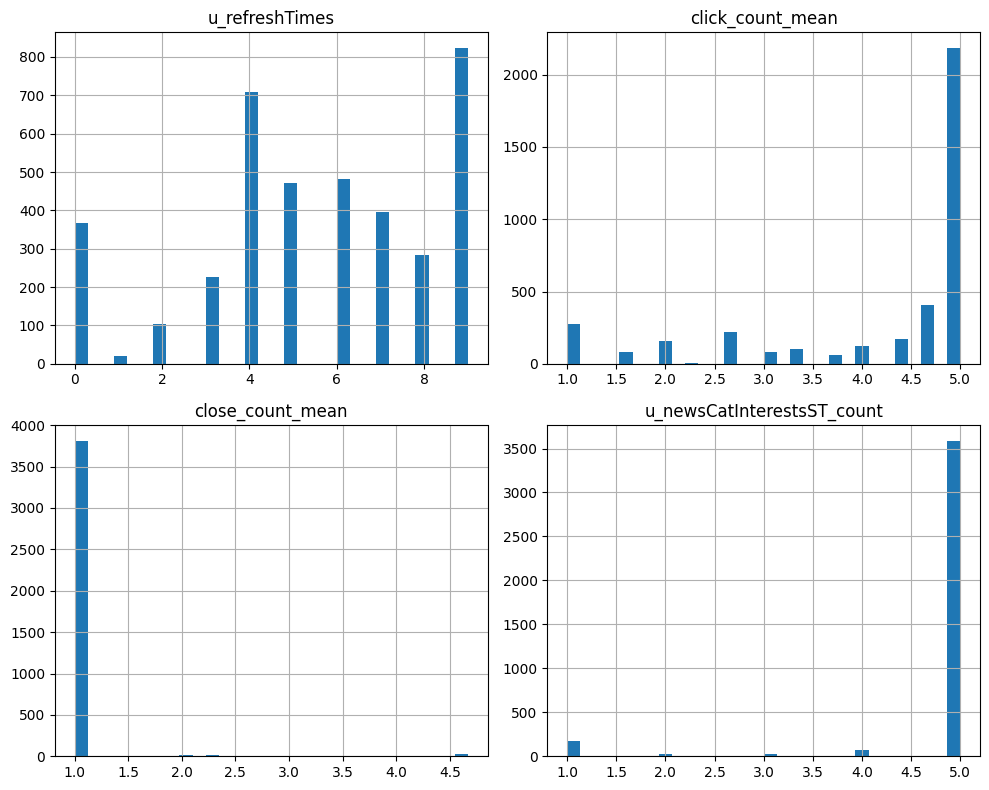

In [ ]:
# original D1
d1_og = D_processed["D4"][numeric_features]
d1_og.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

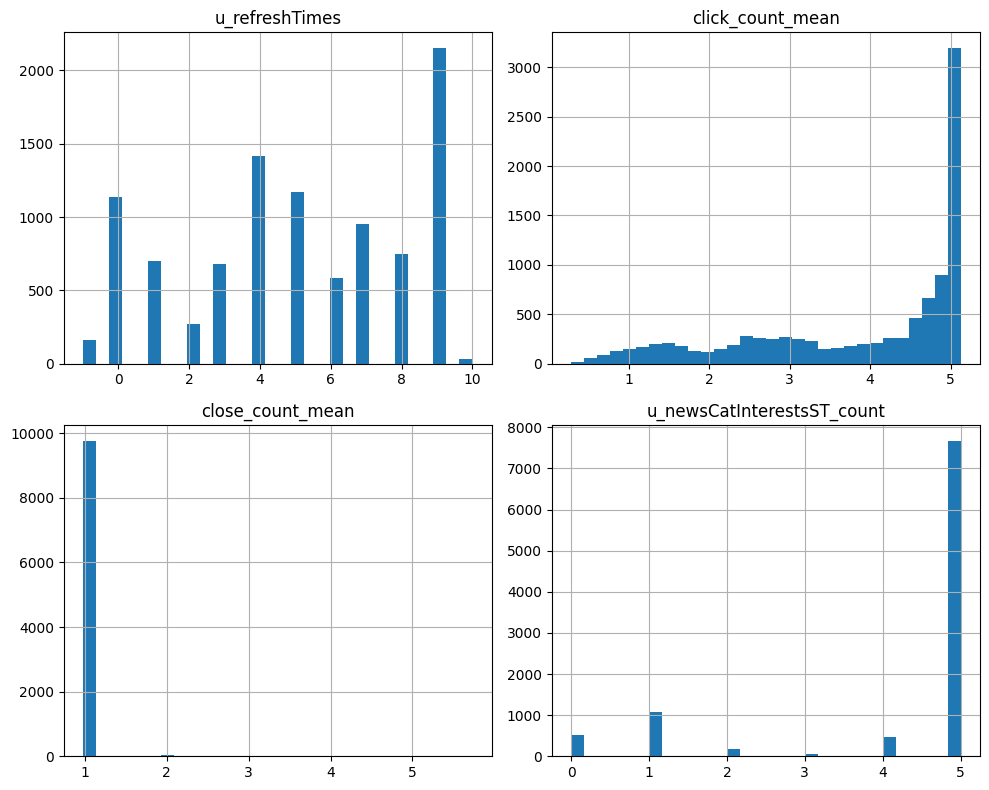

In [ ]:
d1_synth_numeric = d4_synth_ctgan[numeric_features]
d1_synth_numeric.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

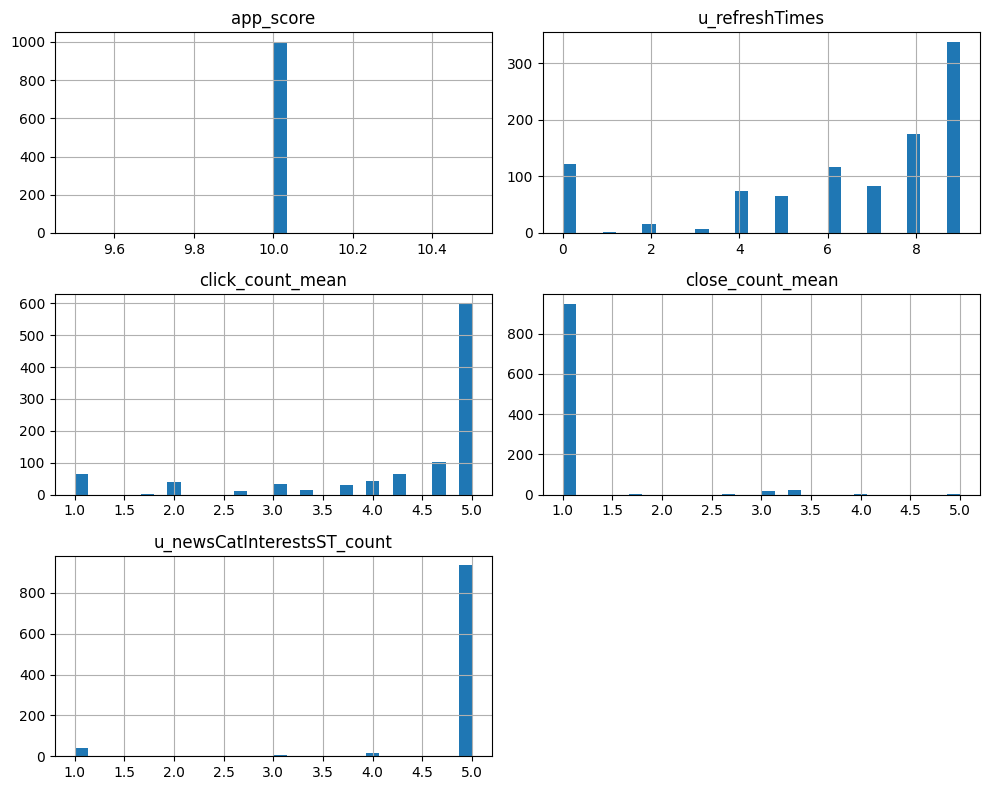

In [ ]:
d1_synth_realtab_num = d1_synth_realtab[numeric_features]
d1_synth_realtab_num.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

### countplots -

In [ ]:
D_processed["D4"]['label'].value_counts(normalize=True)

label
0    0.954124
1    0.045876
Name: proportion, dtype: float64

In [ ]:
d4_synth_ctgan['label'].value_counts(normalize=True)

label
0    0.8349
1    0.1651
Name: proportion, dtype: float64

In [ ]:
d1_synth_realtab['label'].value_counts(normalize=True)

label
0    0.946
1    0.054
Name: proportion, dtype: float64